# CHIKV_Mac HIPPO FFF Prod. 10c (scoring & selection)

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
import hippo
from pathlib import Path
from mlog import setup_logger
import pandas as pd
import numpy as np
import molparse as mp
from tqdm import tqdm
from hippo_plot import write_html
logger=setup_logger('notebook')

In [2]:
animal = hippo.HIPPO('CHIKV_prod10b', 'CHIKV_prod10b.sqlite')
# animal = hippo.HIPPO('CHIKV_prod10b', 'CHIKV_prod10b.sqlite', copy_from='CHIKV_prod9b.sqlite', overwrite_existing=False)

 Creating HIPPO animal

name = CHIKV_prod10b

db_path = CHIKV_prod10b.sqlite

DEBUG: hippo.Database.__init__()

DEBUG: Database.path = CHIKV_prod10b.sqlite

DEBUG: hippo.Database.connect()

DEBUG: sqlite3.version='2.6.0'

 Success  Database connected @ CHIKV_prod10b.sqlite!

 Success  Initialised animal HIPPO("CHIKV_prod10b")!

In [3]:
# animal.db.backup()

## Load recipes

In [5]:
recipes = hippo.recipe.RecipeSet(animal.db, 'CHIKV_prod13_recipes') 

 DISK  Reading CHIKV_prod13_recipes/*.json...

Output()

 Success  Loaded 189 Recipes!

## Add missing interactions

In [5]:
animal.poses[:].fraction_fingerprinted

0.7288847952641133

In [6]:
for recipe in recipes:
    # print(recipe)
    poses = recipe.products.poses.get_by_tag('deprecated', inverse=True)
    frac = poses.fraction_fingerprinted
    

    # break

    if frac == 1.0:
        continue
    else:
        print(recipe, f'{frac:.2%}')
        

    for pose in poses:
        if not pose.has_fingerprint:
            print(pose)
            pose.calculate_interactions()
            
    # break

KeyboardInterrupt: 

## Assign Subsites

In [23]:
animal.tags.unique

{'DF',
 'Enamine',
 'JA',
 'SeeSAR',
 'Syndirella base',
 '[Other] ADPr',
 '[Other] Adenine site',
 '[Other] Arg144 pocket',
 '[Other] Arg144 subsite',
 '[Other] New',
 '[Other] Oxyanion site',
 '[Other] Phosphate site',
 '[Other] Ribose site',
 '[Other] Trp148 site',
 '[Other] Trp148 subsite',
 '[Other] adenine site',
 '[Other] external',
 '[Other] fragment screen',
 '[Other] ignore',
 '[Other] oxyanion hole',
 '[Other] phosphate-binding site',
 '[Other] ribose site',
 '[Series] ASAP toolbox',
 '[Series] catalogue compound',
 'arg144_pures',
 'butcher: adenine',
 'butcher: arginine',
 'butcher: oxyanion',
 'butcher: phosphate',
 'butcher: ribose',
 'deprecated',
 'fragmenstein',
 'hits',
 'hits (deprecated)',
 'knitwork',
 'merge',
 'pure_merges',
 'rahman_REAL',
 'rahman_pure',
 'rahman_selection',
 'raw'}

In [22]:
animal.tags.delete("Quatassemblies upload name")

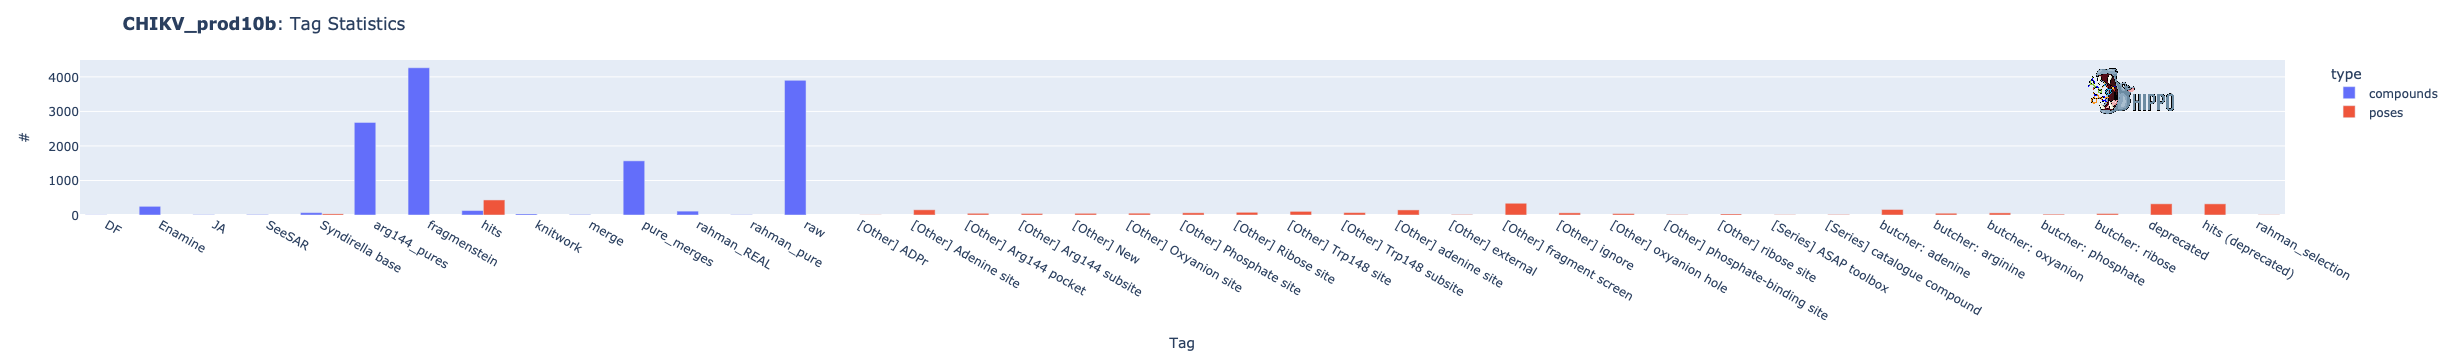

In [24]:
animal.plot_tag_statistics()

In [25]:
from posebutcher import PoseButcher

In [26]:
butcher = PoseButcher.from_directory('../butcher_6VUQ')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
 DISK  Reading ../butcher_6VUQ/butcher_6VUQ.json
 DISK  Reading ../butcher_6VUQ/protein.pdb
 DISK  Writing _butcher_protein.pdb
 DISK  Reading ../butcher_6VUQ/_protein_hull.ply
 DISK  Reading ../butcher_6VUQ/_protein_mesh.ply
 DISK  Reading ../butcher_6VUQ/pocket_adenine (A).ply
 DISK  Reading ../butcher_6VUQ/pocket_ribose (A).ply
 DISK  Reading ../butcher_6VUQ/pocket_phosphate (A).ply
 DISK  Reading ../butcher_6VUQ/pocket_oxyanion (A).ply
 DISK  Reading ../butcher_6VUQ/pocket_arginine (A).ply
 DISK  Reading ../butcher_6VUQ/pocket_adenine (B).ply
 DISK  Reading ../butcher_6VUQ/pocket_ribose (B).ply
 DISK  Reading ../butcher_6VUQ/pocket_phosphate (B).ply
 DISK  Reading ../butcher_6VUQ/pocket_oxyanion (B).ply
 DISK  Reading ../butcher_6VUQ/pocket_arginine (B).ply
 DISK  Reading ../butcher_6VUQ/pocket_adenine (C).ply
 DISK

In [27]:
rgen = hippo.RandomRecipeGenerator.from_json(animal.db, 'CHIKV_prod8b_rgen.json')

session = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod10b.sqlite
in file = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod8b.sqlite
 Warning  Database path mismatch
Recipe was generated at: 2024-10-11 17:39:46.757934
reactants = {I x 32}
intermediates = {I x 0}
products = {I x 20}
reactions = {R x 20}
database = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod8b.sqlite
max_lead_time = None
suppliers = ['Stock', 'Enamine']


100%|██████████| 15435/15435 [00:34<00:00, 445.50it/s]


In [28]:
poses = rgen.route_pool.products.poses.get_by_tag('deprecated', inverse=True)
poses

{P x 19882}

In [29]:
pocket_names = set(p.split(' (')[0] for p in butcher.pockets.keys())
pocket_names

{'adenine', 'arginine', 'oxyanion', 'phosphate', 'ribose'}

In [31]:
# for pocket in pocket_names:
    # animal.db.insert_subsite(target=1, name=pocket)
animal.db.print_table('subsite')

[(1, 1, 'adenine', None),
 (2, 1, 'arginine', None),
 (3, 1, 'oxyanion', None),
 (4, 1, 'phosphate', None),
 (5, 1, 'ribose', None)]


In [30]:
split_poses = poses.split_by_reference()
split_poses

{5809: {P x 6550},
 5802: {P x 12928},
 6166: {P x 404}}

In [32]:
butchers = {}
for ref_id, pset in split_poses.items():
    ref_pose = animal.poses[ref_id]
    butchers[ref_id] = PoseButcher.from_directory('../butcher_6VUQ')
    butchers[ref_id].protein = ref_pose.path

 DISK  Reading ../butcher_6VUQ/butcher_6VUQ.json
 DISK  Reading ../butcher_6VUQ/protein.pdb
 DISK  Writing _butcher_protein.pdb
 DISK  Reading ../butcher_6VUQ/_protein_hull.ply
 DISK  Reading ../butcher_6VUQ/_protein_mesh.ply
 DISK  Reading ../butcher_6VUQ/pocket_adenine (A).ply
 DISK  Reading ../butcher_6VUQ/pocket_ribose (A).ply
 DISK  Reading ../butcher_6VUQ/pocket_phosphate (A).ply
 DISK  Reading ../butcher_6VUQ/pocket_oxyanion (A).ply
 DISK  Reading ../butcher_6VUQ/pocket_arginine (A).ply
 DISK  Reading ../butcher_6VUQ/pocket_adenine (B).ply
 DISK  Reading ../butcher_6VUQ/pocket_ribose (B).ply
 DISK  Reading ../butcher_6VUQ/pocket_phosphate (B).ply
 DISK  Reading ../butcher_6VUQ/pocket_oxyanion (B).ply
 DISK  Reading ../butcher_6VUQ/pocket_arginine (B).ply
 DISK  Reading ../butcher_6VUQ/pocket_adenine (C).ply
 DISK  Reading ../butcher_6VUQ/pocket_ribose (C).ply
 DISK  Reading ../butcher_6VUQ/pocket_phosphate (C).ply
 DISK  Reading ../butcher_6VUQ/pocket_oxyanion (C).ply
 DISK  Rea

In [33]:
for ref_id, pset in split_poses.items():

    butcher = butchers[ref_id]

    for pose in tqdm(pset):

        tags = butcher.tag(pose.mol, pockets_only=True)
        # print(pose, tags)

        for tag in tags:
            tag = tag.split(' (')[0]
            animal.db.insert_subsite_tag(pose_id=pose.id, name=tag, target=1, commit=False)

    animal.db.commit()

  6%|▌         | 387/6550 [00:22<06:48, 15.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30969
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30969
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30970
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30970


  6%|▌         | 389/6550 [00:22<06:23, 16.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30971
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30971
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30972
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30972
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30973
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30973


  6%|▌         | 392/6550 [00:23<05:17, 19.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30974
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30974
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30975
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30975
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30976
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30976


  6%|▌         | 395/6550 [00:23<04:50, 21.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30977
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30977
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30978
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30978
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30979
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30979


  6%|▌         | 398/6550 [00:23<04:24, 23.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30980
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30980
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30983
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30983
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30984
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30984


  6%|▌         | 401/6550 [00:23<04:40, 21.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30985
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30985
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30986
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30986
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30987
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30987


  6%|▌         | 404/6550 [00:23<04:52, 20.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30988
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30988
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30989
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30989
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30990
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30990


  6%|▌         | 407/6550 [00:23<04:31, 22.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30991
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30991
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30992
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30992
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30993
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30993


  6%|▋         | 410/6550 [00:23<04:26, 23.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30994
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30994
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30995
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30995
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30996
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30996


  6%|▋         | 413/6550 [00:23<04:19, 23.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30997
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30997
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30998
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30998
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=30999
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=30999


  6%|▋         | 416/6550 [00:24<04:17, 23.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31000
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31000
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31001
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31001
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31002
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31002


  6%|▋         | 419/6550 [00:24<04:34, 22.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31003
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31003
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31004
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31004
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31023
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31023


  6%|▋         | 422/6550 [00:24<04:20, 23.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31024
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31024
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31025
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31025
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31026
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31026


  6%|▋         | 425/6550 [00:24<04:24, 23.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31027
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31027
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31028
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31028
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31029
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31029


  7%|▋         | 428/6550 [00:24<04:40, 21.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31030
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31030
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31031
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31031
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31032
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31032


  7%|▋         | 431/6550 [00:24<04:18, 23.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31035
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31035
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31036
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31036
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31037
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31037


  7%|▋         | 434/6550 [00:25<05:57, 17.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31038
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31038
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31039
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31039
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31040
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31040


  7%|▋         | 437/6550 [00:26<22:11,  4.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31041
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31041
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31041
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31042
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31042
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31053
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31053
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31054
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31054


  7%|▋         | 441/6550 [00:26<15:03,  6.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31055
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31055
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31056
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31056
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31057
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31057
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31063
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31063


  7%|▋         | 445/6550 [00:27<10:55,  9.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31064
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31064
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31097
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31097
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31098
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31098
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31099
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31099


  7%|▋         | 449/6550 [00:27<08:15, 12.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31100
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31100
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31101
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31101
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31102
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31102


  7%|▋         | 452/6550 [00:27<07:01, 14.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31103
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31103
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31104
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31104
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31105
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31105
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31106
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31106


  7%|▋         | 456/6550 [00:27<05:44, 17.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31107
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31107
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31108
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31108
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31109
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31109
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31110
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31110


  7%|▋         | 460/6550 [00:27<04:53, 20.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31111
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31111
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31112
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31112
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31113
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31113
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31114
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31114


  7%|▋         | 464/6550 [00:27<04:22, 23.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31115
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31115
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31116
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31116
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31117
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31117
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31118
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31118


  7%|▋         | 468/6550 [00:27<04:00, 25.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31119
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31119
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31120
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31120
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31121
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31121
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31122
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31122


  7%|▋         | 472/6550 [00:27<04:14, 23.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31123
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31123
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31124
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31124
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31125
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31125


  7%|▋         | 475/6550 [00:28<04:22, 23.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31126
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31126
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31127
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31127
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31128
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31128


  7%|▋         | 478/6550 [00:28<05:48, 17.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31129
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31129
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31130
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31130
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31131
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31131


  7%|▋         | 481/6550 [00:28<05:36, 18.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31132
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31132
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31133
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31133
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31133
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31134
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31134


  7%|▋         | 484/6550 [00:28<06:03, 16.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31135
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31135
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31136
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31136
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31137
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31137


  7%|▋         | 487/6550 [00:28<05:31, 18.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31138
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31138
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31139
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31139
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31140
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31140


  7%|▋         | 490/6550 [00:28<04:58, 20.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31141
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31141
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31142
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31142
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31143
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31143


  8%|▊         | 493/6550 [00:29<04:31, 22.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31144
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31144
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31145
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31145
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31146
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31146


  8%|▊         | 496/6550 [00:29<04:31, 22.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31147
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31147
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31148
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31148
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31149
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31149


  8%|▊         | 499/6550 [00:29<04:19, 23.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31150
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31150
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31151
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31151
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31152
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31152


  8%|▊         | 502/6550 [00:29<04:07, 24.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31153
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31153
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31154
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31154
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31155
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31155


  8%|▊         | 505/6550 [00:29<04:26, 22.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31156
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31156
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31157
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31157
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31158
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31158


  8%|▊         | 508/6550 [00:29<05:34, 18.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31159
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31159
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31160
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31160
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31161
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31161


  8%|▊         | 511/6550 [00:30<05:42, 17.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31162
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31162
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31163
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31163
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31164
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31164


  8%|▊         | 514/6550 [00:30<05:07, 19.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31165
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31165
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31166
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31166
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31167
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31167


  8%|▊         | 517/6550 [00:30<04:42, 21.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31168
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31168
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31169
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31169
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31170
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31170


  8%|▊         | 520/6550 [00:30<04:22, 22.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31171
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31171
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31172
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31172
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31173
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31173


  8%|▊         | 523/6550 [00:30<04:19, 23.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31174
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31174
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31175
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31175
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31176
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31176


  8%|▊         | 526/6550 [00:30<07:45, 12.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31177
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31177
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31178
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31178
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31179
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31179


  8%|▊         | 529/6550 [00:31<06:31, 15.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31180
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31180
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31181
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31181
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31182
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31182
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31183
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31183


  8%|▊         | 533/6550 [00:31<05:20, 18.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31184
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31184
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31185
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31185
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31186
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31186
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31187
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31187


  8%|▊         | 537/6550 [00:31<04:38, 21.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31188
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31188
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31189
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31189
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31190
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31190


  8%|▊         | 540/6550 [00:31<04:17, 23.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31191
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31191
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31192
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31192
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31193
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31193
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31194
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31194


  8%|▊         | 544/6550 [00:31<03:54, 25.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31195
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31195
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31196
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31196
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31197
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31197


  8%|▊         | 547/6550 [00:31<04:25, 22.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31198
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31198
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31199
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31199
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31202
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31202
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31202


  8%|▊         | 550/6550 [00:31<04:50, 20.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31203
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31203
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31203
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31204
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31204
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31205
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31205


  8%|▊         | 553/6550 [00:32<04:31, 22.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31206
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31206
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31207
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31207
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31210
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31210


  8%|▊         | 556/6550 [00:32<05:49, 17.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31211
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31211
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31212
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31212
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31213
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31213


  9%|▊         | 559/6550 [00:32<05:12, 19.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31239
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31239
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31240
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31240
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31301
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31301


  9%|▊         | 562/6550 [00:32<05:20, 18.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31302
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31302
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31333
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31333
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31334
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31334


  9%|▊         | 565/6550 [00:32<04:56, 20.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31362
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31362
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31363
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31363
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31391
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31391


  9%|▊         | 568/6550 [00:32<04:39, 21.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31392
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31392
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31394
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31394
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31395
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31395


  9%|▊         | 571/6550 [00:32<04:25, 22.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31396
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31396
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31397
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31397
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31398
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31398


  9%|▉         | 574/6550 [00:33<04:14, 23.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31399
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31399
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31402
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31402
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31403
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31403


  9%|▉         | 577/6550 [00:33<04:07, 24.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31404
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31404
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31404
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31405
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31405
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31406
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31406


  9%|▉         | 580/6550 [00:33<04:01, 24.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31407
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31407
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31408
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31408
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31409
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31409


  9%|▉         | 583/6550 [00:33<04:11, 23.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31410
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31410
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31411
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31411
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31412
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31412
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31412


  9%|▉         | 586/6550 [00:33<04:05, 24.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31413
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31413
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31413
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31414
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31414
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31415
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31415


  9%|▉         | 589/6550 [00:33<04:10, 23.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31420
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31420
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31421
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31421
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31422
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31422


  9%|▉         | 592/6550 [00:33<04:42, 21.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31423
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31423
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31424
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31424
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31425
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31425


  9%|▉         | 595/6550 [00:35<15:21,  6.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31426
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31426
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31427
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31427


  9%|▉         | 597/6550 [00:35<13:11,  7.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31428
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31428
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31429
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31429
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31430
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31430


  9%|▉         | 600/6550 [00:35<10:01,  9.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31431
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31431
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31432
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31432
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31433
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31433


  9%|▉         | 603/6550 [00:35<09:20, 10.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31434
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31434
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31435
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31435
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31436
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31436


  9%|▉         | 606/6550 [00:35<07:53, 12.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31437
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31437
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31438
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31438
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31439
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31439


  9%|▉         | 609/6550 [00:35<06:30, 15.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31440
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31440
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31441
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31441
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31442
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31442


  9%|▉         | 612/6550 [00:35<05:31, 17.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31443
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31443
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31444
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31444
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31445
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31445


  9%|▉         | 615/6550 [00:35<05:12, 18.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31446
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31446
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31447
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31447
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31452
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31452


  9%|▉         | 618/6550 [00:36<04:40, 21.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31453
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31453
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31456
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31456
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31457
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31457


  9%|▉         | 621/6550 [00:36<04:25, 22.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31458
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31458
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31459
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31459
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31460
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31460


 10%|▉         | 624/6550 [00:36<04:10, 23.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31461
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31461
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31462
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31462
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31463
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31463


 10%|▉         | 627/6550 [00:36<04:03, 24.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31464
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31464
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31464
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31465
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31465
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31466
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31466
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31467
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31467


 10%|▉         | 631/6550 [00:36<03:34, 27.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31468
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31468
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31469
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31469
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31470
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31470
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31470


 10%|▉         | 634/6550 [00:36<03:31, 27.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31471
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31471
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31471
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31472
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31472
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31473
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31473


 10%|▉         | 637/6550 [00:36<03:41, 26.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31474
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31474
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31475
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31475
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31476
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31476


 10%|▉         | 640/6550 [00:36<04:08, 23.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31477
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31477
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31478
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31478
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31479
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31479
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31480
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31480


 10%|▉         | 644/6550 [00:37<03:37, 27.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31481
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31481
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31482
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31482
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31483
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31483
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31484
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31484


 10%|▉         | 648/6550 [00:37<03:19, 29.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31485
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31485
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31486
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31486
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31487
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31487
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31488
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31488


 10%|▉         | 652/6550 [00:37<03:05, 31.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31489
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31489
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31489
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31490
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31490
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31491
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31491
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31492
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31492


 10%|█         | 656/6550 [00:37<02:58, 33.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31493
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31493
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31494
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31494
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31495
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31495
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31495
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31496
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31496
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31496


 10%|█         | 660/6550 [00:37<03:07, 31.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31497
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31497
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31498
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31498
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31499
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31499
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31499
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31500
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31500


 10%|█         | 664/6550 [00:37<03:39, 26.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31503
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31503
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31504
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31504
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31505
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31505


 10%|█         | 667/6550 [00:37<04:05, 23.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31509
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31509
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31510
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31510
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31511
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31511
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31512
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31512


 10%|█         | 671/6550 [00:37<03:39, 26.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31513
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31513
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31514
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31514
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31515
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31515
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31516
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31516


 10%|█         | 675/6550 [00:38<03:29, 27.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31517
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31517
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31518
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31518
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31519
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31519


 10%|█         | 678/6550 [00:38<03:40, 26.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31520
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31520
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31521
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31521
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31522
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31522


 10%|█         | 681/6550 [00:38<03:41, 26.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31523
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31523
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31524
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31524
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31525
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31525
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31526
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31526


 10%|█         | 685/6550 [00:38<03:33, 27.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31527
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31527
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31528
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31528
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31529
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31529


 11%|█         | 688/6550 [00:38<03:53, 25.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31530
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31530
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31531
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31531
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31532
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31532
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31533
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31533


 11%|█         | 692/6550 [00:38<03:43, 26.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31534
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31534
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31535
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31535
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31536
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31536


 11%|█         | 695/6550 [00:38<03:54, 24.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31537
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31537
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31538
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31538
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31539
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31539


 11%|█         | 698/6550 [00:39<03:52, 25.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31540
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31540
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31546
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31546
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31547
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31547


 11%|█         | 701/6550 [00:39<03:50, 25.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31548
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31548
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31549
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31549
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31550
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31550


 11%|█         | 704/6550 [00:39<04:02, 24.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31551
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31551
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31551
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31552
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31552
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31553
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31553


 11%|█         | 707/6550 [00:39<04:14, 22.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31554
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31554
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31555
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31555
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31556
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31556
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31559
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31559


 11%|█         | 711/6550 [00:39<03:43, 26.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31560
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31560
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31561
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31561
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31562
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31562
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31563
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31563


 11%|█         | 715/6550 [00:39<03:26, 28.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31564
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31564
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31567
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31567
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31568
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31568


 11%|█         | 718/6550 [00:39<03:51, 25.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31569
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31569
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31570
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31570
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31571
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31571


 11%|█         | 721/6550 [00:39<03:42, 26.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31572
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31572
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31573
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31573
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31574
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31574
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31575
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31575


 11%|█         | 725/6550 [00:40<03:23, 28.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31580
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31580
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31581
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31581
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31582
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31582
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31583
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31583
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31583


 11%|█         | 729/6550 [00:40<03:06, 31.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31584
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31584
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31585
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31585
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31586
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31586
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31599
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31599


 11%|█         | 733/6550 [00:40<02:56, 33.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31600
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31600
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31601
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31601
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31601
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31602
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31602
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31604
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31604


 11%|█▏        | 737/6550 [00:40<02:52, 33.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31605
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31605
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31662
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31662
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31663
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31663
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31664
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31664


 11%|█▏        | 741/6550 [00:40<03:15, 29.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31672
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31672
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31673
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31673
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31683
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31683
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31684
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31684


 11%|█▏        | 745/6550 [00:40<03:19, 29.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31685
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31685
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31685
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31686
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31686
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31686
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31687
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31687


 11%|█▏        | 748/6550 [00:40<03:25, 28.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31688
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31688
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31688
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31689
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31689
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31690
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31690


 11%|█▏        | 751/6550 [00:41<11:12,  8.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31691
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31691
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31692
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31692
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31699
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31699
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=31699
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31699


 12%|█▏        | 754/6550 [00:42<09:44,  9.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31700
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31700
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=31700
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31700
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31701
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31701
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31732
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31732


 12%|█▏        | 757/6550 [00:42<08:08, 11.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31733
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31733
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31733
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31765
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31765
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31765
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31768
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31768
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31768
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31769
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31769
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31769


 12%|█▏        | 761/6550 [00:42<06:16, 15.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31772
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31772
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31773
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31773
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31773
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31774
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31774
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31774
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31775
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31775


 12%|█▏        | 765/6550 [00:42<05:05, 18.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31776
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31776
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31777
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31777
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31778
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31778
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31779
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31779
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31779


 12%|█▏        | 769/6550 [00:42<04:25, 21.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31780
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31780
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31780
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31781
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31781
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31782
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31782


 12%|█▏        | 772/6550 [00:42<04:17, 22.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31783
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31783
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31783
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31784
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31784
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31784
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31795
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31795


 12%|█▏        | 775/6550 [00:43<10:22,  9.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31796
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31796
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31807
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31807
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31808
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31808
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31808


 12%|█▏        | 778/6550 [00:43<08:33, 11.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31809
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31809
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31810
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31810
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31811
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31811


 12%|█▏        | 781/6550 [00:43<07:17, 13.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31812
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31812
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31813
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31813
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31814
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31814


 12%|█▏        | 784/6550 [00:43<06:22, 15.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31815
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31815
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31816
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31816
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31817
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31817


 12%|█▏        | 787/6550 [00:43<05:35, 17.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31818
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31818
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31819
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31819
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31820
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31820


 12%|█▏        | 790/6550 [00:44<04:57, 19.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31821
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31821
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31822
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31822
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31823
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31823
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31823
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31824
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31824


 12%|█▏        | 794/6550 [00:44<04:10, 23.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31825
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31825
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31826
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31826
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31827
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31827
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31828
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31828


 12%|█▏        | 798/6550 [00:44<03:44, 25.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31829
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31829
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31829
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31830
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31830
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31831
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31831


 12%|█▏        | 801/6550 [00:44<04:14, 22.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31832
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31832
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31833
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31833
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31834
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31834
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31834


 12%|█▏        | 804/6550 [00:45<08:48, 10.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31835
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31835
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31835
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31836
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31836


 12%|█▏        | 806/6550 [00:45<08:05, 11.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31837
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31837
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31838
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31838


 12%|█▏        | 808/6550 [00:45<07:22, 12.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31839
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31839
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31840
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31840
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31841
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31841
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31841


 12%|█▏        | 811/6550 [00:45<06:27, 14.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31842
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31842
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31842
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31843
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31843


 12%|█▏        | 813/6550 [00:45<06:18, 15.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31844
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31844
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31845
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31845
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31846
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31846


 12%|█▏        | 816/6550 [00:45<05:26, 17.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31847
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31847
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31848
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31848
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31849
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31849


 13%|█▎        | 819/6550 [00:45<04:44, 20.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31850
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31850
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31851
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31851
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31852
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31852
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31852
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31853
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31853


 13%|█▎        | 823/6550 [00:45<04:07, 23.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31854
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31854
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31854
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31855
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31855
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31855
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31856
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31856


 13%|█▎        | 826/6550 [00:46<04:16, 22.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31857
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31857
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31858
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31858
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31859
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31859


 13%|█▎        | 829/6550 [00:46<04:06, 23.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31860
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31860
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31861
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31861
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31862
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31862
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31863
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31863


 13%|█▎        | 833/6550 [00:46<03:34, 26.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31864
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31864
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31865
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31865
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31866
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31866
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31867
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31867


 13%|█▎        | 837/6550 [00:46<03:25, 27.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31868
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31868
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31869
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31869
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31870
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31870


 13%|█▎        | 840/6550 [00:46<03:30, 27.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31873
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31873
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31874
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31874
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31875
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31875


 13%|█▎        | 843/6550 [00:46<03:34, 26.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31876
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31876
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31877
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31877
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31878
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31878


 13%|█▎        | 846/6550 [00:46<03:39, 25.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31879
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31879
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31880
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31880
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31885
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31885


 13%|█▎        | 849/6550 [00:46<03:42, 25.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31886
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31886
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31887
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31887
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31887
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31888
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31888


 13%|█▎        | 852/6550 [00:47<03:42, 25.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31889
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31889
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31890
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31890
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31891
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31891


 13%|█▎        | 855/6550 [00:47<04:03, 23.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31892
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31892
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31892
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31893
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31893
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31893
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31894
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31894


 13%|█▎        | 858/6550 [00:47<04:14, 22.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31895
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31895
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31899
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31899
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31899
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31900
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31900
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31900


 13%|█▎        | 861/6550 [00:47<04:23, 21.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31901
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31901
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31901
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31902
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31902
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31903
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31903
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31903


 13%|█▎        | 864/6550 [00:47<04:14, 22.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31904
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31904
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31905
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31905
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31906
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31906


 13%|█▎        | 867/6550 [00:47<04:06, 23.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31909
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31909
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31910
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31910
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31911
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31911
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31911


 13%|█▎        | 870/6550 [00:47<05:05, 18.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31912
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31912
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31912
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31913
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31913
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31914
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31914


 13%|█▎        | 873/6550 [00:48<04:41, 20.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31915
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31915
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31916
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31916
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31916
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31917
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31917


 13%|█▎        | 876/6550 [00:48<04:25, 21.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31918
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31918
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31919
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31919
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31920
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31920


 13%|█▎        | 879/6550 [00:48<04:40, 20.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31921
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31921
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31921
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31922
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31922
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31922
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31923
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31923


 13%|█▎        | 882/6550 [00:48<04:23, 21.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31924
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31924
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31931
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31931
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31932
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31932


 14%|█▎        | 885/6550 [00:48<04:12, 22.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31933
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31933
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31934
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31934
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31935
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31935


 14%|█▎        | 888/6550 [00:48<04:01, 23.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31936
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31936
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31937
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31937
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31937
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31938
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31938
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31938


 14%|█▎        | 891/6550 [00:48<03:57, 23.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31939
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31939
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31939
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31940
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31940
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31941
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31941


 14%|█▎        | 894/6550 [00:48<03:53, 24.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31942
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31942
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31943
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31943
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31943
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31944
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31944
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31944


 14%|█▎        | 897/6550 [00:49<03:50, 24.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31945
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31945
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=31945
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31946
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31946
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=31946
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31947
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31947
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31947


 14%|█▎        | 900/6550 [00:49<03:55, 23.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31948
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31948
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31949
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31949
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31949
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31950
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31950
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31950


 14%|█▍        | 903/6550 [00:49<04:14, 22.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31951
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31951
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31952
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31952
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31953
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31953
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31953


 14%|█▍        | 906/6550 [00:49<04:04, 23.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31954
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31954
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31955
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31955
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31956
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31956
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31956


 14%|█▍        | 909/6550 [00:49<03:57, 23.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31957
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31957
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31958
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31958
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31959
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31959
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31959


 14%|█▍        | 912/6550 [00:49<03:52, 24.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31960
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31960
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31960
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31961
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31961
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31962
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31962


 14%|█▍        | 915/6550 [00:50<06:53, 13.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31963
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31963
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31964
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31964
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31965
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31965


 14%|█▍        | 918/6550 [00:50<05:57, 15.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31966
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31966
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31967
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31967
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31968
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31968


 14%|█▍        | 921/6550 [00:50<05:16, 17.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31969
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31969
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31970
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31970
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31971
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31971
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31971


 14%|█▍        | 924/6550 [00:50<04:48, 19.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31972
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31972
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31973
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31973
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31974
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31974
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31975
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31975


 14%|█▍        | 928/6550 [00:50<04:03, 23.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31976
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31976
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31977
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31977
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31978
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31978
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31979
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31979


 14%|█▍        | 932/6550 [00:50<03:32, 26.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31980
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31980
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31981
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31981
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31982
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31982


 14%|█▍        | 935/6550 [00:50<03:33, 26.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31983
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31983
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31984
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31984
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31985
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31985


 14%|█▍        | 938/6550 [00:51<03:43, 25.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31986
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31986
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31986
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31987
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31987
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31987
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31988
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31988


 14%|█▍        | 941/6550 [00:51<07:08, 13.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31989
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31989
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31990
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31990
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31991
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31991


 14%|█▍        | 944/6550 [00:51<06:04, 15.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31992
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31992
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31993
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31993
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31994
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31994
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31994
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31995
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31995


 14%|█▍        | 948/6550 [00:51<04:51, 19.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31996
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31996
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31996
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31997
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31997
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31998
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31998
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=31998
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=31999
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=31999


 15%|█▍        | 952/6550 [00:51<04:10, 22.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32000
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32000
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32000
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32001
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32001
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32002
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32002
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32003
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32003


 15%|█▍        | 956/6550 [00:51<03:39, 25.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32004
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32004
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32004
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32005
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32005
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32006
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32006
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32007
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32007


 15%|█▍        | 960/6550 [00:52<05:28, 17.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32008
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32008
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32008
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32009
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32009
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32009
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32010
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32010


 15%|█▍        | 963/6550 [00:52<05:18, 17.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32011
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32011
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32012
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32012
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32013
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32013


 15%|█▍        | 966/6550 [00:53<08:01, 11.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32016
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32016
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32017
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32017


 15%|█▍        | 968/6550 [00:53<07:37, 12.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32018
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32018
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32018
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32019
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32019


 15%|█▍        | 970/6550 [00:53<07:09, 12.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32020
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32020
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32021
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32021
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32022
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32022


 15%|█▍        | 973/6550 [00:53<06:19, 14.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32023
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32023
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32024
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32024


 15%|█▍        | 975/6550 [00:53<05:55, 15.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32025
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32025
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32026
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32026
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32027
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32027


 15%|█▍        | 978/6550 [00:53<05:14, 17.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32028
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32028
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32029
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32029
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32029
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32030
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32030
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32030


 15%|█▍        | 981/6550 [00:53<04:43, 19.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32033
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32033
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32034
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32034
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32035
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32035


 15%|█▌        | 984/6550 [00:53<04:30, 20.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32036
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32036
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32037
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32037
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32038
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32038


 15%|█▌        | 987/6550 [00:54<04:20, 21.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32039
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32039
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32040
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32040
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32040
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32041
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32041


 15%|█▌        | 990/6550 [00:54<04:21, 21.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32042
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32042
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32043
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32043
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32055
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32055


 15%|█▌        | 993/6550 [00:54<04:15, 21.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32056
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32056
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32073
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32073
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32074
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32074


 15%|█▌        | 996/6550 [00:54<04:13, 21.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32078
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32078
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32079
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32079
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32088
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32088


 15%|█▌        | 999/6550 [00:54<04:03, 22.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32089
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32089
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32090
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32090
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32091
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32091


 15%|█▌        | 1002/6550 [00:54<04:00, 23.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32111
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32111
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32112
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32112
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32113
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32113


 15%|█▌        | 1005/6550 [00:54<04:21, 21.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32114
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32114
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32114
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32115
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32115
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32115
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32116
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32116


 15%|█▌        | 1008/6550 [00:54<04:05, 22.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32117
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32117
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32118
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32118
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32119
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32119


 15%|█▌        | 1011/6550 [00:55<03:58, 23.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32120
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32120
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32120
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32121
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32121
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32121
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32122
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32122


 15%|█▌        | 1014/6550 [00:55<03:50, 23.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32123
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32123
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32124
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32124
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32127
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32127
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32128
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32128


 16%|█▌        | 1018/6550 [00:55<03:35, 25.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32129
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32129
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32130
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32130
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32131
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32131


 16%|█▌        | 1021/6550 [00:55<03:48, 24.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32132
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32132
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32133
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32133
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32134
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32134


 16%|█▌        | 1024/6550 [00:55<03:47, 24.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32135
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32135
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32136
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32136
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32137
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32137


 16%|█▌        | 1027/6550 [00:55<03:48, 24.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32138
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32138
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32139
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32139
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32140
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32140


 16%|█▌        | 1030/6550 [00:55<03:45, 24.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32141
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32141
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32144
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32144
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32145
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32145


 16%|█▌        | 1033/6550 [00:55<03:44, 24.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32146
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32146
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32147
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32147
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32148
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32148


 16%|█▌        | 1036/6550 [00:56<03:57, 23.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32149
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32149
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32150
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32150
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32151
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32151


 16%|█▌        | 1039/6550 [00:56<03:57, 23.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32152
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32152
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32153
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32153
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32154
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32154


 16%|█▌        | 1042/6550 [00:56<04:35, 20.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32155
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32155
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32156
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32156
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32157
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32157


 16%|█▌        | 1045/6550 [00:56<04:41, 19.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32158
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32158
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32159
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32159
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32160
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32160


 16%|█▌        | 1048/6550 [00:56<04:37, 19.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32161
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32161
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32162
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32162
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32163
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32163


 16%|█▌        | 1051/6550 [00:57<10:34,  8.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32173
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32173
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32174
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32174


 16%|█▌        | 1053/6550 [00:57<09:49,  9.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32175
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32175
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32176
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32176


 16%|█▌        | 1055/6550 [00:58<10:52,  8.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32183
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32183
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32199
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32199
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32199
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32200
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32200
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32200
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32225
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32225
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32225


 16%|█▌        | 1059/6550 [00:58<07:42, 11.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32226
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32226
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32226
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32227
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32227
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32254
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32254
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32255
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32255
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32255


 16%|█▌        | 1063/6550 [00:58<05:54, 15.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32256
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32256
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32257
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32257
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32258
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32258
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32260
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32260
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32260


 16%|█▋        | 1067/6550 [00:58<04:54, 18.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32261
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32261
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32261
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32262
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32262
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32263
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32263
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32263


 16%|█▋        | 1070/6550 [00:58<04:37, 19.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32264
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32264
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32264
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32265
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32265
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32265
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32266
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32266
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32267
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32267
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32267


 16%|█▋        | 1074/6550 [00:58<04:00, 22.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32268
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32268
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32268
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32269
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32269
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32270
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32270
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32271
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32271


 16%|█▋        | 1078/6550 [00:58<03:44, 24.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32272
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32272
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32272
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32273
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32273
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32274
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32274
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32274


 17%|█▋        | 1081/6550 [00:58<04:01, 22.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32275
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32275
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32275
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32276
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32276
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32276
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32277
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32277
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32277


 17%|█▋        | 1084/6550 [00:59<03:57, 23.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32278
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32278
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32278
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32279
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32279
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32280
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32280


 17%|█▋        | 1087/6550 [00:59<03:49, 23.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32281
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32281
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32282
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32282
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32283
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32283


 17%|█▋        | 1090/6550 [00:59<03:48, 23.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32284
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32284
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32285
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32285
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32286
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32286


 17%|█▋        | 1093/6550 [00:59<03:49, 23.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32287
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32287
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32288
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32288
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32289
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32289


 17%|█▋        | 1096/6550 [00:59<03:46, 24.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32290
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32290
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32292
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32292
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32293
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32293


 17%|█▋        | 1099/6550 [00:59<04:04, 22.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32294
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32294
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32295
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32295
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32296
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32296


 17%|█▋        | 1102/6550 [00:59<03:55, 23.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32297
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32297
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32298
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32298
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32299
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32299


 17%|█▋        | 1105/6550 [01:00<04:04, 22.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32300
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32300
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32300
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32301
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32301
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32301
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32302
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32302
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32303
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32303


 17%|█▋        | 1109/6550 [01:00<03:35, 25.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32304
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32304
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32305
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32305
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32306
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32306
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32306
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32307
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32307
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32307


 17%|█▋        | 1113/6550 [01:00<03:16, 27.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32308
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32308
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32309
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32309
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32310
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32310
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32311
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32311


 17%|█▋        | 1117/6550 [01:00<03:06, 29.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32312
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32312
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32313
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32313
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32314
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32314
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32314


 17%|█▋        | 1120/6550 [01:00<03:08, 28.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32315
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32315
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32315
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32316
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32316
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32316
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32317
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32317
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32317


 17%|█▋        | 1123/6550 [01:00<03:12, 28.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32318
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32318
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32319
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32319
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32319
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32320
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32320
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32320


 17%|█▋        | 1126/6550 [01:00<03:45, 24.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32321
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32321
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32322
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32322
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32323
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32323


 17%|█▋        | 1129/6550 [01:00<03:51, 23.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32324
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32324
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32325
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32325
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32326
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32326
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32326


 17%|█▋        | 1132/6550 [01:01<03:45, 23.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32327
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32327
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32328
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32328
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32329
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32329


 17%|█▋        | 1135/6550 [01:01<03:43, 24.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32330
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32330
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32330
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32331
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32331
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32331
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32332
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32332


 17%|█▋        | 1138/6550 [01:01<03:55, 22.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32333
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32333
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32333
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32334
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32334
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32335
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32335


 17%|█▋        | 1141/6550 [01:01<08:28, 10.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32336
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32336
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32337
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32337


 17%|█▋        | 1143/6550 [01:02<08:04, 11.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32338
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32338
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32339
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32339


 17%|█▋        | 1145/6550 [01:02<07:17, 12.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32340
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32340
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32341
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32341
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32341
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32342
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32342


 18%|█▊        | 1148/6550 [01:02<06:07, 14.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32343
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32343
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32344
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32344
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32345
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32345
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32345


 18%|█▊        | 1151/6550 [01:02<05:12, 17.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32346
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32346
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32346
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32347
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32347
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32347
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32348
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32348
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32348


 18%|█▊        | 1154/6550 [01:02<05:04, 17.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32349
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32349
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32350
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32350
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32350
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32351
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32351
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32351


 18%|█▊        | 1157/6550 [01:02<04:37, 19.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32352
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32352
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32352
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32353
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32353
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32354
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32354


 18%|█▊        | 1160/6550 [01:03<07:43, 11.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32355
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32355
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32358
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32358
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32359
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32359


 18%|█▊        | 1163/6550 [01:03<06:39, 13.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32360
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32360
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32361
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32361
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32362
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32362


 18%|█▊        | 1166/6550 [01:03<05:45, 15.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32363
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32363
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32364
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32364
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32364
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32365
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32365


 18%|█▊        | 1169/6550 [01:03<05:07, 17.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32366
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32366
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32366
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32367
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32367
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32367
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32368
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32368


 18%|█▊        | 1172/6550 [01:03<04:41, 19.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32369
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32369
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32369
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32370
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32370
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32371
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32371


 18%|█▊        | 1175/6550 [01:03<04:24, 20.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32372
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32372
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32372
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32373
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32373
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32373
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32374
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32374


 18%|█▊        | 1178/6550 [01:03<04:08, 21.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32375
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32375
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32376
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32376
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32377
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32377


 18%|█▊        | 1181/6550 [01:04<04:00, 22.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32378
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32378
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32379
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32379
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32379
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32380
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32380
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32380


 18%|█▊        | 1184/6550 [01:04<03:50, 23.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32381
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32381
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32381
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32382
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32382
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32382
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32383
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32383


 18%|█▊        | 1187/6550 [01:04<03:44, 23.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32384
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32384
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32385
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32385
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=32385
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32386
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32386
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=32386


 18%|█▊        | 1190/6550 [01:04<06:11, 14.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32387
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32387
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32388
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32388
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32389
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32389


 18%|█▊        | 1193/6550 [01:04<05:19, 16.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32390
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32391
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32391
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32391
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32392
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32392
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32392


 18%|█▊        | 1196/6550 [01:04<05:11, 17.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32393
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32393
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=32393
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32394
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32394
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=32394
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32395
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32395


 18%|█▊        | 1199/6550 [01:05<09:13,  9.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32396
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32396
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32397
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32397
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32397


 18%|█▊        | 1201/6550 [01:05<10:17,  8.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32398
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32398
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32398
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32399
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32399
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32400
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32400


 18%|█▊        | 1204/6550 [01:06<08:08, 10.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32401
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32401
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32402
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32402
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32403
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32403
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32403


 18%|█▊        | 1207/6550 [01:06<06:43, 13.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32404
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32404
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32404
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32405
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32405
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32406
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32406


 18%|█▊        | 1210/6550 [01:06<05:48, 15.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32407
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32407
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32408
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32408
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32408
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32409
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32409
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32409


 19%|█▊        | 1213/6550 [01:06<05:14, 16.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32410
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32410
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32411
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32411
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32412
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32412


 19%|█▊        | 1216/6550 [01:06<04:48, 18.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32413
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32413
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32414
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32414
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32415
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32415
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32415


 19%|█▊        | 1219/6550 [01:06<04:29, 19.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32416
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32416
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32416
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32417
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32417
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32418
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32418


 19%|█▊        | 1222/6550 [01:06<04:18, 20.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32419
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32419
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32420
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32420
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32421
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32421


 19%|█▊        | 1225/6550 [01:06<04:08, 21.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32422
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32422
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32423
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32423
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32424
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32424


 19%|█▊        | 1228/6550 [01:07<03:57, 22.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32425
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32425
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32426
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32426
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32427
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32427
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32427


 19%|█▉        | 1231/6550 [01:07<04:00, 22.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32428
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32428
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32429
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32429
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32430
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32430


 19%|█▉        | 1234/6550 [01:07<03:53, 22.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32431
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32431
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32432
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32432
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32433
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32433
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32433


 19%|█▉        | 1237/6550 [01:07<03:47, 23.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32434
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32434
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32434
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32435
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32435
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32436
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32436


 19%|█▉        | 1240/6550 [01:07<03:45, 23.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32437
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32437
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32438
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32439
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32439
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32439


 19%|█▉        | 1243/6550 [01:07<03:45, 23.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32440
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32440
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32441
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32441
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32442
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32442


 19%|█▉        | 1246/6550 [01:08<05:27, 16.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32443
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32443
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32444
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32444
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32445
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32445
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32445


 19%|█▉        | 1249/6550 [01:08<04:57, 17.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32446
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32446
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32446
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32447
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32447
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32448
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32448


 19%|█▉        | 1252/6550 [01:08<04:37, 19.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32449
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32449
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32450
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32450
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32451
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32451


 19%|█▉        | 1255/6550 [01:08<04:20, 20.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32452
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32452
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32453
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32453
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32454
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32454


 19%|█▉        | 1258/6550 [01:08<04:15, 20.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32455
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32455
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32456
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32456
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32457
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32457


 19%|█▉        | 1261/6550 [01:08<04:11, 21.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32458
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32458
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32459
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32459
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32460
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32460


 19%|█▉        | 1264/6550 [01:08<04:08, 21.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32461
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32461
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32462
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32462
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32463
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32463


 19%|█▉        | 1267/6550 [01:09<06:28, 13.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32464
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32464
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32465
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32465
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32466
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32466


 19%|█▉        | 1270/6550 [01:09<05:37, 15.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32467
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32467
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32467
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32468
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32468
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32468


 19%|█▉        | 1272/6550 [01:09<05:50, 15.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32469
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32469
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32470
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32470


 19%|█▉        | 1274/6550 [01:09<05:52, 14.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32471
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32471
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32472
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32472
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32473
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32473


 19%|█▉        | 1277/6550 [01:09<05:31, 15.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32474
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32474
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32475
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32475


 20%|█▉        | 1279/6550 [01:10<07:05, 12.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32476
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32476
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32476
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32477
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32477
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32477
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32478
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32478


 20%|█▉        | 1282/6550 [01:10<05:56, 14.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32479
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32479
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32479
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32480
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32480
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32480
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32481
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32481
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32481


 20%|█▉        | 1285/6550 [01:10<05:10, 16.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32482
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32482
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32483
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32483
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32483
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32484
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32484
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32484


 20%|█▉        | 1288/6550 [01:10<04:39, 18.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32485
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32485
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32485
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32486
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32486
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32486
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32487
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32487
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32487


 20%|█▉        | 1291/6550 [01:10<04:19, 20.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32488
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32488
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32489
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32489
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32489
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32490
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32490
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32490


 20%|█▉        | 1294/6550 [01:10<04:07, 21.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32491
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32491
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32492
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32492
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32492
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32493
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32493
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32493


 20%|█▉        | 1297/6550 [01:11<05:53, 14.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32494
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32494
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32494
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32495
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32495
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32495
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32496
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32496
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32496


 20%|█▉        | 1300/6550 [01:11<05:07, 17.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32497
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32497
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32497
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32498
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32498
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32499
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32499


 20%|█▉        | 1303/6550 [01:11<05:08, 17.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32500
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32500
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32501
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32501
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32502
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32502


 20%|█▉        | 1306/6550 [01:11<04:32, 19.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32503
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32503
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32504
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32504
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32505
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32505


 20%|█▉        | 1309/6550 [01:11<04:13, 20.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32506
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32506
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32507
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32507
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32508
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32508
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32508


 20%|██        | 1312/6550 [01:11<06:40, 13.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32509
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32509
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32509
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32510
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32510
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32510
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32511
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32511
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32511


 20%|██        | 1315/6550 [01:12<05:36, 15.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32512
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32512
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32512
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32513
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32513
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32513
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32514
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32514
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32514


 20%|██        | 1318/6550 [01:12<04:53, 17.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32515
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32515
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32515
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32516
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32516
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32516
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32517
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32517


 20%|██        | 1321/6550 [01:12<04:28, 19.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32518
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32518
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32519
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32519
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32519
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32520
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32520
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32520


 20%|██        | 1324/6550 [01:12<04:13, 20.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32521
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32521
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32521
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32522
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32522
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32522
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32523
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32523
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32523
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32524
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32524
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32524


 20%|██        | 1328/6550 [01:12<03:41, 23.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32525
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32525
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32526
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32526
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32527
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32527


 20%|██        | 1331/6550 [01:12<03:50, 22.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32528
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32528
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32528
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32529
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32529
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32530
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32530
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32530
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32531
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32531
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32531


 20%|██        | 1335/6550 [01:12<03:25, 25.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32532
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32532
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32532
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32533
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32533
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32534
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32534


 20%|██        | 1338/6550 [01:13<04:13, 20.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32535
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32535
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32536
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32536
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32537
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32537


 20%|██        | 1341/6550 [01:13<04:52, 17.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32538
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32538
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=32538
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32538
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32539
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32539
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=32539
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32539


 21%|██        | 1343/6550 [01:13<04:58, 17.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32540
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32540
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32541
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32541
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=32541
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32542
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32542
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32542


 21%|██        | 1346/6550 [01:13<05:03, 17.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32543
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32543
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32543
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32544
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32544
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32545
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32545


 21%|██        | 1349/6550 [01:13<04:56, 17.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32548
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32548
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32549
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32549


 21%|██        | 1351/6550 [01:14<06:54, 12.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32551
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32551
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32552
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32552
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32553
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32553


 21%|██        | 1354/6550 [01:14<05:51, 14.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32554
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32554
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32555
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32555
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32555
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32556
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32556


 21%|██        | 1357/6550 [01:14<05:07, 16.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32557
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32557
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32558
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32558
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32559
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32559


 21%|██        | 1360/6550 [01:14<04:39, 18.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32560
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32560
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32561
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32561
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32561
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32562
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32562
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32562


 21%|██        | 1363/6550 [01:14<04:20, 19.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32563
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32563
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32569
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32569
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32570
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32570
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32570


 21%|██        | 1366/6550 [01:14<04:34, 18.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32571
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32571
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32572
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32572
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32573
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32573


 21%|██        | 1369/6550 [01:14<04:15, 20.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32574
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32574
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32575
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32575
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32576
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32576
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32577
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32577


 21%|██        | 1373/6550 [01:15<03:42, 23.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32578
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32578
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32578
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32579
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32579
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32579
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32580
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32580
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32580
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32581
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32581
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32581


 21%|██        | 1377/6550 [01:15<03:23, 25.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32582
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32582
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32582
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32583
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32583
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32583
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32584
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32584
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32584


 21%|██        | 1380/6550 [01:15<03:22, 25.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32585
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32585
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32585
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32586
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32586
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32587
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32587


 21%|██        | 1383/6550 [01:15<03:27, 24.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32588
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32588
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32589
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32589
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32589
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32590
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32590
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32590


 21%|██        | 1386/6550 [01:15<03:23, 25.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32597
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32597
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32598
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32598
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32599
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32599
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32599
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32600
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32600
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32600


 21%|██        | 1390/6550 [01:15<03:07, 27.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32601
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32601
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32602
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32602
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32603
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32603


 21%|██▏       | 1393/6550 [01:15<03:03, 28.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32604
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32604
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32605
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32605
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32606
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32606
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32607
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32607


 21%|██▏       | 1397/6550 [01:15<02:59, 28.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32608
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32608
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32609
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32609
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32610
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32610


 21%|██▏       | 1400/6550 [01:16<03:22, 25.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32611
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32611
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32611
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32612
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32612
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32612
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32613
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32613
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=32613
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32613
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32614
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32614
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=32614
 Warning  Sk

 21%|██▏       | 1404/6550 [01:16<03:04, 27.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32615
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32615
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32615
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32616
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32616
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32616
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32617
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32617
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32617


 21%|██▏       | 1407/6550 [01:16<03:43, 22.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32618
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32618
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32619
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32619
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32620
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32620
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32620
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32621
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32621
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=32621
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32621


 22%|██▏       | 1411/6550 [01:16<04:24, 19.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32622
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32622
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32622
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32623
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32623
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32624
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32624
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32625
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32625
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=32625


 22%|██▏       | 1415/6550 [01:16<03:52, 22.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32626
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32626
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32627
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32627
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32630
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32630
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=32630
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=32631
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=32631


 22%|██▏       | 1419/6550 [01:16<03:31, 24.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35354
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35354
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35358
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35358
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35360
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35360
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35361
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35361


 22%|██▏       | 1423/6550 [01:16<03:08, 27.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35362
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35362
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35363
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35363
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35364
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35364
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35365
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35365


 22%|██▏       | 1427/6550 [01:17<02:55, 29.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35366
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35366
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35367
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35367
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35368
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35368
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35369
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35369


 22%|██▏       | 1431/6550 [01:17<04:04, 20.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35370
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35370
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35371
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35371
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35372
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35372


 22%|██▏       | 1434/6550 [01:17<04:34, 18.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35373
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35373
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35374
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35374
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35375
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35375


 22%|██▏       | 1437/6550 [01:17<05:03, 16.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35376
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35376
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35377
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35377
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35385
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35385
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35386
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35386


 22%|██▏       | 1441/6550 [01:17<04:12, 20.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35387
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35387
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35388
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35388
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35389
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35389
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=35389


 22%|██▏       | 1444/6550 [01:18<04:03, 20.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35390
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35397
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35397
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35401
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35401
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35405
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35405


 22%|██▏       | 1448/6550 [01:18<03:29, 24.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35406
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35406
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35407
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35407
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35408
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35408
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35409
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35409


 22%|██▏       | 1452/6550 [01:18<03:13, 26.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35411
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35411
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35414
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35414
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35415
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35415


 22%|██▏       | 1455/6550 [01:18<04:05, 20.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35416
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35416
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35417
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35417
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35418
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35418


 22%|██▏       | 1458/6550 [01:18<03:48, 22.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35419
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35419
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35420
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35420
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35421
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35421


 22%|██▏       | 1461/6550 [01:18<04:02, 20.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35422
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35422
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35423
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35423
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35424
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35424


 22%|██▏       | 1464/6550 [01:18<04:06, 20.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35427
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35427
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35428
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35428
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35429
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35429


 22%|██▏       | 1467/6550 [01:19<04:05, 20.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35430
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35430
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35431
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35431
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35432
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35432


 22%|██▏       | 1470/6550 [01:19<05:49, 14.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35438
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35439
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35439
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35440
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35440


 22%|██▏       | 1473/6550 [01:19<05:07, 16.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35441
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35441
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35456
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35456
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35457
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35457


 23%|██▎       | 1476/6550 [01:19<04:30, 18.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35458
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35458
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35459
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35459
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35460
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35460


 23%|██▎       | 1479/6550 [01:19<04:02, 20.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35461
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35461
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35466
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35466
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35467
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35467


 23%|██▎       | 1482/6550 [01:19<04:17, 19.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35468
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35468
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35469
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35469
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35471
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35471


 23%|██▎       | 1485/6550 [01:20<03:59, 21.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35472
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35472
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35475
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35475
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35476
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35476


 23%|██▎       | 1488/6550 [01:20<03:46, 22.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35480
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35480
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35481
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35481
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35482
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35482


 23%|██▎       | 1491/6550 [01:20<03:38, 23.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35483
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35483
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35484
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35484
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35485
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35485


 23%|██▎       | 1494/6550 [01:20<04:40, 18.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35491
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35491
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35492
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35492
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35493
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35493


 23%|██▎       | 1497/6550 [01:20<04:15, 19.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35502
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35502
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35504
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35504
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35510
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35510
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=35510


 23%|██▎       | 1500/6550 [01:20<03:57, 21.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35511
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35511
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=35520
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35520
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35520
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35522
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35522


 23%|██▎       | 1503/6550 [01:20<03:51, 21.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35523
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35523
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35524
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35524
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35525
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35525


 23%|██▎       | 1506/6550 [01:21<03:45, 22.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35526
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35526
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35527
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35527
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35528
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35528


 23%|██▎       | 1509/6550 [01:21<03:53, 21.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35529
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35529
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35533
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35533
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35540
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35540


 23%|██▎       | 1512/6550 [01:21<04:05, 20.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35541
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35541
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35542
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35542
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35550
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35550


 23%|██▎       | 1515/6550 [01:21<03:54, 21.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35553
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35553
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35554
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35554
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35555
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35555


 23%|██▎       | 1518/6550 [01:21<03:39, 22.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35556
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35556
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35561
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35561
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=35562
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35562
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35562


 23%|██▎       | 1521/6550 [01:21<03:38, 23.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35566
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35566
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35581
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35581
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35584
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35584


 23%|██▎       | 1524/6550 [01:21<03:42, 22.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35585
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35585
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35586
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35586
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35587
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35587
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35588
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35588
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=35588


 23%|██▎       | 1528/6550 [01:21<03:13, 26.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35592
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35592
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35598
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35598
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35599
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35599


 23%|██▎       | 1531/6550 [01:22<03:10, 26.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35600
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35600
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35601
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35601
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35602
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35602
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35603
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35603


 23%|██▎       | 1535/6550 [01:22<02:54, 28.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35604
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35604
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35605
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35605
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35626
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35626
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35627
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35627


 23%|██▎       | 1539/6550 [01:22<02:45, 30.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35628
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35628
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35629
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35629
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35630
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35630
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35631
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35631


 24%|██▎       | 1543/6550 [01:22<02:39, 31.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35632
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35633
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35633
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35640
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35640
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35641
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35641


 24%|██▎       | 1547/6550 [01:22<02:38, 31.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35652
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35652
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35653
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35653
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35654
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35654
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35655
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35655


 24%|██▎       | 1551/6550 [01:22<02:35, 32.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35656
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35656
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35661
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35661
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35680
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35680
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=35680
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35682
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35682


 24%|██▎       | 1555/6550 [01:22<03:27, 24.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35689
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35689
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35690
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35690
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=35690
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35696
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35696
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35697
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35697


 24%|██▍       | 1559/6550 [01:23<03:10, 26.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35698
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35698
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35702
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35702
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35705
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35705


 24%|██▍       | 1562/6550 [01:23<03:12, 25.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35708
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35708
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35711
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35711
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35712
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35712


 24%|██▍       | 1565/6550 [01:23<03:25, 24.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35713
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35713
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35714
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35714
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35717
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35717


 24%|██▍       | 1568/6550 [01:23<03:47, 21.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35721
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35721
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35722
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35722
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35723
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35723


 24%|██▍       | 1571/6550 [01:23<03:41, 22.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35724
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35724
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35725
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35725
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35726
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35726


 24%|██▍       | 1574/6550 [01:23<03:49, 21.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35727
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35727
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35749
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35749
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35751
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35751


 24%|██▍       | 1577/6550 [01:23<03:42, 22.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35752
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35752
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35753
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35753
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35754
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35754


 24%|██▍       | 1580/6550 [01:24<03:37, 22.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35762
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35762
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35766
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35766
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=35770
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35770
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35770


 24%|██▍       | 1583/6550 [01:24<03:34, 23.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35773
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35773
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35777
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35777
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35781
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35781


 24%|██▍       | 1586/6550 [01:24<03:31, 23.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35792
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35792
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35795
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35795
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35796
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35796


 24%|██▍       | 1589/6550 [01:24<03:26, 23.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=35798
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35798
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35798
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35799
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35799
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35804
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35804


 24%|██▍       | 1592/6550 [01:24<03:18, 24.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35819
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35819
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35820
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35820
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35824
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35824


 24%|██▍       | 1595/6550 [01:24<03:11, 25.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35825
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35825
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35827
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35827
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35829
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35829


 24%|██▍       | 1598/6550 [01:24<03:07, 26.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35830
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35830
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35831
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35831
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35832
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35832


 24%|██▍       | 1601/6550 [01:24<04:11, 19.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35835
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35835
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35836
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35836
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35838
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35838


 24%|██▍       | 1604/6550 [01:25<03:50, 21.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35840
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35840
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35849
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35849
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35857
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35857
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35865
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35865


 25%|██▍       | 1608/6550 [01:25<03:25, 24.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35867
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35867
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35876
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35876
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35879
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35879
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35881
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35881


 25%|██▍       | 1612/6550 [01:25<03:04, 26.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35882
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35882
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35904
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35904
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35905
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35905


 25%|██▍       | 1615/6550 [01:25<03:19, 24.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35906
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35944
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35944
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35945
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35945


 25%|██▍       | 1618/6550 [01:25<03:32, 23.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35946
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35946
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35960
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35960
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35970
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35970


 25%|██▍       | 1621/6550 [01:25<03:37, 22.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35980
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35980
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=35982
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=35982
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36008
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36008


 25%|██▍       | 1624/6550 [01:25<03:51, 21.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36028
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36028
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36029
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36029
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36058
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36058


 25%|██▍       | 1627/6550 [01:26<03:47, 21.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36064
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36064
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36069
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36069
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36070
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36070


 25%|██▍       | 1630/6550 [01:26<03:33, 23.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36071
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36071
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36089
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36089
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36090
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36090


 25%|██▍       | 1633/6550 [01:26<03:21, 24.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36099
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36099
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=36104
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36104
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36104
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36121
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36121
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36122
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36122


 25%|██▍       | 1637/6550 [01:26<03:08, 26.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36124
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36124
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36125
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36125
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36126
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36126


 25%|██▌       | 1640/6550 [01:26<03:09, 25.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36127
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36127
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36131
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36131
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36140
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36140


 25%|██▌       | 1643/6550 [01:26<03:14, 25.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36141
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36141
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36144
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36144
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36148
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36148


 25%|██▌       | 1646/6550 [01:26<03:17, 24.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36149
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36149
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36152
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36152
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36155
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36155


 25%|██▌       | 1649/6550 [01:26<03:16, 24.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36159
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36159
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36160
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36160
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36167
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36167


 25%|██▌       | 1652/6550 [01:27<03:18, 24.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36175
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36175
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=36188
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36188
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36188
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36196
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36196


 25%|██▌       | 1655/6550 [01:27<03:27, 23.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36209
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36209
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36210
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36210
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36211
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36211


 25%|██▌       | 1658/6550 [01:27<03:25, 23.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36212
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36212
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36213
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36213
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36216
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36216


 25%|██▌       | 1661/6550 [01:27<03:35, 22.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36220
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36220
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36221
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36221
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36222
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36222


 25%|██▌       | 1664/6550 [01:27<04:13, 19.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36223
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36223
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36224
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36224
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36225
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36225


 25%|██▌       | 1667/6550 [01:27<04:42, 17.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36226
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36226
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36227
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36227


 25%|██▌       | 1669/6550 [01:27<04:39, 17.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36228
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36228
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36229
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36229
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36245
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36245


 26%|██▌       | 1672/6550 [01:28<04:07, 19.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36246
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36246
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36247
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36247
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36254
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36254


 26%|██▌       | 1675/6550 [01:28<03:45, 21.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=36255
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=36255


 32%|███▏      | 2107/6550 [01:48<03:25, 21.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46354
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46355
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46356


 32%|███▏      | 2110/6550 [01:48<03:10, 23.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46358
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46359
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46360
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46361


 32%|███▏      | 2114/6550 [01:48<02:51, 25.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46362
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46363
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46365
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46366


 32%|███▏      | 2118/6550 [01:48<02:40, 27.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46367
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46368
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46369


 32%|███▏      | 2121/6550 [01:48<03:00, 24.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46371
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46372
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46373


 32%|███▏      | 2124/6550 [01:49<03:28, 21.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46374
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46376


 32%|███▏      | 2127/6550 [01:49<03:47, 19.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46379
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46380
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46381


 33%|███▎      | 2130/6550 [01:49<04:18, 17.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46382
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46383


 33%|███▎      | 2132/6550 [01:49<04:10, 17.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46384
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46385


 33%|███▎      | 2134/6550 [01:49<06:12, 11.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46388


 33%|███▎      | 2136/6550 [01:50<06:03, 12.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46391
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46392


 33%|███▎      | 2139/6550 [01:50<05:03, 14.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46393
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46399
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46405


 33%|███▎      | 2142/6550 [01:50<04:13, 17.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46411
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46412
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46413
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46414


 33%|███▎      | 2146/6550 [01:50<03:30, 20.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46415
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46416
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46417


 33%|███▎      | 2149/6550 [01:50<03:36, 20.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46418
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46419
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46420


 33%|███▎      | 2152/6550 [01:51<06:57, 10.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46421
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46422
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46423


 33%|███▎      | 2155/6550 [01:51<05:48, 12.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46424
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46425
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46426


 33%|███▎      | 2158/6550 [01:51<06:44, 10.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46427
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46428


 33%|███▎      | 2160/6550 [01:52<11:08,  6.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46429
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46430


 33%|███▎      | 2162/6550 [01:52<10:34,  6.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46436
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46439


 33%|███▎      | 2165/6550 [01:52<07:53,  9.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46440
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46441


 33%|███▎      | 2167/6550 [01:52<06:55, 10.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46442
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46443
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46446


 33%|███▎      | 2170/6550 [01:52<05:24, 13.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46447
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46448
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46449


 33%|███▎      | 2173/6550 [01:53<04:35, 15.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46450
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46451
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46454


 33%|███▎      | 2176/6550 [01:53<04:10, 17.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46459
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46461


 33%|███▎      | 2179/6550 [01:53<03:47, 19.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46462
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46471
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46472
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46473


 33%|███▎      | 2183/6550 [01:53<03:14, 22.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46474
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46475
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46476
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46478


 33%|███▎      | 2187/6550 [01:53<03:01, 24.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46479
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46480
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46481


 33%|███▎      | 2190/6550 [01:53<02:56, 24.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46482
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46483
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46484


 33%|███▎      | 2193/6550 [01:53<02:56, 24.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46485
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46487
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46488


 34%|███▎      | 2196/6550 [01:54<04:22, 16.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46489
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46493
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46494


 34%|███▎      | 2199/6550 [01:54<03:48, 19.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46505
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46506
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46507


 34%|███▎      | 2202/6550 [01:54<03:44, 19.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46508
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46511
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46512


 34%|███▎      | 2205/6550 [01:54<04:16, 16.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46516
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46517
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46521


 34%|███▎      | 2208/6550 [01:54<03:45, 19.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46522
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46523
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46524
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46526


 34%|███▍      | 2212/6550 [01:54<03:13, 22.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46527
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46528
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46529


 34%|███▍      | 2215/6550 [01:55<03:11, 22.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46530
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46532
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46533


 34%|███▍      | 2218/6550 [01:55<03:02, 23.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46534
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46535
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46536


 34%|███▍      | 2221/6550 [01:55<03:03, 23.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46537
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46538
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46540


 34%|███▍      | 2224/6550 [01:55<03:04, 23.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46542
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46544
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46545


 34%|███▍      | 2227/6550 [01:55<03:23, 21.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46546
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=46546
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46548
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46551


 34%|███▍      | 2230/6550 [01:55<03:10, 22.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46552
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46553
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46554


 34%|███▍      | 2233/6550 [01:55<03:09, 22.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46555
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46556
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46557


 34%|███▍      | 2236/6550 [01:55<03:09, 22.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46559
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46560
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46561


 34%|███▍      | 2239/6550 [01:56<03:24, 21.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46562
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46563
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46564
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=46564


 34%|███▍      | 2242/6550 [01:56<03:19, 21.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46570
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46571
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46702


 34%|███▍      | 2245/6550 [01:56<03:16, 21.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46703
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46704
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46706


 34%|███▍      | 2248/6550 [01:56<03:05, 23.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46707
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46708
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46709


 34%|███▍      | 2251/6550 [01:56<03:21, 21.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46710
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46711
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46713


 34%|███▍      | 2254/6550 [01:56<03:13, 22.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46714
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46715
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46716


 34%|███▍      | 2257/6550 [01:56<03:04, 23.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46717
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46719
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46720


 35%|███▍      | 2260/6550 [01:56<02:56, 24.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46721
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46722
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46723


 35%|███▍      | 2263/6550 [01:57<02:51, 25.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46724
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46727
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46728


 35%|███▍      | 2266/6550 [01:57<02:52, 24.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46729
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46730
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46731


 35%|███▍      | 2269/6550 [01:57<02:52, 24.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46732
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46733
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46734


 35%|███▍      | 2272/6550 [01:57<02:44, 26.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46736
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46738
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46739


 35%|███▍      | 2275/6550 [01:57<02:51, 24.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46740
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46741
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46747


 35%|███▍      | 2278/6550 [01:57<02:49, 25.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46753
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46759
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46760


 35%|███▍      | 2281/6550 [01:57<02:53, 24.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46761
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46762
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46763


 35%|███▍      | 2284/6550 [01:57<02:51, 24.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46764
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46765
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46766


 35%|███▍      | 2287/6550 [01:58<02:44, 25.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46767
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46768
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46769


 35%|███▍      | 2290/6550 [01:58<02:43, 26.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46770
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46771
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46772


 35%|███▌      | 2293/6550 [01:58<02:41, 26.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46773
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46774
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46775


 35%|███▌      | 2296/6550 [01:58<02:53, 24.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46776
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46777
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46778


 35%|███▌      | 2299/6550 [01:58<03:05, 22.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46784
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46786
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46787


 35%|███▌      | 2302/6550 [01:58<03:05, 22.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46788
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46789
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46790


 35%|███▌      | 2305/6550 [01:58<03:08, 22.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46791
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46794
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46795
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46796


 35%|███▌      | 2309/6550 [01:58<02:46, 25.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46797
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46798
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46799


 35%|███▌      | 2312/6550 [01:59<02:40, 26.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46802
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46803
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46807
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46809


 35%|███▌      | 2316/6550 [01:59<02:25, 29.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46810
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46819
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46820


 35%|███▌      | 2319/6550 [01:59<02:35, 27.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46821
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46822
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46823


 35%|███▌      | 2322/6550 [01:59<02:56, 23.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46824
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46826
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46827


 35%|███▌      | 2325/6550 [01:59<02:49, 24.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46828
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46829
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46830


 36%|███▌      | 2328/6550 [01:59<02:51, 24.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46831
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46832
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46833


 36%|███▌      | 2331/6550 [01:59<02:54, 24.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46835
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46836
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46837


 36%|███▌      | 2334/6550 [01:59<03:13, 21.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46841
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46842
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46853


 36%|███▌      | 2337/6550 [02:00<03:07, 22.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46854
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46855
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46856
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46859


 36%|███▌      | 2341/6550 [02:00<02:55, 24.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46860
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46864
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46865


 36%|███▌      | 2344/6550 [02:00<02:53, 24.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46869
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46870
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46871
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46872


 36%|███▌      | 2348/6550 [02:00<02:46, 25.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46874
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46875
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46876


 36%|███▌      | 2351/6550 [02:00<02:51, 24.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46877
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46879
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46880


 36%|███▌      | 2354/6550 [02:00<02:49, 24.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46881
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46882
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46883


 36%|███▌      | 2357/6550 [02:00<02:43, 25.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46884
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46886
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46888


 36%|███▌      | 2360/6550 [02:00<02:43, 25.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46890
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46891
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46892
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=46892


 36%|███▌      | 2363/6550 [02:01<02:50, 24.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46894
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46897
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46898


 36%|███▌      | 2366/6550 [02:01<02:57, 23.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46899
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46900
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46901


 36%|███▌      | 2369/6550 [02:01<03:00, 23.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46903
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46904
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46905


 36%|███▌      | 2372/6550 [02:01<02:55, 23.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46907
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=46907
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46908
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=46908


 36%|███▋      | 2375/6550 [02:01<02:56, 23.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46914
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46915
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64830


 36%|███▋      | 2378/6550 [02:01<03:06, 22.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64831
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64832
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64833


 36%|███▋      | 2381/6550 [02:01<02:59, 23.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64836
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64840
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64841


 36%|███▋      | 2384/6550 [02:02<02:55, 23.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64842
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64843
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64844


 36%|███▋      | 2387/6550 [02:02<02:55, 23.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64850
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64854
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64855


 36%|███▋      | 2390/6550 [02:02<02:56, 23.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64857
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64859
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64860
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64861


 37%|███▋      | 2394/6550 [02:02<02:42, 25.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64865
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64866
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64867


 37%|███▋      | 2397/6550 [02:02<02:52, 24.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64875
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64876
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64877


 37%|███▋      | 2400/6550 [02:02<02:53, 23.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64878
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64880
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64881
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64884


 37%|███▋      | 2404/6550 [02:02<03:00, 22.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64885
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64886
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64887


 37%|███▋      | 2407/6550 [02:03<03:02, 22.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64888
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64890
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64891


 37%|███▋      | 2410/6550 [02:03<02:57, 23.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64894
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64895
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64897
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64898


 37%|███▋      | 2414/6550 [02:03<02:48, 24.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64914
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64915
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64916


 37%|███▋      | 2417/6550 [02:03<02:47, 24.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64941
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64942
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64943


 37%|███▋      | 2420/6550 [02:03<02:56, 23.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64944
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64946
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64948


 37%|███▋      | 2423/6550 [02:03<04:05, 16.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64949
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64953
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64954


 37%|███▋      | 2426/6550 [02:03<03:37, 18.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64955
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64956
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64957


 37%|███▋      | 2429/6550 [02:04<03:35, 19.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64958
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64959
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64960
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64961


 37%|███▋      | 2433/6550 [02:04<03:04, 22.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64962
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64963
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64969


 37%|███▋      | 2436/6550 [02:04<03:07, 21.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64974
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64975
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64990


 37%|███▋      | 2439/6550 [02:04<03:00, 22.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=64991
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65000
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65001
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65002


 37%|███▋      | 2443/6550 [02:04<02:35, 26.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65003
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65043
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65044


 37%|███▋      | 2446/6550 [02:04<03:08, 21.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65045
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65046
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65047


 37%|███▋      | 2449/6550 [02:04<02:54, 23.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65048
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65049
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65050
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65051


 37%|███▋      | 2453/6550 [02:05<02:41, 25.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65066
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65067
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65070
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65071


 38%|███▊      | 2457/6550 [02:05<02:32, 26.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65072
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65073
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65073
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65074
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65074


 38%|███▊      | 2460/6550 [02:05<02:45, 24.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65075
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65076
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65077


 38%|███▊      | 2463/6550 [02:05<02:37, 25.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65078
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65079
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65083
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65086


 38%|███▊      | 2467/6550 [02:05<02:27, 27.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65087
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65088
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65089


 38%|███▊      | 2470/6550 [02:05<02:29, 27.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65090
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65091
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65092
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65093


 38%|███▊      | 2474/6550 [02:05<02:22, 28.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65094
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65095
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65096


 38%|███▊      | 2477/6550 [02:05<02:47, 24.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65097
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65105
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65106


 38%|███▊      | 2480/6550 [02:07<09:26,  7.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65107
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65108
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65109
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65110


 38%|███▊      | 2484/6550 [02:07<07:00,  9.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65111
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65112
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65113
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65114
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65122


 38%|███▊      | 2489/6550 [02:07<04:55, 13.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65123
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65157
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65158


 38%|███▊      | 2492/6550 [02:07<04:18, 15.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65159
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65160
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65161
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65161


 38%|███▊      | 2495/6550 [02:07<03:46, 17.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65162
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65163
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65164


 38%|███▊      | 2498/6550 [02:07<03:40, 18.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65183
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65184
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65185


 38%|███▊      | 2501/6550 [02:07<03:39, 18.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65186
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65192
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65193


 38%|███▊      | 2504/6550 [02:08<03:43, 18.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65196
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65197
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65198
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65199


 38%|███▊      | 2508/6550 [02:08<03:17, 20.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65200
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65201
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65202
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65203


 38%|███▊      | 2512/6550 [02:08<02:52, 23.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65204
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65205
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65207


 38%|███▊      | 2515/6550 [02:08<03:02, 22.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65208
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65209
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65213


 38%|███▊      | 2518/6550 [02:08<04:03, 16.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65214
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65223
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65228
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65236


 39%|███▊      | 2522/6550 [02:08<03:17, 20.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65237
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65238
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65239
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65242


 39%|███▊      | 2526/6550 [02:09<03:16, 20.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65243
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65244
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65245
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65250


 39%|███▊      | 2530/6550 [02:09<02:52, 23.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65252
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65255
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65256


 39%|███▊      | 2533/6550 [02:09<02:54, 23.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65257
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65258
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65259
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65260


 39%|███▊      | 2537/6550 [02:09<02:40, 24.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65261
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65262
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65263


 39%|███▉      | 2540/6550 [02:09<02:35, 25.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65264
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65322
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65322
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65323


 39%|███▉      | 2543/6550 [02:09<02:29, 26.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65324
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65344
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65346


 39%|███▉      | 2546/6550 [02:09<02:38, 25.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65347
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65348
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65349
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65350
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65353


 39%|███▉      | 2551/6550 [02:09<02:12, 30.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65354
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65359
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65368
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65368
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65369


 39%|███▉      | 2555/6550 [02:10<02:02, 32.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65370
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65383
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65385
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65386


 39%|███▉      | 2559/6550 [02:10<02:20, 28.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65387
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65388
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65391


 39%|███▉      | 2564/6550 [02:10<02:02, 32.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65392
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65393
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65394
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65395
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65396


 39%|███▉      | 2569/6550 [02:10<01:50, 36.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65397
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65398
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65399
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65400
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65400
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65601


 39%|███▉      | 2574/6550 [02:10<01:43, 38.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65602
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65611
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65612
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=65612
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65627
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65628


 39%|███▉      | 2579/6550 [02:10<01:38, 40.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65629
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65630
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65631
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65633


 39%|███▉      | 2584/6550 [02:10<01:38, 40.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65635
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65637
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65638
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65639
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65639
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65640
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65640


 40%|███▉      | 2589/6550 [02:10<01:43, 38.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65641
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65642
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65642
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=65642
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65643
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65644
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65644
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=65644


 40%|███▉      | 2593/6550 [02:11<01:43, 38.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65645
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65646
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65646
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65647
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65647
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=65647
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65648
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65649
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65649


 40%|███▉      | 2598/6550 [02:11<01:40, 39.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65650
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65655
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65656
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65657
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65658


 40%|███▉      | 2603/6550 [02:11<01:36, 41.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65659
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65660
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65661
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65662
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65663


 40%|███▉      | 2608/6550 [02:11<01:32, 42.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65665
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65670
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65672
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65673
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65678


 40%|███▉      | 2613/6550 [02:11<01:30, 43.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=65683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65684
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65685
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65687


 40%|███▉      | 2618/6550 [02:11<01:29, 44.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65691
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65692
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65693
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65694
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65697


 40%|████      | 2623/6550 [02:11<01:31, 42.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65698
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65701
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65702
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65702
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65703
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65704


 40%|████      | 2628/6550 [02:11<01:28, 44.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65709
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65710
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65711
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65712
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65713


 40%|████      | 2633/6550 [02:11<01:27, 44.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65715
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65716
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65717
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65718
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65719


 40%|████      | 2638/6550 [02:12<01:25, 45.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65720
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65721
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65721
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65722
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65723
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65724


 40%|████      | 2643/6550 [02:12<01:26, 45.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65725
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65726
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65727
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65728
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65729


 40%|████      | 2648/6550 [02:12<01:36, 40.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65730
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65731
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65732
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65733
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65734


 41%|████      | 2653/6550 [02:12<01:44, 37.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65735
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65736
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65737
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65738


 41%|████      | 2657/6550 [02:12<01:49, 35.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65739
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65748
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65753
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65762


 41%|████      | 2661/6550 [02:12<01:55, 33.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65763
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65766
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65767
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65768


 41%|████      | 2665/6550 [02:12<01:57, 33.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65769
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65770
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65771
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65772


 41%|████      | 2669/6550 [02:13<01:59, 32.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65773
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65775
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65776
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65777


 41%|████      | 2673/6550 [02:13<02:00, 32.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65778
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65779
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65780
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65783
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65783


 41%|████      | 2677/6550 [02:13<01:54, 33.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65784
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65784
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65785
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65786
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65786
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65787


 41%|████      | 2681/6550 [02:13<01:54, 33.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65788
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65789
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65790
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65791


 41%|████      | 2685/6550 [02:13<02:02, 31.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65792
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65793
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65800
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65801


 41%|████      | 2689/6550 [02:13<02:02, 31.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65802
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65808
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65809
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65810
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65811


 41%|████      | 2694/6550 [02:13<01:49, 35.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65812
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65813
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65814
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65815


 41%|████      | 2698/6550 [02:13<02:10, 29.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65816
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65819
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65820
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65821


 41%|████▏     | 2702/6550 [02:14<02:06, 30.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65822
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65823
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65825
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65830


 41%|████▏     | 2706/6550 [02:14<02:04, 30.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65831
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65834
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65835
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65836
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65836


 41%|████▏     | 2710/6550 [02:15<05:54, 10.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65837
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65838
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65839
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65840
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65841


 41%|████▏     | 2715/6550 [02:15<04:22, 14.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65842
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65842
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65843
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65844


 41%|████▏     | 2718/6550 [02:15<04:00, 15.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65845
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65845
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65846
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65847
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65848
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65851


 42%|████▏     | 2723/6550 [02:15<03:07, 20.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65852
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65853
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65854
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65855
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65856


 42%|████▏     | 2728/6550 [02:15<02:30, 25.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65857
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65857
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65858
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65858
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65859
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65859
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65860


 42%|████▏     | 2732/6550 [02:15<02:15, 28.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65861
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65862
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65863
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65864
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65869


 42%|████▏     | 2737/6550 [02:15<01:59, 32.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65889
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65889
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65890
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65890
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65891
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65891
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65892
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65892


 42%|████▏     | 2741/6550 [02:15<01:54, 33.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65903
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=65903
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65946
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=65946
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65947
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65948


 42%|████▏     | 2745/6550 [02:16<01:53, 33.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65949
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65950
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65955
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65956
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65957


 42%|████▏     | 2750/6550 [02:16<01:42, 37.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65958
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65959
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65960
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65961
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65962


 42%|████▏     | 2755/6550 [02:16<01:34, 40.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65963
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65964
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65965
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65968
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65973


 42%|████▏     | 2760/6550 [02:16<01:31, 41.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65974
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65977
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65978
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65979
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65980


 42%|████▏     | 2765/6550 [02:16<01:28, 42.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65981
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65982
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65983
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65984
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65985


 42%|████▏     | 2770/6550 [02:16<01:24, 44.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65986
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65987
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65988
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65989
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65990
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65991


 42%|████▏     | 2776/6550 [02:16<01:20, 46.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65992
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65993
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65994
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65995
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65996


 42%|████▏     | 2781/6550 [02:16<01:20, 47.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65997
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=65998
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66023
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66025
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66028
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66028


 43%|████▎     | 2786/6550 [02:16<01:21, 46.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66029
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66046
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66052
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66053
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66054
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66054


 43%|████▎     | 2791/6550 [02:17<01:35, 39.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66055
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66056
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=66056
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66057
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66058
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66059


 43%|████▎     | 2796/6550 [02:17<01:55, 32.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66060
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66061
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66062
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66063


 43%|████▎     | 2800/6550 [02:17<02:41, 23.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66064
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66064
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66066
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66067
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66068
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66069


 43%|████▎     | 2805/6550 [02:17<02:17, 27.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66070
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66071
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66072
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66072
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66073
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66073


 43%|████▎     | 2809/6550 [02:17<02:06, 29.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66076
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66077
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66078
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66078
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=66078
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66079
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66088


 43%|████▎     | 2814/6550 [02:17<01:54, 32.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66089
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66090
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66091
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66092


 43%|████▎     | 2818/6550 [02:18<01:56, 31.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66093
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66094
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66095
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66096


 43%|████▎     | 2822/6550 [02:18<02:07, 29.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66097
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66098
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66099
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66099
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=66099
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66100


 43%|████▎     | 2826/6550 [02:18<02:08, 29.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66101
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66101
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=66101
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66102
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66105
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66110


 43%|████▎     | 2830/6550 [02:18<02:01, 30.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66111
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66112
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66148
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66149


 43%|████▎     | 2834/6550 [02:18<02:06, 29.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66150
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66151
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66154
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66155


 43%|████▎     | 2838/6550 [02:18<02:02, 30.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66156
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66157
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66159
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66160


 43%|████▎     | 2842/6550 [02:18<01:59, 31.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66167
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66168
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66190
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66191


 43%|████▎     | 2846/6550 [02:19<02:23, 25.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66192
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66193
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=66194
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66194


 43%|████▎     | 2849/6550 [02:19<02:20, 26.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66195
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66196
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66197
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66197


 44%|████▎     | 2852/6550 [02:19<02:18, 26.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66198
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66198
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66205
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66225
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66227


 44%|████▎     | 2856/6550 [02:19<02:13, 27.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66232
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66233
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66235


 44%|████▎     | 2859/6550 [02:19<02:10, 28.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66236
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66236
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66237
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66238


 44%|████▎     | 2862/6550 [02:19<02:10, 28.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66239
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66240
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66241
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66241


 44%|████▎     | 2865/6550 [02:19<02:25, 25.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66242
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66243
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66244


 44%|████▍     | 2868/6550 [02:21<11:48,  5.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66245
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66246
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66247


 44%|████▍     | 2871/6550 [02:21<09:03,  6.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66248
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66258
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66258
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66259
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66259
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66260
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66260


 44%|████▍     | 2875/6550 [02:21<06:25,  9.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66261
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66261
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66262
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66262
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66263
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66263
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66264
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66264


 44%|████▍     | 2879/6550 [02:21<04:48, 12.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66265
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66265
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66266
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66266
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66267
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66267
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66268
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66268


 44%|████▍     | 2883/6550 [02:22<03:51, 15.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66269
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66269
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66272
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66272
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66274
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66275


 44%|████▍     | 2887/6550 [02:22<03:13, 18.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66278
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66281
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66282
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66283


 44%|████▍     | 2891/6550 [02:22<02:48, 21.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66284
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66288
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66300
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66301


 44%|████▍     | 2895/6550 [02:22<02:47, 21.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66302
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66304
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66305


 44%|████▍     | 2898/6550 [02:22<02:43, 22.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66307
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66310
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66311


 44%|████▍     | 2901/6550 [02:22<02:40, 22.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66312
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66313
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66314


 44%|████▍     | 2904/6550 [02:23<05:12, 11.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66315
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66316


 44%|████▍     | 2906/6550 [02:24<09:38,  6.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66317
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66322


 44%|████▍     | 2908/6550 [02:24<09:23,  6.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66323
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66325
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66340


 44%|████▍     | 2911/6550 [02:24<07:05,  8.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66341
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66342
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66343
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66348
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66348


 45%|████▍     | 2915/6550 [02:24<05:16, 11.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66349
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66349
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66353
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66369
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66369


 45%|████▍     | 2918/6550 [02:24<04:20, 13.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66371
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66372
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66373


 45%|████▍     | 2921/6550 [02:24<03:42, 16.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66374
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66374
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66376


 45%|████▍     | 2924/6550 [02:25<03:40, 16.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66377
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66378
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66379


 45%|████▍     | 2927/6550 [02:25<03:15, 18.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66380
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66381
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66382


 45%|████▍     | 2930/6550 [02:25<03:20, 18.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66383
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66390


 45%|████▍     | 2934/6550 [02:25<02:51, 21.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66391
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66410
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66411


 45%|████▍     | 2937/6550 [02:25<02:40, 22.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66412
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66413
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66415


 45%|████▍     | 2940/6550 [02:25<03:24, 17.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66429
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66430
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66431


 45%|████▍     | 2943/6550 [02:26<03:14, 18.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66441
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66446
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66453


 45%|████▍     | 2946/6550 [02:26<03:16, 18.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66454
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66458


 45%|████▌     | 2949/6550 [02:26<02:54, 20.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66459
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66460
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66462


 45%|████▌     | 2952/6550 [02:26<02:49, 21.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66463
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66467
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66468


 45%|████▌     | 2955/6550 [02:26<03:28, 17.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66469
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66470
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66471


 45%|████▌     | 2958/6550 [02:26<03:01, 19.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66472
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66473
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66474
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66474


 45%|████▌     | 2961/6550 [02:26<02:48, 21.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66476
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66476
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66477
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66477
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66478
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66478


 45%|████▌     | 2964/6550 [02:27<02:40, 22.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66479
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66479
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66480
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66480
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66483
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66483


 45%|████▌     | 2967/6550 [02:27<02:53, 20.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66484
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66484
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66490
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66490
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66495
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66495


 45%|████▌     | 2970/6550 [02:27<02:51, 20.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66504
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66504
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66505
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66505
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66506
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66506


 45%|████▌     | 2973/6550 [02:27<03:42, 16.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66507
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66507
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66508
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66508
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66509
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66509
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66510
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66510


 45%|████▌     | 2977/6550 [02:27<03:04, 19.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66511
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66511
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66512
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66512
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66513
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66513


 45%|████▌     | 2980/6550 [02:28<03:47, 15.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66514
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66514
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66515
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66515
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66516
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66516


 46%|████▌     | 2983/6550 [02:28<03:17, 18.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66517
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66517
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66518
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66519


 46%|████▌     | 2986/6550 [02:28<03:17, 18.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66524
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66524
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66526
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66528
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66534
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66535


 46%|████▌     | 2991/6550 [02:28<02:28, 23.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66538
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66538
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66539
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66539
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66540
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66540


 46%|████▌     | 2994/6550 [02:28<02:33, 23.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66541
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66541
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66546
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66547
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66548
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66551


 46%|████▌     | 2999/6550 [02:28<02:07, 27.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66552
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66553
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66554
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66555


 46%|████▌     | 3003/6550 [02:28<02:04, 28.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66556
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66557
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66558
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66559


 46%|████▌     | 3007/6550 [02:28<02:00, 29.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66560
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66561
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66562
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66563
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66563


 46%|████▌     | 3011/6550 [02:29<02:00, 29.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66566
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66567
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66567
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66568
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66568
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66569
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66569


 46%|████▌     | 3015/6550 [02:29<02:04, 28.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66570
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66570
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66571
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66572


 46%|████▌     | 3018/6550 [02:29<02:04, 28.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66573
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66574
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66575


 46%|████▌     | 3021/6550 [02:29<02:29, 23.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66576
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66576
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66577
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66578
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66579
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=66579


 46%|████▌     | 3025/6550 [02:29<02:19, 25.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66580
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66581
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66581
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66582


 46%|████▌     | 3028/6550 [02:29<02:15, 26.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66585
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66586
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66586
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66589


 46%|████▋     | 3031/6550 [02:29<02:14, 26.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66590
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66591
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66592


 46%|████▋     | 3034/6550 [02:29<02:10, 26.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66593
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=66595
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66595
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66595
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66596
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66596


 46%|████▋     | 3037/6550 [02:30<02:33, 22.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66597
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=66597
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66598
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66599


 46%|████▋     | 3040/6550 [02:31<07:48,  7.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66600
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66600
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66601


 46%|████▋     | 3042/6550 [02:32<12:59,  4.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66624
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66625


 46%|████▋     | 3044/6550 [02:32<10:45,  5.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66626
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66627
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66628


 47%|████▋     | 3047/6550 [02:32<07:51,  7.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66629
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66630
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66631


 47%|████▋     | 3050/6550 [02:32<05:59,  9.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66633
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66634


 47%|████▋     | 3053/6550 [02:32<05:19, 10.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66635
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66639
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66640


 47%|████▋     | 3056/6550 [02:33<04:35, 12.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66641
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66642
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66643
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66644


 47%|████▋     | 3060/6550 [02:33<03:36, 16.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66648
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=66648
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66649
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66650
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=66650


 47%|████▋     | 3063/6550 [02:33<03:10, 18.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66651
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66652
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66655


 47%|████▋     | 3066/6550 [02:33<02:48, 20.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66682
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66684


 47%|████▋     | 3069/6550 [02:34<10:08,  5.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66687
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66688
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66689
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66691


 47%|████▋     | 3073/6550 [02:34<07:10,  8.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66692
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66700
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66702


 47%|████▋     | 3076/6550 [02:35<08:07,  7.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66708
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66709
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66709
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66710
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66710


 47%|████▋     | 3079/6550 [02:35<06:24,  9.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66711
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66711
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=66711
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66712
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66712
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66713
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66713


 47%|████▋     | 3082/6550 [02:35<05:11, 11.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66714
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=66714
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66715
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66716
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66717


 47%|████▋     | 3086/6550 [02:35<04:01, 14.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66718
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66719
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66720
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66721
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66722


 47%|████▋     | 3091/6550 [02:35<03:00, 19.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66723
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66726
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66727
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66728
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66729
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66729


 47%|████▋     | 3096/6550 [02:36<02:30, 23.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66730
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66730
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66731
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66736
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66737


 47%|████▋     | 3100/6550 [02:36<02:21, 24.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66738
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66739
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66740
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66741
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66741


 47%|████▋     | 3104/6550 [02:36<02:18, 24.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66742
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66745
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66746
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66747


 47%|████▋     | 3108/6550 [02:36<02:11, 26.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66748
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66750
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66751


 47%|████▋     | 3111/6550 [02:36<02:58, 19.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66752
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66753
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66754
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66754


 48%|████▊     | 3114/6550 [02:36<02:44, 20.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66755
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66755
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66756
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66756
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66757
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66757


 48%|████▊     | 3117/6550 [02:37<02:35, 22.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66758
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66759
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=66759
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66760


 48%|████▊     | 3120/6550 [02:37<02:35, 22.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66761
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66762
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66763
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66763


 48%|████▊     | 3123/6550 [02:37<02:25, 23.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66768
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66768
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66769
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66769
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66771


 48%|████▊     | 3126/6550 [02:37<02:18, 24.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66772
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66772
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66773
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66773
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66774
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66774


 48%|████▊     | 3129/6550 [02:37<03:16, 17.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66775
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66775
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66776
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66776
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66777
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66777


 48%|████▊     | 3132/6550 [02:37<03:18, 17.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66778
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66778
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66779
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66779
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66780


 48%|████▊     | 3135/6550 [02:37<02:58, 19.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66781
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66782
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=66783
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66783


 48%|████▊     | 3138/6550 [02:38<03:16, 17.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66785
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66786
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=66786
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66787


 48%|████▊     | 3141/6550 [02:38<02:52, 19.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66788
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=66788
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66789
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66790
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=66790


 48%|████▊     | 3144/6550 [02:38<02:35, 21.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66793
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66793
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66794
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66795


 48%|████▊     | 3147/6550 [02:38<02:36, 21.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66799
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66800
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66801


 48%|████▊     | 3150/6550 [02:38<02:23, 23.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66802
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66802
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66810
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66812
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=66812


 48%|████▊     | 3153/6550 [02:38<02:18, 24.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66819
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66820
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66821


 48%|████▊     | 3156/6550 [02:38<02:11, 25.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66822
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66823
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66824


 48%|████▊     | 3159/6550 [02:38<02:08, 26.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66825
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66826
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=66830


 48%|████▊     | 3162/6550 [02:39<02:05, 26.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78019
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78020
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78022


 48%|████▊     | 3165/6550 [02:39<02:17, 24.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78023
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78025
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78026
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78027


 48%|████▊     | 3169/6550 [02:39<02:00, 28.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78028
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78030
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78031


 48%|████▊     | 3172/6550 [02:39<02:07, 26.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78032
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78033
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78035
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78036
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78038


 49%|████▊     | 3177/6550 [02:39<01:48, 31.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78039
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78040
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78041
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78047
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78048


 49%|████▊     | 3182/6550 [02:39<01:38, 34.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78050
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78051
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78053
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78054
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78057


 49%|████▊     | 3187/6550 [02:39<01:31, 36.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78058
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78060
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78061
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78063
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78064


 49%|████▊     | 3192/6550 [02:39<01:27, 38.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78065
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78066
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78068
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78069


 49%|████▉     | 3196/6550 [02:40<01:26, 38.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78071
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78072
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78074
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78075
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78077


 49%|████▉     | 3201/6550 [02:40<01:24, 39.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78078
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78079
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78080
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78081
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78082


 49%|████▉     | 3206/6550 [02:40<01:22, 40.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78083
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78084
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78092
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78093
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78094


 49%|████▉     | 3211/6550 [02:40<01:21, 40.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78095
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78109
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78110
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78111
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78113


 49%|████▉     | 3216/6550 [02:40<01:20, 41.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78114
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78116
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78117
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78119
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78120


 49%|████▉     | 3221/6550 [02:40<01:20, 41.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78121
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78122
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78125
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78126
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78127


 49%|████▉     | 3226/6550 [02:40<01:19, 41.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78128
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78130
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78131
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78132
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78133


 49%|████▉     | 3231/6550 [02:40<01:21, 40.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78135
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78136
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78137
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78138
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78139
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78140


 49%|████▉     | 3237/6550 [02:40<01:12, 45.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78143
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78144
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78146
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78147
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78148


 49%|████▉     | 3242/6550 [02:41<01:14, 44.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78149
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78150
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78151
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78152
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78153
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78156


 50%|████▉     | 3248/6550 [02:41<01:08, 48.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78157
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78158
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78159
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78167
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78168
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78175


 50%|████▉     | 3254/6550 [02:41<01:05, 50.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78176
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78177
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78178
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78179
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78184
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78185


 50%|████▉     | 3260/6550 [02:41<01:12, 45.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78186
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78187
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78189
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78190
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78192
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78193
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78194
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78195


 50%|████▉     | 3268/6550 [02:41<01:01, 52.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78203
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78204
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78207
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78208
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78209
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78210
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78217
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78218


 50%|█████     | 3276/6550 [02:41<00:55, 58.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78225
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78231
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78232
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78233
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78234
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78245
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78246


 50%|█████     | 3283/6550 [02:41<00:54, 60.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78253
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78254
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78255
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78256
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78257
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78264
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78265
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78266


 50%|█████     | 3291/6550 [02:41<00:51, 63.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78267
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78268
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78269
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78270
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78276
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78277
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78279
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78280


 50%|█████     | 3299/6550 [02:42<00:49, 65.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78282
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78283
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78285
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78286
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78287
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78288
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78289
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78290


 50%|█████     | 3307/6550 [02:42<00:48, 67.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78293
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78294
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78295
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78296
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78297
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78298
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78302


 51%|█████     | 3314/6550 [02:42<00:48, 67.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78303
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78304
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78305
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78312
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78313
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78320
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78321
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78322


 51%|█████     | 3322/6550 [02:42<00:46, 69.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78323
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78324
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78337
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78338
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78341
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78342
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78349
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78350


 51%|█████     | 3330/6550 [02:42<00:45, 70.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78355
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78356
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78358
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78359
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78360
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78361
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78368
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78369


 51%|█████     | 3338/6550 [02:42<00:45, 71.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78370
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78371
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78372
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78378
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78379
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78380
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78381
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78383


 51%|█████     | 3346/6550 [02:42<00:44, 71.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78384
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78387
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78388
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78389
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78390
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78394
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78395
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78402


 51%|█████     | 3354/6550 [02:42<00:49, 65.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78403
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78404
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78405
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78406
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78413
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78414
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78420


 51%|█████▏    | 3361/6550 [02:42<00:52, 60.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78421
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78428
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78429
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78430
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78431
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78432
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78438
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78439


 51%|█████▏    | 3369/6550 [02:43<00:49, 64.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78445
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78446
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78453
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78454
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78455
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78456
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78457
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78463


 52%|█████▏    | 3377/6550 [02:43<00:47, 66.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78464
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78465
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78466
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78467
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78468
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78474
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78475


 52%|█████▏    | 3384/6550 [02:43<00:47, 66.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78476
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78477
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78479
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78480
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78482
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78483
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78484
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78485


 52%|█████▏    | 3392/6550 [02:43<00:46, 68.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78495
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78496
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78497
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78498
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78499
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78512
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78513
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78514


 52%|█████▏    | 3400/6550 [02:43<00:44, 70.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78520
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78521
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78522
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78523
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78525
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78526
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78527
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78528


 52%|█████▏    | 3408/6550 [02:43<00:48, 64.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78535
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78536
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78544
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78545
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78552
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78553
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78554


 52%|█████▏    | 3415/6550 [02:43<00:55, 56.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78555
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78556
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78557
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78558
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78559
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78560


 52%|█████▏    | 3421/6550 [02:43<01:04, 48.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78561
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78562
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78569
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78570
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78571
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78572


 52%|█████▏    | 3427/6550 [02:44<01:08, 45.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78573
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78579
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78580
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78581
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78582
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78584
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78585
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78596


 52%|█████▏    | 3435/6550 [02:44<00:59, 52.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78597
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78604
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78605
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78606
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78607
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78608
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78620
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78621


 53%|█████▎    | 3443/6550 [02:44<00:53, 58.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78622
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78623
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78624
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78625
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78626
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78627
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78628
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78635


 53%|█████▎    | 3451/6550 [02:44<00:49, 62.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78636
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78646
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78647
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78660
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78661
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78666
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78667


 53%|█████▎    | 3458/6550 [02:44<00:47, 64.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78668
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78669
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78670
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78671
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78672
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78680
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78681


 53%|█████▎    | 3465/6550 [02:44<00:56, 54.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78682
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78683
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78689
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78690
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78691
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78692


 53%|█████▎    | 3471/6550 [02:44<01:01, 50.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78704
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78705
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78710
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78711
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78712
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78713


 53%|█████▎    | 3477/6550 [02:45<01:18, 39.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78714
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78722
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78723
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78729
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78730
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78731


 53%|█████▎    | 3483/6550 [02:45<01:11, 42.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78732
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78733
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78734
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78737
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78738
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78740
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78741
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78747


 53%|█████▎    | 3491/6550 [02:45<01:00, 50.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78748
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78749
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78750
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78751
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78752
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78754


 53%|█████▎    | 3497/6550 [02:45<01:25, 35.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78755
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78757
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78758
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78759
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78760


 53%|█████▎    | 3502/6550 [02:45<01:27, 34.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78761
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78762
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78763
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78764
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78765


 54%|█████▎    | 3507/6550 [02:46<01:52, 27.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78766
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78767
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78768
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78771


 54%|█████▎    | 3511/6550 [02:46<01:44, 29.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78772
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78773
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78774
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78784
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78785


 54%|█████▎    | 3516/6550 [02:46<01:34, 32.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78792
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78793
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78794
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78795
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78802


 54%|█████▍    | 3521/6550 [02:46<01:28, 34.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78803
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78804
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78805
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78806
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78812


 54%|█████▍    | 3526/6550 [02:46<01:24, 35.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78813
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78814
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78815
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78817
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78818


 54%|█████▍    | 3531/6550 [02:46<01:20, 37.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78820
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78821
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78824
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78825
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78826


 54%|█████▍    | 3536/6550 [02:46<01:15, 39.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78827
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78828
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78829
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78831
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78832


 54%|█████▍    | 3541/6550 [02:46<01:13, 40.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78833
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78834
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78842
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78843
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78844


 54%|█████▍    | 3546/6550 [02:46<01:11, 42.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78845
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78846
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78847
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78848
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78849


 54%|█████▍    | 3551/6550 [02:47<01:10, 42.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78850
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78851
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78860
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78861
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78873


 54%|█████▍    | 3556/6550 [02:47<01:13, 40.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78874
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78881
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78882
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78883
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78884


 54%|█████▍    | 3561/6550 [02:47<03:00, 16.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78885
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78891
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78892
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78893


 54%|█████▍    | 3565/6550 [02:48<02:46, 17.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78894
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78907
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78908


 54%|█████▍    | 3568/6550 [02:48<02:34, 19.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78914
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78915
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78916
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78917
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78918


 55%|█████▍    | 3573/6550 [02:48<02:03, 24.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78921
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78922
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78926
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78927
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78928


 55%|█████▍    | 3578/6550 [02:48<01:45, 28.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78929
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78931
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78932
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78933


 55%|█████▍    | 3582/6550 [02:48<01:40, 29.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78934
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78939
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78940
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78941
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78942


 55%|█████▍    | 3587/6550 [02:48<02:17, 21.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78943
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78948
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78949


 55%|█████▍    | 3590/6550 [02:49<04:17, 11.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78952
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78964
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78965


 55%|█████▍    | 3593/6550 [02:49<04:30, 10.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78966
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78967


 55%|█████▍    | 3595/6550 [02:50<04:28, 11.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78968
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78975
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78976
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78977


 55%|█████▍    | 3599/6550 [02:50<03:23, 14.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78978
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78979
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78980


 55%|█████▍    | 3602/6550 [02:50<03:03, 16.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78981
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78982
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78988
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78989
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78990


 55%|█████▌    | 3607/6550 [02:50<02:17, 21.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78991
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78992
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78993
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78994


 55%|█████▌    | 3611/6550 [02:50<01:57, 24.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78995
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78996
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78997
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=78999


 55%|█████▌    | 3615/6550 [02:50<01:49, 26.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79000
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79002
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79003
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79008


 55%|█████▌    | 3619/6550 [02:50<01:40, 29.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79009
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79010
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79011
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79013


 55%|█████▌    | 3623/6550 [02:50<01:34, 31.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79014
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79017
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79019
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79020


 55%|█████▌    | 3627/6550 [02:51<01:29, 32.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79024
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79025
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79026
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79027


 55%|█████▌    | 3631/6550 [02:51<01:29, 32.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79028
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79029
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79030
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79031


 55%|█████▌    | 3635/6550 [02:51<01:27, 33.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79037
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79038
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79039
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79040


 56%|█████▌    | 3639/6550 [02:51<01:29, 32.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79041
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79046
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79047
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79054


 56%|█████▌    | 3643/6550 [02:51<01:30, 32.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79055
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79064
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79065
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79066


 56%|█████▌    | 3647/6550 [02:51<01:32, 31.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79067
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79068
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79073
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79074


 56%|█████▌    | 3651/6550 [02:52<02:21, 20.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79075
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79076
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79078


 56%|█████▌    | 3654/6550 [02:52<03:57, 12.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79079
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79080
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79081


 56%|█████▌    | 3657/6550 [02:52<03:25, 14.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79082
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79083
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79092
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79093


 56%|█████▌    | 3661/6550 [02:52<02:44, 17.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79094
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79095
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79096
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79103


 56%|█████▌    | 3665/6550 [02:52<02:20, 20.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79104
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79123
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79124
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79125


 56%|█████▌    | 3669/6550 [02:53<02:02, 23.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79126
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79131
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79132
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79133


 56%|█████▌    | 3673/6550 [02:53<01:50, 26.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79136
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79137
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79138
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79139


 56%|█████▌    | 3677/6550 [02:53<01:46, 27.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79144
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79145
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79146
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79153


 56%|█████▌    | 3681/6550 [02:53<01:42, 28.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79154
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79155
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79156
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79164


 56%|█████▋    | 3685/6550 [02:53<01:43, 27.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79165
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79166
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79167


 56%|█████▋    | 3688/6550 [02:53<02:42, 17.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79169
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79170
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79171


 56%|█████▋    | 3691/6550 [02:54<02:49, 16.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79172
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79174
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79175


 56%|█████▋    | 3694/6550 [02:54<02:34, 18.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79176
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79177
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79178
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79179
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79185


 56%|█████▋    | 3699/6550 [02:54<02:01, 23.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79186
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79187
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79188
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79205


 57%|█████▋    | 3703/6550 [02:54<01:51, 25.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79206
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79210
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79211
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79214


 57%|█████▋    | 3707/6550 [02:54<01:42, 27.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79215
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79216
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79217
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79222


 57%|█████▋    | 3711/6550 [02:54<01:50, 25.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79223
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79225
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79234


 57%|█████▋    | 3714/6550 [02:54<01:46, 26.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79235
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79236
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79237
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79238


 57%|█████▋    | 3718/6550 [02:55<01:40, 28.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79246
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79247
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79253
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79262


 57%|█████▋    | 3722/6550 [02:55<01:36, 29.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79263
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79264
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79268
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79269


 57%|█████▋    | 3726/6550 [02:55<01:33, 30.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79277
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79278
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79279
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79280


 57%|█████▋    | 3730/6550 [02:55<02:06, 22.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79283
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79284
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79285


 57%|█████▋    | 3733/6550 [02:55<02:00, 23.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79286
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79289
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79290


 57%|█████▋    | 3736/6550 [02:55<01:54, 24.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79297
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79298
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79299
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79300


 57%|█████▋    | 3740/6550 [02:55<01:46, 26.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79301
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79307
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79308
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79309


 57%|█████▋    | 3744/6550 [02:56<01:35, 29.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79310
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79323
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79324
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79328


 57%|█████▋    | 3748/6550 [02:56<01:36, 29.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79329
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79330
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79331
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79332


 57%|█████▋    | 3752/6550 [02:56<01:38, 28.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79339
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79340
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79345


 57%|█████▋    | 3755/6550 [02:56<02:26, 19.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79346
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79355
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79356


 57%|█████▋    | 3758/6550 [02:56<02:14, 20.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79369
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79370
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79371


 57%|█████▋    | 3761/6550 [02:56<02:20, 19.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79372
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79379
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79380
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79381


 57%|█████▋    | 3765/6550 [02:57<02:00, 23.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79382
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79386
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79387


 58%|█████▊    | 3768/6550 [02:57<01:56, 23.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79388
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79389
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79390
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79391


 58%|█████▊    | 3772/6550 [02:57<01:44, 26.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79392
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79393
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79399
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79400
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79401


 58%|█████▊    | 3777/6550 [02:57<01:32, 29.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79402
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79403
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79404
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79405


 58%|█████▊    | 3781/6550 [02:57<01:31, 30.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79406
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79409
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79415
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79416
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79417


 58%|█████▊    | 3786/6550 [02:57<01:22, 33.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79418
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79419
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79420
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79421
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79422


 58%|█████▊    | 3791/6550 [02:57<01:17, 35.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79423
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79424
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79425
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79426
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79427


 58%|█████▊    | 3796/6550 [02:57<01:17, 35.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79430
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79431
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79432
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79433


 58%|█████▊    | 3800/6550 [02:58<01:24, 32.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79434
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79435
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79436
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79437


 58%|█████▊    | 3804/6550 [02:58<01:22, 33.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79444
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79445
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79457
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79458


 58%|█████▊    | 3808/6550 [02:58<02:34, 17.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79467
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79468
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79469


 58%|█████▊    | 3811/6550 [02:58<02:27, 18.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79470
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79477
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79478
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79485


 58%|█████▊    | 3815/6550 [02:58<02:04, 21.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79486
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79487
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79488
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79489


 58%|█████▊    | 3819/6550 [02:59<01:56, 23.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79493
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79494
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79495
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79496


 58%|█████▊    | 3823/6550 [02:59<01:41, 26.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79503
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79504
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79505
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79506


 58%|█████▊    | 3827/6550 [02:59<01:43, 26.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79513
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79514
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79529
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79530


 58%|█████▊    | 3831/6550 [02:59<01:34, 28.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79531
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79532
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79533
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79534


 59%|█████▊    | 3835/6550 [02:59<01:28, 30.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79537
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79538
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79542
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79543


 59%|█████▊    | 3839/6550 [02:59<01:23, 32.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79544
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79545
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79555
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79556


 59%|█████▊    | 3843/6550 [02:59<01:22, 32.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79557
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79558
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79559
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79568


 59%|█████▊    | 3847/6550 [02:59<01:19, 33.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79569
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79575
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79576
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79578


 59%|█████▉    | 3851/6550 [02:59<01:17, 34.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79579
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79580
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79581
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79588


 59%|█████▉    | 3855/6550 [03:00<01:51, 24.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79589
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79595
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79596
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79597


 59%|█████▉    | 3859/6550 [03:00<01:47, 25.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79600
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79601
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79614


 59%|█████▉    | 3862/6550 [03:00<01:50, 24.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79615
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79626
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79627


 59%|█████▉    | 3865/6550 [03:00<01:50, 24.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79630
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79631
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79636
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79637


 59%|█████▉    | 3869/6550 [03:00<01:38, 27.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79640
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79641
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79642
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79643


 59%|█████▉    | 3873/6550 [03:00<01:31, 29.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79644
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79645
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79656
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79657


 59%|█████▉    | 3877/6550 [03:00<01:28, 30.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79658
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79659
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79660
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79661


 59%|█████▉    | 3881/6550 [03:01<02:55, 15.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79662
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79675
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79676


 59%|█████▉    | 3884/6550 [03:01<02:33, 17.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79677
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79678
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79679


 59%|█████▉    | 3887/6550 [03:01<02:18, 19.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79685
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79686
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79703


 59%|█████▉    | 3890/6550 [03:01<02:20, 18.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79704
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79712
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79713
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79714


 59%|█████▉    | 3894/6550 [03:02<01:58, 22.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79715
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79716
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79718
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79724


 60%|█████▉    | 3898/6550 [03:02<01:41, 26.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79725
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79726
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79727
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79733


 60%|█████▉    | 3902/6550 [03:02<01:32, 28.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79734
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79735
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79736
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79737


 60%|█████▉    | 3906/6550 [03:02<01:27, 30.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79738
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79739
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79744
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79745


 60%|█████▉    | 3910/6550 [03:02<01:25, 30.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79747
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79748
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79756
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79757


 60%|█████▉    | 3914/6550 [03:02<01:25, 30.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79766
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79767
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79774
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79775


 60%|█████▉    | 3918/6550 [03:02<01:24, 31.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79782
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79783
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79784
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79785


 60%|█████▉    | 3922/6550 [03:02<01:21, 32.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79786
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79792
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79793
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79794
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79801


 60%|█████▉    | 3927/6550 [03:02<01:15, 34.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79802
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79803
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79804
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79805


 60%|██████    | 3931/6550 [03:03<01:16, 34.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79811
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79812
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79818
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79819


 60%|██████    | 3935/6550 [03:03<01:19, 32.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79826
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79827
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79831
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79832


 60%|██████    | 3939/6550 [03:03<01:18, 33.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79833
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79834
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79835
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79836


 60%|██████    | 3943/6550 [03:03<01:20, 32.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79837
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79838
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79845
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79846


 60%|██████    | 3947/6550 [03:03<01:30, 28.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79852
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79853
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79855
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79856


 60%|██████    | 3951/6550 [03:03<01:28, 29.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79869
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79870
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79877
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79878


 60%|██████    | 3955/6550 [03:03<01:30, 28.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79879
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79880
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79881


 60%|██████    | 3958/6550 [03:04<01:33, 27.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79887
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79888
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79889


 60%|██████    | 3961/6550 [03:04<01:32, 27.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79890
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79891
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79898
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79899


 61%|██████    | 3965/6550 [03:04<01:28, 29.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79900
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79901
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79902


 61%|██████    | 3968/6550 [03:04<01:28, 29.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79903
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79909
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79910


 61%|██████    | 3971/6550 [03:04<01:45, 24.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79911
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79912
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79913
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79920


 61%|██████    | 3975/6550 [03:04<01:32, 27.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79921
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79926
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79927
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79928


 61%|██████    | 3979/6550 [03:04<01:26, 29.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79929
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79936
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79937
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79938
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79939


 61%|██████    | 3984/6550 [03:04<01:16, 33.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79942
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79943
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79944
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79945


 61%|██████    | 3988/6550 [03:05<01:17, 33.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79946
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79947
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79950
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79951


 61%|██████    | 3992/6550 [03:05<01:25, 29.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79958
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79965
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79966
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79975


 61%|██████    | 3996/6550 [03:05<01:20, 31.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79976
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79977
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79978
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79981


 61%|██████    | 4000/6550 [03:05<01:20, 31.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79982
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79985
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79986
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79987


 61%|██████    | 4004/6550 [03:05<01:18, 32.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79988
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79989
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79990
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=79999


 61%|██████    | 4008/6550 [03:05<01:28, 28.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80000
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80003
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80004
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80017


 61%|██████▏   | 4012/6550 [03:05<01:25, 29.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80018
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80024
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80031
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80032


 61%|██████▏   | 4016/6550 [03:05<01:27, 28.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80033
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80034
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80038


 61%|██████▏   | 4019/6550 [03:06<01:28, 28.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80039
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80040
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80041
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80042


 61%|██████▏   | 4023/6550 [03:06<01:25, 29.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80043
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80044
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80051
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80052


 61%|██████▏   | 4027/6550 [03:06<01:24, 29.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80060
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80061
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80062
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80063


 62%|██████▏   | 4031/6550 [03:06<01:18, 32.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80071
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80072
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80073
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80074


 62%|██████▏   | 4035/6550 [03:06<01:18, 32.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80075
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80076
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80081
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80082


 62%|██████▏   | 4039/6550 [03:07<03:54, 10.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80087
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80088
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80089


 62%|██████▏   | 4042/6550 [03:07<04:13,  9.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80090
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80091
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80102
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80103
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80108


 62%|██████▏   | 4047/6550 [03:08<03:04, 13.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80109
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80110
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80111
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80112


 62%|██████▏   | 4051/6550 [03:08<02:33, 16.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80131
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80132
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80133


 62%|██████▏   | 4054/6550 [03:08<02:17, 18.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80134
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80135
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80136
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80137


 62%|██████▏   | 4058/6550 [03:08<01:57, 21.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80138
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80139
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80140
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80141
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80144


 62%|██████▏   | 4063/6550 [03:08<01:48, 22.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80145
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80146
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80147
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80148


 62%|██████▏   | 4067/6550 [03:08<01:39, 24.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80149
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80150
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80160
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80161


 62%|██████▏   | 4071/6550 [03:08<01:29, 27.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80162
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80163
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80164
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80165


 62%|██████▏   | 4075/6550 [03:08<01:22, 29.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80166
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80172
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80173
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80174
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80175


 62%|██████▏   | 4080/6550 [03:09<01:14, 33.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80176
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80177
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80190
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80191


 62%|██████▏   | 4084/6550 [03:09<01:21, 30.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80192
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80193
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80194
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80197
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80198


 62%|██████▏   | 4089/6550 [03:09<01:16, 32.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80199
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80200
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80201
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80202
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80206


 63%|██████▎   | 4094/6550 [03:09<01:08, 35.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80207
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80220
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80221
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80222


 63%|██████▎   | 4098/6550 [03:09<01:09, 35.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80223
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80224
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80225
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80226
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80233


 63%|██████▎   | 4103/6550 [03:09<01:05, 37.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80234
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80242
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80243
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80244


 63%|██████▎   | 4107/6550 [03:09<01:05, 37.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80245
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80246
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80247
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80248


 63%|██████▎   | 4111/6550 [03:09<01:13, 33.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80249
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80250
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80251
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80252
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80259


 63%|██████▎   | 4116/6550 [03:10<01:09, 35.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80260
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80261
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80262
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80263


 63%|██████▎   | 4120/6550 [03:10<01:11, 34.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80264
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80269
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80270
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80274


 63%|██████▎   | 4124/6550 [03:10<01:09, 34.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80275
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80276
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80277
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80278
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80284


 63%|██████▎   | 4129/6550 [03:10<01:07, 35.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80286
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80287
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80294
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80302


 63%|██████▎   | 4133/6550 [03:10<01:06, 36.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80303
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80304
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80305
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80312


 63%|██████▎   | 4137/6550 [03:10<01:07, 35.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80313
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80320
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80321
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80322


 63%|██████▎   | 4141/6550 [03:10<01:08, 35.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80323
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80329
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80330
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80333


 63%|██████▎   | 4145/6550 [03:10<01:10, 33.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80334
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80335
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80336
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80337


 63%|██████▎   | 4149/6550 [03:11<01:09, 34.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80343
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80344
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80345
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80353
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80354
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80355
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80356


 63%|██████▎   | 4156/6550 [03:11<00:56, 42.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80363
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80376
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80377
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80378
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80379
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80380


 64%|██████▎   | 4162/6550 [03:11<00:53, 44.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80383
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80384
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80385
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80386
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80393


 64%|██████▎   | 4167/6550 [03:11<01:06, 35.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80394
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80405
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80406
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80407
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80408


 64%|██████▎   | 4172/6550 [03:11<01:17, 30.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80415
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80416
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80417
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80418


 64%|██████▍   | 4176/6550 [03:11<01:22, 28.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80421
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80422
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80429
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80430


 64%|██████▍   | 4180/6550 [03:11<01:19, 29.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80431
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80432
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80433
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80434


 64%|██████▍   | 4184/6550 [03:12<02:02, 19.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80442
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80443
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80452


 64%|██████▍   | 4187/6550 [03:12<02:36, 15.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80453
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80454
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80455
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80466
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80467


 64%|██████▍   | 4192/6550 [03:12<02:01, 19.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80468
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80469
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80470
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80471
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80472


 64%|██████▍   | 4197/6550 [03:12<01:38, 23.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80478
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80479
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80486
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80487
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80488


 64%|██████▍   | 4202/6550 [03:13<01:23, 28.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80489
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80490
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80494
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80495
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80496


 64%|██████▍   | 4207/6550 [03:13<01:17, 30.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80497
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80498
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80517
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80518
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80519


 64%|██████▍   | 4212/6550 [03:13<01:10, 33.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80520
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80521
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80535
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80536
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80537


 64%|██████▍   | 4217/6550 [03:13<01:06, 35.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80538
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80545
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80546
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80547


 64%|██████▍   | 4221/6550 [03:13<01:06, 35.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80548
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80549
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80550
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80559
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80560


 65%|██████▍   | 4226/6550 [03:13<01:03, 36.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80563
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80564
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80567
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80568


 65%|██████▍   | 4230/6550 [03:13<01:03, 36.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80574
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80575
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80576
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80577


 65%|██████▍   | 4234/6550 [03:13<01:12, 31.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80578
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80590
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80591
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80592


 65%|██████▍   | 4238/6550 [03:14<02:32, 15.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80593
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80600
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80601
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80610


 65%|██████▍   | 4242/6550 [03:14<02:06, 18.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80611
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80612
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80613
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80614
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80620
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80621


 65%|██████▍   | 4248/6550 [03:14<01:32, 24.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80628
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80629
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80634
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80635


 65%|██████▍   | 4252/6550 [03:14<01:43, 22.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80636
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80637
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80638
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80639


 65%|██████▍   | 4256/6550 [03:15<01:50, 20.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80640
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80641
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80642
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80643
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80644


 65%|██████▌   | 4261/6550 [03:15<01:32, 24.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80645
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80646
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80647
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80659
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80670


 65%|██████▌   | 4266/6550 [03:15<01:20, 28.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80671
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80674
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80675
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80676


 65%|██████▌   | 4270/6550 [03:15<01:24, 26.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80677
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80680
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80681
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80682
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80683


 65%|██████▌   | 4275/6550 [03:15<01:12, 31.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80703
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80704
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80711
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80712
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80715


 65%|██████▌   | 4280/6550 [03:15<01:07, 33.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80716
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80717
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80718
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80721
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80731


 65%|██████▌   | 4285/6550 [03:15<01:02, 36.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80732
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80733
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80734
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80735
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80744


 65%|██████▌   | 4290/6550 [03:16<00:59, 37.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80745
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80752
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80753
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80764
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80765


 66%|██████▌   | 4295/6550 [03:16<00:57, 39.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80766
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80767
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80768
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80769
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80770


 66%|██████▌   | 4300/6550 [03:16<00:58, 38.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80771
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80772
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80773
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80774


 66%|██████▌   | 4304/6550 [03:16<00:59, 37.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80780
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80781
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80787
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80788
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80789


 66%|██████▌   | 4309/6550 [03:16<00:56, 39.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80790
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80791
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80800
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80801


 66%|██████▌   | 4313/6550 [03:16<01:00, 36.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80808
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80809
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80810
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80811


 66%|██████▌   | 4317/6550 [03:16<00:59, 37.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80812
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80818
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80819
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80820
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80821


 66%|██████▌   | 4322/6550 [03:17<01:34, 23.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80827
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80828
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80832
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80833


 66%|██████▌   | 4326/6550 [03:17<01:31, 24.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80834
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80835
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80841
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80847


 66%|██████▌   | 4330/6550 [03:17<01:21, 27.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80848
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80855
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80856
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80857
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80858


 66%|██████▌   | 4335/6550 [03:17<01:11, 30.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80860
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80861
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80868
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80869
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80870


 66%|██████▋   | 4340/6550 [03:17<01:04, 34.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80871
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80872
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80877
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80878
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80889


 66%|██████▋   | 4345/6550 [03:17<01:01, 36.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80890
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80891
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80892
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80902
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80903


 66%|██████▋   | 4350/6550 [03:17<00:57, 38.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80910
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80911
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80912
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80913
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80914


 66%|██████▋   | 4355/6550 [03:18<00:56, 38.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80923
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80924
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80931
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80937
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80938


 67%|██████▋   | 4360/6550 [03:18<00:55, 39.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80939
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80940
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80941
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80942
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80945


 67%|██████▋   | 4365/6550 [03:18<01:02, 35.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80946
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80958
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80959
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80966
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80967


 67%|██████▋   | 4370/6550 [03:18<00:58, 37.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80968
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80969
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80970
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80971
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80972


 67%|██████▋   | 4375/6550 [03:18<00:55, 39.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80973
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80974
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80982
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80983
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80990


 67%|██████▋   | 4380/6550 [03:18<01:09, 31.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=80991
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81008
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81009
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81012
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81013
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81020
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81021


 67%|██████▋   | 4387/6550 [03:18<00:55, 38.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81022
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81025
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81026
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81029
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81030
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81031
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81032


 67%|██████▋   | 4394/6550 [03:18<00:46, 45.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81033
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81034
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81035
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81036
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81037
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81040
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81041
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81048


 67%|██████▋   | 4402/6550 [03:19<00:39, 53.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81049
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81068
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81069
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81076
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81077
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81078


 67%|██████▋   | 4408/6550 [03:19<00:44, 48.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81081
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81084
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81085
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81086
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81087
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81094


 67%|██████▋   | 4414/6550 [03:19<00:46, 45.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81095
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81096
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81097
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81100
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81101


 67%|██████▋   | 4419/6550 [03:19<00:48, 43.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81106
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81107
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81116
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81117
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81120


 68%|██████▊   | 4424/6550 [03:19<00:49, 42.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81121
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81122
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81129
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81130
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81147


 68%|██████▊   | 4429/6550 [03:19<00:59, 35.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81148
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81151
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81152
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81153


 68%|██████▊   | 4433/6550 [03:19<00:59, 35.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81154
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81157
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81158
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81167


 68%|██████▊   | 4437/6550 [03:20<00:57, 36.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81168
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81174
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81175
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81176


 68%|██████▊   | 4441/6550 [03:20<02:04, 16.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81177
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81178
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81181
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81182


 68%|██████▊   | 4445/6550 [03:20<01:45, 20.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81183
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81186
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81189
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81190
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81207
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81208


 68%|██████▊   | 4451/6550 [03:20<01:19, 26.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81209
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81210
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81211
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81212
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81213


 68%|██████▊   | 4456/6550 [03:20<01:09, 30.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81214
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81217
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81218
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81235
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81236
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81243


 68%|██████▊   | 4462/6550 [03:21<00:58, 35.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81244
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81252
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81253
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81258
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81264


 68%|██████▊   | 4467/6550 [03:21<01:02, 33.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81267
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81268
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81269
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81272
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81273


 68%|██████▊   | 4472/6550 [03:21<01:40, 20.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81274
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81275
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81278
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81279


 68%|██████▊   | 4476/6550 [03:22<02:32, 13.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81280
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81281
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81284
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81285
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81288
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81289
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81294
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81295


 68%|██████▊   | 4484/6550 [03:22<01:40, 20.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81301
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81302
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81303
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81304
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81305
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81311
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81328
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81329


 69%|██████▊   | 4492/6550 [03:22<01:13, 28.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81336
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81337
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81338
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81339
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81342


 69%|██████▊   | 4497/6550 [03:22<01:12, 28.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81343
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81352
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81353
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81354
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81355


 69%|██████▊   | 4502/6550 [03:22<01:05, 31.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81356
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81357
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81358
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81364
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81365


 69%|██████▉   | 4507/6550 [03:23<01:11, 28.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81366
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81367
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81368
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81374
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81375


 69%|██████▉   | 4512/6550 [03:23<01:05, 31.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81392
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81393
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81399
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81400


 69%|██████▉   | 4516/6550 [03:23<01:23, 24.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81407
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81408
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81409
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81410


 69%|██████▉   | 4520/6550 [03:23<01:40, 20.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81411
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81414
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81417
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81418
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81419


 69%|██████▉   | 4525/6550 [03:23<01:24, 24.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81422
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81423
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81426
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81427
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81428


 69%|██████▉   | 4530/6550 [03:23<01:13, 27.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81429
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81430
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81431
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81432
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81433


 69%|██████▉   | 4535/6550 [03:24<01:05, 30.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81436
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81437
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81444
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81445


 69%|██████▉   | 4539/6550 [03:24<01:11, 28.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81454
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81455
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81471
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81472
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81473


 69%|██████▉   | 4544/6550 [03:24<01:03, 31.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81474
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81475
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81482
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81483
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81486


 69%|██████▉   | 4549/6550 [03:24<00:58, 34.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81487
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81488
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81489
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81504


 70%|██████▉   | 4553/6550 [03:24<00:56, 35.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81521
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=81522


 83%|████████▎ | 5414/6550 [04:13<00:59, 19.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101567


 83%|████████▎ | 5416/6550 [04:13<01:00, 18.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101568
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101569
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101570
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101571


 83%|████████▎ | 5420/6550 [04:13<00:51, 21.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101575
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101576
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101578


 83%|████████▎ | 5423/6550 [04:13<00:47, 23.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101579
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101581
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101582
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101583


 83%|████████▎ | 5427/6550 [04:14<00:42, 26.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101584
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101585
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101588
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101590


 83%|████████▎ | 5431/6550 [04:14<00:39, 28.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101591
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101592
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101593
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=101593


 83%|████████▎ | 5434/6550 [04:15<02:16,  8.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101595
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101597
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101598
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101599
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=101599


 83%|████████▎ | 5438/6550 [04:15<01:39, 11.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101600
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101603
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101604
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101605


 83%|████████▎ | 5442/6550 [04:15<01:22, 13.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101606
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101607
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101608


 83%|████████▎ | 5445/6550 [04:15<01:19, 13.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101609
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101610
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101611


 83%|████████▎ | 5448/6550 [04:15<01:10, 15.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101612
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101613
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101614


 83%|████████▎ | 5451/6550 [04:16<01:07, 16.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101615
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101619
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101620


 83%|████████▎ | 5454/6550 [04:16<01:10, 15.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101622
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101623
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101624


 83%|████████▎ | 5457/6550 [04:16<01:01, 17.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101625
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101626
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101627


 83%|████████▎ | 5460/6550 [04:16<01:10, 15.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101628
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101635


 83%|████████▎ | 5463/6550 [04:16<01:12, 15.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101640
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101641
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101642


 83%|████████▎ | 5466/6550 [04:16<01:03, 17.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101643
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101644
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101645


 83%|████████▎ | 5469/6550 [04:17<01:00, 17.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101646
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101647


 84%|████████▎ | 5471/6550 [04:18<02:53,  6.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101649
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101650


 84%|████████▎ | 5473/6550 [04:18<02:40,  6.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101651
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101652
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=101652
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101653
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101654


 84%|████████▎ | 5477/6550 [04:18<01:47,  9.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101658
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101659
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101663
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101664


 84%|████████▎ | 5481/6550 [04:18<01:20, 13.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101666
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101667
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101669


 84%|████████▎ | 5484/6550 [04:18<01:15, 14.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101671
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101672
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101673


 84%|████████▍ | 5487/6550 [04:18<01:04, 16.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101674
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101690
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101691


 84%|████████▍ | 5490/6550 [04:19<00:58, 18.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101696
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101697
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101698


 84%|████████▍ | 5493/6550 [04:19<01:05, 16.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101699
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101701
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101703


 84%|████████▍ | 5496/6550 [04:19<01:00, 17.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101704
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101705
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101710


 84%|████████▍ | 5499/6550 [04:20<01:46,  9.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101711
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101712


 84%|████████▍ | 5501/6550 [04:20<02:03,  8.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101713
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101714
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101716


 84%|████████▍ | 5504/6550 [04:20<01:36, 10.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101717
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101718


 84%|████████▍ | 5506/6550 [04:20<01:34, 11.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101720
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101721
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101722


 84%|████████▍ | 5509/6550 [04:20<01:36, 10.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101723
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101724
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101736


 84%|████████▍ | 5512/6550 [04:21<01:16, 13.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101737
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101738
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101739
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101740


 84%|████████▍ | 5516/6550 [04:21<00:57, 17.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101742
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101744
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101746


 84%|████████▍ | 5519/6550 [04:21<01:03, 16.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101747
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101758
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101759


 84%|████████▍ | 5522/6550 [04:21<00:57, 17.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101766
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101767
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101768
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101769


 84%|████████▍ | 5526/6550 [04:21<00:52, 19.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101770
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101772
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101774


 84%|████████▍ | 5529/6550 [04:21<00:50, 20.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101775
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101776
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101779


 84%|████████▍ | 5532/6550 [04:21<00:45, 22.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101780
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101793
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101794


 85%|████████▍ | 5535/6550 [04:22<00:42, 24.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101795
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101800
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101801


 85%|████████▍ | 5538/6550 [04:22<01:07, 15.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101802
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101803
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101804


 85%|████████▍ | 5541/6550 [04:22<00:58, 17.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101806
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101807
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101808
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101809


 85%|████████▍ | 5545/6550 [04:22<00:48, 20.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101812
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101813
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101814
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101815


 85%|████████▍ | 5549/6550 [04:22<00:46, 21.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101817
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=101817
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101818
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101819
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101820


 85%|████████▍ | 5553/6550 [04:22<00:39, 25.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101824
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101825
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101828
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101831


 85%|████████▍ | 5557/6550 [04:23<00:35, 28.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101832
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101836
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101837
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101838


 85%|████████▍ | 5561/6550 [04:23<00:34, 28.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101839
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101841
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101842
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101843


 85%|████████▍ | 5565/6550 [04:23<00:48, 20.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101846
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101847
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101848


 85%|████████▌ | 5568/6550 [04:24<01:45,  9.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101852
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101853
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101854


 85%|████████▌ | 5571/6550 [04:24<01:26, 11.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101855
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101857
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101858


 85%|████████▌ | 5574/6550 [04:25<02:31,  6.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101859
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101860
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101861


 85%|████████▌ | 5577/6550 [04:25<01:57,  8.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101862
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101863
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101864


 85%|████████▌ | 5580/6550 [04:25<01:34, 10.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101865
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101866
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101867


 85%|████████▌ | 5583/6550 [04:25<01:23, 11.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101870
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101872
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101873
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101875


 85%|████████▌ | 5587/6550 [04:25<01:02, 15.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101879
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101880
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101881
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=101881
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101883
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101884


 85%|████████▌ | 5592/6550 [04:26<00:46, 20.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101885
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101886
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101887
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101888
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=101888


 85%|████████▌ | 5596/6550 [04:26<00:40, 23.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101889
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101890
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101891
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=101891
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101892


 85%|████████▌ | 5600/6550 [04:26<00:38, 24.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101893
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=101893
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101894
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=101894
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101895
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101896


 86%|████████▌ | 5604/6550 [04:26<00:38, 24.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101897
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101915
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101916
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101917
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101918
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=101918


 86%|████████▌ | 5609/6550 [04:26<00:32, 28.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101919
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101921
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101923
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101924


 86%|████████▌ | 5613/6550 [04:26<00:31, 30.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101928
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101930
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101931
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101932


 86%|████████▌ | 5617/6550 [04:26<00:31, 29.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101933
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101934
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101935
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101936


 86%|████████▌ | 5621/6550 [04:27<01:00, 15.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101947
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101948
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101949
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101953


 86%|████████▌ | 5625/6550 [04:27<00:51, 18.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101954
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101955
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101956


 86%|████████▌ | 5628/6550 [04:27<00:49, 18.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101957
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101958
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101959
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101962


 86%|████████▌ | 5632/6550 [04:27<00:42, 21.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101963
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101967
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101968
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101970
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101971


 86%|████████▌ | 5637/6550 [04:27<00:35, 25.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101972
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101973
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101974
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101975


 86%|████████▌ | 5641/6550 [04:28<00:33, 27.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101976
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101983
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101997
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=101998


 86%|████████▌ | 5645/6550 [04:28<00:33, 27.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102005
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102063
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102065


 86%|████████▌ | 5648/6550 [04:28<00:35, 25.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102066
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102067
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102068


 86%|████████▋ | 5651/6550 [04:28<00:36, 24.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102069
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102070
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102071


 86%|████████▋ | 5654/6550 [04:28<01:03, 14.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102090
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102091
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102092
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102093


 86%|████████▋ | 5658/6550 [04:29<00:49, 17.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102094
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102094
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102095
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102096
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102097
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102100


 86%|████████▋ | 5663/6550 [04:29<00:38, 22.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102117
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102118
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102119
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102120
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102121


 87%|████████▋ | 5668/6550 [04:29<00:32, 26.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102122
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102123
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102124
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102125


 87%|████████▋ | 5672/6550 [04:29<00:35, 24.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102126
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102127
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102128


 87%|████████▋ | 5675/6550 [04:29<00:33, 25.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102129
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102130
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102131
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102132


 87%|████████▋ | 5679/6550 [04:29<00:41, 21.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102133
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102134
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102135


 87%|████████▋ | 5682/6550 [04:29<00:38, 22.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102136
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102137
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102138
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102138


 87%|████████▋ | 5685/6550 [04:30<00:36, 23.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102145
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102146
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102147


 87%|████████▋ | 5688/6550 [04:30<00:40, 21.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102148
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102151
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102152


 87%|████████▋ | 5691/6550 [04:30<00:41, 20.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102153
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102154
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102163


 87%|████████▋ | 5694/6550 [04:30<00:39, 21.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102164
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102165
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102166
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102167


 87%|████████▋ | 5698/6550 [04:30<00:34, 25.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102168
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102169
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102170


 87%|████████▋ | 5701/6550 [04:30<00:32, 25.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102171
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102171
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102172
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102174


 87%|████████▋ | 5704/6550 [04:30<00:32, 26.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102183
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102184
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102185
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102185


 87%|████████▋ | 5707/6550 [04:30<00:32, 26.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102186
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102188
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102189


 87%|████████▋ | 5710/6550 [04:31<00:31, 26.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102190
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102191
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102192
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102192


 87%|████████▋ | 5713/6550 [04:31<00:30, 27.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102193
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102194
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102195
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102195


 87%|████████▋ | 5716/6550 [04:31<00:30, 27.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102197
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102198
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102200


 87%|████████▋ | 5719/6550 [04:31<00:29, 27.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102201
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102202
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102203


 87%|████████▋ | 5722/6550 [04:33<03:22,  4.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102204
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102205
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102211


 87%|████████▋ | 5725/6550 [04:34<03:30,  3.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102212
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102213
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102214
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102215
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102215


 87%|████████▋ | 5729/6550 [04:34<02:21,  5.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102216
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102217
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102217
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102218
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102219
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102220


 88%|████████▊ | 5734/6550 [04:34<01:32,  8.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102221
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102222
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102224
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102225
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102225
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102227


 88%|████████▊ | 5739/6550 [04:34<01:05, 12.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102228
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102233
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102234
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102235


 88%|████████▊ | 5743/6550 [04:35<00:59, 13.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102236
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102237
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102238


 88%|████████▊ | 5746/6550 [04:35<01:00, 13.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102239
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102244
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102251
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102252


 88%|████████▊ | 5750/6550 [04:35<00:48, 16.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102255
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102256
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102286
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102287
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102288


 88%|████████▊ | 5755/6550 [04:35<00:37, 21.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102289
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102290
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102291
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102292


 88%|████████▊ | 5759/6550 [04:35<00:40, 19.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102293
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102301
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102301
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102302


 88%|████████▊ | 5762/6550 [04:35<00:46, 16.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102303
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102304
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102305
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102306


 88%|████████▊ | 5766/6550 [04:36<00:57, 13.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102307
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102308
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102312


 88%|████████▊ | 5769/6550 [04:36<00:50, 15.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102313
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102314
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102315


 88%|████████▊ | 5772/6550 [04:36<00:43, 17.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102316
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102317
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102318


 88%|████████▊ | 5775/6550 [04:36<00:49, 15.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102319
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102320
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102321
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102322


 88%|████████▊ | 5779/6550 [04:36<00:41, 18.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102325
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102326
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102327
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102328


 88%|████████▊ | 5783/6550 [04:37<00:35, 21.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102330
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102331
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102354


 88%|████████▊ | 5786/6550 [04:37<00:32, 23.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102355
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102356
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102357


 88%|████████▊ | 5789/6550 [04:37<00:35, 21.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102358
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102361
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102362


 88%|████████▊ | 5792/6550 [04:37<00:37, 20.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102363
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102364
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102365
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102366
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102367
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102367


 89%|████████▊ | 5797/6550 [04:37<00:29, 25.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102368
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102369
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102370
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102371
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102372


 89%|████████▊ | 5802/6550 [04:37<00:25, 29.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102373
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102374
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102374
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102376
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102377


 89%|████████▊ | 5807/6550 [04:37<00:22, 33.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102380
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102381
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102381
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102382
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102383
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102387


 89%|████████▊ | 5812/6550 [04:38<00:20, 35.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102388
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=102389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102392
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102395
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102396


 89%|████████▉ | 5817/6550 [04:38<00:19, 37.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102397
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102406
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102407
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102408
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102409


 89%|████████▉ | 5822/6550 [04:38<00:18, 39.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102410
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102411
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102412
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102413
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102415


 89%|████████▉ | 5827/6550 [04:38<00:17, 41.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102416
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102417
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102418
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102419
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102420


 89%|████████▉ | 5832/6550 [04:38<00:16, 43.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102421
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102422
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102423
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102424
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102425


 89%|████████▉ | 5837/6550 [04:38<00:16, 43.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102428
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102429
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102430
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102431
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102432


 89%|████████▉ | 5842/6550 [04:38<00:19, 36.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102434
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102435
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102436
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102437


 89%|████████▉ | 5846/6550 [04:38<00:20, 34.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102439
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102440
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102441


 89%|████████▉ | 5850/6550 [04:39<00:21, 33.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102442
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102443
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102444
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102445


 89%|████████▉ | 5854/6550 [04:39<00:41, 16.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102446
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102448
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102449


 89%|████████▉ | 5857/6550 [04:40<01:27,  7.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102450
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102451


 89%|████████▉ | 5859/6550 [04:41<01:41,  6.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102454
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102456


 89%|████████▉ | 5862/6550 [04:41<01:20,  8.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102460
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102461


 90%|████████▉ | 5864/6550 [04:41<01:11,  9.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102462
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102463
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102464


 90%|████████▉ | 5867/6550 [04:41<00:58, 11.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102465
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102467
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102468
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102470


 90%|████████▉ | 5871/6550 [04:41<00:44, 15.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102471
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102472
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102473
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102474


 90%|████████▉ | 5875/6550 [04:41<00:45, 14.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102475
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102476
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102477
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102478


 90%|████████▉ | 5879/6550 [04:42<00:36, 18.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102479
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102480
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102481
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102482
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102483


 90%|████████▉ | 5884/6550 [04:42<00:28, 23.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102484
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102485
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102486
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102491
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102492


 90%|████████▉ | 5889/6550 [04:42<00:23, 28.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102496
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102497
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102499
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102500
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102501


 90%|████████▉ | 5894/6550 [04:42<00:20, 32.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102505
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102506
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102507
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102508


 90%|█████████ | 5898/6550 [04:42<00:23, 27.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102509
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102510
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102511
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102512


 90%|█████████ | 5902/6550 [04:42<00:25, 25.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102513
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102514
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102515


 90%|█████████ | 5905/6550 [04:42<00:25, 25.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102516
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102542
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102543
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102543


 90%|█████████ | 5908/6550 [04:42<00:24, 25.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102547
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102548
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102549


 90%|█████████ | 5911/6550 [04:43<00:24, 25.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102550
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102550
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102551
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102552


 90%|█████████ | 5914/6550 [04:43<00:24, 26.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102553
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102554
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102555


 90%|█████████ | 5917/6550 [04:43<00:23, 26.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102556
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102556
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102557
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102558


 90%|█████████ | 5920/6550 [04:43<00:22, 27.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102560
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102561
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102565
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102565


 90%|█████████ | 5923/6550 [04:44<01:21,  7.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102566
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102566
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102567
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102568


 90%|█████████ | 5926/6550 [04:44<01:03,  9.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102569
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102570
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102574


 91%|█████████ | 5929/6550 [04:44<00:51, 12.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102575
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102576
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102577


 91%|█████████ | 5932/6550 [04:46<02:20,  4.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102578
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102579
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102580


 91%|█████████ | 5935/6550 [04:46<01:44,  5.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102581
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102583
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102584


 91%|█████████ | 5938/6550 [04:46<01:21,  7.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102585
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102588
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102589


 91%|█████████ | 5941/6550 [04:46<01:05,  9.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102591
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102592
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102593
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102599
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102599


 91%|█████████ | 5945/6550 [04:46<00:48, 12.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102600
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102600
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102632
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102633


 91%|█████████ | 5948/6550 [04:47<00:42, 14.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=102636
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=102636
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103123
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103124


 91%|█████████ | 5951/6550 [04:47<00:42, 14.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103125
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103126
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103127


 91%|█████████ | 5954/6550 [04:47<00:49, 11.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103128
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103129
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103130
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103131


 91%|█████████ | 5958/6550 [04:47<00:38, 15.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103132
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103133
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103134
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103135


 91%|█████████ | 5962/6550 [04:47<00:31, 18.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103136
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103137
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103141


 91%|█████████ | 5965/6550 [04:48<00:32, 17.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103142
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103143
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103144
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103145


 91%|█████████ | 5969/6550 [04:48<00:27, 21.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103146
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103147
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103148


 91%|█████████ | 5972/6550 [04:49<01:12,  7.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103149
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103150
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103151
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103152


 91%|█████████ | 5976/6550 [04:49<00:53, 10.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103153
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103162
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103164
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103165
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103166


 91%|█████████▏| 5981/6550 [04:49<00:38, 14.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103167
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103168
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103169
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103170
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103171


 91%|█████████▏| 5986/6550 [04:49<00:29, 19.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103172
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103173
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103174
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103175


 91%|█████████▏| 5990/6550 [04:49<00:26, 21.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103179
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103180
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103181
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103182


 92%|█████████▏| 5994/6550 [04:49<00:28, 19.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103183
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103186
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103187


 92%|█████████▏| 5997/6550 [04:50<00:25, 21.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103188
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103189
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103190


 92%|█████████▏| 6000/6550 [04:50<00:45, 12.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103191
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103192
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103193


 92%|█████████▏| 6003/6550 [04:50<00:40, 13.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103194
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103195
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103196


 92%|█████████▏| 6006/6550 [04:50<00:35, 15.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=103197
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103197
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103198
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103199


 92%|█████████▏| 6009/6550 [04:51<00:34, 15.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103200
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103203
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103204


 92%|█████████▏| 6012/6550 [04:51<00:30, 17.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103205
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103206
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103207


 92%|█████████▏| 6015/6550 [04:51<00:27, 19.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103208
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103211
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103212
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103213
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103214


 92%|█████████▏| 6020/6550 [04:51<00:21, 25.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103215
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103216
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103220


 92%|█████████▏| 6023/6550 [04:51<00:21, 24.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103221
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103222
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103223
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103224


 92%|█████████▏| 6027/6550 [04:51<00:19, 27.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103225
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103226
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103227


 92%|█████████▏| 6030/6550 [04:51<00:20, 25.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103228
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103229
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103230


 92%|█████████▏| 6033/6550 [04:51<00:21, 24.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103233
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103234
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103235
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103236


 92%|█████████▏| 6037/6550 [04:52<00:19, 26.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103237
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103238
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103239


 92%|█████████▏| 6040/6550 [04:52<00:38, 13.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103240
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103241
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103242


 92%|█████████▏| 6043/6550 [04:52<00:32, 15.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103243
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103244
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103245


 92%|█████████▏| 6046/6550 [04:52<00:28, 17.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103246
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103247
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103250


 92%|█████████▏| 6049/6550 [04:52<00:24, 20.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103251
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103252
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103253


 92%|█████████▏| 6052/6550 [04:53<00:22, 22.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103254
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103255
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103256


 92%|█████████▏| 6055/6550 [04:53<00:20, 23.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103257
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103258
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103259


 92%|█████████▏| 6058/6550 [04:53<00:19, 25.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103260
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103261
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103262
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103265


 93%|█████████▎| 6062/6550 [04:53<00:18, 26.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103266
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103267
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103268


 93%|█████████▎| 6065/6550 [04:53<00:19, 25.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103269
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103270
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103271


 93%|█████████▎| 6068/6550 [04:54<01:01,  7.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103272
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103273
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103274


 93%|█████████▎| 6071/6550 [04:54<00:50,  9.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103275
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103276
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103277


 93%|█████████▎| 6074/6550 [04:54<00:40, 11.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103278
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103279
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103289


 93%|█████████▎| 6077/6550 [04:54<00:35, 13.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103290
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103291
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103292


 93%|█████████▎| 6080/6550 [04:55<00:33, 14.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103293
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103294


 93%|█████████▎| 6082/6550 [04:56<01:31,  5.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103295
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103296
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103297


 93%|█████████▎| 6085/6550 [04:56<01:06,  6.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103298
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103299
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103303
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103304


 93%|█████████▎| 6089/6550 [04:56<00:45, 10.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103305
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103306
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103307


 93%|█████████▎| 6092/6550 [04:56<00:37, 12.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103308
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103311
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103312


 93%|█████████▎| 6095/6550 [04:56<00:30, 14.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103313
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103314
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103315


 93%|█████████▎| 6098/6550 [04:57<00:39, 11.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103316
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103317
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103318


 93%|█████████▎| 6101/6550 [04:57<00:36, 12.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103319
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103320
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103321
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103322


 93%|█████████▎| 6105/6550 [04:57<00:27, 15.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103323
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103324
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103325


 93%|█████████▎| 6108/6550 [04:57<00:24, 17.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103326
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103329
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103330


 93%|█████████▎| 6111/6550 [04:57<00:22, 19.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103331
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103332
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103333


 93%|█████████▎| 6114/6550 [04:57<00:20, 21.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103334
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103335
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103336


 93%|█████████▎| 6117/6550 [04:57<00:18, 23.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103337
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103338
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103339


 93%|█████████▎| 6120/6550 [04:58<00:17, 24.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103340
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103341
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103342


 93%|█████████▎| 6123/6550 [04:58<00:35, 12.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103343
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103344
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103345
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103346


 94%|█████████▎| 6127/6550 [04:58<00:26, 15.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103347
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103348
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103349


 94%|█████████▎| 6130/6550 [04:58<00:24, 17.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103350
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103351
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103362
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103363
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103364
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103364


 94%|█████████▎| 6135/6550 [04:58<00:18, 22.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103365
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103368
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103369
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103370
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103371


 94%|█████████▎| 6140/6550 [04:59<00:15, 27.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103372
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103373
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103374
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103376


 94%|█████████▍| 6145/6550 [04:59<00:13, 30.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103377
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103378
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103379
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103380
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103383


 94%|█████████▍| 6150/6550 [04:59<00:11, 33.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103384
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103385
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103387
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103388


 94%|█████████▍| 6155/6550 [04:59<00:10, 36.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103391
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103392
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103393


 94%|█████████▍| 6160/6550 [04:59<00:10, 38.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103394
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103395
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103396
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103397
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103400


 94%|█████████▍| 6165/6550 [04:59<00:09, 38.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103401
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103402
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103403
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103404
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103405


 94%|█████████▍| 6170/6550 [04:59<00:10, 34.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103406
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103410
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103410
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103411
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103412


 94%|█████████▍| 6174/6550 [05:00<00:16, 23.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103413
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103413
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103414
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103414
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103423
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103424


 94%|█████████▍| 6178/6550 [05:00<00:14, 24.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103425
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103427
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103427
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103428


 94%|█████████▍| 6181/6550 [05:00<00:14, 25.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103431
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103432
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103432
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103433


 94%|█████████▍| 6184/6550 [05:00<00:14, 25.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103434
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103434
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103435
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103435
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103436
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103436


 94%|█████████▍| 6187/6550 [05:00<00:17, 20.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103437
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103437
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103439


 95%|█████████▍| 6190/6550 [05:01<00:19, 18.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103440
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103441
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103442


 95%|█████████▍| 6193/6550 [05:01<00:18, 19.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103445
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103446
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103447
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103448


 95%|█████████▍| 6197/6550 [05:01<00:15, 22.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103449
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103450
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103451


 95%|█████████▍| 6200/6550 [05:01<00:15, 21.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103452
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103453
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103454
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103454


 95%|█████████▍| 6203/6550 [05:01<00:16, 21.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103456
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103457
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103458
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103459


 95%|█████████▍| 6208/6550 [05:01<00:13, 25.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103460
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103461
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103470


 95%|█████████▍| 6211/6550 [05:01<00:14, 22.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103471
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103471
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103472
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103473
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103473


 95%|█████████▍| 6214/6550 [05:02<00:15, 22.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103474
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103475
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103476


 95%|█████████▍| 6217/6550 [05:02<00:14, 23.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103479
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103480
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103480
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103481
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103481


 95%|█████████▍| 6220/6550 [05:02<00:13, 24.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103482
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103486
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103487
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103487


 95%|█████████▌| 6223/6550 [05:02<00:13, 24.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103488
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103488
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103489
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103490


 95%|█████████▌| 6226/6550 [05:02<00:12, 25.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103491
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103492
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103493


 95%|█████████▌| 6229/6550 [05:02<00:12, 25.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103494
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103494
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103495
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103498


 95%|█████████▌| 6232/6550 [05:02<00:12, 26.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103499
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103500
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103500
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103501


 95%|█████████▌| 6235/6550 [05:02<00:11, 26.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103502
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103503
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103503
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103504
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103504


 95%|█████████▌| 6238/6550 [05:02<00:12, 25.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103505
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103506
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103506
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103507
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103508


 95%|█████████▌| 6242/6550 [05:03<00:10, 29.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103509
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103509
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103510
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103511
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103512
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103513


 95%|█████████▌| 6247/6550 [05:03<00:09, 32.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103514
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103515
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103516
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103516
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103517
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103517


 95%|█████████▌| 6251/6550 [05:03<00:08, 34.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103519
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103529
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103530
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103531
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103532


 96%|█████████▌| 6256/6550 [05:03<00:08, 35.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103533
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103534
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103535
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103536
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103537


 96%|█████████▌| 6261/6550 [05:03<00:07, 36.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103538
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103539
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103540
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103541


 96%|█████████▌| 6265/6550 [05:03<00:08, 33.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103542
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103543
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103544
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103545


 96%|█████████▌| 6269/6550 [05:03<00:08, 32.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103550
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103553
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103554
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103555


 96%|█████████▌| 6273/6550 [05:03<00:09, 29.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103557
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103557
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103558
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103559
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103560


 96%|█████████▌| 6277/6550 [05:04<00:10, 25.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103561
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103562
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103563


 96%|█████████▌| 6280/6550 [05:04<00:21, 12.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103564
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103565
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103566
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103567


 96%|█████████▌| 6284/6550 [05:04<00:17, 15.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103569
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103570
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103571
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103574
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103575


 96%|█████████▌| 6289/6550 [05:05<00:13, 19.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103578
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103579
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103580
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103581
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103582


 96%|█████████▌| 6294/6550 [05:05<00:10, 24.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103583
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103584
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103585
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103586
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103587


 96%|█████████▌| 6299/6550 [05:05<00:08, 29.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103589
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103590
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103591
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103592
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103593


 96%|█████████▌| 6304/6550 [05:05<00:07, 32.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103594
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103594
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103595
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103596
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103597
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103597
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103598
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=103598


 96%|█████████▋| 6309/6550 [05:05<00:06, 34.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=103603


  8%|▊         | 974/12928 [01:08<14:10, 14.05it/s]  

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15537
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15537
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15537
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15538
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15538
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15538


  8%|▊         | 976/12928 [01:08<12:57, 15.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15539
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15539
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15539
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15542
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15542


  8%|▊         | 978/12928 [01:08<12:19, 16.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15543
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15543
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15544
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15544
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15544
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15545
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15545
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15545


  8%|▊         | 981/12928 [01:08<10:45, 18.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15546
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15546
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15546
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15549
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15549
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15549
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15550
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15550
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15550


  8%|▊         | 984/12928 [01:08<09:47, 20.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15551
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15551
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15551
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15552
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15552
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15552
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15553
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15553
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15553


  8%|▊         | 987/12928 [01:08<09:13, 21.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15558
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15558
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15559
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15559
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15559
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15560
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15560
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15560


  8%|▊         | 990/12928 [01:08<09:49, 20.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15561
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15561
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15562
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15562
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15562
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15563
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15563


  8%|▊         | 993/12928 [01:09<19:26, 10.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15564
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15564
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15565
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15565
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15566
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15566


  8%|▊         | 996/12928 [01:09<15:55, 12.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15567
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15567
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15567
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15570
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15570
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15570
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15571
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15571
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15571


  8%|▊         | 999/12928 [01:09<13:46, 14.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15572
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15572
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15572
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15573
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15573
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15573
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15574
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15574
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15574


  8%|▊         | 1002/12928 [01:09<12:16, 16.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15575
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15575
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15575
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15579
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15579
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15579
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15580
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15580
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15580


  8%|▊         | 1005/12928 [01:09<11:21, 17.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15585
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15585
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15585
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15588
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15588
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15588
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15589
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15589
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15589


  8%|▊         | 1008/12928 [01:10<10:35, 18.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15590
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15590
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15590
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15591
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15591
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15591
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15592
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15592
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15592


  8%|▊         | 1011/12928 [01:10<11:49, 16.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15593
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15593
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15594
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15594
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15595
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15595
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15595


  8%|▊         | 1014/12928 [01:10<13:25, 14.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15596
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15596
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15596
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15597
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15597
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15597


  8%|▊         | 1016/12928 [01:11<27:47,  7.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15598
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15598
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15598
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15599
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15599
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15599


  8%|▊         | 1018/12928 [01:11<27:28,  7.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15600
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15600
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15600
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15603
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15603
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15603
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15606
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15606


  8%|▊         | 1021/12928 [01:11<21:05,  9.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15607
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15607
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15607
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15608
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15608
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15608


  8%|▊         | 1023/12928 [01:11<18:38, 10.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15609
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15609
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15609
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15610
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15610
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15610
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15628
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15628
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15628


  8%|▊         | 1026/12928 [01:11<15:20, 12.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15629
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15629
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15629
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15630
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15630
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15630
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15631
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15631
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15631


  8%|▊         | 1029/12928 [01:12<13:10, 15.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15632
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15632
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15633
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15633
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15633


  8%|▊         | 1031/12928 [01:12<12:44, 15.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15634
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15634
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15634
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15635
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15635
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15635


  8%|▊         | 1033/12928 [01:12<13:55, 14.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15636
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15636
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15636
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15637
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15637
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15637


  8%|▊         | 1035/12928 [01:14<55:57,  3.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15640
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15640
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15640
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15641
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15641
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15641
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15642
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15642
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15642


  8%|▊         | 1038/12928 [01:14<38:56,  5.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15643
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15643
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15643
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15644
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15644
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15644
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15645
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15645


  8%|▊         | 1041/12928 [01:14<28:44,  6.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15646
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15646
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15646
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15647
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15647
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15647
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15648
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15648


  8%|▊         | 1044/12928 [01:14<21:59,  9.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15650
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15650
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15651
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15651
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15651
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15652
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15652
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15652


  8%|▊         | 1047/12928 [01:14<17:09, 11.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15653
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15653
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15653
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15654
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15654
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15654
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15663
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15663


  8%|▊         | 1050/12928 [01:14<13:53, 14.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15664
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15664
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15679
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15679
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15679
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15680
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15680
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15680


  8%|▊         | 1053/12928 [01:14<11:42, 16.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15682
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15682
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15683
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15684
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15684


  8%|▊         | 1056/12928 [01:14<10:34, 18.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15685
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15685
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15685
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15686
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15686
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15688
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15688


  8%|▊         | 1059/12928 [01:15<20:02,  9.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15689
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15689
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15690
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15690
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15691
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15691


  8%|▊         | 1062/12928 [01:15<16:35, 11.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15692
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15692
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15693
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15693
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15694
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15694


  8%|▊         | 1065/12928 [01:17<49:03,  4.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15695
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15695
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15695
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15696
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15696
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15696


  8%|▊         | 1067/12928 [01:17<42:18,  4.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15697
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15697
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15698
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15698
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15698
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15699
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15699
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15699


  8%|▊         | 1070/12928 [01:17<31:25,  6.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15700
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15700
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15700
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15701
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15701
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15702
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15702
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15702


  8%|▊         | 1073/12928 [01:18<25:50,  7.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15703
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15703
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15703
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15704
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15704
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15704
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15709
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15709
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15709


  8%|▊         | 1076/12928 [01:18<20:06,  9.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15713
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15713
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15713
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15714
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15714
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15715
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15715
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15715


  8%|▊         | 1079/12928 [01:18<16:20, 12.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15716
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15716
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15717
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15717
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15717
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15718
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15718
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15718


  8%|▊         | 1082/12928 [01:18<13:26, 14.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15719
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15719
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15719
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15723
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15723
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15724
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15724
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15724


  8%|▊         | 1085/12928 [01:18<11:22, 17.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15725
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15725
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15725
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15726
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15726
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15726
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15727
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15727
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15727


  8%|▊         | 1088/12928 [01:18<10:04, 19.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15728
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15728
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15728
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15729
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15729
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15732
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15732
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15732


  8%|▊         | 1091/12928 [01:18<09:28, 20.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15733
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15733
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15733
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15734
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15734
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15734
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15735
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15735


  8%|▊         | 1094/12928 [01:19<24:33,  8.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15736
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15736
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15736
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15737
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15737
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15737


  8%|▊         | 1096/12928 [01:19<22:29,  8.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15738
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15738
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15738
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15739
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15739
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15739


  8%|▊         | 1098/12928 [01:20<21:31,  9.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15740
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15740
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15740
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15741
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15741
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15741


  9%|▊         | 1100/12928 [01:20<19:21, 10.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15742
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15742
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15742
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15743
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15743
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15743


  9%|▊         | 1102/12928 [01:20<18:14, 10.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15744
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15744
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15744
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15745
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15745
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15745
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15746
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15746
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15746


  9%|▊         | 1105/12928 [01:20<15:22, 12.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15747
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15747
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15747
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15748
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15748
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15748


  9%|▊         | 1107/12928 [01:20<15:37, 12.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15749
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15749
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15749
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15750
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15750


  9%|▊         | 1109/12928 [01:20<14:29, 13.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15751
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15751
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15751
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15752
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15752
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15752


  9%|▊         | 1111/12928 [01:20<14:05, 13.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15753
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15753
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15753
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15754
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15754
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15754


  9%|▊         | 1113/12928 [01:21<13:06, 15.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15755
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15755
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15756
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15756


  9%|▊         | 1115/12928 [01:21<27:43,  7.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15757
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15757
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15758
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15758
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15759
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15759
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15759


  9%|▊         | 1118/12928 [01:21<20:46,  9.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15760
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15760
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15760
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15761
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15761
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15761


  9%|▊         | 1120/12928 [01:21<18:05, 10.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15762
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15762
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15762
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15764
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15764
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15764
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15767
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15767
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15767


  9%|▊         | 1123/12928 [01:22<15:00, 13.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15768
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15768
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15768
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15769
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15769
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15769


  9%|▊         | 1125/12928 [01:22<13:45, 14.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15770
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15770
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15770
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15771
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15771
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15771


  9%|▊         | 1127/12928 [01:22<12:47, 15.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15772
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15772
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15772
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15773
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15773
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15773


  9%|▊         | 1129/12928 [01:23<39:17,  5.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15774
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15774
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15774
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15777
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15777


  9%|▊         | 1131/12928 [01:23<31:34,  6.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15778
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15778
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15778
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15779
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15779
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15779
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15780
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15780
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15780


  9%|▉         | 1134/12928 [01:23<23:00,  8.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15782
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15782
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15782
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15783
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15783
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15783


  9%|▉         | 1136/12928 [01:23<19:54,  9.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15784
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15784
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15784
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15785
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15785
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15785
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15786
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15786


  9%|▉         | 1139/12928 [01:23<16:19, 12.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15787
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15787
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15788
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15788
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15789
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15789
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15789


  9%|▉         | 1142/12928 [01:24<13:26, 14.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15790
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15790
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15797
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15797
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15797
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15798
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15798
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15798
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15801
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15801
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15801


  9%|▉         | 1146/12928 [01:24<10:45, 18.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15802
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15802
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15802
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15803
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15803
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15803
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15804
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15804


  9%|▉         | 1149/12928 [01:24<11:38, 16.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15805
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15805
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15805
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15806
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15806
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15807
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15807
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15807


  9%|▉         | 1152/12928 [01:24<11:03, 17.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15808
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15808
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15809
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15809
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15810
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15810


  9%|▉         | 1155/12928 [01:24<10:40, 18.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15811
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15811
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15812
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15812
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15812
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15813
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15813


  9%|▉         | 1158/12928 [01:24<10:09, 19.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15814
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15814
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15815
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15815
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15816
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15816
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15816


  9%|▉         | 1161/12928 [01:24<10:39, 18.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15817
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15817
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15817
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15818
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15818
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15819
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15819


  9%|▉         | 1164/12928 [01:25<10:04, 19.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15820
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15820
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15823
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15823
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15823
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15824
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15824
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15824


  9%|▉         | 1167/12928 [01:25<19:03, 10.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15825
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15825
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15825
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15826
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15826
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15826


  9%|▉         | 1169/12928 [01:26<31:09,  6.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15829
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15829
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15829
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15830
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15830
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15831
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15831


  9%|▉         | 1172/12928 [01:26<23:39,  8.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15832
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15832
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15833
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15833
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15833
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15834
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15834


  9%|▉         | 1175/12928 [01:26<18:45, 10.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15835
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15835
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15836
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15836
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15837
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15837
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15837


  9%|▉         | 1178/12928 [01:26<16:07, 12.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15838
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15838
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15839
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15839
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15839


  9%|▉         | 1180/12928 [01:27<14:56, 13.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15840
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15840
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15841
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15841


  9%|▉         | 1182/12928 [01:27<13:40, 14.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15844
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15844
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15845
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15845
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15846
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15846


  9%|▉         | 1185/12928 [01:27<11:30, 17.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15847
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15847
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15848
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15848
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15849
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15849


  9%|▉         | 1188/12928 [01:27<10:32, 18.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15850
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15850
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15851
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15851
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15852
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15852
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15852


  9%|▉         | 1191/12928 [01:27<09:21, 20.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15853
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15853
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15853
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15854
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15854
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15854
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15857
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15857
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15857


  9%|▉         | 1194/12928 [01:27<08:52, 22.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15858
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15858
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15858
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15860
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15860
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15861
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15861


  9%|▉         | 1197/12928 [01:27<08:44, 22.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15862
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15862
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15863
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15863
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15864
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15864
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15864


  9%|▉         | 1200/12928 [01:27<08:29, 23.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15865
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15865
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15865
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15866
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15866
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15867
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15867


  9%|▉         | 1203/12928 [01:27<07:56, 24.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15869
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15869
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15869
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15871
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15871
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15871
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15872
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15872
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15872


  9%|▉         | 1206/12928 [01:28<07:37, 25.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15873
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15873
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15873
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15876
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15876
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15876
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15879
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15879
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15879


  9%|▉         | 1209/12928 [01:28<07:21, 26.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15880
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15880
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15880
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15881
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15881
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15881
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15882
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15882
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15882


  9%|▉         | 1212/12928 [01:28<07:35, 25.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15883
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15883
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15884
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15884
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15887
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15887


  9%|▉         | 1215/12928 [01:28<07:46, 25.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15888
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15888
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15888
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15891
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15891
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15892
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15892


  9%|▉         | 1218/12928 [01:28<08:49, 22.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15893
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15893
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15894
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15894
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15895
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15895


  9%|▉         | 1221/12928 [01:28<09:11, 21.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15896
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15896
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15897
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15897
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15899
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15899
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15899


  9%|▉         | 1224/12928 [01:28<09:42, 20.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15900
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15900
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15900
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15901
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15901
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15901
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15902
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15902
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15902


  9%|▉         | 1227/12928 [01:29<09:26, 20.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15903
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15903
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15903
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15904
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15904
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15904
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15905
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15905


 10%|▉         | 1230/12928 [01:29<09:12, 21.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15906
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15907
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15907
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15908
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15908
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15908


 10%|▉         | 1233/12928 [01:29<09:06, 21.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15909
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15909
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15909
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15912
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15912
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15912
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15913
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15913


 10%|▉         | 1236/12928 [01:29<09:01, 21.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15914
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15914
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15914
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15915
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15915
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15915
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15916
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15916
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15916


 10%|▉         | 1239/12928 [01:29<09:49, 19.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15917
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15917
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15917
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15918
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15918
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15919
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15919


 10%|▉         | 1242/12928 [01:29<09:29, 20.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15925
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15925
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15926
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15926
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15927
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15927


 10%|▉         | 1245/12928 [01:29<09:01, 21.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15928
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15928
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15929
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15929
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15931
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15931
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15931


 10%|▉         | 1248/12928 [01:29<08:44, 22.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15932
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15932
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15932
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15933
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15933
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15933
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15936
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15936
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15936


 10%|▉         | 1251/12928 [01:30<09:54, 19.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15940
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15940
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15940
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15941
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15941
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15941
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15946
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15946


 10%|▉         | 1254/12928 [01:30<09:59, 19.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15950
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15950
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15954
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15954
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15954
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15959
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15959
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15959


 10%|▉         | 1257/12928 [01:30<10:33, 18.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15960
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15960
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15960
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15961
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15961
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15966
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15966


 10%|▉         | 1260/12928 [01:30<09:49, 19.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15967
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15967
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15968
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15968
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15969
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15969


 10%|▉         | 1263/12928 [01:30<10:45, 18.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15970
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15970
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15975
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15975


 10%|▉         | 1265/12928 [01:31<12:26, 15.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15976
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15976
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=15976
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15979
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15979
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15980
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=15980
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15980


 10%|▉         | 1268/12928 [01:31<11:11, 17.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15983
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15983
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15993
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15993
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15998
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15998


 10%|▉         | 1271/12928 [01:31<10:19, 18.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=15999
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=15999
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16000
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16000
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16000
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16005
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16005


 10%|▉         | 1274/12928 [01:31<09:41, 20.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16006
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16006
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16006
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16007
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16007
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16007
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16008
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16008


 10%|▉         | 1277/12928 [01:31<09:22, 20.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16009
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16009
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16019
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16019
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16020
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16020
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16020


 10%|▉         | 1280/12928 [01:31<09:37, 20.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16021
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16021
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16021
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16022
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16022
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16026
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16026
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16026


 10%|▉         | 1283/12928 [01:31<08:52, 21.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16030
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16030
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16031
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16031
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16034
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16034


 10%|▉         | 1286/12928 [01:31<08:41, 22.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16035
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16035
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16036
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16036
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16042
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16042
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16042


 10%|▉         | 1289/12928 [01:32<09:24, 20.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16043
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16043
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16043
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16044
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16044
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16045
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16045


 10%|▉         | 1292/12928 [01:32<09:12, 21.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16046
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16046
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16046
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16047
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16047
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16050
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16050


 10%|█         | 1295/12928 [01:32<09:06, 21.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16051
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16051
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16051
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16052
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16052
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16052
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16053
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16053


 10%|█         | 1298/12928 [01:32<08:58, 21.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16054
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16054
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16055
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16055
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16055
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16056
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16056
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16056


 10%|█         | 1301/12928 [01:32<08:46, 22.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16057
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16057
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16058
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16058
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16059
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16059


 10%|█         | 1304/12928 [01:33<16:18, 11.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16060
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16060
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16061
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16061
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16061
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16062
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16062
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16062


 10%|█         | 1307/12928 [01:33<14:02, 13.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16063
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16063
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16063
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16064
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16064
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16064
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16065
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16065
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16065


 10%|█         | 1310/12928 [01:33<13:26, 14.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16067
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16067
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16068
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16068


 10%|█         | 1312/12928 [01:33<14:33, 13.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16069
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16069
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16069
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16070
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16070


 10%|█         | 1314/12928 [01:33<14:35, 13.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16071
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16071
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16071
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16072
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16072


 10%|█         | 1316/12928 [01:34<14:31, 13.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16074
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16074
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16076
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16076
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16076


 10%|█         | 1318/12928 [01:34<14:19, 13.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16077
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16077
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16077
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16079
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16079
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16079


 10%|█         | 1320/12928 [01:34<14:43, 13.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16080
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16080
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16081
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16081


 10%|█         | 1322/12928 [01:34<13:59, 13.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16085
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16085
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16086
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16086
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16087
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16087


 10%|█         | 1325/12928 [01:34<11:55, 16.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16089
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16089
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16090
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16090
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16091
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16091
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16091
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16091


 10%|█         | 1328/12928 [01:34<10:45, 17.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16093
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16093
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16093
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16094
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16094
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16094


 10%|█         | 1330/12928 [01:34<10:29, 18.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16097
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16097
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16102
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16102


 10%|█         | 1332/12928 [01:34<11:30, 16.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16103
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16103
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16105
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16105


 10%|█         | 1334/12928 [01:35<12:27, 15.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16112
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16112
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16112
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16113
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16113
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16113
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16114
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16114


 10%|█         | 1337/12928 [01:35<11:08, 17.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16115
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16115
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16116
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16116
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16116


 10%|█         | 1339/12928 [01:35<11:38, 16.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16117
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16117
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16118
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16118


 10%|█         | 1341/12928 [01:35<11:20, 17.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16119
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16119
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16119
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16121
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16121
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16121


 10%|█         | 1343/12928 [01:35<11:30, 16.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16122
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16122
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16122
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16123
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16123
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16124
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16124


 10%|█         | 1346/12928 [01:35<10:40, 18.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16125
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16125
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16125
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16126
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16126
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16126
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16127
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16127
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16127


 10%|█         | 1349/12928 [01:35<10:05, 19.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16128
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16128
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16129
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16129
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16130
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16130


 10%|█         | 1352/12928 [01:36<09:36, 20.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16131
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16131
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16132
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16132
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16133
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16133


 10%|█         | 1355/12928 [01:36<09:25, 20.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16134
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16134
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16135
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16135
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16136
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16136


 11%|█         | 1358/12928 [01:36<09:35, 20.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16137
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16137
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16137
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16138
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16138
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16139
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16139
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16139


 11%|█         | 1361/12928 [01:36<10:53, 17.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16140
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16140
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16140
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16141
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16141
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16141
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16142
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16142


 11%|█         | 1364/12928 [01:36<10:27, 18.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16157
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16157
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16157
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16158
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16158
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16158
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16159
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16159
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16159


 11%|█         | 1367/12928 [01:36<09:49, 19.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16160
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16160
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16160
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16174
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16174
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16197
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16197


 11%|█         | 1370/12928 [01:37<11:48, 16.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16198
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16198
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16203
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16203
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16204
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16204


 11%|█         | 1373/12928 [01:37<12:01, 16.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16205
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16205
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16206
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16206
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16207
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16207


 11%|█         | 1376/12928 [01:37<10:54, 17.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16208
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16208
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16210
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16210
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16210
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16211
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16211


 11%|█         | 1379/12928 [01:37<10:11, 18.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16212
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16212
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16213
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16213
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16214
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16214


 11%|█         | 1382/12928 [01:37<09:55, 19.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16215
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16215
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16216
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16216
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16222
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16222


 11%|█         | 1385/12928 [01:39<48:21,  3.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16223
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16223
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16223
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16224
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16224
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16224


 11%|█         | 1387/12928 [01:39<40:36,  4.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16225
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16225
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16225
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16226
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16226
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16226


 11%|█         | 1389/12928 [01:40<33:07,  5.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16227
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16227
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16228
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16228


 11%|█         | 1391/12928 [01:40<27:33,  6.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16229
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16229
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16230
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16230


 11%|█         | 1393/12928 [01:40<23:59,  8.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16231
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16231
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16232
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16232
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16232
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16233
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16233
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16233


 11%|█         | 1396/12928 [01:40<18:53, 10.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16236
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16236
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16236
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16237
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16237


 11%|█         | 1398/12928 [01:40<16:37, 11.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16238
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16238
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16239
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16239


 11%|█         | 1400/12928 [01:40<14:47, 12.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16240
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16240
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16241
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16241
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16241


 11%|█         | 1402/12928 [01:40<14:56, 12.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16242
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16242
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16242
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16244
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16244
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16245
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16245


 11%|█         | 1405/12928 [01:41<13:52, 13.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16246
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16246
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16247
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16247


 11%|█         | 1407/12928 [01:42<54:32,  3.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16248
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16248
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16249
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16249
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16249


 11%|█         | 1409/12928 [01:42<42:55,  4.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16250
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16250
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16250
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16251
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16251
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16251


 11%|█         | 1411/12928 [01:43<33:49,  5.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16252
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16252
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16252
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16254
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16254
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16255
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16255


 11%|█         | 1414/12928 [01:43<24:28,  7.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16256
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16256
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16256
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16257
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16257
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16257


 11%|█         | 1416/12928 [01:43<20:35,  9.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16258
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16258
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16259
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16259


 11%|█         | 1418/12928 [01:43<17:47, 10.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16260
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16260
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16261
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16261
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16261


 11%|█         | 1420/12928 [01:43<15:33, 12.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16264
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16264
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16264
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16265
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16265


 11%|█         | 1422/12928 [01:43<14:19, 13.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16266
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16266
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16267
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16267
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16267


 11%|█         | 1424/12928 [01:43<13:01, 14.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16268
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16268
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16269
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16269


 11%|█         | 1426/12928 [01:43<12:19, 15.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16270
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16270
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16271
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16271


 11%|█         | 1428/12928 [01:43<12:48, 14.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16276
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16276
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16276
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16277
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16277
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16277


 11%|█         | 1430/12928 [01:44<18:53, 10.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16278
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16278
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16278
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16280
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16280


 11%|█         | 1432/12928 [01:44<16:27, 11.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16281
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16281
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16286
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16286


 11%|█         | 1434/12928 [01:44<14:49, 12.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16287
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16287
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16288
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16288


 11%|█         | 1436/12928 [01:44<14:46, 12.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16289
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16289
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16294
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16294


 11%|█         | 1438/12928 [01:44<13:13, 14.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16295
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16295
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16296
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16296


 11%|█         | 1440/12928 [01:44<12:11, 15.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16297
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16297
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16297
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16298
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16298
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16298


 11%|█         | 1442/12928 [01:45<14:48, 12.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16299
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16299
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16300
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16300


 11%|█         | 1444/12928 [01:45<13:56, 13.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16301
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16301
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16306
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16306
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16306


 11%|█         | 1446/12928 [01:45<12:43, 15.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16309
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16309
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16310
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16310
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16311
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16311


 11%|█         | 1449/12928 [01:45<11:17, 16.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16314
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16314
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16315
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16315
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16315


 11%|█         | 1451/12928 [01:45<11:19, 16.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16316
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16316
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16316
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16317
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16317
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16317


 11%|█         | 1453/12928 [01:45<11:41, 16.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16318
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16318
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16319
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16319
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16320
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16320


 11%|█▏        | 1456/12928 [01:45<09:52, 19.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16321
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16321
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16322
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16322
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16324
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16324
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16324


 11%|█▏        | 1459/12928 [01:46<10:53, 17.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16325
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16325
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16325
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16326
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16326
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16326


 11%|█▏        | 1461/12928 [01:46<11:05, 17.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16328
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16328
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16328
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16329
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16329
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16330
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16330


 11%|█▏        | 1464/12928 [01:46<10:02, 19.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16333
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16333
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16334
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16334
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16335
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16335


 11%|█▏        | 1467/12928 [01:46<09:19, 20.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16336
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16336
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16337
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16337
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16338
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16338


 11%|█▏        | 1470/12928 [01:46<08:48, 21.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16342
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16342
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16342
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16343
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16343
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16344
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16344


 11%|█▏        | 1473/12928 [01:46<09:44, 19.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16345
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16345
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16345
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16346
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16346
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16347
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16347


 11%|█▏        | 1476/12928 [01:46<09:25, 20.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16350
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16351
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16351
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16351
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16352
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16352


 11%|█▏        | 1479/12928 [01:47<12:02, 15.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16356
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16356
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16357
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16357


 11%|█▏        | 1481/12928 [01:47<11:45, 16.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16360
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16360
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16360
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16361
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16361
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16362


 11%|█▏        | 1484/12928 [01:47<11:01, 17.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16363
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16363
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16364
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16364


 11%|█▏        | 1486/12928 [01:47<13:32, 14.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16365
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16365
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16366
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16366
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16366
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16367
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16367


 12%|█▏        | 1489/12928 [01:47<12:22, 15.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16368
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16368
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16369
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16369
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16370
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16370
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16370


 12%|█▏        | 1492/12928 [01:47<11:50, 16.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16371
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16371
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16372
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16372
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16372


 12%|█▏        | 1494/12928 [01:48<11:20, 16.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16373
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16373
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16373
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16375
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16375


 12%|█▏        | 1496/12928 [01:48<11:20, 16.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16376
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16376
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16377
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16377


 12%|█▏        | 1498/12928 [01:48<10:54, 17.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16379
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16379
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16382
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16382
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16383
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16383
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16383


 12%|█▏        | 1501/12928 [01:48<10:07, 18.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16384
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16384
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16384
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16386
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16386
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16387
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16387
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16387


 12%|█▏        | 1504/12928 [01:48<09:43, 19.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16388
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16388
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16389
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16389


 12%|█▏        | 1506/12928 [01:48<12:50, 14.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16390
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16390
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16391
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16391


 12%|█▏        | 1508/12928 [01:48<12:02, 15.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16392
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16392
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16392
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16393
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16393
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16393


 12%|█▏        | 1510/12928 [01:49<11:57, 15.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16394
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16394
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16394
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16396
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16396
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16396


 12%|█▏        | 1512/12928 [01:49<11:24, 16.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16397
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16397
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16397
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16398
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16398


 12%|█▏        | 1514/12928 [01:49<11:05, 17.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16399
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16399
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16399
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16400
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16400


 12%|█▏        | 1516/12928 [01:49<11:30, 16.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16402
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16402
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16402
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16403
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16403


 12%|█▏        | 1518/12928 [01:49<12:09, 15.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16404
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16404
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16405
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16405
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16405
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16405


 12%|█▏        | 1520/12928 [01:49<11:56, 15.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16406
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16406
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16407
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16407


 12%|█▏        | 1522/12928 [01:49<11:20, 16.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16408
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16408
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16408
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16412
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16412
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16412


 12%|█▏        | 1524/12928 [01:49<11:21, 16.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16413
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16413
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16413
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16414
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16414


 12%|█▏        | 1526/12928 [01:49<11:14, 16.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16415
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16415
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16416
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16416
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16416


 12%|█▏        | 1528/12928 [01:50<10:51, 17.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16417
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16417
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16417
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16418
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16418


 12%|█▏        | 1530/12928 [01:50<10:32, 18.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16419
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16419
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16419
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16420
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16420
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16420
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16421
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16421


 12%|█▏        | 1533/12928 [01:50<10:19, 18.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16424
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16424
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16424
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16425
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16425


 12%|█▏        | 1535/12928 [01:50<10:31, 18.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16426
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16426
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16426
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16427
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16427
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16428
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16428
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16428


 12%|█▏        | 1538/12928 [01:50<12:39, 15.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16432
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16432
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16432
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16433
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16433
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16433


 12%|█▏        | 1540/12928 [01:50<11:59, 15.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16436
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16436
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16436
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16436
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16439
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16439


 12%|█▏        | 1542/12928 [01:50<11:39, 16.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16440
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16440
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16441
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16441


 12%|█▏        | 1544/12928 [01:51<11:21, 16.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16442
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16442
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16442
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16443
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16443
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16444
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16444
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16444


 12%|█▏        | 1547/12928 [01:51<10:22, 18.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16445
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16445
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16446
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16446
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16447
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16447


 12%|█▏        | 1550/12928 [01:51<09:24, 20.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16448
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16448
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16449
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16449
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16449
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16450
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16450


 12%|█▏        | 1553/12928 [01:51<08:23, 22.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16451
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16451
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16452
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16452
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16453
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16453


 12%|█▏        | 1556/12928 [01:51<08:48, 21.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16454
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16454
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16455
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16455
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16456
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16456
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16456


 12%|█▏        | 1559/12928 [01:51<11:29, 16.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16457
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16457
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16458
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16458
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16459
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16459


 12%|█▏        | 1562/12928 [01:51<10:08, 18.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16460
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16460
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16461
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16461
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16462
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16462


 12%|█▏        | 1565/12928 [01:52<09:52, 19.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16463
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16463
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16463
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16464
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16464
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16464
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16468
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16468


 12%|█▏        | 1568/12928 [01:52<09:38, 19.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16469
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16469
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16470
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16470
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16470
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16473
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16473
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16473


 12%|█▏        | 1571/12928 [01:52<09:18, 20.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16481
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16481
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16481
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16482
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16482
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16482
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16485
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16485


 12%|█▏        | 1574/12928 [01:52<09:14, 20.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16499
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16499
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16500
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16500
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16505
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16505


 12%|█▏        | 1577/12928 [01:52<09:24, 20.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16506
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16506
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16508
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16508
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16509
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16509
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16509


 12%|█▏        | 1580/12928 [01:52<10:19, 18.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16510
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16510
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16510
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16511
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16511
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16512
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16512
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16512


 12%|█▏        | 1583/12928 [01:53<09:55, 19.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16513
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16513
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16513
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16514
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16514


 12%|█▏        | 1585/12928 [01:53<10:29, 18.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16515
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16515
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16516
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16516
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16518
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16518


 12%|█▏        | 1588/12928 [01:53<09:50, 19.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16519
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16519
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16519
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16520
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16520
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16520


 12%|█▏        | 1590/12928 [01:53<09:48, 19.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16521
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16521
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16522
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16522
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16522
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16523
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16523
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16523


 12%|█▏        | 1593/12928 [01:53<09:25, 20.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16524
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16524
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16525
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16525
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16525
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16526
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16526
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16526


 12%|█▏        | 1596/12928 [01:53<09:41, 19.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16527
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16527
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16527
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16528
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16528
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16529
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16529


 12%|█▏        | 1599/12928 [01:53<09:16, 20.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16530
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16530
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16531
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16531
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16532
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16532


 12%|█▏        | 1602/12928 [01:53<08:42, 21.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16533
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16533
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16533
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16534
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16534
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16534
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16535
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16535


 12%|█▏        | 1605/12928 [01:54<08:26, 22.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16536
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16536
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16536
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16537
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16537
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16537
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16538
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16538


 12%|█▏        | 1608/12928 [01:54<08:14, 22.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16539
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16539
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16539
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16539
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16540
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16540
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16541
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16541


 12%|█▏        | 1611/12928 [01:54<09:14, 20.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16542
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16542
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16542
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16545
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16545
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16545
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16546
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16546
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16546


 12%|█▏        | 1614/12928 [01:54<09:20, 20.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16547
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16547
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16547
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16548
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16548
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16549
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16549
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16549


 13%|█▎        | 1617/12928 [01:54<09:47, 19.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16550
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16550
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16550
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16551
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16551
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16552
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16552


 13%|█▎        | 1620/12928 [01:54<09:22, 20.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16553
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16553
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16554
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16554
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16555
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16555


 13%|█▎        | 1623/12928 [01:54<08:44, 21.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16556
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16556
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16559
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16559
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16559
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16560
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16560
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16560


 13%|█▎        | 1626/12928 [01:55<08:10, 23.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16575
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16575
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16575
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16576
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16576
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16579
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16579


 13%|█▎        | 1629/12928 [01:55<07:51, 23.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16580
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16580
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16580
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16581
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16581
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16581
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16591
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16591
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16591


 13%|█▎        | 1632/12928 [01:55<07:32, 24.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16596
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16596
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16597
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16597
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16598
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16598
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16598


 13%|█▎        | 1635/12928 [01:55<07:13, 26.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16604
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16604
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16604
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16607
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16607
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16608
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16608


 13%|█▎        | 1638/12928 [01:55<07:13, 26.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16609
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16609
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16609
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16611
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16611
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16611
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16612
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16612


 13%|█▎        | 1641/12928 [01:55<07:41, 24.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16613
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16613
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16614
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16614
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16615
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16615


 13%|█▎        | 1644/12928 [01:55<07:41, 24.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16616
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16616
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16617
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16617
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16617
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16618
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16618


 13%|█▎        | 1647/12928 [01:55<07:37, 24.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16619
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16619
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16620
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16620
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16620
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16621
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16621
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16621


 13%|█▎        | 1650/12928 [01:56<08:56, 21.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16622
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16622
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16622
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16623
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16623
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16623
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16624
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16624
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16624


 13%|█▎        | 1653/12928 [01:56<08:25, 22.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16625
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16625
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16625
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16626
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16626
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16627
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16627


 13%|█▎        | 1656/12928 [01:56<08:23, 22.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16628
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16628
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16628
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16629
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16629
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16630
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16630


 13%|█▎        | 1659/12928 [01:56<07:50, 23.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16631
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16631
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16632
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16633
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16633


 13%|█▎        | 1662/12928 [01:56<07:37, 24.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16634
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16634
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16635
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16635
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16636
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16636
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16636


 13%|█▎        | 1665/12928 [01:56<10:31, 17.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16639
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16639
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16640
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16640
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16641
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16641
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16641


 13%|█▎        | 1668/12928 [01:56<09:57, 18.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16642
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16642
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16642
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16644
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16644
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16644
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16645
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16645
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16645


 13%|█▎        | 1671/12928 [01:57<09:41, 19.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16646
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16646
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16646
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16647
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16647
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16648
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16648


 13%|█▎        | 1674/12928 [01:57<09:24, 19.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16649
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16649
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16650
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16650
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16650
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16651
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16651


 13%|█▎        | 1677/12928 [01:57<09:11, 20.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16652
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16652
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16653
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16653
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16654
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16654


 13%|█▎        | 1680/12928 [01:57<09:57, 18.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16655
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16655
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16655
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16656
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16656
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16656
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16657
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16657
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16657


 13%|█▎        | 1683/12928 [01:57<10:07, 18.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16658
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16658
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16658
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16659
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16659
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16659
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16660
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16660
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16660


 13%|█▎        | 1686/12928 [01:57<09:44, 19.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16661
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16661
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16661
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16662
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16662
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16662


 13%|█▎        | 1688/12928 [01:58<16:51, 11.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16663
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16663
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16663
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16665
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16665
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16671
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16671


 13%|█▎        | 1691/12928 [01:58<14:06, 13.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16672
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16672
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16673
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16673
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16674
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16674


 13%|█▎        | 1694/12928 [01:58<12:13, 15.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16675
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16675
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16681
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16681
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16682
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16682


 13%|█▎        | 1697/12928 [01:58<11:07, 16.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16683
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16683
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16684
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16684
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16685
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16685


 13%|█▎        | 1700/12928 [01:58<10:32, 17.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16686
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16687
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16687
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16688
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16688
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16688


 13%|█▎        | 1703/12928 [01:59<11:02, 16.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16689
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16689
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16690
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16690
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16692
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16692


 13%|█▎        | 1706/12928 [01:59<10:19, 18.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16693
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16693
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16694
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16694
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16695
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16695


 13%|█▎        | 1709/12928 [01:59<09:31, 19.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16696
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16696
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16697
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16697
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16698
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16698


 13%|█▎        | 1712/12928 [01:59<10:18, 18.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16699
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16699
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16700
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16700
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16700
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16701
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16701


 13%|█▎        | 1715/12928 [01:59<10:26, 17.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16704
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16704
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16706
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16706
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16707
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16707


 13%|█▎        | 1718/12928 [01:59<09:54, 18.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16711
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16711
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16712
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16712
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16712


 13%|█▎        | 1720/12928 [02:00<11:15, 16.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16714
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16714
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16716
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16716
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16717
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16717
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16717


 13%|█▎        | 1723/12928 [02:00<11:29, 16.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16721
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16721
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16722
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16722
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16722
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16723
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16723
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16723


 13%|█▎        | 1726/12928 [02:00<10:20, 18.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16726
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16726
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16727
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16727
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16727
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16729
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16729
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16729


 13%|█▎        | 1729/12928 [02:00<09:29, 19.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16730
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16730
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16731
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16731
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16734
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16734
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16734


 13%|█▎        | 1732/12928 [02:00<09:20, 19.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16739
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16739
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16739
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16740
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16740
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16741
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16741
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16741


 13%|█▎        | 1735/12928 [02:00<09:12, 20.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16742
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16742
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16743
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16743
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16743
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16744
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16744
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16744


 13%|█▎        | 1738/12928 [02:00<09:00, 20.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16745
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16745
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16746
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16746
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16749
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16749


 13%|█▎        | 1741/12928 [02:01<08:40, 21.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16750
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16750
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16750
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16751
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16751
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16751
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16752
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16752


 13%|█▎        | 1744/12928 [02:01<08:45, 21.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16753
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16753
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16753
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16755
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16755
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16756
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16756
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16756


 14%|█▎        | 1747/12928 [02:02<29:13,  6.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16757
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16757
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16757
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16758
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16758
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16758


 14%|█▎        | 1749/12928 [02:02<25:29,  7.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16759
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16759
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16760
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16760


 14%|█▎        | 1751/12928 [02:02<21:37,  8.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16761
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16761
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16762
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16762
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16763
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16763


 14%|█▎        | 1754/12928 [02:02<17:12, 10.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16764
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16764
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16765
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16765
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16766
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16766


 14%|█▎        | 1757/12928 [02:02<14:18, 13.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16767
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16767
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16768
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16768
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16768
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16769
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16769


 14%|█▎        | 1760/12928 [02:03<12:32, 14.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16771
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16771
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16771
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16772
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16772
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16773
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16773
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16773


 14%|█▎        | 1763/12928 [02:03<11:28, 16.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16774
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16774
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16775
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16775
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16776


 14%|█▎        | 1766/12928 [02:03<11:17, 16.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16777
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16777
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16778
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16778
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16778
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16779
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16779
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16779


 14%|█▎        | 1769/12928 [02:03<10:26, 17.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16780
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16780
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16780
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16781
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16781
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16782
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16782


 14%|█▎        | 1772/12928 [02:03<09:59, 18.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16783
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16783
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16783
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16784
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16784
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16785
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16785


 14%|█▎        | 1775/12928 [02:03<10:00, 18.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16786
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16786
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16786
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16786
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16787
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16787


 14%|█▎        | 1777/12928 [02:03<09:51, 18.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16788
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16788
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16788
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16789
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16789


 14%|█▍        | 1779/12928 [02:04<09:59, 18.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16790
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16790
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16790
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16791
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16791


 14%|█▍        | 1781/12928 [02:04<09:52, 18.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16792
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16792
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16793
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16793
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16793
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16794
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16794
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16794


 14%|█▍        | 1784/12928 [02:04<09:41, 19.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16795
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16795
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16796
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16796


 14%|█▍        | 1786/12928 [02:04<09:56, 18.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16797
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16797
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16801
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16801
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16802
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16802


 14%|█▍        | 1789/12928 [02:04<09:35, 19.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16804
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16804
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16805
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16805
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16805


 14%|█▍        | 1791/12928 [02:04<09:31, 19.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16806
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16806
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16806
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16807
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16807


 14%|█▍        | 1793/12928 [02:04<09:44, 19.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16808
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16808
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16809
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16809
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16810
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16810
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16810


 14%|█▍        | 1796/12928 [02:04<09:02, 20.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16811
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16811
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16811
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16812
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16812
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16812
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16813


 14%|█▍        | 1799/12928 [02:05<12:43, 14.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16817
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16817
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16820
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16820
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16821
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16821


 14%|█▍        | 1802/12928 [02:05<10:51, 17.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16824
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16824
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16825
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16825
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16825
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16837
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16837
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16837


 14%|█▍        | 1805/12928 [02:05<09:30, 19.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16838
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16838
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16838
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16839
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16839
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16839
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16841
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16841


 14%|█▍        | 1808/12928 [02:05<09:41, 19.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16843
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16843
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16843
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16844
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16844
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16845
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16845
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16845


 14%|█▍        | 1811/12928 [02:05<11:43, 15.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16846
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16846
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16846
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16847
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16847


 14%|█▍        | 1813/12928 [02:05<12:18, 15.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16848
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16848
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16852
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16852
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16852


 14%|█▍        | 1815/12928 [02:06<17:39, 10.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16853
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16853
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16853
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16854
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16854
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16855
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16855


 14%|█▍        | 1818/12928 [02:06<14:30, 12.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16856
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16856
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16857
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16857
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16858
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16858
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16858
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16858


 14%|█▍        | 1821/12928 [02:06<12:49, 14.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16861
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16861
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16862
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16862
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16862
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16865
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16865


 14%|█▍        | 1824/12928 [02:06<12:16, 15.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16866
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16866
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16866
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16869
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16869
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16870
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16870


 14%|█▍        | 1827/12928 [02:06<11:07, 16.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16871
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16871
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16871
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16873
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16873
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16873


 14%|█▍        | 1829/12928 [02:07<10:48, 17.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16876
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16876
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16876
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16877
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16877
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16877
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16878
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16878
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16878


 14%|█▍        | 1832/12928 [02:07<10:10, 18.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16879
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16879
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16880
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16880


 14%|█▍        | 1834/12928 [02:07<09:57, 18.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16881
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16881
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16882
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16882
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16882


 14%|█▍        | 1836/12928 [02:07<10:52, 16.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16883
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16883
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16884
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16884


 14%|█▍        | 1838/12928 [02:07<16:23, 11.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16885
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16885
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16887
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16887
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16888
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16888
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16888


 14%|█▍        | 1841/12928 [02:07<13:21, 13.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16889
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16889
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16889
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16890
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16890
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16891
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16891
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16891


 14%|█▍        | 1844/12928 [02:08<13:31, 13.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16892
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16892
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16892
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16893
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16893
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16893


 14%|█▍        | 1846/12928 [02:09<40:13,  4.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16894
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16894
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16895
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16895
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16895
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16896
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16896


 14%|█▍        | 1849/12928 [02:09<29:13,  6.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16897
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16897
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16898
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16898
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16899
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16899


 14%|█▍        | 1852/12928 [02:09<22:19,  8.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16900
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16900
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16902
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16902


 14%|█▍        | 1854/12928 [02:09<20:27,  9.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16903
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16903
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16903
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16903
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16904
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16904
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16904
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16905
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16905
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16905


 14%|█▍        | 1857/12928 [02:10<17:13, 10.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16906
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16909
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16909
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16909


 14%|█▍        | 1859/12928 [02:10<15:18, 12.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16910
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16910
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16910
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16911
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16911
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16911


 14%|█▍        | 1861/12928 [02:10<16:39, 11.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16912
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16912
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16912
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16913
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16913
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16913
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16914
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16914


 14%|█▍        | 1864/12928 [02:10<13:40, 13.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16915
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16915
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16915
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16916
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16916
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16916


 14%|█▍        | 1866/12928 [02:10<12:40, 14.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16919
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16919
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16921
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16921
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16921


 14%|█▍        | 1868/12928 [02:10<11:45, 15.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16922
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16922
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16924
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16924
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16929
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16929
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16929


 14%|█▍        | 1871/12928 [02:10<10:51, 16.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16930
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16930
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16930
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16933
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16933


 14%|█▍        | 1873/12928 [02:11<10:29, 17.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16934
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16934
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16934
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16934
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16935
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16935
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16936
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16936
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16936


 15%|█▍        | 1876/12928 [02:11<10:22, 17.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16937
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16937
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16937
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16938
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16938
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16938


 15%|█▍        | 1878/12928 [02:11<10:16, 17.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16941
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16941
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16941
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16944
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16944
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16945
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16945


 15%|█▍        | 1881/12928 [02:11<09:43, 18.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16946
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16947
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16947
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16949
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16949
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16949


 15%|█▍        | 1884/12928 [02:11<09:39, 19.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16950
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16950
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16951
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16951


 15%|█▍        | 1886/12928 [02:11<11:12, 16.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16953
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16953
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16953
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16954
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16954
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16956
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16956


 15%|█▍        | 1889/12928 [02:11<10:25, 17.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16957
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16957
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16957
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16961
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16961
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16962
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16962


 15%|█▍        | 1892/12928 [02:12<09:49, 18.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16963
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16963
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16964
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16964


 15%|█▍        | 1894/12928 [02:13<31:02,  5.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16965
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16965
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16966
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16966
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16966


 15%|█▍        | 1896/12928 [02:13<27:57,  6.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16967
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16967
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16967
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16968
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16968
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16968
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16971
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16971
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=16971


 15%|█▍        | 1899/12928 [02:13<21:13,  8.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16972
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16972
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16973
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16973


 15%|█▍        | 1901/12928 [02:13<19:19,  9.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16974
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16974
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16978
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16978


 15%|█▍        | 1903/12928 [02:13<17:53, 10.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16979
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16979
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16979
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16980
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16980


 15%|█▍        | 1905/12928 [02:13<15:54, 11.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16981
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16981
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16981
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16984
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16984
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16984


 15%|█▍        | 1907/12928 [02:14<16:37, 11.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16985
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16985
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16986
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16986
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16988
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16988
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16988


 15%|█▍        | 1910/12928 [02:14<14:52, 12.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16993
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16993
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16993
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16994
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16994


 15%|█▍        | 1912/12928 [02:14<14:34, 12.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16995
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16995
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16996
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16996
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16996
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16997
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16997


 15%|█▍        | 1915/12928 [02:14<11:39, 15.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16998
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16998
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=16999
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=16999
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=16999
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17000
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17000


 15%|█▍        | 1918/12928 [02:14<09:55, 18.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17001
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17001
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17001
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17009
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17009
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17010
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17010


 15%|█▍        | 1921/12928 [02:14<08:48, 20.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17011
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17011
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17011
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17012
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17012
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17014
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17014
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17014


 15%|█▍        | 1924/12928 [02:14<07:59, 22.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17015
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17015
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17016
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17016
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17017
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17017


 15%|█▍        | 1927/12928 [02:14<07:38, 23.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17018
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17018
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17019
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17019
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17020
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17020


 15%|█▍        | 1930/12928 [02:15<07:56, 23.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17021
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17021
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17021
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17022
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17022
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17022
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17023
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17023


 15%|█▍        | 1933/12928 [02:15<08:35, 21.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17025
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17025
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17025
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17026
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17026
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17027
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17027


 15%|█▍        | 1936/12928 [02:15<08:19, 22.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17028
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17028
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17029
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17029
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17032
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17032


 15%|█▍        | 1939/12928 [02:15<07:40, 23.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17033
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17033
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17033
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17033
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17034
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17034
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17034
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17036
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17036


 15%|█▌        | 1942/12928 [02:15<07:35, 24.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17037
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17037
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17037
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17059
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17059
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17059
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17060
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17060


 15%|█▌        | 1945/12928 [02:15<08:49, 20.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17061
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17061
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17062
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17062
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17063
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17063
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17063


 15%|█▌        | 1948/12928 [02:15<09:00, 20.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17064
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17064
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17065
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17065
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17065
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17069
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17069


 15%|█▌        | 1951/12928 [02:16<08:28, 21.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17070
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17070
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17070
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17071
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17071
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17072
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17072


 15%|█▌        | 1954/12928 [02:16<08:16, 22.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17073
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17073
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17074
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17074
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17074
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17075
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17075


 15%|█▌        | 1957/12928 [02:16<08:18, 22.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17076
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17076
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17077
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17077
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17078
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17078
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17078


 15%|█▌        | 1960/12928 [02:16<08:17, 22.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17079
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17079
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17080
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17080
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17080
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17081
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17081
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17081


 15%|█▌        | 1963/12928 [02:16<08:19, 21.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17082
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17082
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17082
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17085
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17085
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17085
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17087
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17087


 15%|█▌        | 1966/12928 [02:16<08:24, 21.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17088
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17088
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17088
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17089
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17089
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17090
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17090
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17090


 15%|█▌        | 1969/12928 [02:16<08:26, 21.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17091
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17091
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17091
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17092
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17092
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17093
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17093


 15%|█▌        | 1972/12928 [02:17<08:40, 21.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17094
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17094
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17095
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17095
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17095
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17096
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17096
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17096


 15%|█▌        | 1975/12928 [02:17<08:37, 21.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17097
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17097
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17097
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17103
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17103
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17104
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17104
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17104


 15%|█▌        | 1978/12928 [02:17<08:34, 21.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17105
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17105
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17106
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17106
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17107
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17107
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17107


 15%|█▌        | 1981/12928 [02:17<08:17, 22.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17108
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17108
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17108
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17109
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17109
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17110
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17110


 15%|█▌        | 1984/12928 [02:17<08:08, 22.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17111
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17111
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17112
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17112
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17112
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17114
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17114
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17114


 15%|█▌        | 1987/12928 [02:17<08:15, 22.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17115
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17115
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17116
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17116
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17116
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17118
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17118
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17118


 15%|█▌        | 1990/12928 [02:17<08:45, 20.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17119
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17119
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17119
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17120
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17120
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17121
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17121
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17121


 15%|█▌        | 1993/12928 [02:18<08:57, 20.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17122
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17122
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17123
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17123
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17124
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17124


 15%|█▌        | 1996/12928 [02:18<09:48, 18.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17125
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17125
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17126
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17126
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17128
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17128


 15%|█▌        | 1999/12928 [02:18<09:00, 20.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17129
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17129
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17129
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17130
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17130
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17130
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17131
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17131


 15%|█▌        | 2002/12928 [02:18<08:33, 21.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17132
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17132
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17132
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17133
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17133
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17133
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17134
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17134


 16%|█▌        | 2005/12928 [02:18<08:15, 22.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17135
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17135
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17136
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17136
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17136
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17137
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17137
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17137


 16%|█▌        | 2008/12928 [02:18<08:19, 21.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17138
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17138
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17138
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17139
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17139
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17139
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17139
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17140
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17140


 16%|█▌        | 2011/12928 [02:18<08:10, 22.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17141
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17141
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17141
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17142
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17142
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17142
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17143
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17143
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17143


 16%|█▌        | 2014/12928 [02:19<11:43, 15.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17144
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17144
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17146
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17147
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17147


 16%|█▌        | 2017/12928 [02:19<10:45, 16.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17148
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17148
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17149
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17149
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17150
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17150


 16%|█▌        | 2020/12928 [02:19<09:58, 18.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17151
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17151
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17152
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17152
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17152
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17153
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17153
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17153


 16%|█▌        | 2023/12928 [02:19<09:30, 19.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17154
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17154
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17156
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17156
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17157
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17157
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17157


 16%|█▌        | 2026/12928 [02:20<17:39, 10.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17159
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17159
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17159
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17160
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17160
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17160
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17160


 16%|█▌        | 2028/12928 [02:20<17:30, 10.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17161
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17162
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17162


 16%|█▌        | 2030/12928 [02:20<16:12, 11.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17163
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17163
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17163
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17164
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17164


 16%|█▌        | 2032/12928 [02:20<14:30, 12.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17165
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17165
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17168
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17168


 16%|█▌        | 2034/12928 [02:20<13:10, 13.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17169
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17169
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17169
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17170
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17170
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17171
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17171


 16%|█▌        | 2037/12928 [02:20<11:14, 16.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17172
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17172
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17173
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17173
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17173
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17174
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17174
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17174


 16%|█▌        | 2040/12928 [02:21<09:50, 18.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17175
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17175
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17175
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17177
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17177
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17177
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17178
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17178
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17178


 16%|█▌        | 2043/12928 [02:21<09:17, 19.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17179
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17179
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17180
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17180
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17184
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17184


 16%|█▌        | 2046/12928 [02:21<10:37, 17.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17185
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17185
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17185
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17186
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17186


 16%|█▌        | 2048/12928 [02:21<10:49, 16.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17187
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17187
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17187
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17190
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17190


 16%|█▌        | 2050/12928 [02:21<12:30, 14.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17191
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17191
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17191
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17193
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17193


 16%|█▌        | 2052/12928 [02:21<12:36, 14.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17194
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17194
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17195
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17195


 16%|█▌        | 2054/12928 [02:22<20:25,  8.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17198
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17198
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17199
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17199
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17199


 16%|█▌        | 2056/12928 [02:22<17:27, 10.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17200
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17200
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17200
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17201
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17201
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17201


 16%|█▌        | 2058/12928 [02:22<16:08, 11.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17202
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17202
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17202
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17204
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17204


 16%|█▌        | 2060/12928 [02:22<16:27, 11.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17205
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17205
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17205
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17206
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17206
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17207
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17207


 16%|█▌        | 2063/12928 [02:22<13:23, 13.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17209
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17209
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17209
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17210
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17210
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17210
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17212
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17212
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17212


 16%|█▌        | 2066/12928 [02:23<11:40, 15.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17213
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17213
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17213
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17215
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17215


 16%|█▌        | 2068/12928 [02:23<11:01, 16.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17216
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17216
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17217
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17217
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17217
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17218
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17218
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17218


 16%|█▌        | 2071/12928 [02:24<38:10,  4.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17219
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17219
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17220
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17220
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17220
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17221
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17221
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17221


 16%|█▌        | 2074/12928 [02:24<27:48,  6.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17222
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17222
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17223
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17223
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17223
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17224
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17224
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17224


 16%|█▌        | 2077/12928 [02:24<21:35,  8.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17225
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17225
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17225
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17225
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17226
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17226


 16%|█▌        | 2079/12928 [02:24<18:59,  9.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17227
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17227
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17228
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17228
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17228
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17229
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17229
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17229


 16%|█▌        | 2082/12928 [02:25<15:34, 11.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17230
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17230
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17231
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17231


 16%|█▌        | 2084/12928 [02:25<14:00, 12.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17232
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17232
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17233
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17233
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17233
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17234
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17234


 16%|█▌        | 2087/12928 [02:25<11:52, 15.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17235
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17235
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17236
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17236
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17236
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17237
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17237


 16%|█▌        | 2090/12928 [02:25<10:29, 17.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17238
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17238
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17239
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17239
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17240
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17240


 16%|█▌        | 2093/12928 [02:25<14:03, 12.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17241
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17241
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17241
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17242
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17242
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17242
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17243
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17243
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17243


 16%|█▌        | 2096/12928 [02:25<12:17, 14.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17244
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17244
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17244
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17245
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17245
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17245


 16%|█▌        | 2098/12928 [02:26<11:33, 15.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17246
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17246
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17247
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17247
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17247
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17248
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17248
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17248


 16%|█▋        | 2101/12928 [02:26<10:35, 17.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17249
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17249
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17249
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17250
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17251
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17251
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17251


 16%|█▋        | 2104/12928 [02:26<09:44, 18.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17252
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17252
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17255
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17255
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17255
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17256
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17256
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17256


 16%|█▋        | 2107/12928 [02:26<09:14, 19.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17257
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17257
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17258
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17258
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17259
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17259
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17259


 16%|█▋        | 2110/12928 [02:26<08:54, 20.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17260
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17260
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17260
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17261
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17261
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17261
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17262
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17262


 16%|█▋        | 2113/12928 [02:26<08:46, 20.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17265
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17265
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17266
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17266
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17269
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17269
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17269


 16%|█▋        | 2116/12928 [02:26<10:22, 17.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17270
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17270
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17270
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17271
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17271
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17272
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17272


 16%|█▋        | 2119/12928 [02:27<09:24, 19.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17273
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17273
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17273
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17274
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17274
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17274
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17275
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17275


 16%|█▋        | 2122/12928 [02:27<16:05, 11.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17276
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17276
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17276
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17277
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17277
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17277
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17277
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17278
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17278


 16%|█▋        | 2125/12928 [02:27<13:31, 13.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17279
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17279
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17279
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17280
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17280
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17280


 16%|█▋        | 2127/12928 [02:29<37:43,  4.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17281
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17281
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17281
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17283
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17283


 16%|█▋        | 2129/12928 [02:29<31:29,  5.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17285
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17285
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17286
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17286
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17286
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17287
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17287
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17287


 16%|█▋        | 2132/12928 [02:29<23:38,  7.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17288
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17288
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17288
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17290
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17290
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17290


 17%|█▋        | 2134/12928 [02:29<28:14,  6.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17291
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17291
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17291
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17292
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17292
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17292


 17%|█▋        | 2136/12928 [02:29<24:03,  7.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17293
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17293
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17293
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17294
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17294
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17294


 17%|█▋        | 2138/12928 [02:30<20:44,  8.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17307
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17307
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17307
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17309
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17309


 17%|█▋        | 2140/12928 [02:30<18:00,  9.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17312
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17312
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17313
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17313
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17313


 17%|█▋        | 2142/12928 [02:30<15:56, 11.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17314
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17314
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17314
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17315
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17315
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17315
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17316
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17316
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17316


 17%|█▋        | 2145/12928 [02:30<13:14, 13.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17317
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17317
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17317
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17318
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17318
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17318
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17319
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17319
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17319


 17%|█▋        | 2148/12928 [02:30<11:33, 15.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17320
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17320
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17320
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17321
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17321


 17%|█▋        | 2150/12928 [02:30<13:40, 13.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17322
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17322
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17322
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17323
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17323


 17%|█▋        | 2152/12928 [02:31<13:12, 13.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17324
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17324
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17325
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17325
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17325


 17%|█▋        | 2154/12928 [02:31<13:28, 13.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17326
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17326
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17327
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17327
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17327
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17327


 17%|█▋        | 2156/12928 [02:31<13:12, 13.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17328
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17328
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17328
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17329
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17329
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17329
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17330
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17330
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17330


 17%|█▋        | 2159/12928 [02:31<11:29, 15.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17331
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17331
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17332
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17332
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17332
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17333
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17333
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17333


 17%|█▋        | 2162/12928 [02:31<10:28, 17.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17334
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17334
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17335
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17335
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17336
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17336


 17%|█▋        | 2165/12928 [02:31<09:40, 18.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17337
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17337
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17338
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17338


 17%|█▋        | 2167/12928 [02:31<09:49, 18.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17339
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17339
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17339
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17340
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17340
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17341
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17341
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17341


 17%|█▋        | 2170/12928 [02:31<08:41, 20.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17342
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17342
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17343
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17343
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17343
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17346
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17346


 17%|█▋        | 2173/12928 [02:32<08:04, 22.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17349
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17349
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17350
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17350
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17351
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17351
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17351


 17%|█▋        | 2176/12928 [02:32<08:51, 20.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17352
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17352
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17353
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17353
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17354
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17354


 17%|█▋        | 2179/12928 [02:32<08:05, 22.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17357
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17357
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17357
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17358
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17358
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17360
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17360
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17360


 17%|█▋        | 2182/12928 [02:32<07:33, 23.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17363
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17363
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17364
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17364
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17364
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17364
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17365
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17365


 17%|█▋        | 2185/12928 [02:32<07:17, 24.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17366
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17366
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17366
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17367
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17367
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17370
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17370


 17%|█▋        | 2188/12928 [02:32<06:59, 25.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17371
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17371
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17372
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17372
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17372
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17373
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17373
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17373


 17%|█▋        | 2191/12928 [02:32<07:08, 25.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17377
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17377
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17377
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17379
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17379
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17381
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17381
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17381


 17%|█▋        | 2194/12928 [02:33<08:44, 20.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17382
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17382
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17382
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17383
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17383
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17383
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17384
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17384
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17384


 17%|█▋        | 2197/12928 [02:33<08:03, 22.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17387
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17387
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17388
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17388
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17388
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17388
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17389
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17389
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17389


 17%|█▋        | 2200/12928 [02:33<07:38, 23.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17390
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17390
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17391
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17391
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17391
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17392
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17392
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17392


 17%|█▋        | 2203/12928 [02:33<07:26, 24.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17393
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17393
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17395
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17395
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17395
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17396
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17396
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17396


 17%|█▋        | 2206/12928 [02:33<07:43, 23.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17399
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17399
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17399
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17400
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17400
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17400
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17401
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17401
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17401


 17%|█▋        | 2209/12928 [02:33<12:11, 14.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17402
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17402
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17402
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17405
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17405
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17405
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17406
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17406


 17%|█▋        | 2212/12928 [02:34<10:57, 16.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17409
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17409
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17410
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17410
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17410


 17%|█▋        | 2214/12928 [02:34<11:08, 16.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17411
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17411
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17411
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17412
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17412
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17412
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17413
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17413


 17%|█▋        | 2217/12928 [02:34<10:14, 17.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17414
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17414
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17416
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17416
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17416
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17417
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17417


 17%|█▋        | 2220/12928 [02:34<09:35, 18.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17418
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17418
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17419
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17419
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17420
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17420
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17420


 17%|█▋        | 2223/12928 [02:34<09:15, 19.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17422
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17422
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17423
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17423
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17423
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17426
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17426
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17426


 17%|█▋        | 2226/12928 [02:34<08:59, 19.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17427
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17427
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17428
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17428
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17428
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17429
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17429
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17429


 17%|█▋        | 2229/12928 [02:34<08:47, 20.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17430
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17430
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17431
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17431
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17431
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17432
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17432
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17432


 17%|█▋        | 2232/12928 [02:34<08:38, 20.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17433
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17433
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17433
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17434
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17434
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17434
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17434
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17436
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17436
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17436


 17%|█▋        | 2235/12928 [02:35<08:34, 20.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17437
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17437
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17437
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17437
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17438
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17438
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17438
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17439
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17439
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17439


 17%|█▋        | 2238/12928 [02:35<08:41, 20.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17440
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17440
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17441
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17441
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17442
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17442


 17%|█▋        | 2241/12928 [02:35<08:26, 21.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17443
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17443
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17443
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17446
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17446
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17446
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17447
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17447
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17447


 17%|█▋        | 2244/12928 [02:36<22:11,  8.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17450
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17450
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17450
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17455
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17455
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17459


 17%|█▋        | 2247/12928 [02:36<17:56,  9.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17461
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17461
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17464
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17464
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17464


 17%|█▋        | 2249/12928 [02:36<23:34,  7.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17466
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17466
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17467
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17467
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17467
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17467
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17468
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17468
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17468


 17%|█▋        | 2252/12928 [02:37<18:33,  9.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17469
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17469
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17469
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17471
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17471
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17471
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17471
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17472
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17472
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17472
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17472


 17%|█▋        | 2255/12928 [02:37<16:31, 10.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17479
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17479
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17480
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17480


 17%|█▋        | 2257/12928 [02:38<47:21,  3.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17481
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17481
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17482
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17482


 17%|█▋        | 2259/12928 [02:39<38:14,  4.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17483
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17483
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17486
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17486


 17%|█▋        | 2261/12928 [02:39<30:57,  5.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17487
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17487
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17487
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17488
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17488
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17489
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17489


 18%|█▊        | 2264/12928 [02:39<22:43,  7.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17490
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17490
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17490
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17491
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17491
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17492
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17492
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17492


 18%|█▊        | 2267/12928 [02:39<18:10,  9.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17493
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17493
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17493
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17494
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17494
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17494
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17495
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17495
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17495


 18%|█▊        | 2270/12928 [02:39<19:43,  9.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17499
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17499
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17499
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17501
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17501
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17501


 18%|█▊        | 2272/12928 [02:39<17:13, 10.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17502
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17502
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17503
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17503
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17503


 18%|█▊        | 2274/12928 [02:40<15:52, 11.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17504
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17504
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17505
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17505
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17505


 18%|█▊        | 2276/12928 [02:40<18:39,  9.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17506
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17506
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17506
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17507
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17507
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17507
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17510
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17510
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17510


 18%|█▊        | 2279/12928 [02:40<14:49, 11.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17511
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17511
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17511
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17512
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17512


 18%|█▊        | 2281/12928 [02:40<18:20,  9.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17513
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17513
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17513
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17515
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17515
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17515
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17515


 18%|█▊        | 2283/12928 [02:42<45:17,  3.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17517
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17517
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17518
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17518
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17519
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17519
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17519


 18%|█▊        | 2286/12928 [02:42<32:25,  5.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17523
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17523
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17523
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17524
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17524
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17524
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17525
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17525


 18%|█▊        | 2289/12928 [02:42<23:54,  7.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17526
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17526
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17530
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17530
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17531
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17531


 18%|█▊        | 2292/12928 [02:42<18:27,  9.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17532
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17532
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17533
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17533
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17534
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17534
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17534


 18%|█▊        | 2295/12928 [02:42<14:53, 11.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17535
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17535
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17535
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17536
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17536
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17536
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17539
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17539
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17539


 18%|█▊        | 2298/12928 [02:42<12:18, 14.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17540
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17540
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17540
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17540
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17541
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17542
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17542
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17542


 18%|█▊        | 2301/12928 [02:42<10:20, 17.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17543
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17543
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17543
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17544
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17544
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17545
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17545


 18%|█▊        | 2304/12928 [02:43<09:39, 18.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17546
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17546
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17546
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17547
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17547
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17547
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17548
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17548
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17548


 18%|█▊        | 2307/12928 [02:43<10:49, 16.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17549
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17549
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17549
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17550
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17550
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17551
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17551


 18%|█▊        | 2310/12928 [02:43<09:32, 18.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17552
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17552
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17552
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17553
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17553
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17553
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17554
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17554
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17554


 18%|█▊        | 2313/12928 [02:43<09:04, 19.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17555
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17555
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17555
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17556
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17556
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17556
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17557
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17557
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17557


 18%|█▊        | 2316/12928 [02:43<11:35, 15.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17558
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17558
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17558
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17559
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17559
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17559
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17560
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17560


 18%|█▊        | 2319/12928 [02:44<10:43, 16.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17561
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17561
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17562
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17562
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17562
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17563
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17563
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17563


 18%|█▊        | 2322/12928 [02:44<09:59, 17.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17566
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17566
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17566
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17567
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17567
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17567


 18%|█▊        | 2324/12928 [02:44<11:07, 15.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17577
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17577
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17577
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17578
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17578
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17578


 18%|█▊        | 2326/12928 [02:44<12:35, 14.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17579
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17579
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17579
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17580
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17580
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17580
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17581
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17581


 18%|█▊        | 2329/12928 [02:44<11:05, 15.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17582
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17582
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17582
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17583
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17583
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17583
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17584
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17584
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17584


 18%|█▊        | 2332/12928 [02:44<10:36, 16.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17585
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17585
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17585
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17586
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17586


 18%|█▊        | 2334/12928 [02:44<10:22, 17.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17587
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17587
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17588
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17588
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17588


 18%|█▊        | 2336/12928 [02:45<10:05, 17.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17589
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17589
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17589
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17590
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17590
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17591
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17591


 18%|█▊        | 2339/12928 [02:45<09:23, 18.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17592
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17592
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17592
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17593
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17593
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17594
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17594
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17594


 18%|█▊        | 2342/12928 [02:45<08:55, 19.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17618
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17618
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17619
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17619
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17619
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17619
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17620
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17620
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17620


 18%|█▊        | 2345/12928 [02:45<08:51, 19.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17631
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17631
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17632
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17633
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17633
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17633


 18%|█▊        | 2348/12928 [02:45<09:41, 18.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17634
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17634
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17634
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17634
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17635
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17635
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17635


 18%|█▊        | 2350/12928 [02:45<11:58, 14.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17636
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17636
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17637
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17637
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17637
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17637
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17638
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17638
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17638


 18%|█▊        | 2353/12928 [02:46<10:56, 16.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17640
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17640
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17640
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17640
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17641
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17641
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17641


 18%|█▊        | 2355/12928 [02:46<10:27, 16.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17642
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17642
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17642
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17643
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17643
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17644
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17644


 18%|█▊        | 2358/12928 [02:46<10:43, 16.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17645
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17645
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17645
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17646
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17646
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17646


 18%|█▊        | 2360/12928 [02:46<10:23, 16.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17648
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17648
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17648
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17649
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17649


 18%|█▊        | 2362/12928 [02:46<10:26, 16.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17650
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17650
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17651
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17651
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17651
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17652
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17652


 18%|█▊        | 2365/12928 [02:46<09:43, 18.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17653
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17653
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17654
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17654
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17655
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17655
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17655


 18%|█▊        | 2368/12928 [02:46<09:12, 19.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17656
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17656
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17656
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17657
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17657
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17657
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17658
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17658
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17658


 18%|█▊        | 2371/12928 [02:46<09:01, 19.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17659
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17659
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17659
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17660
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17660
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17660


 18%|█▊        | 2373/12928 [02:47<09:42, 18.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17661
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17661
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17661
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17662
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17662
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17662
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17663
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17663
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17663
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17663


 18%|█▊        | 2376/12928 [02:47<09:21, 18.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17664
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17664
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17664
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17665
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17665
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17665
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17666
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17666


 18%|█▊        | 2379/12928 [02:47<09:24, 18.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17667
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17667
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17667
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17667
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17668
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17668
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17669
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17669


 18%|█▊        | 2382/12928 [02:47<09:09, 19.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17670
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17670
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17671
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17671
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17671
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17672
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17672


 18%|█▊        | 2385/12928 [02:47<08:52, 19.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17673
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17673
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17674
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17674


 18%|█▊        | 2387/12928 [02:47<10:32, 16.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17675
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17675
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17675
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17676
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17676
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17676


 18%|█▊        | 2389/12928 [02:48<10:24, 16.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17677
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17677
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17678
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17678
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17679
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17679


 19%|█▊        | 2392/12928 [02:48<10:36, 16.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17683
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17683
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17684
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17684
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17684
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17685
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17685
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17685


 19%|█▊        | 2395/12928 [02:48<09:54, 17.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17686
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17686
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17687
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17687
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17687
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17687


 19%|█▊        | 2397/12928 [02:48<10:35, 16.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17688
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17688
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17688
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17688
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17713
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17713
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17713


 19%|█▊        | 2399/12928 [02:48<10:13, 17.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17714
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17714
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17714
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17715
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17715
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17716
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17716
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17716


 19%|█▊        | 2402/12928 [02:48<09:41, 18.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17717
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17717
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17718
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17718
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17718
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17719
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17719
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17719


 19%|█▊        | 2405/12928 [02:48<09:18, 18.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17720
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17720
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17720
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17721
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17721
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17721


 19%|█▊        | 2407/12928 [02:49<09:13, 19.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17722
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17722
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17722
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17723
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17723
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17723
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17724
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17724
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17724


 19%|█▊        | 2410/12928 [02:49<08:58, 19.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17725
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17725
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17725
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17726
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17726
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17726
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17727
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17727
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17727


 19%|█▊        | 2413/12928 [02:49<08:46, 19.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17728
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17728
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17728
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17729
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17729
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17730
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17730


 19%|█▊        | 2416/12928 [02:49<08:27, 20.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17731
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17731
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17732
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17732
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17732
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17733
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17733


 19%|█▊        | 2419/12928 [02:49<09:47, 17.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17734
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17734
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17737
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17737
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17738
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17738


 19%|█▊        | 2422/12928 [02:49<10:46, 16.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17739
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17739
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17741
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17741


 19%|█▉        | 2424/12928 [02:49<10:33, 16.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17742
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17742
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17744
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17744


 19%|█▉        | 2426/12928 [02:50<11:11, 15.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17745
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17745
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17746
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17746


 19%|█▉        | 2428/12928 [02:50<11:01, 15.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17747
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17747
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17747
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17748
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17748
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17748
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17748


 19%|█▉        | 2430/12928 [02:50<11:51, 14.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17749
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17749
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17749
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17749
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17757
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17757


 19%|█▉        | 2432/12928 [02:50<11:27, 15.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17768
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17768
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17768
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17768
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17769
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17769
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17769
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17769


 19%|█▉        | 2434/12928 [02:50<10:46, 16.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17770
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17770
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17770
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17770
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17771
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17771
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17771


 19%|█▉        | 2436/12928 [02:50<10:13, 17.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17772
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17772
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17772
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17772
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17773
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17773
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17773
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17773
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17774
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17774
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17774


 19%|█▉        | 2439/12928 [02:50<09:30, 18.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17775
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17775
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17775
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17775
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17776
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17776
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17776
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17777
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17777
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17777


 19%|█▉        | 2442/12928 [02:51<09:07, 19.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17778
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17778
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17779
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17779
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17780
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17780
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17780
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17780


 19%|█▉        | 2445/12928 [02:51<08:56, 19.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17781
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17781
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17781
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17781
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17782
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17782
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17782


 19%|█▉        | 2447/12928 [02:51<10:01, 17.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17783
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17783
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17783
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17785
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17785
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17785


 19%|█▉        | 2449/12928 [02:51<09:47, 17.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17786
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17786
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17786
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17787
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17787
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17787


 19%|█▉        | 2451/12928 [02:51<10:00, 17.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17789
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17789
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17789
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17790
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17790
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17790
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17791
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17791


 19%|█▉        | 2454/12928 [02:51<08:44, 19.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17792
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17792
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17792
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17793
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17793
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17794
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17794


 19%|█▉        | 2457/12928 [02:51<08:21, 20.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17795
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17795
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17795
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17796
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17796
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17797
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17797


 19%|█▉        | 2460/12928 [02:51<07:50, 22.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17798
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17798
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17798
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17799
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17799
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17800
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17800
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17800


 19%|█▉        | 2463/12928 [02:52<07:59, 21.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17802
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17802
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17803
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17803
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17803
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17804
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17804
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17804
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17804


 19%|█▉        | 2466/12928 [02:52<08:24, 20.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17805
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17805
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17806
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17806
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17807
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17807


 19%|█▉        | 2469/12928 [02:52<09:19, 18.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17810
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17810
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17811
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17811
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17812
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17812


 19%|█▉        | 2472/12928 [02:52<08:57, 19.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17813
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17813
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17815
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17815
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17816
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17816
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17816


 19%|█▉        | 2475/12928 [02:52<08:43, 19.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17817
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17817
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17817
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17818
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17818
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17819
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17819
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17819


 19%|█▉        | 2478/12928 [02:52<10:10, 17.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17820
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17820
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17820
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17821
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17821
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17821


 19%|█▉        | 2480/12928 [02:53<09:54, 17.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17822
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17822
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17822
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17823
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17823
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17823


 19%|█▉        | 2482/12928 [02:53<09:41, 17.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17824
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17824
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17825
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17825
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17826
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17826
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17826


 19%|█▉        | 2485/12928 [02:53<09:10, 18.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17827
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17827
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17827
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17827
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17828
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17828
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17829
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17829


 19%|█▉        | 2488/12928 [02:53<08:49, 19.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17830
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17830
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17830
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17831
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17831
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17832
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17832
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17832
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17832


 19%|█▉        | 2491/12928 [02:53<10:02, 17.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17833
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17833
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17834
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17834


 19%|█▉        | 2493/12928 [02:53<09:51, 17.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17835
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17835
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17835
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17835
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17836
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17836
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17836
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17836
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17837
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17837


 19%|█▉        | 2496/12928 [02:53<09:19, 18.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17838
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=17838
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17838
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17838
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17839
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17839
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17840
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17840


 19%|█▉        | 2499/12928 [02:54<08:36, 20.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17841
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17841
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17842
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17842
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17842
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17843
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17843
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17843


 19%|█▉        | 2502/12928 [02:54<08:17, 20.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17844
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17844
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17844
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17847
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17847
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17848
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17848
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17848


 19%|█▉        | 2505/12928 [02:54<07:44, 22.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17849
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17849
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17849
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17853
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17853
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17856
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17856
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17857
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17857


 19%|█▉        | 2509/12928 [02:54<06:46, 25.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17858
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17858
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17861
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17861
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17863
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17863
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17866
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17866


 19%|█▉        | 2513/12928 [02:54<06:04, 28.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17867
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17867
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17868
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17868
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17869
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17869


 19%|█▉        | 2516/12928 [02:54<06:01, 28.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17870
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17870
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17891
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17891
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17892
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17892


 19%|█▉        | 2519/12928 [02:54<09:48, 17.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17894
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17894
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17895
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17895
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17896
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17896
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17897
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17897


 20%|█▉        | 2523/12928 [02:55<08:22, 20.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17900
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17900
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17931
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17931
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17938
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17938


 20%|█▉        | 2526/12928 [02:55<07:57, 21.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17939
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17939
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17945
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17945
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17949
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17949


 20%|█▉        | 2529/12928 [02:55<08:06, 21.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17950
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17950
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17952
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17952
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=17955
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17955
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17955


 20%|█▉        | 2532/12928 [02:55<07:45, 22.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17956
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17956
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17957
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17957
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17958
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17958


 20%|█▉        | 2535/12928 [02:55<07:38, 22.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17959
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17959
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17960
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17960
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17961
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17961


 20%|█▉        | 2538/12928 [02:55<08:58, 19.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17965
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17965
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17966
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17966
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17967
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17967


 20%|█▉        | 2541/12928 [02:55<08:46, 19.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17968
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17968
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17969
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17969
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17971
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17971


 20%|█▉        | 2544/12928 [02:56<08:46, 19.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17972
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17972
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17973
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17973
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17987
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17987


 20%|█▉        | 2547/12928 [02:56<11:04, 15.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17988
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17988
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17989
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17989
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17990
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17990


 20%|█▉        | 2550/12928 [02:56<09:48, 17.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17991
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17991
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17992
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17992
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17993
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17993


 20%|█▉        | 2553/12928 [02:56<08:55, 19.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17994
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17994
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17995
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17995
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17997
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17997


 20%|█▉        | 2556/12928 [02:57<15:35, 11.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=17999
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=17999
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18001
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18001


 20%|█▉        | 2558/12928 [02:57<17:21,  9.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18006
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18006
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18007
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18007


 20%|█▉        | 2560/12928 [02:57<15:55, 10.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18008
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18008
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18009
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18009


 20%|█▉        | 2562/12928 [02:57<14:47, 11.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18010
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18010
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18012
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18012
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18013
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18013
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18090
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18090


 20%|█▉        | 2566/12928 [02:57<10:54, 15.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18130
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18130
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18131
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18131
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18308
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18308


 20%|█▉        | 2569/12928 [02:57<09:40, 17.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18309
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18309
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18333
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18333
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18335
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18335
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18338
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18338


 20%|█▉        | 2573/12928 [02:58<07:54, 21.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18339
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18339
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18340
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18340
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18342
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18342
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18343
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18343


 20%|█▉        | 2577/12928 [02:58<06:55, 24.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18344
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18344
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18345
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18345
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18348
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18348
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18349
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18349


 20%|█▉        | 2581/12928 [02:58<06:16, 27.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18351
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18351
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18352
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18352
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18353
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18353
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18354
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18354


 20%|█▉        | 2585/12928 [02:58<05:59, 28.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18360
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18360
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18361
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18361
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18362
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18362
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18364
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18364


 20%|██        | 2589/12928 [02:58<05:41, 30.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18365
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18365
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18370
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18370
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18371
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18371
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18372
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18372


 20%|██        | 2593/12928 [02:58<05:31, 31.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18373
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18373
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18374
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18374
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18375
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18376
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18376


 20%|██        | 2597/12928 [02:58<05:26, 31.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18377
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18377
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18380
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18380
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18381
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18381
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18385
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18385


 20%|██        | 2601/12928 [02:58<05:21, 32.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18386
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18387
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18387
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18388
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18388
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18389
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18389


 20%|██        | 2605/12928 [02:59<05:28, 31.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18390
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18391
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18391
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18393
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18393
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18394
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18394


 20%|██        | 2609/12928 [02:59<05:22, 32.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18395
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18395
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18396
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18396
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18397
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18397
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18398
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18398


 20%|██        | 2613/12928 [02:59<05:22, 31.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18399
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18399
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18400
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18400
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18401
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18401
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18402
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18402


 20%|██        | 2617/12928 [02:59<05:19, 32.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18403
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18403
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18404
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18404
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18405
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18405
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18406
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18406


 20%|██        | 2621/12928 [02:59<06:39, 25.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18407
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18407
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18408
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18408
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18409
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18409


 20%|██        | 2624/12928 [02:59<07:05, 24.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18410
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18410
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18411
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18411
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18412
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18412


 20%|██        | 2627/12928 [02:59<07:35, 22.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18413
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18413
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18414
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18414
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18415
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18415
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18416
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18416


 20%|██        | 2631/12928 [03:00<06:45, 25.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18417
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18417
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18418
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18418
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18419
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18419


 20%|██        | 2634/12928 [03:00<07:28, 22.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18420
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18420
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18421
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18421
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18422
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18422


 20%|██        | 2637/12928 [03:00<08:04, 21.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18423
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18423
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18425
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18425
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18426
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18426


 20%|██        | 2640/12928 [03:00<07:27, 23.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18427
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18427
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18428
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18428
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18429
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18429


 20%|██        | 2643/12928 [03:00<07:26, 23.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18430
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18430
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18431
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18431
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18432
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18432


 20%|██        | 2646/12928 [03:00<11:10, 15.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18433
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18433
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18434
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18434
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18439
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18439


 20%|██        | 2649/12928 [03:01<10:31, 16.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18442
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18442
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18446
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18446


 21%|██        | 2651/12928 [03:01<10:33, 16.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18447
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18447
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18448
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18448
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18449
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18449


 21%|██        | 2654/12928 [03:01<09:18, 18.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18450
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18450
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18451
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18451
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18452
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18452


 21%|██        | 2657/12928 [03:01<09:44, 17.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18455
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18456
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18456
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18457
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18457


 21%|██        | 2660/12928 [03:01<10:10, 16.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18460
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18460
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18515
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18515
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18517
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18517


 21%|██        | 2663/12928 [03:01<09:16, 18.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18519
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18519
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18521
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18521


 21%|██        | 2665/12928 [03:02<09:53, 17.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18542
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18542
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18632
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18634
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18634


 21%|██        | 2668/12928 [03:02<08:45, 19.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18636
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18636
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18637
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18637
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18640
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18640


 21%|██        | 2671/12928 [03:02<08:09, 20.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18642
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18642
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18645
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18645
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18647
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18647


 21%|██        | 2674/12928 [03:02<07:47, 21.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18657
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18657
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18659
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18659
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18661
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18661


 21%|██        | 2677/12928 [03:02<07:22, 23.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18663
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18663
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18669
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18669
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18671
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18671
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18673
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18673


 21%|██        | 2681/12928 [03:02<07:11, 23.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18674
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18674
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18677
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18677
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18679
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18679


 21%|██        | 2684/12928 [03:02<07:04, 24.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18684
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18684
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18702
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18702
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18706
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18706


 21%|██        | 2687/12928 [03:02<07:14, 23.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18708
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18708
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18710
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18710
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18712
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18712


 21%|██        | 2690/12928 [03:02<07:01, 24.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18714
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18714
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18716
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18716
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=18720
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18720
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18720


 21%|██        | 2693/12928 [03:03<09:53, 17.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18731
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18731
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18734
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18734
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=18736
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=18736


 21%|██        | 2696/12928 [03:03<11:44, 14.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19175
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19175
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19176
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19176
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19177
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19177


 21%|██        | 2699/12928 [03:03<10:18, 16.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19179
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19179
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19180
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19180
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19181
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19181


 21%|██        | 2702/12928 [03:03<10:57, 15.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19182
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19182
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19183
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19183
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19204
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19204


 21%|██        | 2705/12928 [03:04<09:44, 17.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19205
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19205
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19206
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19206


 21%|██        | 2707/12928 [03:04<10:50, 15.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19207
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19207
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19208
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19208
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19209
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19209


 21%|██        | 2710/12928 [03:04<10:01, 16.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19210
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19210
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19211
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19211
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19212
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19212


 21%|██        | 2713/12928 [03:04<09:01, 18.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19213
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19213
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19214
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19214
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19218
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19218


 21%|██        | 2716/12928 [03:04<09:01, 18.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19222
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19222
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19223
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19223
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19224
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19224


 21%|██        | 2719/12928 [03:04<08:12, 20.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19225
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19225
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19226
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19226
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19227
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19227


 21%|██        | 2722/12928 [03:04<09:05, 18.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19229
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19229
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19231
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19231
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19234
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19234


 21%|██        | 2725/12928 [03:05<08:14, 20.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19235
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19235
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19238
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19238
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19244
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19244


 21%|██        | 2728/12928 [03:05<07:35, 22.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19245
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19245
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19246
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19246
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19247
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19247


 21%|██        | 2731/12928 [03:05<07:11, 23.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19248
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19248
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19249
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19249
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19251
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19251


 21%|██        | 2734/12928 [03:05<06:55, 24.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19252
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19252
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19257
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19257
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19258
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19258


 21%|██        | 2737/12928 [03:05<06:55, 24.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19261
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19261
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19262
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19262
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19265
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19265


 21%|██        | 2740/12928 [03:05<06:59, 24.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19267
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19267
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19268
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19268
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19272
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19272


 21%|██        | 2743/12928 [03:05<08:22, 20.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19273
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19273
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19274
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19274
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19275
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19275


 21%|██        | 2746/12928 [03:05<08:00, 21.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19276
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19276
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19277
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19277
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19278
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19278


 21%|██▏       | 2749/12928 [03:06<07:29, 22.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19279
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19279
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19281
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19281
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19282
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19282


 21%|██▏       | 2752/12928 [03:06<07:28, 22.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19284
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19284
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19287
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19287
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19288
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19288


 21%|██▏       | 2755/12928 [03:06<07:55, 21.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19289
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19289
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19290
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19290
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19291
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19291


 21%|██▏       | 2758/12928 [03:06<07:33, 22.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19292
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19292
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19293
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19293
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19297
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19297


 21%|██▏       | 2761/12928 [03:06<07:33, 22.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19298
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19298
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19299
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19299
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19300
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19300


 21%|██▏       | 2764/12928 [03:06<07:39, 22.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19301
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19301
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19302
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19302
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19303
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19303


 21%|██▏       | 2767/12928 [03:06<08:34, 19.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19305
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19305
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19306
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19306
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19307
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19307


 21%|██▏       | 2770/12928 [03:07<08:20, 20.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19308
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19308
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19309
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19309
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19310
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19310


 21%|██▏       | 2773/12928 [03:07<08:01, 21.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19311
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19311
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19312
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19312
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19313
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19313


 21%|██▏       | 2776/12928 [03:07<07:57, 21.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19314
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19314
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19315
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19315
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19317
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19317


 21%|██▏       | 2779/12928 [03:07<07:32, 22.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19322
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19322
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19323
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19323
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19324
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19324


 22%|██▏       | 2782/12928 [03:07<07:16, 23.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19325
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19325
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19326
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19326
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19327
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19327


 22%|██▏       | 2785/12928 [03:09<30:17,  5.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19328
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19328
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19329
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19329
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19330
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19330


 22%|██▏       | 2788/12928 [03:09<23:14,  7.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19331
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19331
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=19332
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19332
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19332


 22%|██▏       | 2790/12928 [03:09<20:50,  8.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19333
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19333
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19334
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19334


 22%|██▏       | 2792/12928 [03:09<18:26,  9.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19335
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19335
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19336
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19336
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19337
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19337


 22%|██▏       | 2795/12928 [03:09<15:36, 10.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19338
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19338
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19339
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=19339
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=19339
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19339


 22%|██▏       | 2797/12928 [03:10<21:19,  7.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19340
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19340
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19341
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19341


 22%|██▏       | 2799/12928 [03:10<19:05,  8.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19342
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19342
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19343
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19343


 22%|██▏       | 2801/12928 [03:10<16:16, 10.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19344
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19344
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19345
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19345


 22%|██▏       | 2803/12928 [03:10<14:23, 11.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19346
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19346
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19348
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19348
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19349
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19349


 22%|██▏       | 2806/12928 [03:10<11:35, 14.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19350
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19350
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19351
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19351
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19352
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19352


 22%|██▏       | 2809/12928 [03:10<10:24, 16.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19353
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19353
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19354
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19354
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19356
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19356


 22%|██▏       | 2812/12928 [03:10<09:14, 18.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19357
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19357
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19358
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19358
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19359
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19359
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19363
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19363


 22%|██▏       | 2816/12928 [03:11<07:54, 21.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19364
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19364
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19365
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19365
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19366
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19366


 22%|██▏       | 2819/12928 [03:11<07:58, 21.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19367
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19367
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19368
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19368
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19369
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19369


 22%|██▏       | 2822/12928 [03:11<07:54, 21.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19370
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19370
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19372
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19372
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19373
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19373


 22%|██▏       | 2825/12928 [03:11<07:16, 23.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19378
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19378
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19379
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19379
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19381
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19381


 22%|██▏       | 2828/12928 [03:11<08:01, 20.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19382
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19382
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19383
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19383
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19384
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19384


 22%|██▏       | 2831/12928 [03:11<07:54, 21.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19389
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19390
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19393
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19393


 22%|██▏       | 2834/12928 [03:11<07:36, 22.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19394
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19394
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19395
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19395
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19396
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19396


 22%|██▏       | 2837/12928 [03:12<11:28, 14.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19397
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19397
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19398
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19398
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19400
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19400


 22%|██▏       | 2840/12928 [03:12<09:57, 16.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19404
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19404
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19423
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19423
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19424
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19424


 22%|██▏       | 2843/12928 [03:12<09:48, 17.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19425
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19425
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19426
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19426
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19427
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19427


 22%|██▏       | 2846/12928 [03:12<08:52, 18.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19428
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19428
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19429
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19429
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19430
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19430


 22%|██▏       | 2849/12928 [03:12<08:08, 20.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19431
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19431
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19432
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19432
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19433
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19433


 22%|██▏       | 2852/12928 [03:12<08:41, 19.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19434
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19434
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19436
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19436
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19437
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19437


 22%|██▏       | 2855/12928 [03:13<07:54, 21.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19438
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19439
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19439
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19440
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19440


 22%|██▏       | 2858/12928 [03:13<07:31, 22.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19441
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19441
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19443
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19443
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19451
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=19451
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19451


 22%|██▏       | 2861/12928 [03:13<07:06, 23.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19452
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=19452
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19452
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19453
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19453
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19454
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19454


 22%|██▏       | 2864/12928 [03:13<06:52, 24.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19455
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19456
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19456
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19457
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19457


 22%|██▏       | 2867/12928 [03:15<35:55,  4.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=19477
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19477
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19477
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19556
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19556


 22%|██▏       | 2869/12928 [03:16<54:50,  3.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19557
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19557
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19558
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19558


 22%|██▏       | 2871/12928 [03:17<57:47,  2.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19559
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19559
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19571
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19571


 22%|██▏       | 2873/12928 [03:17<46:04,  3.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19572
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19572
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19573
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19573
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19574
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19574


 22%|██▏       | 2876/12928 [03:17<32:23,  5.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19575
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19575
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19597
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19597


 22%|██▏       | 2878/12928 [03:17<27:05,  6.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19598
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19598
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19599
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19599


 22%|██▏       | 2880/12928 [03:17<22:45,  7.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19600
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19600
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19601
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19601
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19602
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19602


 22%|██▏       | 2883/12928 [03:18<17:02,  9.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19603
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19603
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19604
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19604
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19607
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19607


 22%|██▏       | 2886/12928 [03:18<13:34, 12.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19613
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19613
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19614
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19614
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19615
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19615


 22%|██▏       | 2889/12928 [03:18<11:17, 14.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19616
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19616
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19617
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19617
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19618
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19618


 22%|██▏       | 2892/12928 [03:18<09:39, 17.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19621
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19621
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19622
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19622
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19623
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19623


 22%|██▏       | 2895/12928 [03:18<09:03, 18.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19628
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19628
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19630
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19630
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19631
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19631


 22%|██▏       | 2898/12928 [03:18<08:18, 20.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19633
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19633
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19638
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19638
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19639
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19639


 22%|██▏       | 2901/12928 [03:18<08:07, 20.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19640
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19640
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19641
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19641
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19642
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19642


 22%|██▏       | 2904/12928 [03:18<07:47, 21.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19643
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19643
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19644
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19644
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19645
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19645


 22%|██▏       | 2907/12928 [03:19<08:54, 18.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19646
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19646
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19647
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19647
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19648
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19648


 23%|██▎       | 2910/12928 [03:19<08:37, 19.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19651
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19651
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19652
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19652
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19653
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19653


 23%|██▎       | 2913/12928 [03:19<08:59, 18.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19654
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19654
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19655
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19655
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19656
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19656


 23%|██▎       | 2916/12928 [03:19<08:48, 18.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19657
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19657
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19658
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19658
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19659
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19659


 23%|██▎       | 2919/12928 [03:19<08:17, 20.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19660
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19660
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19661
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19661
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=19662
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19662
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19662


 23%|██▎       | 2922/12928 [03:19<07:53, 21.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=19663
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19663
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19663
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19664
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19664
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19665
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19665


 23%|██▎       | 2925/12928 [03:20<07:37, 21.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19666
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19666
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19667
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19667
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19668
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19668


 23%|██▎       | 2928/12928 [03:20<07:21, 22.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19669
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19669
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19670
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19670
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19671
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19671


 23%|██▎       | 2931/12928 [03:20<07:07, 23.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19672
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19672
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19673
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19673
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19674
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19674


 23%|██▎       | 2934/12928 [03:20<06:47, 24.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19675
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19675
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19676
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19676
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19697
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19697
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19698
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19698


 23%|██▎       | 2938/12928 [03:20<06:12, 26.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19699
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19699
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19700
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19700
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19701
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19701


 23%|██▎       | 2941/12928 [03:20<06:51, 24.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19702
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19702
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19703
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19703
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19706
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19706


 23%|██▎       | 2944/12928 [03:21<18:37,  8.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19707
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19707
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19708
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19708
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19709
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19709


 23%|██▎       | 2947/12928 [03:21<15:10, 10.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19710
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19710
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19711
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19711
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19712
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19712


 23%|██▎       | 2950/12928 [03:21<13:01, 12.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19925
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=19925
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19925
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19926
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19926
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19927
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19927


 23%|██▎       | 2953/12928 [03:21<11:13, 14.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19928
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19928
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19929
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19929
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19930
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19930


 23%|██▎       | 2956/12928 [03:22<09:51, 16.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=19933
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=19933
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20016
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20016
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20018
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20018


 23%|██▎       | 2959/12928 [03:22<08:55, 18.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20019
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20019
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20020
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20020
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20021
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20021


 23%|██▎       | 2962/12928 [03:22<09:51, 16.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20022
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20022
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20023
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20023
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20024
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20024


 23%|██▎       | 2965/12928 [03:22<09:14, 17.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20025
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20025
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20027
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20027
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20028
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20028
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20029
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20029


 23%|██▎       | 2969/12928 [03:22<07:48, 21.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20030
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20030
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20031
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20031
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20032
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20032


 23%|██▎       | 2972/12928 [03:22<08:09, 20.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20033
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20033
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20035
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20035
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20036
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20036
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20037
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20037


 23%|██▎       | 2976/12928 [03:22<07:07, 23.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20038
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20038
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20062
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20062
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20063
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20063


 23%|██▎       | 2979/12928 [03:23<06:58, 23.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20068
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20068
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20069
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20069
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20070
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20070


 23%|██▎       | 2982/12928 [03:23<14:07, 11.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20071
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20071
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20072
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20072
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20073
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20073


 23%|██▎       | 2985/12928 [03:23<11:53, 13.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20074
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20074
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20075
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20075
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20076
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20076


 23%|██▎       | 2988/12928 [03:23<10:49, 15.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20077
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20077
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20078
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20078
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20079
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20079


 23%|██▎       | 2991/12928 [03:24<10:46, 15.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20080
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20080
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20081
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20081


 23%|██▎       | 2993/12928 [03:24<12:02, 13.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20082
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20082
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20083
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20083
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20084
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20084


 23%|██▎       | 2996/12928 [03:24<10:17, 16.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20085
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20085
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20086
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20086
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20087
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20087


 23%|██▎       | 2999/12928 [03:24<09:05, 18.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20088
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20088
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20093
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20093
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20102
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20102


 23%|██▎       | 3002/12928 [03:24<08:19, 19.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20103
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20103
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20104
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20104
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20105
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20105


 23%|██▎       | 3005/12928 [03:24<07:51, 21.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20106
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20106
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20107
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20107
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20112
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20112


 23%|██▎       | 3008/12928 [03:24<07:28, 22.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20113
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20113
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20114
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20114
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20115
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20115


 23%|██▎       | 3011/12928 [03:25<07:11, 22.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20116
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20116
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20117
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20117
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20118
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20118


 23%|██▎       | 3014/12928 [03:25<06:57, 23.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20119
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20119
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20120
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20120
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20121
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20121


 23%|██▎       | 3017/12928 [03:25<06:54, 23.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20122
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20122
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20123
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20123
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20227
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20227


 23%|██▎       | 3020/12928 [03:25<06:57, 23.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20228
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20228
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20229
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20229
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20230
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20230


 23%|██▎       | 3023/12928 [03:25<06:51, 24.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20232
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20232
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20233
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20233
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20234
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20234


 23%|██▎       | 3026/12928 [03:25<06:41, 24.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20235
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20235
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20238
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20238
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20240
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20240


 23%|██▎       | 3029/12928 [03:25<06:27, 25.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20246
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20246
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20248
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20248
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20249
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20249


 23%|██▎       | 3032/12928 [03:25<06:50, 24.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20250
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20250
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20251
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20251
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=20256
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20256
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20256


 23%|██▎       | 3035/12928 [03:26<07:16, 22.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20257
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20257
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20258
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20258
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20259
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20259


 23%|██▎       | 3038/12928 [03:26<07:02, 23.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20260
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20260
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20261
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20261
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20262
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20262


 24%|██▎       | 3041/12928 [03:26<06:54, 23.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20263
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20263
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20264
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20264
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20265
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20265


 24%|██▎       | 3044/12928 [03:26<07:07, 23.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20266
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20266
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20267
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20267
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20268
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20268


 24%|██▎       | 3047/12928 [03:26<07:14, 22.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20269
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20269
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20270
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20270
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20271
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20271


 24%|██▎       | 3050/12928 [03:26<07:01, 23.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20272
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20272
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20275
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20275
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20276
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20276


 24%|██▎       | 3053/12928 [03:26<06:54, 23.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20277
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20277
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20278
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20278
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20279
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20279


 24%|██▎       | 3056/12928 [03:26<07:56, 20.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20280
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20280
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20281
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20281
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20282
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20282


 24%|██▎       | 3059/12928 [03:27<07:32, 21.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20283
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20283
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20284
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20284
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20287
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20287


 24%|██▎       | 3062/12928 [03:27<07:49, 21.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20288
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20288
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20289
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20289
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20290
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20290


 24%|██▎       | 3065/12928 [03:27<07:25, 22.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20293
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20293
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20294
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20294
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20300
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20300


 24%|██▎       | 3068/12928 [03:27<07:15, 22.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20301
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20301
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20302
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20302
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20303
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20303


 24%|██▍       | 3071/12928 [03:27<07:05, 23.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20306
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20306
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20307
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20307
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20328
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20328


 24%|██▍       | 3074/12928 [03:27<08:35, 19.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20331
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20331
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20332
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20332
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20333
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20333


 24%|██▍       | 3077/12928 [03:28<23:29,  6.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20334
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20334
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20335
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20335
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20336
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20336


 24%|██▍       | 3080/12928 [03:29<18:35,  8.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20337
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20337
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20338
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20338
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20339
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20339


 24%|██▍       | 3083/12928 [03:29<14:46, 11.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20340
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20340
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20341
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20341
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20348
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20348


 24%|██▍       | 3086/12928 [03:29<12:06, 13.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20349
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20349
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20350
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20350
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20351
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20351


 24%|██▍       | 3089/12928 [03:29<10:09, 16.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20354
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20354
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20356
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20356
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20357
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20357


 24%|██▍       | 3092/12928 [03:29<09:14, 17.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20358
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20358
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20371
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20371
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20387
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20387


 24%|██▍       | 3095/12928 [03:29<08:24, 19.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20389
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20392
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20392
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20393
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20393
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20394
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20394


 24%|██▍       | 3099/12928 [03:30<14:34, 11.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20395
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20395
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20398
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20398
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20399
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20399


 24%|██▍       | 3102/12928 [03:30<13:31, 12.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20411
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20411
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20412
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20412


 24%|██▍       | 3104/12928 [03:30<13:34, 12.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20414
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20414
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20415
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20415


 24%|██▍       | 3106/12928 [03:30<12:56, 12.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20416
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20416
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20417
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20417
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20922
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20922


 24%|██▍       | 3109/12928 [03:30<10:55, 14.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20923
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20923
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20924
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20924


 24%|██▍       | 3111/12928 [03:30<10:54, 15.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20925
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20925
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20926
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20926
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20930
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20930


 24%|██▍       | 3114/12928 [03:31<09:28, 17.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20931
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20931
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20932
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20932
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20934
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20934


 24%|██▍       | 3117/12928 [03:31<08:34, 19.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20945
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20945
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20946
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20946
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20947
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20947


 24%|██▍       | 3120/12928 [03:31<07:55, 20.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20952
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20952
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20953
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20953
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20955
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20955


 24%|██▍       | 3123/12928 [03:31<07:28, 21.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20956
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20956
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20957
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20957
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20958
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20958


 24%|██▍       | 3126/12928 [03:31<07:39, 21.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20959
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20959
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20961
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20961
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20963
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20963


 24%|██▍       | 3129/12928 [03:31<07:26, 21.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20964
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20964
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20965
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20965
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20970
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20970


 24%|██▍       | 3132/12928 [03:31<07:10, 22.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20972
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20972
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20973
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20973
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20974
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20974


 24%|██▍       | 3135/12928 [03:31<07:03, 23.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20975
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20975
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20976
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20976
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20977
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20977


 24%|██▍       | 3138/12928 [03:32<06:53, 23.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20979
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20979
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20980
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20980
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20981
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20981


 24%|██▍       | 3141/12928 [03:32<06:53, 23.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20982
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20982
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20983
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20983
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20984
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20984


 24%|██▍       | 3144/12928 [03:32<07:32, 21.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20985
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20985
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20986
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20986
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20987
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20987


 24%|██▍       | 3147/12928 [03:32<08:16, 19.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20988
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20988
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=20989
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=20989
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21005
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21005


 24%|██▍       | 3150/12928 [03:32<07:43, 21.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21007
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21007
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21010
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21010
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21025
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21025


 24%|██▍       | 3153/12928 [03:32<07:49, 20.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21026
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21026
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21027
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21027
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21045
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21045


 24%|██▍       | 3156/12928 [03:32<07:30, 21.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21046
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21046
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21047
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21047
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21048
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21048


 24%|██▍       | 3159/12928 [03:33<07:15, 22.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21049
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21049
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21051
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21051
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21052
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21052


 24%|██▍       | 3162/12928 [03:34<28:04,  5.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21054
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21054
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21060
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21060


 24%|██▍       | 3164/12928 [03:34<23:52,  6.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21062
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21062
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21063
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21063
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21064
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21064


 24%|██▍       | 3167/12928 [03:34<18:11,  8.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21065
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21065
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21066
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21066
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21067
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21067


 25%|██▍       | 3170/12928 [03:34<14:45, 11.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21068
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21068
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21069
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21069
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21070
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21070


 25%|██▍       | 3173/12928 [03:35<12:23, 13.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21071
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21071
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21072
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21072
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21073
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21073


 25%|██▍       | 3176/12928 [03:35<10:41, 15.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21074
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21074
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21075
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21075
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21076
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21076


 25%|██▍       | 3179/12928 [03:35<09:25, 17.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21077
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21077
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21078
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21078
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21080
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21080


 25%|██▍       | 3182/12928 [03:35<08:35, 18.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21081
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21081
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21082
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21082
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21083
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21083


 25%|██▍       | 3185/12928 [03:35<08:06, 20.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21084
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21084
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21085
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21085
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21087
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21087


 25%|██▍       | 3188/12928 [03:35<07:39, 21.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21088
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21088
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21089
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21089
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21090
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21090


 25%|██▍       | 3191/12928 [03:35<07:15, 22.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21091
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21091
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21092
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21092
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21093
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21093


 25%|██▍       | 3194/12928 [03:35<07:09, 22.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21094
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21094
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21095
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21095
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21096
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21096


 25%|██▍       | 3197/12928 [03:36<08:05, 20.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21097
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21097
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21098
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21098
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21117
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21117


 25%|██▍       | 3200/12928 [03:36<08:08, 19.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21118
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21118
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21119
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21119
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21120
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21120


 25%|██▍       | 3203/12928 [03:36<08:41, 18.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21121
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21121
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21122
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21122
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21131
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21131


 25%|██▍       | 3206/12928 [03:36<08:09, 19.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21132
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21132
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21133
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21133
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21134
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21134


 25%|██▍       | 3209/12928 [03:36<08:24, 19.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21136
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=21136
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21136
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21137
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21137


 25%|██▍       | 3211/12928 [03:36<09:01, 17.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21138
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21138
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21139
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21139
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21140
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21140


 25%|██▍       | 3214/12928 [03:36<08:19, 19.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21141
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21141
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=21142
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21142
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21142
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21143
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21143


 25%|██▍       | 3217/12928 [03:37<07:53, 20.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21144
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21144
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21145
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21145
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21146
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21146


 25%|██▍       | 3220/12928 [03:37<13:54, 11.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21147
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21147
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21148
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21148


 25%|██▍       | 3222/12928 [03:37<13:54, 11.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21151
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21151
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21153
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21153


 25%|██▍       | 3224/12928 [03:38<18:43,  8.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21154
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21154
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21155
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21155


 25%|██▍       | 3226/12928 [03:38<16:31,  9.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21156
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21156
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21157
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21157
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21159
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21159


 25%|██▍       | 3229/12928 [03:38<13:06, 12.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21160
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21160
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21161
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21161


 25%|██▍       | 3231/12928 [03:38<12:04, 13.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21162
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21162
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21163
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21163
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21165
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21165


 25%|██▌       | 3234/12928 [03:38<10:14, 15.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21166
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21166
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21167
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21167
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21168
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21168


 25%|██▌       | 3237/12928 [03:38<09:08, 17.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21169
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21169
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21170
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21170
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21171
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21171


 25%|██▌       | 3240/12928 [03:39<11:53, 13.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21172
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21172
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21173
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21173


 25%|██▌       | 3242/12928 [03:42<1:04:10,  2.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21174
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21174
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21175
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21175


 25%|██▌       | 3244/12928 [03:42<50:55,  3.17it/s]  

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21176
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21176
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=21177
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21177
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21177
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21178
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21178


 25%|██▌       | 3247/12928 [03:42<35:19,  4.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21179
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21179
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21180
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21180


 25%|██▌       | 3249/12928 [03:42<31:03,  5.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21181
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21181
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21182
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21182
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21183
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21183


 25%|██▌       | 3252/12928 [03:42<24:40,  6.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21184
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21184
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21185
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21185
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21186
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21186


 25%|██▌       | 3255/12928 [03:42<18:42,  8.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21187
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21187
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21188
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21188


 25%|██▌       | 3257/12928 [03:43<19:28,  8.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21189
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21189
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21190
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21190


 25%|██▌       | 3259/12928 [03:43<16:33,  9.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21192
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21192
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21193
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21193
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21194
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21194


 25%|██▌       | 3262/12928 [03:43<14:15, 11.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21195
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21195
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21196
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21196
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21197
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21197


 25%|██▌       | 3265/12928 [03:43<11:28, 14.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21198
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21198
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21199
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=21199
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21199
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21200
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21200


 25%|██▌       | 3268/12928 [03:43<09:37, 16.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21201
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21201
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21202
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21202
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=21203
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21203
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21203


 25%|██▌       | 3271/12928 [03:43<08:30, 18.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21205
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21205
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21249
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21249
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21284
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21284


 25%|██▌       | 3274/12928 [03:44<10:00, 16.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21285
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21285
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21286
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21286


 25%|██▌       | 3276/12928 [03:47<1:02:47,  2.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21287
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21287
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21288
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21288


 25%|██▌       | 3278/12928 [03:50<1:47:36,  1.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21289
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21289
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21290
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21290


 25%|██▌       | 3280/12928 [03:52<2:16:22,  1.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21291
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21291


 25%|██▌       | 3281/12928 [03:54<2:30:42,  1.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21296
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21296


 25%|██▌       | 3282/12928 [03:55<2:47:07,  1.04s/it]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21351
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21351


 25%|██▌       | 3283/12928 [03:55<2:20:05,  1.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21352
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21352


 25%|██▌       | 3284/12928 [03:56<1:51:58,  1.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21353
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21353
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21354
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21354


 25%|██▌       | 3286/12928 [03:56<1:12:34,  2.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21355
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21355
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21356
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21356
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21357
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21357


 25%|██▌       | 3289/12928 [03:56<42:29,  3.78it/s]  

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21359
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21359
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21360
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21360
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21367
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21367


 25%|██▌       | 3292/12928 [03:56<28:07,  5.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21375
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21376
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21376


 25%|██▌       | 3294/12928 [03:56<22:41,  7.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21377
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21377
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21378
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21378
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21380
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21380


 26%|██▌       | 3297/12928 [03:56<16:34,  9.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21381
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21381
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21382
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21382


 26%|██▌       | 3299/12928 [03:56<16:17,  9.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21383
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21383
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21384
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21384


 26%|██▌       | 3301/12928 [03:56<14:08, 11.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21385
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21385
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21386
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21387
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21387


 26%|██▌       | 3304/12928 [03:57<11:28, 13.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21388
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21388
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21389
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21390
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21390


 26%|██▌       | 3307/12928 [03:57<09:48, 16.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21413
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21413
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21507
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21507
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21508
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21508


 26%|██▌       | 3310/12928 [03:57<11:39, 13.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21509
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21509
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21510
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21510
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21515
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21515


 26%|██▌       | 3313/12928 [03:57<10:32, 15.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21526
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21526
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21527
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21527
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21545
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21545


 26%|██▌       | 3316/12928 [03:57<09:28, 16.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21546
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21546
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21547
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21547
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21548
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21548


 26%|██▌       | 3319/12928 [03:57<09:24, 17.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21549
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21549
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21550
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21550
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21551
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21551


 26%|██▌       | 3322/12928 [03:58<08:41, 18.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21603
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21603
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21604
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21604
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21605
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21605


 26%|██▌       | 3325/12928 [03:58<08:09, 19.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21606
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21606
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21607
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21607
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21608
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21608


 26%|██▌       | 3328/12928 [03:58<07:42, 20.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21609
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21609
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21686
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21687
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21687


 26%|██▌       | 3331/12928 [03:58<07:37, 21.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21690
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21690
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21691
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21691
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21693
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21693


 26%|██▌       | 3334/12928 [03:58<07:36, 21.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21694
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21694
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21695
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21695
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21696
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21696


 26%|██▌       | 3337/12928 [03:58<07:19, 21.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21698
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21698
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21699
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21699
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21700
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21700


 26%|██▌       | 3340/12928 [03:58<07:20, 21.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21701
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21701
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21721
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21721
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21722
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21722


 26%|██▌       | 3343/12928 [03:59<07:44, 20.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21738
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21738
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21756
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21756
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21774
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21774


 26%|██▌       | 3346/12928 [03:59<08:19, 19.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21775
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21775
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21776
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21776
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21777
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21777


 26%|██▌       | 3349/12928 [03:59<07:50, 20.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21778
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21778
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21779
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21779
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21780
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21780


 26%|██▌       | 3352/12928 [04:00<21:55,  7.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21781
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21781
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21782
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21782


 26%|██▌       | 3354/12928 [04:00<18:55,  8.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21783
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21783
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21784
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21784
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=21785
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21785
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21785


 26%|██▌       | 3357/12928 [04:00<15:24, 10.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21786
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21786
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21787
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21787
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21788
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21788


 26%|██▌       | 3360/12928 [04:00<12:40, 12.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21789
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21789
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=21790
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=21790


 32%|███▏      | 4084/12928 [04:45<09:04, 16.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39598
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39598


 32%|███▏      | 4086/12928 [04:45<09:07, 16.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39599
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39599
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39608
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39608


 32%|███▏      | 4088/12928 [04:46<09:13, 15.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39623
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39623
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39637
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39637
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39638
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39638


 32%|███▏      | 4091/12928 [04:46<07:43, 19.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39640
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39640
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39641
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39641
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39656
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39656
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39657
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39657


 32%|███▏      | 4095/12928 [04:46<06:07, 24.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39660
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39660
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39663
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39663
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39670
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39670


 32%|███▏      | 4098/12928 [04:46<05:46, 25.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39677
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39677
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39678
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39678
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39679
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39679
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39680
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39680


 32%|███▏      | 4102/12928 [04:46<05:10, 28.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39685
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39685
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39697
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39697
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39702
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39702
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39704
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39704


 32%|███▏      | 4106/12928 [04:46<04:59, 29.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39709
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39709
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39723
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39723
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39724
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39724


 32%|███▏      | 4109/12928 [04:46<05:08, 28.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39726
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39726
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39742
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39742
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39747
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39747


 32%|███▏      | 4112/12928 [04:46<05:10, 28.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39748
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39748
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39765
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=39765
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39765
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39766
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=39766
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=39766
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39766


 32%|███▏      | 4115/12928 [04:46<05:24, 27.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39768
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39768
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39775
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39775
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39779
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39779


 32%|███▏      | 4118/12928 [04:47<05:24, 27.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39780
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39780
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39784
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39784
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39805
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39805
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39818
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39818


 32%|███▏      | 4122/12928 [04:47<04:55, 29.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39819
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39819
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39820
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39820
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39821
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39821


 32%|███▏      | 4125/12928 [04:47<07:38, 19.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39826
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39826
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39827
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39827
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39828
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39828
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39829
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39829


 32%|███▏      | 4129/12928 [04:47<06:24, 22.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39830
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39830
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39832
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39834
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39834


 32%|███▏      | 4132/12928 [04:47<06:10, 23.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39838
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39838
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=39841
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39841
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39853
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39853


 32%|███▏      | 4135/12928 [04:47<06:07, 23.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39854
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39854
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39855
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39855
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39875
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39875


 32%|███▏      | 4138/12928 [04:47<06:28, 22.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39876
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39876
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39885
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39885
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39890
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=39890


 32%|███▏      | 4141/12928 [04:48<06:14, 23.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39892
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39892
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39902
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39902
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39903
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39903


 32%|███▏      | 4144/12928 [04:48<06:04, 24.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39904
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=39904
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39904
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39905
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=39905
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39905
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39907
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39907
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39908
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39908


 32%|███▏      | 4148/12928 [04:48<05:41, 25.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39910
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39910
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39911
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39911
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39941
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39941


 32%|███▏      | 4151/12928 [04:48<07:23, 19.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39942
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39942
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39943
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=39943
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39943
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39944
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=39944
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39944
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39945
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39945


 32%|███▏      | 4155/12928 [04:48<06:28, 22.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39959
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39959
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39960
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39960
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39963
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39963


 32%|███▏      | 4158/12928 [04:48<06:07, 23.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39971
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39971
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39972
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39972
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39978
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39978


 32%|███▏      | 4161/12928 [04:48<05:49, 25.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=39980
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39980
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39980
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39981
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39981
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39988
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39988


 32%|███▏      | 4164/12928 [04:49<06:05, 23.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39997
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39997
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=39999
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=39999
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40000
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40000


 32%|███▏      | 4167/12928 [04:49<05:57, 24.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40002
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40002
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40020
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40020
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40022
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40022


 32%|███▏      | 4170/12928 [04:49<05:47, 25.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40037
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40037
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40038
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40038
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40055
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40055


 32%|███▏      | 4173/12928 [04:49<05:47, 25.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40056
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40056
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40057
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40057
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40058
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40058


 32%|███▏      | 4176/12928 [04:49<05:45, 25.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40059
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40059
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40060
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40060
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40074
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40074


 32%|███▏      | 4179/12928 [04:49<05:40, 25.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40110
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40110
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40111
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40111
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40112
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40112


 32%|███▏      | 4182/12928 [04:49<05:40, 25.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40119
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40119
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40132
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40132
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40132
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40139
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40139


 32%|███▏      | 4185/12928 [04:49<05:43, 25.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40140
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40140
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40141
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40141
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40142
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40142


 32%|███▏      | 4188/12928 [04:49<05:40, 25.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40149
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40149
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40166
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40166
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40166
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40167
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40167
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40168
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40168


 32%|███▏      | 4192/12928 [04:50<05:12, 27.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40169
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40169
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40170
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40170
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40174
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40174


 32%|███▏      | 4195/12928 [04:50<06:37, 21.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40177
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40177
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40185
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40185
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40191
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40191


 32%|███▏      | 4198/12928 [04:50<07:02, 20.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40196
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40196
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40197
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40197
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40198
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40198


 32%|███▏      | 4201/12928 [04:50<06:29, 22.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40199
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40199
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40205
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40205
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40205
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40206
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=40206
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40206


 33%|███▎      | 4204/12928 [04:50<06:05, 23.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40207
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40207
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40207
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40208
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40208
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40209
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40209


 33%|███▎      | 4207/12928 [04:50<05:47, 25.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40219
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40219
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40220
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40220
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40221
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40221
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40228
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40228


 33%|███▎      | 4211/12928 [04:50<05:29, 26.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40229
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40229
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40230
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40230
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40236
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40236


 33%|███▎      | 4214/12928 [04:51<05:24, 26.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40237
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40237
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40239
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40239
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40242
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40242


 33%|███▎      | 4217/12928 [04:51<05:19, 27.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40243
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40243
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40244
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40244
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40245
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40245
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40256
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40256
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40256


 33%|███▎      | 4221/12928 [04:51<04:59, 29.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40258
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40258
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40266
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40266
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40267
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40267
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40270
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40270


 33%|███▎      | 4225/12928 [04:51<04:52, 29.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40271
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40271
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40272
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40272
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40273
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40273


 33%|███▎      | 4228/12928 [04:52<13:09, 11.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40274
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40274
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40276
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40276
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40278
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40278


 33%|███▎      | 4231/12928 [04:52<11:13, 12.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40279
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40279
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40280
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40280
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40290
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40290


 33%|███▎      | 4234/12928 [04:52<09:44, 14.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40291
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40291
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40295
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40295
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40301
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40301
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40301


 33%|███▎      | 4237/12928 [04:52<10:38, 13.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40302
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40302
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40302
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40315
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40315
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40315
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40316
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40316
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40316


 33%|███▎      | 4240/12928 [04:52<09:17, 15.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40317
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40317
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40317
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40318
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40318
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40336
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40336


 33%|███▎      | 4243/12928 [04:52<08:46, 16.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40337
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40337
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40338
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40338
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40339
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40359
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40359


 33%|███▎      | 4247/12928 [04:53<07:23, 19.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40374
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40374
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40375
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40376
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40376
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40378
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40378


 33%|███▎      | 4251/12928 [04:53<06:24, 22.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40397
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40397
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40397
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40426
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40426
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40427
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40427
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40434
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40434


 33%|███▎      | 4255/12928 [04:53<05:48, 24.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40435
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40435
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40436
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40436
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40452
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40452
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40462
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40462


 33%|███▎      | 4259/12928 [04:53<05:15, 27.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40493
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40493
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40500
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40500
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40500
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40502
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40502


 33%|███▎      | 4262/12928 [04:53<05:11, 27.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40503
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40503
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40503
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40504
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40504
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40506
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40506
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40535
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40535
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40535


 33%|███▎      | 4266/12928 [04:53<04:53, 29.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40536
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=40536
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40536
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40537
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40537
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40538
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40538
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40547
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40547


 33%|███▎      | 4270/12928 [04:53<04:55, 29.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40549
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40549
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40553
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40553
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40556
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40556
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40557
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40557


 33%|███▎      | 4274/12928 [04:53<05:33, 25.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40599
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40599
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40600
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40600
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40601
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40601


 33%|███▎      | 4277/12928 [04:54<05:38, 25.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40602
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40602
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40603
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40603
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40604
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40604


 33%|███▎      | 4280/12928 [04:54<05:50, 24.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40613
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40613
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40622
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40622
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40623
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40623


 33%|███▎      | 4283/12928 [04:54<05:49, 24.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40624
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40624
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40624
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40625
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40625
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40630
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40630


 33%|███▎      | 4286/12928 [04:54<06:18, 22.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40635
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40635
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40636
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40636
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40637
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40637


 33%|███▎      | 4289/12928 [04:54<07:10, 20.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40638
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40638
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40639
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40639
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40641
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40641


 33%|███▎      | 4292/12928 [04:54<06:56, 20.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40642
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40642
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40642
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40643
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40643
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40643
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40644
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=40644
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40644


 33%|███▎      | 4295/12928 [04:54<06:41, 21.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40645
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40645
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40648
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40648
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40649


 33%|███▎      | 4298/12928 [04:55<06:23, 22.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40650
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40650
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40651
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40651
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40660
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=40660
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40660
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40660


 33%|███▎      | 4301/12928 [04:55<06:59, 20.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40661
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40661
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40668
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40668
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40669
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40669


 33%|███▎      | 4304/12928 [04:55<06:26, 22.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40685
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40685
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40699
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40699
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40701
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40701
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40703
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40703


 33%|███▎      | 4308/12928 [04:55<06:01, 23.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40704
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40704
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40732
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40732
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40733
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40733


 33%|███▎      | 4311/12928 [04:55<05:54, 24.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40748
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40748
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40752
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40752
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40753
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40753


 33%|███▎      | 4314/12928 [04:55<06:02, 23.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40757
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40757
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40758
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40758
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40761
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40761


 33%|███▎      | 4317/12928 [04:55<05:56, 24.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40762
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40762
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40763
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40763
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40764
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40764


 33%|███▎      | 4320/12928 [04:55<05:49, 24.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40796
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40796
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40796
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40801
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40801
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40801
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40803
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40803
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40803


 33%|███▎      | 4323/12928 [04:56<05:51, 24.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40807
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=40807
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40807
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40810
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40810
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40811
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40811


 33%|███▎      | 4326/12928 [04:56<05:52, 24.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40812
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40812
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40813
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40813
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40814
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40814


 33%|███▎      | 4329/12928 [04:56<06:04, 23.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40815
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40815
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40816
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40816
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40817
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40817


 34%|███▎      | 4332/12928 [04:56<06:00, 23.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40818
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40818
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40825
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40825
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40842
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40842


 34%|███▎      | 4335/12928 [04:56<05:40, 25.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40849
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40849
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40850
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40850
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40851
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40851


 34%|███▎      | 4338/12928 [04:56<06:04, 23.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40853
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40853
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40867
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40867
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40876
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40876


 34%|███▎      | 4341/12928 [04:56<05:55, 24.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40878
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40878
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40878
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40884
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40884
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40884
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40885
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40885


 34%|███▎      | 4344/12928 [04:56<05:50, 24.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40899
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=40899
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40899
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40904
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40904
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=40915
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=40915


 34%|███▎      | 4347/12928 [04:57<05:54, 24.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41055
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41055
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41055
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41065
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41065
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41072
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41072


 34%|███▎      | 4350/12928 [04:57<06:03, 23.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41073
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41073
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41189
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41189
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41190
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41190


 34%|███▎      | 4353/12928 [04:57<06:02, 23.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41193
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41193
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41194
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41194
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41195
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41195


 34%|███▎      | 4356/12928 [04:57<05:54, 24.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41206
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41206
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41207
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41207
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41208
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41208


 34%|███▎      | 4359/12928 [04:57<06:23, 22.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41211
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41211
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41211
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41213
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41213
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41213
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41214
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=41214
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41214
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41214


 34%|███▎      | 4362/12928 [04:58<23:01,  6.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41216
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41216
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41216
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41230
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41230
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41231
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41231


 34%|███▍      | 4365/12928 [04:59<17:49,  8.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41233
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41233
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41234
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41234


 34%|███▍      | 4367/12928 [04:59<16:58,  8.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41259
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41259
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41262
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41262
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41263
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41263


 34%|███▍      | 4370/12928 [04:59<13:05, 10.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41264
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41264
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41293
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41293
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41293
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41317
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41317
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41325
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41325


 34%|███▍      | 4374/12928 [04:59<09:47, 14.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41327
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41327
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41332
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41332
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41332
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41333
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41333


 34%|███▍      | 4377/12928 [04:59<08:25, 16.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41335
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41335
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41336
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41336
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41341
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41341


 34%|███▍      | 4380/12928 [04:59<07:24, 19.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41342
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41342
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41343
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41343
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41346
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41346
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41347
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41347


 34%|███▍      | 4384/12928 [04:59<06:16, 22.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41352
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41352
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41352
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41355
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41355
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41356
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41356
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41357
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41357


 34%|███▍      | 4388/12928 [04:59<05:36, 25.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41358
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41358
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41359
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41359
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41361
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41361


 34%|███▍      | 4391/12928 [05:00<05:33, 25.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41362
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41362
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41363
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41363
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41373
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=41373
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41373


 34%|███▍      | 4394/12928 [05:00<05:38, 25.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41374
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41374
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41375
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=41375
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41376
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=41376
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41376


 34%|███▍      | 4397/12928 [05:00<05:46, 24.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41377
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=41377
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41377
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41378
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41378
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41378
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41379
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41379


 34%|███▍      | 4400/12928 [05:00<06:49, 20.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41380
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=41380
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41380
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41386
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41417
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41417


 34%|███▍      | 4403/12928 [05:00<06:32, 21.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41418
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41418
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41419
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41419
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41420
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41420


 34%|███▍      | 4406/12928 [05:00<06:35, 21.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41421
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41421
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41425
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41425
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41426
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41426


 34%|███▍      | 4409/12928 [05:01<07:50, 18.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41427
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41427
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41428
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41428
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41429
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41429


 34%|███▍      | 4412/12928 [05:01<07:12, 19.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41430
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41430
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41448
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41448
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41487
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41487
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41488
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41488


 34%|███▍      | 4416/12928 [05:01<06:13, 22.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41495
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41495
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41496
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41496
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41500
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41500


 34%|███▍      | 4419/12928 [05:01<06:43, 21.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41508
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41508
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41509
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41509
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41519
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41519


 34%|███▍      | 4422/12928 [05:01<07:23, 19.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41658
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41658
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41659
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41659
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41678
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41678


 34%|███▍      | 4425/12928 [05:01<07:07, 19.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41679
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41679
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41682
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41682
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41689
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41689
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41689


 34%|███▍      | 4428/12928 [05:01<07:54, 17.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41710
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41710
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41710
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41751
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41751


 34%|███▍      | 4430/12928 [05:02<07:50, 18.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41753
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41753
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41758
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41758
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41759
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41759


 34%|███▍      | 4433/12928 [05:02<07:10, 19.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41765
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41765
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41777
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41777
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41789
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41789


 34%|███▍      | 4436/12928 [05:02<06:42, 21.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41790
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41790
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41791
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41791
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41794
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41794
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41794


 34%|███▍      | 4439/12928 [05:02<06:20, 22.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41795
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41795
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41811
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41811
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41812
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41812


 34%|███▍      | 4442/12928 [05:02<08:48, 16.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41813
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=41813
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41813
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41815
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=41815
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41815
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41816
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41816


 34%|███▍      | 4445/12928 [05:02<07:50, 18.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41819
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41819
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41830
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41830
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41831
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41831


 34%|███▍      | 4448/12928 [05:03<10:50, 13.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41842
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41842
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41843
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41843


 34%|███▍      | 4450/12928 [05:03<10:24, 13.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41848
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41848
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41849
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41849


 34%|███▍      | 4452/12928 [05:03<09:53, 14.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41919
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41919
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41961
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41961
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=41986
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=41986
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=41986


 34%|███▍      | 4455/12928 [05:03<08:26, 16.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42018
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42018
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42019
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42019
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42032
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42032
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42032


 34%|███▍      | 4458/12928 [05:03<07:38, 18.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42033
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42033
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42033
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42035
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=42035
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42035
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42086
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42086


 35%|███▍      | 4461/12928 [05:03<07:03, 20.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42088
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42088
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42093
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42093
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42093
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42094
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42094
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42094


 35%|███▍      | 4464/12928 [05:03<06:30, 21.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42095
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42095
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42096
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42096
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42149
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42149


 35%|███▍      | 4467/12928 [05:04<06:23, 22.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42199
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42199
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42200
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42200
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42297
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42297


 35%|███▍      | 4470/12928 [05:04<06:04, 23.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42387
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42387
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42388
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42388
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42416
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42416
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42416


 35%|███▍      | 4473/12928 [05:04<05:56, 23.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42417
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42417
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42418
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42418
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42487
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42487


 35%|███▍      | 4476/12928 [05:04<07:42, 18.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42519
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42519
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42536
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42536
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42537
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42537


 35%|███▍      | 4479/12928 [05:04<08:02, 17.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42581
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=42581
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42581
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42581
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42582
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42582
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42585
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42585


 35%|███▍      | 4482/12928 [05:04<07:05, 19.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42586
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42586
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42590
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42590
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42612
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42612
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42613
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42613


 35%|███▍      | 4486/12928 [05:04<06:08, 22.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42634
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42634
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42642
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42642
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42648
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42648
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42649
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42649


 35%|███▍      | 4490/12928 [05:05<05:29, 25.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42652
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42652
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42653
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42653
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42682
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42682
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42682


 35%|███▍      | 4493/12928 [05:05<05:17, 26.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42683
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42686
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42729
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42729
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42730
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42730


 35%|███▍      | 4497/12928 [05:05<04:54, 28.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42772
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42772
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42773
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42773
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42809
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42809
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42809


 35%|███▍      | 4500/12928 [05:05<11:35, 12.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42810
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42810
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42881
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42881
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42882
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42882
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42882


 35%|███▍      | 4503/12928 [05:06<10:43, 13.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42887
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42887
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42985
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42985
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42986
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42986
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42986


 35%|███▍      | 4506/12928 [05:06<09:12, 15.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=42987
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=42987
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=42987
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=43055
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=43055
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=43056
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=43056


 35%|███▍      | 4509/12928 [05:06<08:17, 16.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=43088
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=43088
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=43095
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=43095
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=43095
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46917
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46917


 35%|███▍      | 4512/12928 [05:06<07:26, 18.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46920
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46920
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46921
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46921
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46923
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46923


 35%|███▍      | 4515/12928 [05:06<07:05, 19.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46925
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46925
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46928
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46928
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46930
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46930


 35%|███▍      | 4518/12928 [05:06<06:58, 20.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46934
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46934
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46935
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46935
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46936
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46936


 35%|███▍      | 4521/12928 [05:06<06:29, 21.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46938
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46938
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46939
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46939
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46941
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46941


 35%|███▍      | 4524/12928 [05:07<06:06, 22.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46942
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46942
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46955
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46955
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46956
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46956


 35%|███▌      | 4527/12928 [05:07<05:46, 24.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46957
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46957
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46968
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46968
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46969
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46969


 35%|███▌      | 4530/12928 [05:07<05:35, 25.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46970
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46970
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46985
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46985
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46997
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46997


 35%|███▌      | 4533/12928 [05:07<05:24, 25.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=46998
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=46998
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47005
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47005
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47006
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47006


 35%|███▌      | 4536/12928 [05:07<05:17, 26.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47007
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47007
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47008
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47008
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47009
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47009


 35%|███▌      | 4539/12928 [05:07<05:15, 26.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47010
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47010
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47011
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47011
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47014
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47014


 35%|███▌      | 4542/12928 [05:07<05:12, 26.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47015
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47015
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47016
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47016
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47017
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47017


 35%|███▌      | 4545/12928 [05:07<05:37, 24.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47018
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47018
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47019
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47019
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47020
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47020


 35%|███▌      | 4548/12928 [05:07<05:31, 25.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47021
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47021
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47026
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47026
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47027
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47027


 35%|███▌      | 4551/12928 [05:08<05:27, 25.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47030
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47030
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47031
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47031
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47032
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47032


 35%|███▌      | 4554/12928 [05:08<05:22, 25.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47036
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47036
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47041
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47041
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47042
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47042


 35%|███▌      | 4557/12928 [05:08<05:22, 25.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47043
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47043
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47044
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47044
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47046
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47046


 35%|███▌      | 4560/12928 [05:08<05:28, 25.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47048
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47048
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47049
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47049
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47052
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47052


 35%|███▌      | 4563/12928 [05:08<05:35, 24.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47054
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47054
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47056
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47056
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47062
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47062


 35%|███▌      | 4566/12928 [05:08<05:29, 25.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47063
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47063
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47064
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47064
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47065
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47065


 35%|███▌      | 4569/12928 [05:08<05:24, 25.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47068
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47068
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47070
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47070
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47072
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47072


 35%|███▌      | 4572/12928 [05:08<05:18, 26.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47079
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47079
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47080
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47080
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47081
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47081


 35%|███▌      | 4575/12928 [05:08<05:14, 26.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47083
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47083
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47086
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47086
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47087
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47087


 35%|███▌      | 4578/12928 [05:09<08:34, 16.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47088
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47088
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47091
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47091
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47093
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47093
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47099
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47099


 35%|███▌      | 4582/12928 [05:09<07:04, 19.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47100
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47100
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47101
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47101
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47102
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47102


 35%|███▌      | 4585/12928 [05:09<07:02, 19.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47103
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47103
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47104
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47104
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47108
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47108


 35%|███▌      | 4588/12928 [05:09<07:08, 19.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47109
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=47109
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47109
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47110
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47110
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47111
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47111


 36%|███▌      | 4591/12928 [05:09<06:59, 19.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47112
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47112
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47113
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47113
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47114
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47114


 36%|███▌      | 4594/12928 [05:09<06:22, 21.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47115
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47115
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47116
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47116
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47117
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47117


 36%|███▌      | 4597/12928 [05:10<06:00, 23.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47118
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47118
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47119
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47119
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47121
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47121
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47124
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47124


 36%|███▌      | 4601/12928 [05:10<06:03, 22.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47126
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47126
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47127
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47127
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47128
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47128


 36%|███▌      | 4604/12928 [05:10<07:21, 18.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47129
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47129
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47130
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47130
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47131
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47131


 36%|███▌      | 4607/12928 [05:10<07:01, 19.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47132
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47132
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47133
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47133
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47134
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47134


 36%|███▌      | 4610/12928 [05:10<06:33, 21.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47135
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47135
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47137
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47137
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47138
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47138
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47140
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47140


 36%|███▌      | 4614/12928 [05:10<05:31, 25.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47145
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47145
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47146
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47146
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47147
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47147
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47175
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47175


 36%|███▌      | 4618/12928 [05:10<04:56, 28.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47200
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47200
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47206
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47206
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47240
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47240


 36%|███▌      | 4621/12928 [05:11<06:34, 21.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47241
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47241
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47242
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47242
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47243
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47243


 36%|███▌      | 4624/12928 [05:11<06:14, 22.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47245
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47245
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47246
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47246
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47247
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47247


 36%|███▌      | 4627/12928 [05:11<06:23, 21.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47263
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47263
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47269
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47269
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47272
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47272


 36%|███▌      | 4630/12928 [05:11<06:48, 20.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47274
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47274
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47278
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47278
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47280
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47280


 36%|███▌      | 4633/12928 [05:11<06:43, 20.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47284
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47284
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47294
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47294
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47296
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47296


 36%|███▌      | 4636/12928 [05:11<06:24, 21.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47300
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47300
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47316
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47316
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47317
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47317


 36%|███▌      | 4639/12928 [05:12<06:19, 21.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47319
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47319
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47323
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47323
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47325
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47325


 36%|███▌      | 4642/12928 [05:12<05:59, 23.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47330
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47330
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47331
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47331
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47336
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47336


 36%|███▌      | 4645/12928 [05:12<05:46, 23.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47337
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47337
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47338
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47338
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47339
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47339


 36%|███▌      | 4648/12928 [05:12<05:41, 24.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47341
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47341
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47342
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47342
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47344
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47344


 36%|███▌      | 4651/12928 [05:12<05:31, 24.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47347
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47347
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47349
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47349
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47351
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47351


 36%|███▌      | 4654/12928 [05:12<05:20, 25.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47352
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47352
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47353
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47353
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47354
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47354


 36%|███▌      | 4657/12928 [05:12<05:16, 26.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47388
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47388
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47389
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47390
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47391
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47391


 36%|███▌      | 4661/12928 [05:12<04:40, 29.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47400
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47400
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47401
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47401
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47402
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47402
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47405
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47405


 36%|███▌      | 4665/12928 [05:12<04:18, 31.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47410
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47410
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47424
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47424
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47425
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47425
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47432
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47432


 36%|███▌      | 4669/12928 [05:13<04:08, 33.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47433
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47433
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47434
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47434
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47450
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47450
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47459
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47459


 36%|███▌      | 4673/12928 [05:13<04:53, 28.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47462
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47462
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47463
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47463
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47464
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47464


 36%|███▌      | 4676/12928 [05:13<11:22, 12.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47467
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47467
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47468
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47468
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47469
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47469


 36%|███▌      | 4679/12928 [05:14<09:58, 13.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47470
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47470
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47471
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47471
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47477
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47477
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47478
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47478


 36%|███▌      | 4683/12928 [05:14<07:51, 17.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47481
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47481
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47482
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47482
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47484
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47484
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47485
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47485


 36%|███▋      | 4687/12928 [05:14<06:30, 21.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47486
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47486
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47512
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47512
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47513
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47513
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47514
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47514


 36%|███▋      | 4691/12928 [05:14<05:35, 24.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47515
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47515
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47516
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47516
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47519
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47519
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47520
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47520


 36%|███▋      | 4695/12928 [05:14<05:31, 24.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47521
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47521
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47522
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47522
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47523
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47523
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47524
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47524


 36%|███▋      | 4699/12928 [05:14<05:04, 27.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47525
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47525
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47526
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47526
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47530
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47530
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47531
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47531


 36%|███▋      | 4703/12928 [05:14<05:33, 24.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47534
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47534
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47535
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47535
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47536
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47536


 36%|███▋      | 4706/12928 [05:14<05:19, 25.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47538
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47538
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47582
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47582
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47583
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47583
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47584
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47584


 36%|███▋      | 4710/12928 [05:15<05:02, 27.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47585
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47585
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47586
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47586
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47589
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47589
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47640
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47640


 36%|███▋      | 4714/12928 [05:15<04:39, 29.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47641
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47641
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47643
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47643
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47644
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47644
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47646
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47646


 36%|███▋      | 4718/12928 [05:15<04:26, 30.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47647
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47647
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47648
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47648
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47649
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47649
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47650
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47650


 37%|███▋      | 4722/12928 [05:15<04:16, 31.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47653
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47653
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47655
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47655
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47660
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47660
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47661
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47661


 37%|███▋      | 4726/12928 [05:15<05:26, 25.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47662
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47662
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47665
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47665
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47666
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47666


 37%|███▋      | 4729/12928 [05:15<05:14, 26.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47667
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47667
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47668
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47668
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47669
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47669


 37%|███▋      | 4732/12928 [05:15<05:14, 26.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47670
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47670
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47671
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47671
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47675
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47675


 37%|███▋      | 4735/12928 [05:16<05:44, 23.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47676
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47676
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47677
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47677
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47678
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47678


 37%|███▋      | 4738/12928 [05:16<05:30, 24.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47679
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47679
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47680
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47680
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47688
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47688


 37%|███▋      | 4741/12928 [05:16<05:28, 24.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47690
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47690
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47691
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47691
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47692
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47692


 37%|███▋      | 4744/12928 [05:16<05:26, 25.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47693
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47693
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47694
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47694
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47695
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47695


 37%|███▋      | 4747/12928 [05:16<05:51, 23.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47696
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47696
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47697
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47697
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47699
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47699


 37%|███▋      | 4750/12928 [05:16<06:08, 22.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47701
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47701
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47702
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47702
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47703
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47703


 37%|███▋      | 4753/12928 [05:16<07:14, 18.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47704
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47704
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47705
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47705
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47706
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47706


 37%|███▋      | 4756/12928 [05:17<11:16, 12.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47715
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47715
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47716
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47716


 37%|███▋      | 4758/12928 [05:17<12:10, 11.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47736
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47736
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47737
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47737


 37%|███▋      | 4760/12928 [05:17<11:22, 11.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47739
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47739
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47740
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47740
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47741
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47741


 37%|███▋      | 4763/12928 [05:17<09:25, 14.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47742
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47742
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47743
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47743
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47744
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47744


 37%|███▋      | 4766/12928 [05:17<08:05, 16.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47745
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47745
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47746
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47746
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47747
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47747


 37%|███▋      | 4769/12928 [05:18<07:25, 18.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47748
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47748
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47749
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47749
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47750
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47750


 37%|███▋      | 4772/12928 [05:18<07:56, 17.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47751
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=47751
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47751
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47752
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47752


 37%|███▋      | 4774/12928 [05:18<08:46, 15.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47753
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47753
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47754
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47754
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47755
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47755


 37%|███▋      | 4777/12928 [05:18<08:31, 15.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47756
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47756
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47757
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47757
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47758
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47758


 37%|███▋      | 4780/12928 [05:18<07:24, 18.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47759
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=47759
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47759
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47760
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47760


 37%|███▋      | 4782/12928 [05:18<07:35, 17.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47761
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47761
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47762
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47762


 37%|███▋      | 4784/12928 [05:19<08:54, 15.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47763
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47763
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47764
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47764
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47767
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47767


 37%|███▋      | 4787/12928 [05:19<07:52, 17.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47768
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47768
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47769
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47769
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47770
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47770


 37%|███▋      | 4790/12928 [05:19<06:46, 20.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47771
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47771
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47772
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47772
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47774
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47774
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47775
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47775


 37%|███▋      | 4794/12928 [05:19<05:42, 23.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47776
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47776
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47777
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47777
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47780
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47780
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47782
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47782


 37%|███▋      | 4798/12928 [05:19<05:02, 26.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47785
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47785
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47791
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47791
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47792
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47792
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47795
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47795


 37%|███▋      | 4802/12928 [05:19<04:35, 29.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47796
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47796
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47797
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47797
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47799
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47799
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47803
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47803


 37%|███▋      | 4806/12928 [05:19<04:16, 31.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47805
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47805
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47806
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47806
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47807
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47807
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47808
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47808


 37%|███▋      | 4810/12928 [05:19<04:02, 33.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47809
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47809
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47817
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47817
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47818
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47818
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47819
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47819


 37%|███▋      | 4814/12928 [05:19<03:59, 33.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47820
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47820
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47821
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47821
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47822
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47822
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47823
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47823


 37%|███▋      | 4818/12928 [05:20<03:58, 34.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47824
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47824
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47825
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47825
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47834
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47834
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47835
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47835


 37%|███▋      | 4822/12928 [05:20<04:09, 32.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47836
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47836
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47837
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47837
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47840
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47840
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47846
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47846


 37%|███▋      | 4826/12928 [05:20<04:06, 32.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47847
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47847
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47848
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47848
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47849
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47849
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47851
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47851


 37%|███▋      | 4830/12928 [05:20<04:01, 33.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47852
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47852
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47853
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47853
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47856
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47856
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47858
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47858


 37%|███▋      | 4834/12928 [05:20<04:07, 32.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47893
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47893
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47895
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47895
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47896
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47896
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47897
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47897


 37%|███▋      | 4838/12928 [05:20<04:10, 32.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47898
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47898
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47899
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47899
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47904
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47904
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47905
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47905


 37%|███▋      | 4842/12928 [05:20<04:07, 32.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47906
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47907
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47907
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47908
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47908
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47909
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47909


 37%|███▋      | 4846/12928 [05:20<04:00, 33.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47910
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47910
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47911
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47911
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47912
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47912
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47913
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47913


 38%|███▊      | 4850/12928 [05:21<04:01, 33.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47914
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47914
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47915
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47915
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47916
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47916
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47917
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47917


 38%|███▊      | 4854/12928 [05:21<03:59, 33.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47922
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47922
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47926
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47926
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47927
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47927
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47928
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47928


 38%|███▊      | 4858/12928 [05:21<03:54, 34.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47929
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47929
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47930
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47930
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47931
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47931
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47932
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47932


 38%|███▊      | 4862/12928 [05:21<04:01, 33.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47933
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47933
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47934
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47934
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47935
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47935
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47936
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47936


 38%|███▊      | 4866/12928 [05:21<04:46, 28.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47937
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47937
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47940
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47940
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47941
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47941


 38%|███▊      | 4869/12928 [05:21<04:59, 26.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47942
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47942
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47943
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47943
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47946
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47946


 38%|███▊      | 4872/12928 [05:21<05:30, 24.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47954
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47954
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47955
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47955
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47959
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47959
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47960
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47960


 38%|███▊      | 4876/12928 [05:21<04:56, 27.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47961
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47961
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47962
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47962
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47963
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47963
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47964
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47964


 38%|███▊      | 4880/12928 [05:22<05:20, 25.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47965
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47965
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47966
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47966
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47967
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47967


 38%|███▊      | 4883/12928 [05:22<05:09, 25.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47968
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47968
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47969
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47969
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47970
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47970


 38%|███▊      | 4886/12928 [05:22<05:26, 24.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47971
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47971
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47972
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47972
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47973
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47973


 38%|███▊      | 4889/12928 [05:22<05:21, 24.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47974
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47974
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47975
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47975
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47976
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47976


 38%|███▊      | 4892/12928 [05:22<07:52, 16.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47977
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47977
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47978
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47978
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47979
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47979


 38%|███▊      | 4895/12928 [05:22<07:23, 18.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47980
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47980
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47983
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47983
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47984
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47984


 38%|███▊      | 4898/12928 [05:23<07:11, 18.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=47986
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=47986
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48003
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48003
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48010
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48010


 38%|███▊      | 4901/12928 [05:23<07:46, 17.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48011
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48011
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48013
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48013
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48014
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48014


 38%|███▊      | 4904/12928 [05:23<07:48, 17.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48121
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48121
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48198
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48198
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48217
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48217
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48293
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48293


 38%|███▊      | 4908/12928 [05:23<06:25, 20.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48306
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48306
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48308
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48308
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48312
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48312
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48314
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48314


 38%|███▊      | 4912/12928 [05:23<05:39, 23.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48317
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48317
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48318
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48318
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48320
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48320


 38%|███▊      | 4915/12928 [05:23<05:30, 24.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48323
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48323
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48324
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48324
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48325
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48325


 38%|███▊      | 4918/12928 [05:23<05:34, 23.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48336
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48336
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48342
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48342
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48345
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48345


 38%|███▊      | 4921/12928 [05:24<05:49, 22.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48348
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48348
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48350
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48350
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48351
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48351


 38%|███▊      | 4924/12928 [05:24<05:41, 23.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48352
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48352
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48358
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48358
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48365
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48365


 38%|███▊      | 4927/12928 [05:24<06:48, 19.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48367
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48367
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48407
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48407
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48409
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48409


 38%|███▊      | 4930/12928 [05:24<06:26, 20.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48411
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48411
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48413
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48413
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48415
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48415


 38%|███▊      | 4933/12928 [05:24<06:18, 21.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48417
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48417
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48424
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48424
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48429
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48429


 38%|███▊      | 4936/12928 [05:25<08:27, 15.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48587
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48587
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48589
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48589
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48600
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48600


 38%|███▊      | 4939/12928 [05:25<09:59, 13.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48601
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48601
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48605
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48605
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48607
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48607


 38%|███▊      | 4942/12928 [05:25<09:09, 14.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48608
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48608
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48610
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48610


 38%|███▊      | 4944/12928 [05:25<08:50, 15.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48611
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48611
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48612
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48612
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48613
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48613
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48614
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48614


 38%|███▊      | 4948/12928 [05:25<06:49, 19.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48615
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48615
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48629
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48629
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48638
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48638
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48642
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48642


 38%|███▊      | 4952/12928 [05:25<05:40, 23.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48643
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48643
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48644
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48644
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48645
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48645
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48646
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48646


 38%|███▊      | 4956/12928 [05:25<04:56, 26.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48647
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48647
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48648
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48648
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48651
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48651
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48652
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48652


 38%|███▊      | 4960/12928 [05:26<06:30, 20.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48653
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48653
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48654
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48654
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48656
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48656


 38%|███▊      | 4963/12928 [05:26<06:23, 20.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48657
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48657
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48658
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48658
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48659
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48659


 38%|███▊      | 4966/12928 [05:26<06:03, 21.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48660
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48660
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48661
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48661
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48662
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48662


 38%|███▊      | 4969/12928 [05:26<07:17, 18.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48663
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48663
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48664
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48664
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48670
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48670


 38%|███▊      | 4972/12928 [05:26<07:08, 18.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48672
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48672
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48673
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48673
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48674
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48674


 38%|███▊      | 4975/12928 [05:26<06:22, 20.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48675
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48675
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48676
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48676
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48677
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48677


 39%|███▊      | 4978/12928 [05:27<06:42, 19.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48678
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48678
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48679
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48679
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=48681
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48681
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48681


 39%|███▊      | 4981/12928 [05:27<06:56, 19.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48682
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48682
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48683
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48684
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48684


 39%|███▊      | 4984/12928 [05:27<06:27, 20.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48685
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48685
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48686
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48687
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48687


 39%|███▊      | 4987/12928 [05:27<05:54, 22.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48688
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48688
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48689
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48689
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48690
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48690


 39%|███▊      | 4990/12928 [05:27<06:18, 20.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48691
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48691
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48692
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48692
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48694
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48694


 39%|███▊      | 4993/12928 [05:27<05:58, 22.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48695
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48695
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48707
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48707
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48710
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48710


 39%|███▊      | 4996/12928 [05:28<06:31, 20.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48711
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48711
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48712
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48712
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48713
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48713


 39%|███▊      | 4999/12928 [05:28<06:06, 21.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48714
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48714
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48716
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48716
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48717
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48717


 39%|███▊      | 5002/12928 [05:28<05:35, 23.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48718
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48718
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48723
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48723
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48724
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48724


 39%|███▊      | 5005/12928 [05:28<05:30, 23.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48730
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48730
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48733
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48733
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48734
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48734


 39%|███▊      | 5008/12928 [05:28<05:16, 25.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48735
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48735
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48736
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48736
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48737
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48737


 39%|███▉      | 5011/12928 [05:28<05:40, 23.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48738
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48738
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48740
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48740
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48741
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48741


 39%|███▉      | 5014/12928 [05:28<05:25, 24.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48754
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48754
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48755
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48755
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48756
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48756


 39%|███▉      | 5017/12928 [05:28<05:42, 23.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48757
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48757
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48766
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48766
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48767
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48767


 39%|███▉      | 5020/12928 [05:28<05:24, 24.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48768
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48768
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48769
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48769
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48771
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48771


 39%|███▉      | 5023/12928 [05:29<05:22, 24.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48773
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48773
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48774
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48774
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48775
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48775
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48776
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48776


 39%|███▉      | 5027/12928 [05:29<04:43, 27.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48777
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48777
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48778
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48778
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48779
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48779
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48780
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48780


 39%|███▉      | 5031/12928 [05:29<04:20, 30.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48781
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48781
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48782
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48782
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48785
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48785
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48786
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48786


 39%|███▉      | 5035/12928 [05:29<04:06, 32.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48787
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48787
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48800
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48800
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48802
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48802
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48803
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48803


 39%|███▉      | 5039/12928 [05:29<04:11, 31.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48805
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48805
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48806
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48806
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48807
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48807
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48808
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48808


 39%|███▉      | 5043/12928 [05:29<04:19, 30.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48809
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48809
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48810
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48810
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48812
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48812
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48841
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48841


 39%|███▉      | 5047/12928 [05:29<05:01, 26.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48842
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48842
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48843
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48843
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48846
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48846


 39%|███▉      | 5050/12928 [05:30<05:03, 25.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48847
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48847
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48848
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48848
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48850
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48850


 39%|███▉      | 5053/12928 [05:30<04:59, 26.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48851
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48851
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48852
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48852
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48857
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48857


 39%|███▉      | 5056/12928 [05:30<10:15, 12.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48859
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48859
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48861
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48861
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48862
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48862


 39%|███▉      | 5059/12928 [05:30<08:56, 14.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48863
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48863
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48866
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48866
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48869
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48869


 39%|███▉      | 5062/12928 [05:30<08:40, 15.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48872
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48872
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48875
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48875


 39%|███▉      | 5064/12928 [05:31<08:40, 15.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48876
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48876
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48878
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48878


 39%|███▉      | 5066/12928 [05:31<08:16, 15.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=48882
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48882
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48882
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48883
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48883
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48884
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48884


 39%|███▉      | 5069/12928 [05:31<07:21, 17.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48886
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48886
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48889
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48889
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48890
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48890


 39%|███▉      | 5072/12928 [05:31<06:38, 19.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48892
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48892
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48895
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48895
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48898
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48898


 39%|███▉      | 5075/12928 [05:31<06:06, 21.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48899
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48899
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48900
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48900
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48901
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48901


 39%|███▉      | 5078/12928 [05:31<05:54, 22.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48902
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48902
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48903
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48903
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48904
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48904


 39%|███▉      | 5081/12928 [05:31<06:27, 20.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48905
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48905
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48906
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48907
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48907


 39%|███▉      | 5084/12928 [05:32<06:08, 21.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48908
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48908
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48909
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48909
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48910
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48910


 39%|███▉      | 5087/12928 [05:32<05:52, 22.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48911
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48911
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48912
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48912
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48913
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48913


 39%|███▉      | 5090/12928 [05:32<05:39, 23.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48914
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48914
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48915
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48915
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48916
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48916


 39%|███▉      | 5093/12928 [05:32<05:31, 23.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48917
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48917
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48918
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48918
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48924
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48924


 39%|███▉      | 5096/12928 [05:32<05:23, 24.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48925
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48925
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48958
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48958
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48959
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48959


 39%|███▉      | 5099/12928 [05:32<06:30, 20.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48960
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48960
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48961
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48961
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48962
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48962


 39%|███▉      | 5102/12928 [05:32<05:55, 22.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48963
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48963
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48964
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48964
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48965
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48965


 39%|███▉      | 5105/12928 [05:32<06:06, 21.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48966
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48966
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48967
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48967
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48968
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48968


 40%|███▉      | 5108/12928 [05:33<05:40, 22.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48969
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48969
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48970
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48970
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48971
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48971


 40%|███▉      | 5111/12928 [05:33<07:46, 16.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48981
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48981
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48983
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48983
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48984
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48984


 40%|███▉      | 5114/12928 [05:33<07:54, 16.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48985
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48985
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48986
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48986
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48987
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48987


 40%|███▉      | 5117/12928 [05:33<07:59, 16.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48988
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48988
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48989
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48989
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48990
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48990


 40%|███▉      | 5120/12928 [05:33<07:03, 18.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48991
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=48991
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48991
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48992
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48992
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48993
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48993


 40%|███▉      | 5123/12928 [05:33<06:21, 20.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48994
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48994
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48995
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48995
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48996
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48996


 40%|███▉      | 5126/12928 [05:34<05:45, 22.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48997
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48997
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48998
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48998
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=48999
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=48999


 40%|███▉      | 5129/12928 [05:34<05:45, 22.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49000
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49000
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49001
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49001
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49002
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49002


 40%|███▉      | 5132/12928 [05:34<05:32, 23.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49003
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49003
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=49004
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49004
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49004
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=49005
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49005
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=49005
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49005


 40%|███▉      | 5135/12928 [05:34<05:53, 22.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49006
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49007
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49007
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49008
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49008


 40%|███▉      | 5138/12928 [05:34<07:52, 16.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49009
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49009
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49010
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49010
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49011
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49011


 40%|███▉      | 5141/12928 [05:34<07:02, 18.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49012
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49012
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49013
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49013
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49014
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49014


 40%|███▉      | 5144/12928 [05:35<08:02, 16.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49015
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49015
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49016
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49016
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49018
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49018


 40%|███▉      | 5147/12928 [05:35<08:24, 15.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49019
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49019
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49020
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49020
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49021
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49021


 40%|███▉      | 5150/12928 [05:35<07:16, 17.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49022
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49022
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49023
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49023
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49024
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49024
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49025
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49025


 40%|███▉      | 5154/12928 [05:35<06:06, 21.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49026
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49026
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49027
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49027
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49028
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49028


 40%|███▉      | 5157/12928 [05:35<06:23, 20.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49029
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49029
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49031
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49031
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49032
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49032


 40%|███▉      | 5160/12928 [05:35<06:03, 21.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49033
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49033
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49034
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49034
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49035
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49035


 40%|███▉      | 5163/12928 [05:35<05:38, 22.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49037
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49037
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49038
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49038
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49039
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49039


 40%|███▉      | 5166/12928 [05:36<05:37, 23.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49040
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49040
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49041
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49041
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49042
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49042


 40%|███▉      | 5169/12928 [05:36<05:27, 23.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49043
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49043
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49044
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49044
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49045
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49045


 40%|████      | 5172/12928 [05:36<05:22, 24.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49046
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49046
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49047
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49047
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49048
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=49048
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49048


 40%|████      | 5175/12928 [05:36<05:35, 23.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49049
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49049
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49050
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49050
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49051
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49051


 40%|████      | 5178/12928 [05:36<05:28, 23.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49052
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49052
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49053
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49053
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49054
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49054


 40%|████      | 5181/12928 [05:36<05:22, 24.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49055
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49055
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49056
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49056
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49057
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49057


 40%|████      | 5184/12928 [05:37<10:18, 12.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49058
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49058
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49059
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49059
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49060
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49060


 40%|████      | 5187/12928 [05:37<08:49, 14.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49061
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49061
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49062
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49062
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49063
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49063


 40%|████      | 5190/12928 [05:37<08:58, 14.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49064
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49064
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49065
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49065
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49066
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49066


 40%|████      | 5193/12928 [05:37<07:52, 16.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49067
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49067
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49068
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49068
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49069
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49069


 40%|████      | 5196/12928 [05:37<07:16, 17.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49070
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49070
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49071
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49071
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49072
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49072


 40%|████      | 5199/12928 [05:37<07:22, 17.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49073
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49073
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49074
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49074
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49075
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49075


 40%|████      | 5202/12928 [05:39<18:40,  6.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49076
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49076
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49077
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49077


 40%|████      | 5204/12928 [05:39<16:00,  8.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49078
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49078
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49079
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49079
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49080
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49080
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49081
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49081


 40%|████      | 5208/12928 [05:39<11:12, 11.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49082
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49082
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49083
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49083
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49084
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49084
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49085
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49085


 40%|████      | 5212/12928 [05:39<08:30, 15.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49086
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49086
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49087
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49087
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49088
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=49088
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49088
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49089
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49089


 40%|████      | 5216/12928 [05:39<06:50, 18.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49090
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49090
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49091
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49091
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49092
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49092
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49093
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49093


 40%|████      | 5220/12928 [05:39<05:43, 22.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49094
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49094
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49111
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49111
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49112
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49112
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49113
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49113


 40%|████      | 5224/12928 [05:39<05:01, 25.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49114
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49114
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49115
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49115
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49116
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49116
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49117
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49117


 40%|████      | 5228/12928 [05:39<04:47, 26.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49118
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49118
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49119
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49119
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49120
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49120
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49121
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=49121
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49121


 40%|████      | 5232/12928 [05:40<06:40, 19.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49122
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49122
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49123
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49123
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49124
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49124


 40%|████      | 5235/12928 [05:40<06:13, 20.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49125
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49125
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49126
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49126
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49130
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49130
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49143
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49143


 41%|████      | 5239/12928 [05:40<05:21, 23.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49144
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49144
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49145
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49145
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49146
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49146
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49147
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49147


 41%|████      | 5243/12928 [05:40<04:45, 26.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49148
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49148
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49149
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49149
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49150
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49150
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49151
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49151


 41%|████      | 5247/12928 [05:40<04:57, 25.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49156
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49156
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49158
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49158
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49160
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49160


 41%|████      | 5250/12928 [05:40<05:00, 25.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=49162
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49162
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49162
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49163
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49163
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49164
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49164


 41%|████      | 5253/12928 [05:40<04:59, 25.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49165
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49165
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49166
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49166
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49206
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49206


 41%|████      | 5256/12928 [05:41<05:00, 25.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49207
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49207
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49208
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49208
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49209
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49209


 41%|████      | 5259/12928 [05:41<04:52, 26.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49210
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49210
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49212
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49212
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49213
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49213


 41%|████      | 5262/12928 [05:41<06:04, 21.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49214
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49214
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49215
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49215
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49216
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49216


 41%|████      | 5265/12928 [05:41<05:43, 22.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49217
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49217
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49219
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49219
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49222
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49222


 41%|████      | 5268/12928 [05:41<07:42, 16.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49227
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49227
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49228
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49228


 41%|████      | 5270/12928 [05:42<21:10,  6.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49229
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49229
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49230
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49230


 41%|████      | 5272/12928 [05:43<20:48,  6.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49232
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49232
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49233
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49233


 41%|████      | 5274/12928 [05:43<20:03,  6.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49234
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49234
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49235
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49235


 41%|████      | 5276/12928 [05:43<18:05,  7.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49236
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49236
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49241
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49241
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49242
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49242


 41%|████      | 5279/12928 [05:43<13:29,  9.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49243
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49243
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49244
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49244


 41%|████      | 5281/12928 [05:43<12:38, 10.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49245
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49245
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49246
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49246


 41%|████      | 5283/12928 [05:44<15:40,  8.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49248
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49248
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49250
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49250
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49252
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49252


 41%|████      | 5286/12928 [05:44<11:44, 10.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49253
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49253
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49273
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49273
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49275
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49275


 41%|████      | 5289/12928 [05:44<09:23, 13.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49276
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49276
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49280
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49280
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49282
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49282


 41%|████      | 5292/12928 [05:44<08:01, 15.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49283
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49283
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49284
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49284
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49285
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49285


 41%|████      | 5295/12928 [05:44<07:28, 17.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49286
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49286
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49287
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49287
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49289
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49289


 41%|████      | 5298/12928 [05:44<06:46, 18.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49290
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49290
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49294
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49294
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49295
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49295


 41%|████      | 5301/12928 [05:45<06:34, 19.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49296
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49296
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49297
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49297
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49298
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49298


 41%|████      | 5304/12928 [05:45<06:14, 20.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49299
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49299
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49301
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49301
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49302
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49302


 41%|████      | 5307/12928 [05:45<07:08, 17.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49303
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49303
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49305
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49305
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49307
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49307


 41%|████      | 5310/12928 [05:45<06:59, 18.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49308
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49308
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49309
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49309


 41%|████      | 5312/12928 [05:45<06:54, 18.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49310
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49310
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49311
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49311
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49312
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49312
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49313
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49313


 41%|████      | 5316/12928 [05:45<05:39, 22.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49314
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49314
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49316
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49316
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49317
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49317
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49318
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49318


 41%|████      | 5320/12928 [05:45<04:57, 25.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49336
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49336
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49339
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49339
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49340
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49340
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49341
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49341


 41%|████      | 5324/12928 [05:46<04:30, 28.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49342
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49342
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49343
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49343
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49344
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49344
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49345
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49345


 41%|████      | 5328/12928 [05:46<04:10, 30.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49346
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49346
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49347
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49347
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49348
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49348
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49352
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49352


 41%|████      | 5332/12928 [05:46<03:57, 32.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49353
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49353
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49358
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49358
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49359
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49359
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49360
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49360


 41%|████▏     | 5336/12928 [05:46<05:02, 25.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=49363
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49363
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49363
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49364
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49364
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49365
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49365


 41%|████▏     | 5339/12928 [05:46<05:00, 25.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49366
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49366
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49367
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49367
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49368
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49368


 41%|████▏     | 5342/12928 [05:47<12:17, 10.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49369
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49369
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49374
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49374
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49377
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49377


 41%|████▏     | 5345/12928 [05:47<10:11, 12.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49378
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49378
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49379
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49379
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49381
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49381


 41%|████▏     | 5348/12928 [05:47<08:47, 14.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49382
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49382
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49383
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49383
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49384
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49384
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49390
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49390


 41%|████▏     | 5352/12928 [05:47<07:09, 17.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49392
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49392
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49414
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49414
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49415
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49415
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49416
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49416


 41%|████▏     | 5356/12928 [05:47<06:06, 20.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49417
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49417
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49427
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49427
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49429
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49429
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49436
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49436


 41%|████▏     | 5360/12928 [05:47<05:18, 23.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49438
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49453
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49453
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49455
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49456
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49456


 41%|████▏     | 5364/12928 [05:48<04:51, 25.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49469
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49469
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49470
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49470
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49471
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49471
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49472
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49472


 42%|████▏     | 5368/12928 [05:48<04:32, 27.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49477
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49477
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49486
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49486
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49491
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49491
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49503
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49503


 42%|████▏     | 5372/12928 [05:49<14:08,  8.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49504
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49504
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49506
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49506
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49507
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49507


 42%|████▏     | 5375/12928 [05:49<11:55, 10.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49508
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49508
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49511
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49511
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49513
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49513


 42%|████▏     | 5378/12928 [05:49<10:05, 12.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49515
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49515
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=49518
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=49518
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50014
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50014


 42%|████▏     | 5381/12928 [05:50<14:24,  8.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50020
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50020
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50030
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50030
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50120
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50120


 42%|████▏     | 5384/12928 [05:50<11:53, 10.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50122
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50122
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50124
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50124
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50125
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50125


 42%|████▏     | 5387/12928 [05:50<09:56, 12.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50126
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50126
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50128
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50128
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50248
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50248


 42%|████▏     | 5390/12928 [05:51<17:51,  7.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50250
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50250
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50251
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50251
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50269
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50269


 42%|████▏     | 5393/12928 [05:51<14:08,  8.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50270
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50270
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50272
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50272
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50274
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50274


 42%|████▏     | 5396/12928 [05:51<11:26, 10.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50275
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=50275
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50275
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50276
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50276
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50278
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50278


 42%|████▏     | 5399/12928 [05:51<09:33, 13.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50280
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50280
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50281
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50281
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50282
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50282


 42%|████▏     | 5402/12928 [05:51<08:13, 15.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50292
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50292
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50293
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50293
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50296
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50296


 42%|████▏     | 5405/12928 [05:52<09:19, 13.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50301
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50301
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50326
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50326
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50328
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50328


 42%|████▏     | 5408/12928 [05:52<08:12, 15.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50331
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50331
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50337
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50337
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50339
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50339


 42%|████▏     | 5411/12928 [05:52<07:20, 17.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50342
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50342
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50344
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50344
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50345
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50345


 42%|████▏     | 5414/12928 [05:52<07:04, 17.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50347
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50347
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50350
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=50350
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50350
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50352
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50352


 42%|████▏     | 5417/12928 [05:52<06:58, 17.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50354
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50354
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50356
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50356
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50361
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50361


 42%|████▏     | 5420/12928 [05:52<06:22, 19.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50363
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50363
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50364
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50364
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50367
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50367


 42%|████▏     | 5423/12928 [05:52<05:58, 20.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50370
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50370
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50375
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50377
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50377


 42%|████▏     | 5426/12928 [05:53<05:46, 21.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50379
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50379
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50380
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50380
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50382
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50382


 42%|████▏     | 5429/12928 [05:53<05:37, 22.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50383
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50383
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50384
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50384
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50385
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50385


 42%|████▏     | 5432/12928 [05:53<05:24, 23.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50386
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50387
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50387
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50391
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50391


 42%|████▏     | 5435/12928 [05:53<05:08, 24.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50392
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50392
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50393
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50393
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50394
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50394


 42%|████▏     | 5438/12928 [05:53<04:58, 25.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50395
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50395
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50396
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50396
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50397
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50397
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50398
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50398


 42%|████▏     | 5442/12928 [05:53<04:29, 27.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50399
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50399
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50400
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50400
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50401
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50401
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50402
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50402


 42%|████▏     | 5446/12928 [05:53<04:10, 29.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50403
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50403
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50404
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50404
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50406
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50406
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=50417
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50417
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50417


 42%|████▏     | 5450/12928 [05:53<04:19, 28.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50418
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50418
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50419
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50419
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50420
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50420


 42%|████▏     | 5453/12928 [05:54<04:24, 28.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50421
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50421
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50422
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50422
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50423
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50423


 42%|████▏     | 5456/12928 [05:54<04:44, 26.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50424
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50424
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50425
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50425
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50426
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50426


 42%|████▏     | 5459/12928 [05:54<04:51, 25.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50427
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50427
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50428
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50428
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50429
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50429


 42%|████▏     | 5462/12928 [05:54<05:29, 22.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50430
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50430
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50431
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50431
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50432
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50432


 42%|████▏     | 5465/12928 [05:54<05:23, 23.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50433
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50433
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50434
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50434
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50435
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50435


 42%|████▏     | 5468/12928 [05:54<05:18, 23.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50437
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50437
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50438
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50439
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50439


 42%|████▏     | 5471/12928 [05:55<08:30, 14.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50440
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50440
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50441
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50441
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50442
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50442


 42%|████▏     | 5474/12928 [05:55<07:27, 16.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50443
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50443
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50444
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50444
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=50445
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50445
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50445


 42%|████▏     | 5477/12928 [05:55<06:46, 18.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=50446
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50446
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50446
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50447
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50447
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50448
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50448


 42%|████▏     | 5480/12928 [05:55<06:30, 19.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50449
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50449
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50450
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50450
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50451
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50451


 42%|████▏     | 5483/12928 [05:55<06:11, 20.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50452
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50452
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50453
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50453
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50454
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50454


 42%|████▏     | 5486/12928 [05:55<05:51, 21.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50455
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50456
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50456
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50457
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50457


 42%|████▏     | 5489/12928 [05:55<06:04, 20.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50458
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50458
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50459
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50459
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50460
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50460


 42%|████▏     | 5492/12928 [05:56<05:45, 21.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50461
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50461
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50462
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50462
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50463
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=50463
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50463


 43%|████▎     | 5495/12928 [05:56<06:10, 20.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50464
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50464
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50465
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50465
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50466
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50466


 43%|████▎     | 5498/12928 [05:56<05:49, 21.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50467
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50467
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50470
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50470
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50471
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50471


 43%|████▎     | 5501/12928 [05:56<05:33, 22.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50472
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50472
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50473
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50473
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50474
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50474


 43%|████▎     | 5504/12928 [05:56<05:24, 22.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50475
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50475
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50476
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50476
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50477
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50477


 43%|████▎     | 5507/12928 [05:56<05:27, 22.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50478
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50478
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50479
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50479
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50480
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50480


 43%|████▎     | 5510/12928 [05:56<05:17, 23.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50481
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50481
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50482
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50482
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50483
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50483
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50484
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50484


 43%|████▎     | 5514/12928 [05:56<04:41, 26.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50485
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50485
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50486
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50486
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50487
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50487
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50488
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50488


 43%|████▎     | 5518/12928 [05:57<04:18, 28.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50515
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50515
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50521
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50521
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50523
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50523


 43%|████▎     | 5521/12928 [05:57<04:17, 28.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50524
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50524
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50525
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50525
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50526
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50526
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50527
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50527


 43%|████▎     | 5525/12928 [05:57<04:04, 30.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50528
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50528
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50529
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50529
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50531
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50531
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50537
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50537


 43%|████▎     | 5529/12928 [05:57<03:53, 31.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50538
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50538
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50539
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50539
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50540
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50540
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50541
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50541


 43%|████▎     | 5533/12928 [05:57<03:46, 32.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50542
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50542
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50543
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50543
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50546
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50546
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50547
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50547


 43%|████▎     | 5537/12928 [05:57<03:42, 33.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50548
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50548
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50597
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50597
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50599
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50599
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50600
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50600


 43%|████▎     | 5541/12928 [05:57<03:53, 31.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50601
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50601
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50602
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50602
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50603
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50603
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50604
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50604


 43%|████▎     | 5545/12928 [05:57<03:45, 32.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50605
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50605
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50607
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50607
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50609
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50609
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50614
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50614


 43%|████▎     | 5549/12928 [05:58<05:22, 22.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50615
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50615
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50616
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50616
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50617
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50617


 43%|████▎     | 5552/12928 [05:58<05:17, 23.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50619
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50619
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50620
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50620
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50625
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50625


 43%|████▎     | 5555/12928 [05:58<06:38, 18.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50626
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50626
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50627
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50627
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50628
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50628


 43%|████▎     | 5558/12928 [05:58<06:52, 17.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50634
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50634
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50635
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50635
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50637
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50637


 43%|████▎     | 5561/12928 [05:58<06:52, 17.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50638
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50638
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50639
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50639
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50640
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50640


 43%|████▎     | 5564/12928 [05:59<06:21, 19.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50641
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50641
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50643
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50643
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50649
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50649


 43%|████▎     | 5567/12928 [05:59<05:57, 20.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50650
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50650
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50651
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=50651
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50651
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50657
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50657


 43%|████▎     | 5570/12928 [05:59<05:49, 21.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50658
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50658
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50659
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50659
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50660
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50660


 43%|████▎     | 5573/12928 [05:59<05:36, 21.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50661
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50661
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50662
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50662
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50663
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50663


 43%|████▎     | 5576/12928 [05:59<06:02, 20.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50664
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50664
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50666
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50666
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50667
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50667


 43%|████▎     | 5579/12928 [05:59<05:40, 21.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50668
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50668
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50669
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50669
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50672
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50672


 43%|████▎     | 5582/12928 [05:59<05:17, 23.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50674
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50674
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50675
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50675
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50677
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50677


 43%|████▎     | 5585/12928 [05:59<05:42, 21.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50680
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50680
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50681
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50681
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50682
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50682


 43%|████▎     | 5588/12928 [06:00<05:27, 22.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50683
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50686
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50687
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50687


 43%|████▎     | 5591/12928 [06:00<05:14, 23.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50691
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50691
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50692
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50692
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50694
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50694


 43%|████▎     | 5594/12928 [06:00<05:16, 23.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50695
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50695
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50697
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50697
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50698
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50698


 43%|████▎     | 5597/12928 [06:00<05:14, 23.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50699
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50699
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50700
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50700
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50703
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50703


 43%|████▎     | 5600/12928 [06:00<05:05, 24.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50705
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50705
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50706
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50706
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50708
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50708


 43%|████▎     | 5603/12928 [06:00<05:28, 22.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50709
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50709
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50710
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50710
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50713
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50713


 43%|████▎     | 5606/12928 [06:00<05:50, 20.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50714
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50714
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50715
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50715
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50716
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50716


 43%|████▎     | 5609/12928 [06:02<22:32,  5.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50719
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50719
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50723
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50723


 43%|████▎     | 5611/12928 [06:03<34:09,  3.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50724
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50724
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50725
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50725
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50726
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50726


 43%|████▎     | 5614/12928 [06:03<24:42,  4.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50730
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50730
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50731
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50731


 43%|████▎     | 5616/12928 [06:03<20:23,  5.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50732
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50732
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50733
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50733
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50734
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50734


 43%|████▎     | 5619/12928 [06:03<15:09,  8.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50735
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50735
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50739
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50739
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50743
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50743


 43%|████▎     | 5622/12928 [06:04<12:18,  9.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50744
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50744
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50745
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50745


 44%|████▎     | 5624/12928 [06:04<10:57, 11.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50751
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50751
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50752
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50752


 44%|████▎     | 5626/12928 [06:04<09:46, 12.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50753
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50753
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50754
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50754
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50755
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50755


 44%|████▎     | 5629/12928 [06:04<08:04, 15.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50756
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50756
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50757
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50757
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50759
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50759


 44%|████▎     | 5632/12928 [06:04<07:10, 16.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50760
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50760
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50785
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50785
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50819
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50819


 44%|████▎     | 5635/12928 [06:04<06:49, 17.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50820
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50820
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50822
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50822
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50823
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50823


 44%|████▎     | 5638/12928 [06:04<06:44, 18.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50829
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50829
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50830
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50830
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50832
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=50832
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50832


 44%|████▎     | 5641/12928 [06:05<06:08, 19.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50833
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50833
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50834
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50834
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50835
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50835


 44%|████▎     | 5644/12928 [06:05<06:13, 19.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50836
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50836
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50837
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50837
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50838
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50838


 44%|████▎     | 5647/12928 [06:05<05:54, 20.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50842
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50842
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50843
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50843
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50844
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50844


 44%|████▎     | 5650/12928 [06:05<05:47, 20.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50845
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50845
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50846
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50846
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50848
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50848


 44%|████▎     | 5653/12928 [06:05<06:20, 19.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50849
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50849
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50850
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50850


 44%|████▎     | 5655/12928 [06:05<07:12, 16.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50851
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50851
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50852
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50852


 44%|████▍     | 5657/12928 [06:05<07:36, 15.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50853
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=50853
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50853
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50854
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50854
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50855
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50855


 44%|████▍     | 5660/12928 [06:06<06:37, 18.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50856
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50856
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50861
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50861
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50863
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50863


 44%|████▍     | 5663/12928 [06:06<07:45, 15.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50864
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50864
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50865
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50865
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50866
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50866


 44%|████▍     | 5666/12928 [06:06<06:42, 18.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50867
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50867
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50871
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50871
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50872
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50872


 44%|████▍     | 5669/12928 [06:06<06:07, 19.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=50875
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50875
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50875
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50876
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50876
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50877
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50877


 44%|████▍     | 5672/12928 [06:06<05:35, 21.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50882
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50882
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50883
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50883
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50884
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50884


 44%|████▍     | 5675/12928 [06:06<05:11, 23.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50885
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50885
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50886
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50886
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50887
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50887


 44%|████▍     | 5678/12928 [06:06<06:01, 20.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50888
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50888
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50889
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50889
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50890
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50890


 44%|████▍     | 5681/12928 [06:07<06:31, 18.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50891
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50891
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50892
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50892
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50893
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50893


 44%|████▍     | 5684/12928 [06:07<06:35, 18.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50894
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50894
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50895
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50895
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50896
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50896


 44%|████▍     | 5687/12928 [06:07<06:04, 19.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50897
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50897
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50898
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50898
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50904
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50904


 44%|████▍     | 5690/12928 [06:07<05:50, 20.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50906
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50907
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50907
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50908
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50908


 44%|████▍     | 5693/12928 [06:07<05:30, 21.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50909
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50909
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50910
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50910
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50911
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50911


 44%|████▍     | 5696/12928 [06:07<06:03, 19.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50912
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50912
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50913
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50913
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50915
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50915


 44%|████▍     | 5699/12928 [06:08<05:40, 21.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50917
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50917
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50918
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50918
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=50919
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50919
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50919


 44%|████▍     | 5702/12928 [06:08<07:35, 15.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50920
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50920
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50921
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50921
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50922
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50922


 44%|████▍     | 5705/12928 [06:08<06:44, 17.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50923
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50923
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50924
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50924
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50925
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50925


 44%|████▍     | 5708/12928 [06:08<06:05, 19.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50926
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50926
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50927
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=50927
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50927
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50930
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50930


 44%|████▍     | 5711/12928 [06:08<05:38, 21.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50932
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50932
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50933
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50933
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50934
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50934


 44%|████▍     | 5714/12928 [06:08<07:25, 16.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50935
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50935
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50936
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50936


 44%|████▍     | 5716/12928 [06:09<09:20, 12.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50937
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50937
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50938
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50938


 44%|████▍     | 5718/12928 [06:09<08:58, 13.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50939
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50939
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50940
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50940
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50971
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50971


 44%|████▍     | 5721/12928 [06:09<07:31, 15.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50972
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50972
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50975
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50975
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50976
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50976


 44%|████▍     | 5724/12928 [06:09<07:02, 17.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50977
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50977
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50978
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50978
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50979
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50979


 44%|████▍     | 5727/12928 [06:09<06:22, 18.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50980
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50980
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50981
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50981
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50983
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50983


 44%|████▍     | 5730/12928 [06:09<06:31, 18.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50984
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50984
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50988
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50988
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50990
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50990


 44%|████▍     | 5733/12928 [06:10<06:03, 19.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50991
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50991
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50992
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50992
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50993
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=50993
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50993


 44%|████▍     | 5736/12928 [06:10<06:35, 18.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50994
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50994
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50997
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50997
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50998
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50998


 44%|████▍     | 5739/12928 [06:10<06:03, 19.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=50999
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=50999
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51000
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51000
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51001
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51001


 44%|████▍     | 5742/12928 [06:10<05:42, 20.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51002
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51002
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51003
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51003
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51004
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51004


 44%|████▍     | 5745/12928 [06:10<05:28, 21.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51005
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51005
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51006
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51006
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51007
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51007


 44%|████▍     | 5748/12928 [06:10<05:18, 22.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51008
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51008
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51009
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51009
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51010
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51010


 44%|████▍     | 5751/12928 [06:10<05:19, 22.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51011
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51011
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=51012
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51012
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51012
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51013
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51013


 45%|████▍     | 5754/12928 [06:10<05:18, 22.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51015
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51015
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51016
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51016
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51017
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51017


 45%|████▍     | 5757/12928 [06:11<05:09, 23.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51018
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51018
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51019
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51019
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51020
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51020


 45%|████▍     | 5760/12928 [06:11<05:04, 23.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51021
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51021
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51022
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51022
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51023
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51023


 45%|████▍     | 5763/12928 [06:11<05:04, 23.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51024
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51024
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51025
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51025
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51026
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51026


 45%|████▍     | 5766/12928 [06:11<04:56, 24.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51027
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51027
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51028
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51028
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51029
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51029


 45%|████▍     | 5769/12928 [06:11<05:10, 23.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51030
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51030
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51031
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51031
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51032
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51032


 45%|████▍     | 5772/12928 [06:11<05:03, 23.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51033
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51033
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51034
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51034
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51035
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51035


 45%|████▍     | 5775/12928 [06:11<05:23, 22.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51036
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51036
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=51037
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51037
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51037
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51038
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51038


 45%|████▍     | 5778/12928 [06:12<05:08, 23.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51039
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51039
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51040
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51040
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51041
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51041


 45%|████▍     | 5781/12928 [06:12<04:57, 24.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51043
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51043
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51044
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51044
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51045
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51045


 45%|████▍     | 5784/12928 [06:12<05:17, 22.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51046
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51046
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51049
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51049
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51050
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51050


 45%|████▍     | 5787/12928 [06:12<05:04, 23.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51051
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51051
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51053
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51053
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51055
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51055


 45%|████▍     | 5790/12928 [06:12<05:11, 22.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51057
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51057
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51058
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51058
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51059
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51059


 45%|████▍     | 5793/12928 [06:12<05:19, 22.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51060
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51060
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51061
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51061
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51062
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=51062
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51062


 45%|████▍     | 5796/12928 [06:12<06:08, 19.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51063
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51063
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51064
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51064
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51065
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51065


 45%|████▍     | 5799/12928 [06:12<05:44, 20.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51066
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51066
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=51067
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51067
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51067
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51069
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51069


 45%|████▍     | 5802/12928 [06:13<06:25, 18.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51085
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51085
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51086
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51086
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51089
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51089


 45%|████▍     | 5805/12928 [06:13<06:12, 19.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51090
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51090
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51092
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51092
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51095
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51095


 45%|████▍     | 5808/12928 [06:13<05:34, 21.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51096
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51096
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51097
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51097
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51098
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51098


 45%|████▍     | 5811/12928 [06:13<05:42, 20.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51100
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51100
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51101
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51101
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51102
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51102


 45%|████▍     | 5814/12928 [06:13<05:22, 22.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51103
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51103
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51104
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51104
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51107
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51107


 45%|████▍     | 5817/12928 [06:13<06:03, 19.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51108
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51108
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51109
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51109
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51112
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51112


 45%|████▌     | 5820/12928 [06:14<07:47, 15.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51114
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51114
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51117
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51117
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51118
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51118


 45%|████▌     | 5823/12928 [06:14<07:37, 15.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51119
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51119
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51124
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51124
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51125
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51125


 45%|████▌     | 5826/12928 [06:14<06:53, 17.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51126
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51126
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51127
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51127


 45%|████▌     | 5828/12928 [06:14<07:27, 15.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51128
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51128
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51129
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51129


 45%|████▌     | 5830/12928 [06:14<07:51, 15.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51130
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51130
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51139
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51139


 45%|████▌     | 5832/12928 [06:14<07:35, 15.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51140
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51140
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51141
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51141
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51142
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51142


 45%|████▌     | 5835/12928 [06:15<07:14, 16.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51145
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=51145
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51145
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51146
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51146
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51147
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51147
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51148
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51148


 45%|████▌     | 5839/12928 [06:15<05:57, 19.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51149
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51149
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51162
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51162
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51163
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51163


 45%|████▌     | 5842/12928 [06:15<05:38, 20.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51164
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51164
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51166
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51166
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51169
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51169


 45%|████▌     | 5845/12928 [06:15<05:21, 22.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51170
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51170
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51171
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51171
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51172
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51172
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51175
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51175


 45%|████▌     | 5849/12928 [06:15<04:38, 25.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51177
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51177
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51178
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51178
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51179
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51179


 45%|████▌     | 5852/12928 [06:15<04:30, 26.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51180
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51180
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51181
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51181
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51182
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51182


 45%|████▌     | 5855/12928 [06:15<04:37, 25.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51183
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51183
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51185
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51185
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51186
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51186
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51188
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51188


 45%|████▌     | 5859/12928 [06:15<04:13, 27.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51192
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51192
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51193
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51193
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51194
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51194


 45%|████▌     | 5862/12928 [06:16<04:36, 25.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=51197
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51197
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51197
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51198
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51198
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51199
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51199


 45%|████▌     | 5865/12928 [06:16<04:38, 25.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51200
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51200
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51201
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51201
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51202
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51202


 45%|████▌     | 5868/12928 [06:16<04:55, 23.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51203
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51203
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51204
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51204
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51206
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51206


 45%|████▌     | 5871/12928 [06:16<04:52, 24.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51212
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51212
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51213
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51213
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51216
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51216


 45%|████▌     | 5874/12928 [06:16<04:54, 23.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51218
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51218
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51219
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51219
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51220
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51220


 45%|████▌     | 5877/12928 [06:16<05:27, 21.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51230
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51230
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51232
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51232
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51233
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51233


 45%|████▌     | 5880/12928 [06:16<05:03, 23.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51234
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51234
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51235
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51235
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51236
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51236


 46%|████▌     | 5883/12928 [06:17<04:51, 24.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51237
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51237
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51238
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51238
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51240
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51240
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51254
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51254


 46%|████▌     | 5887/12928 [06:17<04:26, 26.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51255
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51255
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51256
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51256
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51258
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51258


 46%|████▌     | 5890/12928 [06:17<04:52, 24.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51260
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51260
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51261
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51261
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51262
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51262


 46%|████▌     | 5893/12928 [06:17<04:40, 25.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51263
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51263
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51264
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51264
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51269
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51269


 46%|████▌     | 5896/12928 [06:17<04:47, 24.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51270
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51270
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51271
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51271
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51272
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51272


 46%|████▌     | 5899/12928 [06:17<04:42, 24.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51273
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51273
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51274
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51274
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51275
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51275


 46%|████▌     | 5902/12928 [06:17<05:23, 21.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51276
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51276
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51279
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51279
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51281
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51281


 46%|████▌     | 5905/12928 [06:17<05:06, 22.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51282
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51282
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51283
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51283
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51284
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51284


 46%|████▌     | 5908/12928 [06:18<04:45, 24.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51285
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51285
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51286
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51286
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51287
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51287


 46%|████▌     | 5911/12928 [06:18<04:44, 24.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51288
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51288
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51294
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51294
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51295
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51295


 46%|████▌     | 5914/12928 [06:18<04:40, 25.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51296
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51296
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51297
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51297
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51299
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51299


 46%|████▌     | 5917/12928 [06:18<04:54, 23.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51300
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51300
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51302
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51302
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51306
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51306


 46%|████▌     | 5920/12928 [06:18<06:08, 19.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51307
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51307
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51308
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51308
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51309
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51309


 46%|████▌     | 5923/12928 [06:18<05:40, 20.58it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=51311
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51311
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51311
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51312
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51312
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51313
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51313


 46%|████▌     | 5926/12928 [06:18<06:26, 18.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51314
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51314
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51315
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51315


 46%|████▌     | 5928/12928 [06:19<06:19, 18.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51316
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51316
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51317
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51317


 46%|████▌     | 5930/12928 [06:19<07:01, 16.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51321
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51321
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51322
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51322


 46%|████▌     | 5932/12928 [06:19<07:30, 15.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51323
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51323
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51325
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51325


 46%|████▌     | 5934/12928 [06:19<07:20, 15.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51326
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51326
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51336
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51336
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51337
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51337


 46%|████▌     | 5937/12928 [06:19<06:13, 18.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51338
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51338
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51402
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51402


 46%|████▌     | 5939/12928 [06:19<06:35, 17.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51403
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51403
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51404
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51404
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51405
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51405


 46%|████▌     | 5942/12928 [06:19<05:52, 19.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51408
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51408
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51410
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51410
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51412
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51412


 46%|████▌     | 5945/12928 [06:19<05:24, 21.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51414
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51414
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51415
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51415
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51416
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51416


 46%|████▌     | 5948/12928 [06:20<05:11, 22.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51417
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51417
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51418
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51418
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51419
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51419


 46%|████▌     | 5951/12928 [06:20<05:03, 22.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51420
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51420
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51425
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51425
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51426
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51426


 46%|████▌     | 5954/12928 [06:20<04:57, 23.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51427
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51427
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51428
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51428
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51429
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51429


 46%|████▌     | 5957/12928 [06:20<05:02, 23.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51430
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51430
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51431
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51431
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51432
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51432


 46%|████▌     | 5960/12928 [06:20<05:43, 20.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=51433
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51433
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51433
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51455
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51456
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51456


 46%|████▌     | 5963/12928 [06:20<05:16, 22.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51457
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51457
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51462
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51462
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51472
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51472


 46%|████▌     | 5966/12928 [06:20<06:00, 19.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51476
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51476
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51482
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51482
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51485
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51485


 46%|████▌     | 5969/12928 [06:21<05:53, 19.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51486
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51486
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51497
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51497
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51509
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51509


 46%|████▌     | 5972/12928 [06:21<05:38, 20.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51511
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51511
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51512
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51512
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51513
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51513


 46%|████▌     | 5975/12928 [06:21<05:22, 21.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51514
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51514
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51520
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51520
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51568
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51568


 46%|████▌     | 5978/12928 [06:21<05:09, 22.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51590
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51590
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51591
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51591
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51592
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51592


 46%|████▋     | 5981/12928 [06:21<05:00, 23.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51594
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51594
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51595
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51595
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51597
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51597


 46%|████▋     | 5984/12928 [06:21<04:51, 23.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51598
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51598
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51601
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51601
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51602
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51602


 46%|████▋     | 5987/12928 [06:21<04:54, 23.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51603
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51603
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51604
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51604
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51606
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51606


 46%|████▋     | 5990/12928 [06:22<04:54, 23.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51608
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51608
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51609
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51609
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51664
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51664


 46%|████▋     | 5993/12928 [06:22<09:09, 12.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51714
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51714
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51715
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51715


 46%|████▋     | 5995/12928 [06:22<09:43, 11.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51716
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51716
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51717
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51717


 46%|████▋     | 5997/12928 [06:22<09:22, 12.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51718
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51718
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51719
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51719
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51720
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51720
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51721
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51721


 46%|████▋     | 6001/12928 [06:22<07:10, 16.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51722
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51722
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51723
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51723


 46%|████▋     | 6003/12928 [06:23<07:03, 16.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51730
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51730
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51732
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51732


 46%|████▋     | 6005/12928 [06:23<06:56, 16.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51774
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51774
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51775
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51775


 46%|████▋     | 6007/12928 [06:23<07:16, 15.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51781
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51781
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=51803
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51803
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51803
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51804
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51804


 46%|████▋     | 6010/12928 [06:23<06:44, 17.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51805
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51805
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51806
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51806


 47%|████▋     | 6012/12928 [06:23<06:32, 17.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51807
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51807
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51808
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51808
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51809
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51809


 47%|████▋     | 6015/12928 [06:23<05:37, 20.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51815
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51815
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51823
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51823
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51824
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51824


 47%|████▋     | 6018/12928 [06:23<05:40, 20.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51827
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51827
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51828
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51828
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51829
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51829


 47%|████▋     | 6021/12928 [06:24<05:58, 19.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51830
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51830
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51831
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51831
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51832
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51832


 47%|████▋     | 6024/12928 [06:24<05:29, 20.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51833
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51833
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51834
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51834
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51857
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51857
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51858
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51858


 47%|████▋     | 6028/12928 [06:24<04:51, 23.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51885
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51885
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51887
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51887
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51888
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51888


 47%|████▋     | 6031/12928 [06:24<04:42, 24.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51889
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51889
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51890
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51890
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51891
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51891


 47%|████▋     | 6034/12928 [06:24<06:09, 18.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51893
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51893
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51896
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51896
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51897
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51897


 47%|████▋     | 6037/12928 [06:24<05:42, 20.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51898
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51898
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51900
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51900
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51901
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51901


 47%|████▋     | 6040/12928 [06:24<05:32, 20.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51902
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51902
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51903
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51903
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51904
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51904


 47%|████▋     | 6043/12928 [06:25<05:11, 22.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51905
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51905
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51906
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51907
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51907


 47%|████▋     | 6046/12928 [06:25<04:57, 23.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51908
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51908
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51909
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51909
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51911
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51911


 47%|████▋     | 6049/12928 [06:25<05:50, 19.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51912
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51912
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51918
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51918
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51954
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51954


 47%|████▋     | 6052/12928 [06:25<05:29, 20.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51955
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51955
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51956
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51956
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51966
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51966


 47%|████▋     | 6055/12928 [06:25<05:13, 21.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51967
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51967
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51968
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51968
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51969
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51969


 47%|████▋     | 6058/12928 [06:25<04:57, 23.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51970
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51970
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51971
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51971
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51972
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51972


 47%|████▋     | 6061/12928 [06:25<04:54, 23.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51981
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51981
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51992
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51992
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51993
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51993


 47%|████▋     | 6064/12928 [06:25<05:00, 22.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51994
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51994
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51996
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51996
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51998
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51998
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=51999
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=51999


 47%|████▋     | 6068/12928 [06:26<04:31, 25.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=52000
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=52000
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=52156
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=52156
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=52157
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=52157


 55%|█████▍    | 7068/12928 [07:36<06:46, 14.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84815
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84815


 55%|█████▍    | 7070/12928 [07:36<06:27, 15.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84816
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84816
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84825
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84825
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84846
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84846


 55%|█████▍    | 7073/12928 [07:36<05:28, 17.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84851
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84851
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84856
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84856


 55%|█████▍    | 7075/12928 [07:36<05:24, 18.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84860
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84860
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84861
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84861
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84862
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84862


 55%|█████▍    | 7078/12928 [07:36<04:41, 20.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84864
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84864
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84865
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84865
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84866
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84866


 55%|█████▍    | 7081/12928 [07:36<04:21, 22.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84867
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84867
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84870
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84870
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84871
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84871


 55%|█████▍    | 7084/12928 [07:37<04:47, 20.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84891
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84891
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84892
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84892
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84893
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84893


 55%|█████▍    | 7087/12928 [07:37<04:38, 20.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84894
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84894
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84896
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84896
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84897
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84897
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84900
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84900


 55%|█████▍    | 7091/12928 [07:37<03:50, 25.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84903
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84903
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84910
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84910
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84911
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84911
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84912
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84912


 55%|█████▍    | 7095/12928 [07:37<03:28, 28.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84913
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84913
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84914
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84914
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84915
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84915


 55%|█████▍    | 7098/12928 [07:37<03:40, 26.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84916
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84916
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84917
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84917
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84924
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84924


 55%|█████▍    | 7101/12928 [07:38<07:36, 12.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84925
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84925
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84927
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84927
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84936
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84936


 55%|█████▍    | 7104/12928 [07:38<06:59, 13.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84939
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84939
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84944
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84944
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84946
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84946


 55%|█████▍    | 7107/12928 [07:38<06:14, 15.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84991
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84991
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84992
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84992
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84993
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84993


 55%|█████▍    | 7110/12928 [07:38<05:41, 17.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84994
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84994
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84996
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84996
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=84999
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=84999


 55%|█████▌    | 7113/12928 [07:38<05:25, 17.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85000
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85000
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85019
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85019
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85020
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85020


 55%|█████▌    | 7116/12928 [07:38<04:55, 19.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85021
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85021
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85023
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85023
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85025
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85025


 55%|█████▌    | 7119/12928 [07:38<04:39, 20.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85026
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85026
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85033
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85033
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85034
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85034


 55%|█████▌    | 7122/12928 [07:39<04:20, 22.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85035
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85035
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85036
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85036
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85038
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85038


 55%|█████▌    | 7125/12928 [07:39<04:18, 22.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85039
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85039
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85040
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85040
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85044
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85044


 55%|█████▌    | 7128/12928 [07:39<04:56, 19.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85045
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85045
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85046
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85046
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85047
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85047


 55%|█████▌    | 7131/12928 [07:42<28:53,  3.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85049
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85049
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85050
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85050


 55%|█████▌    | 7133/12928 [07:42<23:57,  4.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85051
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85051
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85066
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85066
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85080
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85080


 55%|█████▌    | 7136/12928 [07:42<17:36,  5.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85082
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85082
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85083
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85083


 55%|█████▌    | 7138/12928 [07:42<14:36,  6.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85093
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85093
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85107
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85107
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85118
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85118


 55%|█████▌    | 7141/12928 [07:42<11:06,  8.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85119
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85119
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85122
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85122
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85150
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85150


 55%|█████▌    | 7144/12928 [07:42<08:54, 10.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85151
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85151
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85165
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85165
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85166
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85166


 55%|█████▌    | 7147/12928 [07:42<07:19, 13.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85168
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85168
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85169
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85169
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85173
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85173


 55%|█████▌    | 7150/12928 [07:42<06:25, 14.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85201
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85201
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85202
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85202
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85204
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85204


 55%|█████▌    | 7153/12928 [07:44<18:36,  5.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85205
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85205
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85206
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85206


 55%|█████▌    | 7155/12928 [07:44<16:13,  5.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85207
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85207
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85209
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85209
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85210
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85210


 55%|█████▌    | 7158/12928 [07:44<12:15,  7.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85214
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85214
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85215
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85215
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85221
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85221


 55%|█████▌    | 7161/12928 [07:44<09:42,  9.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85224
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85224
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85233
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85233


 55%|█████▌    | 7163/12928 [07:45<13:15,  7.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85235
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85235
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85267
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85267


 55%|█████▌    | 7165/12928 [07:46<28:13,  3.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85273
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85273
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85313
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85313


 55%|█████▌    | 7167/12928 [07:48<36:26,  2.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85334
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85334
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85335
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85335
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85341
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85341


 55%|█████▌    | 7170/12928 [07:48<24:49,  3.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85344
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85344
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85355
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85355
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85356
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85356


 55%|█████▌    | 7173/12928 [07:48<17:45,  5.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85364
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85364
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85365
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85365


 55%|█████▌    | 7175/12928 [07:49<26:44,  3.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85374
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85374
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85378
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85378
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85379
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85379


 56%|█████▌    | 7178/12928 [07:49<18:57,  5.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85384
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85384
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85385
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85385
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=85386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85386


 56%|█████▌    | 7181/12928 [07:49<14:01,  6.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85388
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85388
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85391
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85391
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85410
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85410


 56%|█████▌    | 7184/12928 [07:49<10:54,  8.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85411
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85411
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85412
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85412


 56%|█████▌    | 7186/12928 [07:51<22:52,  4.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85413
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85413
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85420
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=85420
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85420


 56%|█████▌    | 7188/12928 [07:51<19:09,  4.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85424
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85424
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85425
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85425


 56%|█████▌    | 7190/12928 [07:51<20:14,  4.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85426
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85426
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85427
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85427


 56%|█████▌    | 7192/12928 [07:51<16:49,  5.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85428
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85428
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85429
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85429
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85430
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85430


 56%|█████▌    | 7195/12928 [07:52<12:03,  7.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85443
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85443
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85463
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85463
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85474
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85474


 56%|█████▌    | 7198/12928 [07:53<18:11,  5.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85486
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85486
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85487
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85487
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85489
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85489


 56%|█████▌    | 7201/12928 [07:53<13:25,  7.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85521
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85521
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85547
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85547


 56%|█████▌    | 7203/12928 [07:54<24:14,  3.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85553
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85553
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=85554
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85554
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85554
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85556
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85556


 56%|█████▌    | 7206/12928 [07:54<17:21,  5.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85575
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=85575
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85575
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85645
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85645
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85646
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85646


 56%|█████▌    | 7209/12928 [07:54<12:57,  7.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85647
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=85647
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85647
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85648
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85648
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85649
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85649


 56%|█████▌    | 7212/12928 [07:54<10:04,  9.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85653
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85653
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85654
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85654
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85656
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85656


 56%|█████▌    | 7215/12928 [07:54<08:06, 11.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85666
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85666
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=85667
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85667
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85667
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85684
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85684


 56%|█████▌    | 7218/12928 [07:54<06:47, 14.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=85704
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85704
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85704
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85705
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85705
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85706
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85706


 56%|█████▌    | 7221/12928 [07:56<16:24,  5.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85708
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85708
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85709
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85709
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85742
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85742


 56%|█████▌    | 7224/12928 [07:56<12:35,  7.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85743
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85743
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85754
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85754
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85755
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85755


 56%|█████▌    | 7227/12928 [07:56<09:57,  9.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85762
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85762
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85763
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85763
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85764
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85764


 56%|█████▌    | 7230/12928 [07:56<08:18, 11.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85767
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85767
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85768
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85768
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85770
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85770


 56%|█████▌    | 7233/12928 [07:56<08:31, 11.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85772
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=85772
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85773
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85773


 56%|█████▌    | 7235/12928 [07:56<07:55, 11.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85776
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85776
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85777
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85777
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85813
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85813
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85814
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85814


 56%|█████▌    | 7239/12928 [07:57<06:41, 14.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85817
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85817
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85819
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85819
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85831
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85831


 56%|█████▌    | 7242/12928 [07:57<05:52, 16.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85832
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85832
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85852
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85852
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85862
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85862


 56%|█████▌    | 7245/12928 [07:57<05:16, 17.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85963
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=85963
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85963
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85982
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85982
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=85983
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=85983


 56%|█████▌    | 7248/12928 [07:57<04:51, 19.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86097
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86097
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86098
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86098
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86105
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86105


 56%|█████▌    | 7251/12928 [07:57<04:54, 19.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86106
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86106
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86107
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86107
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86108
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86108


 56%|█████▌    | 7254/12928 [07:57<04:29, 21.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86109
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86109
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86110
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86110
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86111
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=86111
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86111


 56%|█████▌    | 7257/12928 [07:57<04:14, 22.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86123
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86123
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86124
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86124
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86125
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86125


 56%|█████▌    | 7260/12928 [07:58<04:17, 21.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86152
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86152
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86155
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86155
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86155
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86156
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86156


 56%|█████▌    | 7263/12928 [07:58<04:07, 22.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86157
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86157
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86181
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86181
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86181
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86182
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86182


 56%|█████▌    | 7266/12928 [07:58<04:02, 23.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86214
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86214
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86216
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86216
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86219
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86219


 56%|█████▌    | 7269/12928 [07:58<04:39, 20.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86224
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86224
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86225
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86225
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86225
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86226
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86226
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86226


 56%|█████▋    | 7272/12928 [07:58<05:17, 17.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86227
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86227
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86227
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86228
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86228


 56%|█████▋    | 7274/12928 [07:58<05:33, 16.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86238
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86238
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86239
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86239
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86244
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86244


 56%|█████▋    | 7277/12928 [07:58<04:46, 19.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86273
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86273
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86274
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86274
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86280
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86280
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86289
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86289


 56%|█████▋    | 7281/12928 [07:59<04:02, 23.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86290
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86290
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86320
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86320
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86322
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86322
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86324
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86324


 56%|█████▋    | 7285/12928 [07:59<03:40, 25.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86336
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86336
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86442
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86442
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86443
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86443


 56%|█████▋    | 7288/12928 [07:59<03:41, 25.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86459
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86459
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86460
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86460
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86466
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86466
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86466


 56%|█████▋    | 7291/12928 [07:59<04:12, 22.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86491
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86491
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86491
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86540
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86540
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86543
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86543


 56%|█████▋    | 7294/12928 [07:59<04:05, 22.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86544
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86544
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86544
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86548
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86548
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86548
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86554
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86554


 56%|█████▋    | 7297/12928 [07:59<05:24, 17.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86568
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86568
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86569
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86569
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86570
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86570


 56%|█████▋    | 7300/12928 [08:00<04:54, 19.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86584
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86584
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86584
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86585
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86585
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86586
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=86586
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86586


 56%|█████▋    | 7303/12928 [08:00<04:27, 20.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86588
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86588
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86588
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86594
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86594
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86595
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86595
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86597
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=86597
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86597
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86597


 57%|█████▋    | 7307/12928 [08:00<03:54, 23.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86598
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86598
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86599
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86599
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86599
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86602
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86602


 57%|█████▋    | 7310/12928 [08:00<03:47, 24.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86603
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=86603
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86603
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86603
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86613
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86613
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86622
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86622


 57%|█████▋    | 7313/12928 [08:00<05:02, 18.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86623
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86623
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86632
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86633
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86633
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86634
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86634


 57%|█████▋    | 7317/12928 [08:00<04:17, 21.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86643
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86643
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86644
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86644
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86757
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86757
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86785
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86785
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86785


 57%|█████▋    | 7321/12928 [08:00<04:17, 21.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86804
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86804
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86805
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86805
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86895
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86895


 57%|█████▋    | 7324/12928 [08:01<04:45, 19.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=86942
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86942
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86942
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=86943
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=86943
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87044
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87044
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87144
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87144


 57%|█████▋    | 7328/12928 [08:01<04:06, 22.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87145
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87145
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87171
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87171
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87172
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87172
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87173
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87173


 57%|█████▋    | 7332/12928 [08:01<03:43, 25.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87211
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=87211
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87260
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87260
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87268
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87268


 57%|█████▋    | 7335/12928 [08:01<03:34, 26.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87269
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87269
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87274
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87274
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87292
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=87292


 57%|█████▋    | 7338/12928 [08:01<03:36, 25.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87293
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87293
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87300
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87300
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87310
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87310


 57%|█████▋    | 7341/12928 [08:01<03:40, 25.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87313
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87313
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87317
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87317
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87318
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=87318
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87318


 57%|█████▋    | 7344/12928 [08:01<03:56, 23.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87353
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87353
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87354
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87354
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87357
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87357


 57%|█████▋    | 7347/12928 [08:02<04:44, 19.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87434
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87434
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87439
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87439
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=87440
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87440
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87440


 57%|█████▋    | 7350/12928 [08:02<04:32, 20.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87441
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87441
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87442
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87442
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87505
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87505


 57%|█████▋    | 7353/12928 [08:02<04:47, 19.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87506
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87506
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87611
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87611
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87612
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87612


 57%|█████▋    | 7356/12928 [08:02<04:27, 20.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87679
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87679
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=87680
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=87680


 75%|███████▍  | 9641/12928 [10:32<03:25, 15.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104894
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104894


 75%|███████▍  | 9643/12928 [10:33<03:19, 16.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104899
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104899
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104900
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104900


 75%|███████▍  | 9645/12928 [10:33<04:31, 12.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104901
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104901
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104902
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104902
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104903
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104903


 75%|███████▍  | 9648/12928 [10:33<03:40, 14.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104904
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104904
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104905
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104905


 75%|███████▍  | 9650/12928 [10:33<03:40, 14.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104906
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104907
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104907


 75%|███████▍  | 9652/12928 [10:33<03:38, 15.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104908
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104908
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104909
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104909


 75%|███████▍  | 9654/12928 [10:34<05:33,  9.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104910
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104910
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104912
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104912


 75%|███████▍  | 9656/12928 [10:34<04:58, 10.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104913
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104913
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104914
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104914
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104915
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104915


 75%|███████▍  | 9659/12928 [10:34<03:53, 14.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104916
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104916
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104917
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104917


 75%|███████▍  | 9661/12928 [10:34<03:36, 15.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104918
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104918
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104919
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104919


 75%|███████▍  | 9663/12928 [10:34<04:04, 13.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104944
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104944
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104945
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104945
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=104972
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=104972


 75%|███████▍  | 9666/12928 [10:34<03:25, 15.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105019
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105019
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105020
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105020
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105021
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105021


 75%|███████▍  | 9669/12928 [10:34<02:59, 18.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105022
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105022
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105023
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105023
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105024
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105024


 75%|███████▍  | 9672/12928 [10:35<02:46, 19.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105025
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105025
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105026
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105026
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105030
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105030


 75%|███████▍  | 9675/12928 [10:35<02:40, 20.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105031
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105031
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105033
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105033
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105034
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105034


 75%|███████▍  | 9678/12928 [10:35<02:52, 18.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105035
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105035
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105036
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105036
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105037
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105037


 75%|███████▍  | 9681/12928 [10:35<02:39, 20.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105038
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105038
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105039
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105039
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105040
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105040


 75%|███████▍  | 9684/12928 [10:35<02:29, 21.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105042
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105042
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105043
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105043
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105044
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105044


 75%|███████▍  | 9687/12928 [10:35<02:40, 20.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105045
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105045
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105046
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105046
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105047
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105047


 75%|███████▍  | 9690/12928 [10:35<02:33, 21.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105048
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105048
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105049
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105049
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105050
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105050


 75%|███████▍  | 9693/12928 [10:36<02:25, 22.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105051
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105051
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105052
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105052
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105053
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105053


 75%|███████▌  | 9696/12928 [10:36<02:22, 22.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105054
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105054
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105055
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105055
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105056
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105056


 75%|███████▌  | 9699/12928 [10:36<02:26, 22.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105057
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105057
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105058
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105058
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105059
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105059


 75%|███████▌  | 9702/12928 [10:36<02:37, 20.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105060
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105060
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105061
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105061
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105062
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105062


 75%|███████▌  | 9705/12928 [10:36<02:45, 19.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105063
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105063
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105064
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105064


 75%|███████▌  | 9707/12928 [10:36<02:48, 19.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105065
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105065
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105066
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105066
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105067
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105067


 75%|███████▌  | 9710/12928 [10:36<02:32, 21.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105068
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105068
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105069
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105069
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105070
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105070


 75%|███████▌  | 9713/12928 [10:36<02:23, 22.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105071
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105071
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105072
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105072
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105074
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105074


 75%|███████▌  | 9716/12928 [10:37<02:17, 23.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105075
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105075
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105077
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105077
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105078
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105078


 75%|███████▌  | 9719/12928 [10:38<08:32,  6.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105079
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105079
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105080
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105080
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105081
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105081


 75%|███████▌  | 9722/12928 [10:38<06:39,  8.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105082
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105082
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105083
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105083


 75%|███████▌  | 9724/12928 [10:38<06:36,  8.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105084
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105084
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105085
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105085


 75%|███████▌  | 9726/12928 [10:38<05:41,  9.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105086
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105086
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105087
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105087


 75%|███████▌  | 9728/12928 [10:38<04:56, 10.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105088
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105088
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105089
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105089
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105090
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105090


 75%|███████▌  | 9731/12928 [10:39<04:12, 12.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105091
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105091
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105092
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105092
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105093
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105093


 75%|███████▌  | 9734/12928 [10:39<03:35, 14.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105094
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105094
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105095
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105095
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105096
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105096


 75%|███████▌  | 9737/12928 [10:39<03:22, 15.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105098
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105098
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105100
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105100
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105101
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105101
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105102
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105102


 75%|███████▌  | 9741/12928 [10:39<02:49, 18.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105103
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105103
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105104
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105104
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105105
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105105


 75%|███████▌  | 9744/12928 [10:39<02:54, 18.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105106
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105106
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105107
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105107
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105108
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105108


 75%|███████▌  | 9747/12928 [10:39<02:48, 18.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105109
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105109
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105110
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105110
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105112
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105112


 75%|███████▌  | 9750/12928 [10:40<02:51, 18.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105113
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105113
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105382
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105382
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105384
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105384


 75%|███████▌  | 9753/12928 [10:40<02:44, 19.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105386
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105388
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105388
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105390
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105390


 75%|███████▌  | 9756/12928 [10:40<02:27, 21.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105392
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105392
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105394
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105394
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105396
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105396
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105398
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105398


 75%|███████▌  | 9760/12928 [10:40<02:14, 23.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105400
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105400
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105402
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105402
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105406
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105406


 76%|███████▌  | 9763/12928 [10:40<02:21, 22.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105407
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105407
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105429
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105429
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105431
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105431


 76%|███████▌  | 9766/12928 [10:40<02:35, 20.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105433
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105433
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105435
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105435
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105507
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105507


 76%|███████▌  | 9769/12928 [10:40<02:27, 21.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105566
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105566
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105568
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105568
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105575
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105575


 76%|███████▌  | 9772/12928 [10:41<02:23, 22.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105576
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105576
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105577
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105577
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105578
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105578


 76%|███████▌  | 9775/12928 [10:41<02:24, 21.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105579
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105579
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105580
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105580
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105582
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105582


 76%|███████▌  | 9778/12928 [10:41<02:21, 22.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105598
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105598
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105599
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105599
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105600
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105600


 76%|███████▌  | 9781/12928 [10:41<02:23, 21.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105601
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105601
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105602
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105602
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105603
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105603


 76%|███████▌  | 9784/12928 [10:41<02:17, 22.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105604
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105604
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105605
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105605
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105606
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105606


 76%|███████▌  | 9787/12928 [10:41<02:36, 20.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105607
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105607
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105608
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105608
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105609
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105609


 76%|███████▌  | 9790/12928 [10:41<02:58, 17.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105610
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105610
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105611
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105611


 76%|███████▌  | 9792/12928 [10:42<02:53, 18.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105612
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105612
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105613
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105613
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105614
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105614


 76%|███████▌  | 9795/12928 [10:42<02:35, 20.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105615
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105615
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105616
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105616
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105617
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105617


 76%|███████▌  | 9798/12928 [10:42<02:20, 22.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105618
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105618
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105619
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105619
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105620
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105620


 76%|███████▌  | 9801/12928 [10:42<02:15, 23.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105621
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105621
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105622
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105622
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105623
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105623


 76%|███████▌  | 9804/12928 [10:42<02:08, 24.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105624
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105624
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105625
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105625
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105626
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105626


 76%|███████▌  | 9807/12928 [10:42<02:05, 24.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105627
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105627
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105628
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105628
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105629
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105629


 76%|███████▌  | 9810/12928 [10:42<02:03, 25.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105630
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105630
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105631
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105631
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105632
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105632


 76%|███████▌  | 9813/12928 [10:42<02:00, 25.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105633
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105633
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105634
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105634
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105635
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105635


 76%|███████▌  | 9816/12928 [10:42<02:00, 25.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105636
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105636
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105639
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105639
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105640
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105640


 76%|███████▌  | 9819/12928 [10:43<02:00, 25.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105641
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105641
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105642
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105642
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105643
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105643


 76%|███████▌  | 9822/12928 [10:43<05:10,  9.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105644
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105644
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105645
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105645
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105646
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105646


 76%|███████▌  | 9825/12928 [10:43<04:13, 12.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105647
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105647
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105650
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105650
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105651
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105651


 76%|███████▌  | 9828/12928 [10:44<04:04, 12.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105652
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105652
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105653
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105653
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105654
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105654


 76%|███████▌  | 9831/12928 [10:44<03:26, 14.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105655
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105655
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105675
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105675
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105676
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105676


 76%|███████▌  | 9834/12928 [10:44<03:16, 15.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105677
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105677
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105678
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105678
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105679
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105679


 76%|███████▌  | 9837/12928 [10:44<02:57, 17.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105681
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105681
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105682
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105682
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105683
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105683


 76%|███████▌  | 9840/12928 [10:44<03:29, 14.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105684
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105684
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105685
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105685


 76%|███████▌  | 9842/12928 [10:44<03:31, 14.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105686
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105689
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105689


 76%|███████▌  | 9844/12928 [10:45<04:04, 12.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105690
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105690
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105691
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105691


 76%|███████▌  | 9846/12928 [10:45<03:48, 13.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105692
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105692
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105693
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105693


 76%|███████▌  | 9848/12928 [10:45<03:33, 14.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105694
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105694
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105695
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105695
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105696
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105696


 76%|███████▌  | 9851/12928 [10:45<03:04, 16.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105697
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105697
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105698
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105698
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105699
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105699


 76%|███████▌  | 9854/12928 [10:45<04:14, 12.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105700
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105700
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105701
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105701


 76%|███████▌  | 9856/12928 [10:46<03:49, 13.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105702
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105702
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105703
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105703


 76%|███████▋  | 9858/12928 [10:47<12:06,  4.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105704
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105704
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105705
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105705


 76%|███████▋  | 9860/12928 [10:47<09:35,  5.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105706
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105706
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105710
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105710


 76%|███████▋  | 9862/12928 [10:47<08:01,  6.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105712
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105712
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105713
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105713


 76%|███████▋  | 9864/12928 [10:48<08:50,  5.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105715
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105715
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105716
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105716
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105718
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105718


 76%|███████▋  | 9867/12928 [10:48<06:23,  7.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105719
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105719
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105722
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105722


 76%|███████▋  | 9869/12928 [10:48<05:36,  9.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105724
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105724
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105725
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105725


 76%|███████▋  | 9871/12928 [10:48<04:58, 10.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105726
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105726
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105727
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105727
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105728
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105728


 76%|███████▋  | 9874/12928 [10:48<03:58, 12.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105729
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105729
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105730
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105730
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105731
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105731


 76%|███████▋  | 9877/12928 [10:48<03:20, 15.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105732
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105732
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105733
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105733


 76%|███████▋  | 9879/12928 [10:48<03:31, 14.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105735
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105735
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105737
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105737
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105738
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105738


 76%|███████▋  | 9882/12928 [10:49<03:09, 16.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105739
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105739
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105742
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105742


 76%|███████▋  | 9884/12928 [10:49<03:16, 15.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105869
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105869
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105872
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105872


 76%|███████▋  | 9886/12928 [10:49<03:36, 14.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105876
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105876
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105878
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105878
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105880
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105880


 76%|███████▋  | 9889/12928 [10:49<03:03, 16.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105887
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105887
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105889
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105889


 77%|███████▋  | 9891/12928 [10:49<04:07, 12.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105890
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105890
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105892
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105892


 77%|███████▋  | 9893/12928 [10:50<06:19,  8.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105894
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105894
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105896
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105896


 77%|███████▋  | 9895/12928 [10:52<19:49,  2.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105898
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105898
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105900
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105900
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105902
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105902
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105904
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105904


 77%|███████▋  | 9899/12928 [10:52<11:41,  4.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105906
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105914
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105914
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105916
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105916
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105918
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105918


 77%|███████▋  | 9903/12928 [10:52<07:42,  6.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105920
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105920
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105922
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105922
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105924
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105924
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105926
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105926


 77%|███████▋  | 9907/12928 [10:52<05:30,  9.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105928
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105928
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105933
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105933
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105935
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105935


 77%|███████▋  | 9910/12928 [10:52<04:37, 10.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105937
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105937
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105939
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105939
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105941
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105941


 77%|███████▋  | 9913/12928 [10:53<04:07, 12.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105942
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105942
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105946
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105946
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105949
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105949
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105950
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105950


 77%|███████▋  | 9917/12928 [10:53<03:08, 15.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105993
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105993
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105995
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105995
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105997
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105997
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=105999
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=105999


 77%|███████▋  | 9921/12928 [10:53<02:32, 19.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106001
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106001
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106003
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106003
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106005
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106005
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106007
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106007


 77%|███████▋  | 9925/12928 [10:53<02:08, 23.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106009
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106009
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106510
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106510
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106512
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106512
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106513
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106513


 77%|███████▋  | 9929/12928 [10:53<02:03, 24.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106514
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106514
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106515
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106515
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106516
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106516
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106517
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106517


 77%|███████▋  | 9933/12928 [10:53<01:52, 26.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106518
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106518
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106519
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106519
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106520
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106520
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106521
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106521


 77%|███████▋  | 9937/12928 [10:53<01:43, 28.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106522
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106522
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106523
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106523
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106524
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106524
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106525
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106525


 77%|███████▋  | 9941/12928 [10:53<01:37, 30.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106526
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106526
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106527
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106527
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106528
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106528
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106529
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106529


 77%|███████▋  | 9945/12928 [10:54<01:32, 32.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106530
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106530
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106531
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106531
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106532
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106532
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106533
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106533


 77%|███████▋  | 9949/12928 [10:54<01:29, 33.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106534
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106534
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106535
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106535
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106536
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106536
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106537
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106537


 77%|███████▋  | 9953/12928 [10:54<01:27, 34.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106538
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106538
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106539
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106539
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106540
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106540
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106541
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106541


 77%|███████▋  | 9957/12928 [10:54<01:24, 35.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106542
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106542
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106543
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106543
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106544
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106544
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106545
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106545


 77%|███████▋  | 9961/12928 [10:54<01:24, 35.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106546
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106546
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106547
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106547
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106548
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106548
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106549
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106549


 77%|███████▋  | 9965/12928 [10:54<01:26, 34.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106550
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106550
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106551
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106551
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106552
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106552
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106553
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106553


 77%|███████▋  | 9969/12928 [10:54<01:25, 34.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106554
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106554
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106555
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106555
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106556
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106556
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106557
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106557


 77%|███████▋  | 9973/12928 [10:54<01:24, 34.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106558
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106558
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106559
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106559
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106560
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106560
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106561
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106561


 77%|███████▋  | 9977/12928 [10:55<01:28, 33.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106562
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106562
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106563
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106563
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106564
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106564
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106565
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106565


 77%|███████▋  | 9981/12928 [10:55<01:42, 28.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106566
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106566
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106567
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106567
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106568
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106568
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106569
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106569


 77%|███████▋  | 9985/12928 [10:55<02:06, 23.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106570
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106570
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106571
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106571
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106572
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106572


 77%|███████▋  | 9988/12928 [10:55<02:09, 22.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106573
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106573
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106576
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106576
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106577
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106577


 77%|███████▋  | 9991/12928 [10:55<02:08, 22.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106578
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106578
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106579
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106579
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106580
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106580


 77%|███████▋  | 9994/12928 [10:55<02:04, 23.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106582
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106582
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106583
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106583
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106584
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106584


 77%|███████▋  | 9997/12928 [10:55<02:02, 23.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106585
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106585
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106586
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106586
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106587
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106587


 77%|███████▋  | 10000/12928 [10:56<01:57, 24.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106588
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106588
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106592
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106592
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106594
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106594


 77%|███████▋  | 10003/12928 [10:56<02:00, 24.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106595
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106595
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106596
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106596
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106597
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106597


 77%|███████▋  | 10006/12928 [10:56<01:58, 24.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106598
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106598
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106599
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106599
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106600
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106600


 77%|███████▋  | 10009/12928 [10:56<01:54, 25.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106601
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106601
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106602
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106602
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106603
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106603


 77%|███████▋  | 10012/12928 [10:56<01:49, 26.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106604
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106604
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106605
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106605
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106606
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106606


 77%|███████▋  | 10015/12928 [10:56<01:47, 27.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106607
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106607
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106608
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106608
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106609
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106609


 77%|███████▋  | 10018/12928 [10:56<01:49, 26.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106610
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106610
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106611
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106611
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106612
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106612


 78%|███████▊  | 10021/12928 [10:56<02:13, 21.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106613
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106613
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106614
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106614
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106615
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106615


 78%|███████▊  | 10024/12928 [10:57<02:11, 22.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106616
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106616
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106617
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106617
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106618
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106618
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106619
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106619


 78%|███████▊  | 10028/12928 [10:57<01:54, 25.35it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106620
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106620
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106621
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106621
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106622
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106622


 78%|███████▊  | 10031/12928 [10:57<01:58, 24.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106623
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106623
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106625
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106625
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106626
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106626
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106627
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106627


 78%|███████▊  | 10035/12928 [10:57<01:44, 27.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106628
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106628
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106629
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106629
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106630
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106630
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106631
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106631


 78%|███████▊  | 10039/12928 [10:57<01:35, 30.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106632
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106633
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106633
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106634
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106634
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106635
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106635


 78%|███████▊  | 10043/12928 [10:57<01:45, 27.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106636
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106636
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106637
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106637
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106638
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106638
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106639
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106639


 78%|███████▊  | 10047/12928 [10:57<01:37, 29.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106640
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106640
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106641
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106641
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106642
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106642
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106643
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106643


 78%|███████▊  | 10051/12928 [10:57<01:37, 29.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106644
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106644
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106645
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106645
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106646
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106646
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106647
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106647


 78%|███████▊  | 10055/12928 [10:58<01:41, 28.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106648
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106648
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106649
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106649
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106650
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106650


 78%|███████▊  | 10058/12928 [10:58<02:17, 20.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106651
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106651
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106652
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106652
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106653
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106653


 78%|███████▊  | 10061/12928 [10:58<02:26, 19.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106654
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106654
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106655
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106655
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106656
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106656


 78%|███████▊  | 10064/12928 [10:58<03:26, 13.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106658
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106658
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106659
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106659
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106660
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106660


 78%|███████▊  | 10067/12928 [10:59<03:05, 15.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106661
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106661
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106662
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106662
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106663
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106663
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106664
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106664


 78%|███████▊  | 10071/12928 [10:59<02:32, 18.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106665
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106665
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106666
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106666
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106667
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106667
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106668
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106668


 78%|███████▊  | 10075/12928 [10:59<02:07, 22.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106669
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106669
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106670
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106670
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106671
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106671


 78%|███████▊  | 10078/12928 [10:59<02:27, 19.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106672
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106672
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106673
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106673
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106674
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106674
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106675
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106675


 78%|███████▊  | 10082/12928 [10:59<02:03, 23.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106676
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106676
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106677
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106677
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106678
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106678
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106679
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106679


 78%|███████▊  | 10086/12928 [10:59<01:50, 25.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106680
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106680
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106681
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106681
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106682
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106682


 78%|███████▊  | 10089/12928 [10:59<01:52, 25.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106683
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106684
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106684
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106685
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106685


 78%|███████▊  | 10092/12928 [10:59<01:52, 25.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106686
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106688
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106688
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106689
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106689


 78%|███████▊  | 10095/12928 [11:00<02:13, 21.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106690
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106690
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106691
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106691
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106692
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106692


 78%|███████▊  | 10098/12928 [11:00<02:19, 20.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106693
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106693
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106696
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106696
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106697
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106697


 78%|███████▊  | 10101/12928 [11:00<02:09, 21.82it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106698
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106698
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106699
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106699
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106700
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106700


 78%|███████▊  | 10104/12928 [11:00<02:07, 22.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106701
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106701
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106702
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106702
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106703
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106703


 78%|███████▊  | 10107/12928 [11:00<02:54, 16.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106705
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106705
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106706
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106706


 78%|███████▊  | 10109/12928 [11:01<03:14, 14.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106708
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106708
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106709
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106709


 78%|███████▊  | 10111/12928 [11:01<03:30, 13.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106710
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106710
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106711
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106711
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106712
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106712


 78%|███████▊  | 10114/12928 [11:01<02:58, 15.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106713
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106713
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106714
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106714
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106715
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106715


 78%|███████▊  | 10117/12928 [11:01<02:34, 18.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106716
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106716
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106717
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106717
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106718
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106718


 78%|███████▊  | 10120/12928 [11:01<02:36, 17.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106719
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106719
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106720
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106720
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106721
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106721


 78%|███████▊  | 10123/12928 [11:01<02:22, 19.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106723
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106723
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106724
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106724
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106725
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106725


 78%|███████▊  | 10126/12928 [11:01<02:12, 21.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106726
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106726
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106727
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106727
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106728
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106728


 78%|███████▊  | 10129/12928 [11:02<02:24, 19.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106729
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106729
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106730
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106730
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106733
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106733


 78%|███████▊  | 10132/12928 [11:02<02:14, 20.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106734
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106734
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106735
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106735
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106736
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106736


 78%|███████▊  | 10135/12928 [11:03<07:42,  6.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106737
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106737
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106738
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106738
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106739
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106739


 78%|███████▊  | 10138/12928 [11:03<06:13,  7.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106740
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106740
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106741
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106741


 78%|███████▊  | 10140/12928 [11:03<05:45,  8.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106742
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106742
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106743
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106743
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106744
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106744


 78%|███████▊  | 10143/12928 [11:04<04:33, 10.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106745
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106745
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106746
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106746
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106747
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106747


 78%|███████▊  | 10146/12928 [11:04<03:36, 12.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106748
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106748
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106749
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106749
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106750
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106750


 79%|███████▊  | 10149/12928 [11:04<03:08, 14.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106751
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106751
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106752
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106752
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106753
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106753


 79%|███████▊  | 10152/12928 [11:04<02:39, 17.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106754
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106754
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106755
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106755
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106756
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106756


 79%|███████▊  | 10155/12928 [11:04<02:18, 19.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106760
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106760
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106761
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106761
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106762
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106762


 79%|███████▊  | 10158/12928 [11:04<02:05, 22.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106763
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106763
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106764
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106764
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106765
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106765


 79%|███████▊  | 10161/12928 [11:04<01:56, 23.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106766
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106766
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106767
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106767
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106768
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106768


 79%|███████▊  | 10164/12928 [11:04<01:49, 25.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106769
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106769
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106770
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106770
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106771
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106771


 79%|███████▊  | 10167/12928 [11:04<01:47, 25.75it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106772
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106772
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106773
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106773
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106774
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106774


 79%|███████▊  | 10170/12928 [11:04<01:43, 26.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106775
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106775
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106776
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106776
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106777
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106777


 79%|███████▊  | 10173/12928 [11:05<01:52, 24.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106779
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106779
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106780
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106780
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106794
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106794
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106795
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106795


 79%|███████▊  | 10177/12928 [11:05<01:41, 27.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106796
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106796
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106797
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106797
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106798
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106798
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106859
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106859


 79%|███████▉  | 10181/12928 [11:05<01:34, 29.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106860
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106860
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106879
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106879
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106881
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106881


 79%|███████▉  | 10184/12928 [11:05<01:36, 28.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106882
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106882
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106883
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106883
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106884
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106884


 79%|███████▉  | 10187/12928 [11:05<01:56, 23.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106885
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106885
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106886
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106886
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106887
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106887
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106888
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106888


 79%|███████▉  | 10191/12928 [11:05<01:48, 25.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106889
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106889
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106891
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106891
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106892
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106892


 79%|███████▉  | 10194/12928 [11:05<01:49, 25.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106893
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106893
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106895
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106895
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106896
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106896


 79%|███████▉  | 10197/12928 [11:06<01:53, 24.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106897
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106897
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106898
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106898
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106899
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106899


 79%|███████▉  | 10200/12928 [11:06<02:56, 15.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106900
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106900
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106901
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106901


 79%|███████▉  | 10202/12928 [11:06<03:46, 12.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106904
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106904
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106907
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106907
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106914
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106914


 79%|███████▉  | 10205/12928 [11:06<03:10, 14.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106915
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106915
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106916
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106916
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106917
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106917


 79%|███████▉  | 10208/12928 [11:06<02:46, 16.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106918
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106918
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106921
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106921
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106923
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106923


 79%|███████▉  | 10211/12928 [11:07<02:29, 18.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106924
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106924
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106925
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106925
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106926
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106926


 79%|███████▉  | 10214/12928 [11:07<02:17, 19.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106927
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106927
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106928
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106928
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106932
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106932


 79%|███████▉  | 10217/12928 [11:07<02:09, 20.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106933
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106933
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106934
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106934
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106935
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106935


 79%|███████▉  | 10220/12928 [11:07<02:04, 21.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106936
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106936
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106937
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106937
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106938
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106938


 79%|███████▉  | 10223/12928 [11:07<02:02, 22.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106939
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106939
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106940
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106940
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106941
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106941


 79%|███████▉  | 10226/12928 [11:07<01:59, 22.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106942
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106942
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106943
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106943
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106944
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106944


 79%|███████▉  | 10229/12928 [11:07<02:19, 19.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106945
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106945
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106946
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106946
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106947
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106947


 79%|███████▉  | 10232/12928 [11:08<02:35, 17.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106948
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106948
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106949
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106949
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106950
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106950


 79%|███████▉  | 10235/12928 [11:08<02:18, 19.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106951
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106951
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106952
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106952
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106953
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106953


 79%|███████▉  | 10238/12928 [11:08<02:07, 21.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106954
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106954
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106955
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106955
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106956
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106956


 79%|███████▉  | 10241/12928 [11:08<02:11, 20.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106957
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106957
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106958
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106958
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106959
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106959


 79%|███████▉  | 10244/12928 [11:08<02:03, 21.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106960
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106960
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106961
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106961
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106962
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106962


 79%|███████▉  | 10247/12928 [11:08<01:58, 22.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106963
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106963
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106964
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106964
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106967
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106967


 79%|███████▉  | 10250/12928 [11:08<01:51, 24.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106968
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106968
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106969
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106969
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106970
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106970


 79%|███████▉  | 10253/12928 [11:09<01:47, 24.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106971
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106971
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106972
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106972
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106973
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106973


 79%|███████▉  | 10256/12928 [11:09<03:50, 11.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106974
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106974
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106975
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106975
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106976
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106976
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106977
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106977


 79%|███████▉  | 10260/12928 [11:09<02:54, 15.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106978
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106978
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106979
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106979
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106980
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106980


 79%|███████▉  | 10263/12928 [11:09<02:39, 16.73it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106981
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106981
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106982
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106982
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106983
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106983


 79%|███████▉  | 10266/12928 [11:09<02:29, 17.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106984
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106984
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106985
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106985
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=106986
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=106986


 79%|███████▉  | 10269/12928 [11:10<02:16, 19.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107017
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107017
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107018
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107018
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107019
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107019


 79%|███████▉  | 10272/12928 [11:10<02:11, 20.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107020
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107020
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107021
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107021
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107022
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107022


 79%|███████▉  | 10275/12928 [11:10<02:04, 21.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107023
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107023
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107024
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107024
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107025
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107025


 80%|███████▉  | 10278/12928 [11:10<02:02, 21.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107299
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107299
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107342
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107342
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107343
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107343


 80%|███████▉  | 10281/12928 [11:10<02:41, 16.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107374
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107374
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107375
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107375


 80%|███████▉  | 10283/12928 [11:10<03:00, 14.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107376
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107376
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107377
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107377


 80%|███████▉  | 10285/12928 [11:11<02:56, 14.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107378
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107378
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107379
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107379
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107380
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107380


 80%|███████▉  | 10288/12928 [11:11<02:32, 17.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107381
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107381
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107382
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107382


 80%|███████▉  | 10290/12928 [11:11<03:03, 14.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107383
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107383
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107384
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107384
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107385
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107385


 80%|███████▉  | 10293/12928 [11:11<02:35, 16.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107386
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107387
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107387
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107388
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107388


 80%|███████▉  | 10296/12928 [11:11<02:18, 19.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107389
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107390
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107390
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107391
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107391


 80%|███████▉  | 10299/12928 [11:11<02:07, 20.63it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107392
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107392
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107393
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107393
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107394
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107394


 80%|███████▉  | 10302/12928 [11:11<01:57, 22.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107395
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107395
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107418
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107418
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107419
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107419
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107420
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107420


 80%|███████▉  | 10306/12928 [11:12<01:45, 24.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107421
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107421
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107422
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107422
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107423
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107423


 80%|███████▉  | 10309/12928 [11:12<01:59, 21.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107424
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107424
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107429
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107429
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107430
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107430


 80%|███████▉  | 10312/12928 [11:12<01:55, 22.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107431
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107431
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107432
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107432
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107433
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107433


 80%|███████▉  | 10315/12928 [11:12<03:35, 12.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107434
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107434
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107435
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107435


 80%|███████▉  | 10317/12928 [11:12<03:32, 12.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107436
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107436
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107437
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107437


 80%|███████▉  | 10319/12928 [11:13<03:19, 13.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107438
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107439
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107439
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107440
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107440
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107441
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107441


 80%|███████▉  | 10323/12928 [11:13<02:29, 17.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107442
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107442
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107443
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107443
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107444
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107444
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107445
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107445


 80%|███████▉  | 10327/12928 [11:13<02:02, 21.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107446
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107446
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107447
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107447
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107448
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107448
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107449
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107449


 80%|███████▉  | 10331/12928 [11:13<01:47, 24.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107450
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107450
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107452
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107452
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107464
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107464


 80%|███████▉  | 10334/12928 [11:13<01:43, 25.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107560
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107560
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107562
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107562
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107563
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107563


 80%|███████▉  | 10337/12928 [11:13<01:39, 26.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107564
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107564
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107565
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107565
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107566
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107566


 80%|███████▉  | 10340/12928 [11:13<01:37, 26.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107567
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107567
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107568
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107568
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107569
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107569


 80%|████████  | 10343/12928 [11:14<02:04, 20.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107570
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107570
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107571
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107571
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107572
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107572
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107573
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107573


 80%|████████  | 10347/12928 [11:14<01:46, 24.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107574
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107574
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107575
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107575
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107576
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107576
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107577
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107577


 80%|████████  | 10351/12928 [11:14<01:35, 27.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107578
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107578
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107579
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107579
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107580
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107580
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107581
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107581


 80%|████████  | 10355/12928 [11:14<01:28, 28.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107582
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107582
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107583
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107583
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107584
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107584
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107585
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107585


 80%|████████  | 10359/12928 [11:14<01:26, 29.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107586
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107586
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107587
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107587
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107588
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107588
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107589
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107589


 80%|████████  | 10363/12928 [11:14<01:38, 26.11it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107590
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107590
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107591
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107591
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107592
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107592


 80%|████████  | 10366/12928 [11:14<01:39, 25.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107593
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107593
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107594
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107594
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107595
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107595


 80%|████████  | 10369/12928 [11:14<01:40, 25.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107596
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107596
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107597
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107597
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107598
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107598


 80%|████████  | 10372/12928 [11:15<01:40, 25.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107599
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107599
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107600
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107600
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107601
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107601


 80%|████████  | 10375/12928 [11:15<01:37, 26.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107602
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107602
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107603
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107603
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107604
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107604


 80%|████████  | 10378/12928 [11:15<01:41, 25.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107605
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107605
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107606
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107606
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107607
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107607


 80%|████████  | 10381/12928 [11:15<01:40, 25.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107608
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107608
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107609
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107609
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107610
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107610


 80%|████████  | 10384/12928 [11:15<01:39, 25.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107611
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107611
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107612
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107612
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107613
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107613


 80%|████████  | 10387/12928 [11:16<04:28,  9.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107614
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107614
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107615
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107615


 80%|████████  | 10389/12928 [11:16<04:08, 10.22it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107616
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107616
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107617
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107617


 80%|████████  | 10391/12928 [11:16<03:42, 11.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107618
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107618
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107619
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107619


 80%|████████  | 10393/12928 [11:16<03:43, 11.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107620
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107620
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107621
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107621


 80%|████████  | 10395/12928 [11:16<03:25, 12.31it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107622
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107622
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107623
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107623
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107624
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107624


 80%|████████  | 10398/12928 [11:17<02:59, 14.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107625
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107625
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107626
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107626
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107627
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107627


 80%|████████  | 10401/12928 [11:17<02:33, 16.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107628
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107628
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107629
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107629
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107630
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107630


 80%|████████  | 10404/12928 [11:17<02:16, 18.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107631
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107631
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107632
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107632
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107633
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107633


 80%|████████  | 10407/12928 [11:17<02:06, 19.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107637
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107637
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107638
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107638
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107639
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107639


 81%|████████  | 10410/12928 [11:17<02:07, 19.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107640
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107640
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107641
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107641
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107642
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107642


 81%|████████  | 10413/12928 [11:17<02:13, 18.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107645
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107645
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107646
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107646


 81%|████████  | 10415/12928 [11:17<02:18, 18.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107649
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107649
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107650
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107650
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107651
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107651


 81%|████████  | 10418/12928 [11:17<02:05, 20.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107652
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107652
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107653
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107653
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107654
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107654


 81%|████████  | 10421/12928 [11:18<01:58, 21.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107655
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107655
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107656
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107656
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107657
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107657


 81%|████████  | 10424/12928 [11:18<01:52, 22.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107658
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107658
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107659
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107659
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107660
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107660


 81%|████████  | 10427/12928 [11:18<01:43, 24.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107661
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107661
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107662
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107662
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107663
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107663


 81%|████████  | 10430/12928 [11:18<01:41, 24.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107664
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107664
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107665
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107665
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107666
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107666


 81%|████████  | 10433/12928 [11:18<01:50, 22.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107667
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107667
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107668
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107668
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107669
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107669


 81%|████████  | 10436/12928 [11:18<02:19, 17.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107671
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107671
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107676
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107676


 81%|████████  | 10438/12928 [11:18<02:20, 17.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107677
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107677
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107680
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107680
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107681
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107681


 81%|████████  | 10441/12928 [11:19<02:06, 19.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107683
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107683
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107684
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107684
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107685
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107685


 81%|████████  | 10444/12928 [11:19<02:10, 19.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107686
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107687
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107687
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107688
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107688


 81%|████████  | 10447/12928 [11:19<02:09, 19.20it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107689
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107689
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107690
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107690
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107691
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107691


 81%|████████  | 10450/12928 [11:19<01:57, 21.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107692
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107692
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107693
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107693
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107694
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107694


 81%|████████  | 10453/12928 [11:19<01:51, 22.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107695
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107695
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107696
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107696
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107697
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107697


 81%|████████  | 10456/12928 [11:19<01:46, 23.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107698
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107698
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107699
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107699
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107706
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107706


 81%|████████  | 10459/12928 [11:19<02:07, 19.43it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107707
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107707
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107710
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107710
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107711
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107711


 81%|████████  | 10462/12928 [11:20<01:58, 20.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107712
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107712
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107713
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107713
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107714
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107714


 81%|████████  | 10465/12928 [11:20<02:06, 19.40it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107715
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107715
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107716
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107716
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107717
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107717


 81%|████████  | 10468/12928 [11:20<02:25, 16.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107718
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107718
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107719
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107719
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107720
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107720


 81%|████████  | 10471/12928 [11:20<02:14, 18.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107721
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107721
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107722
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107722


 81%|████████  | 10473/12928 [11:20<03:05, 13.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107723
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107723
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107724
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107724
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107725
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107725


 81%|████████  | 10476/12928 [11:21<02:35, 15.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107726
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107726
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107727
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107727


 81%|████████  | 10478/12928 [11:21<06:05,  6.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107728
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107728
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107729
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107729


 81%|████████  | 10480/12928 [11:22<06:49,  5.98it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107730
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107730
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107731
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107731


 81%|████████  | 10482/12928 [11:22<05:41,  7.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107732
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107732
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107733
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107733


 81%|████████  | 10484/12928 [11:22<04:50,  8.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107734
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107734
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107735
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107735


 81%|████████  | 10486/12928 [11:22<04:20,  9.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107736
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107736
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107737
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107737
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107738
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107738


 81%|████████  | 10489/12928 [11:22<03:21, 12.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107739
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107739
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107740
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107740


 81%|████████  | 10491/12928 [11:22<03:11, 12.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107743
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107743
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107744
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107744
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107746
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107746


 81%|████████  | 10494/12928 [11:23<02:42, 14.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107747
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107747
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107748
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107748
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107749
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107749


 81%|████████  | 10497/12928 [11:23<02:27, 16.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107750
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107750
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107751
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107751
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107752
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107752


 81%|████████  | 10500/12928 [11:23<02:20, 17.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107753
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107753
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107754
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107754
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107755
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107755


 81%|████████  | 10503/12928 [11:23<02:11, 18.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107756
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107756
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107757
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107757


 81%|████████▏ | 10505/12928 [11:23<02:10, 18.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107759
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107759
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107760
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107760


 81%|████████▏ | 10507/12928 [11:23<02:08, 18.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107761
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107761
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107762
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107762
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107763
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107763


 81%|████████▏ | 10510/12928 [11:23<02:03, 19.55it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107764
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107764
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107765
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107765
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107766
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107766


 81%|████████▏ | 10513/12928 [11:24<02:01, 19.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107767
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107767
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107769
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107769
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107770
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107770


 81%|████████▏ | 10516/12928 [11:24<02:05, 19.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107771
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107771
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107772
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107772
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107773
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107773


 81%|████████▏ | 10519/12928 [11:24<01:51, 21.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107774
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107774
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107775
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107775
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107776
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107776
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107777
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107777


 81%|████████▏ | 10523/12928 [11:24<01:40, 23.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107778
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107778
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107779
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107779
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107780
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107780


 81%|████████▏ | 10526/12928 [11:24<01:41, 23.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107781
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107781
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107782
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107782
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=107785
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=107785
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108377
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108377


 81%|████████▏ | 10530/12928 [11:24<01:33, 25.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108379
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108379
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108383
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108383
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108384
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108384


 81%|████████▏ | 10533/12928 [11:24<01:35, 24.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108385
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108385
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108386
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108386
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108387
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108387


 81%|████████▏ | 10536/12928 [11:24<01:33, 25.59it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108388
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108388
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108389
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108389
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108390
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108390


 82%|████████▏ | 10539/12928 [11:25<01:52, 21.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108391
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108391
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108392
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108392
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108393
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108393


 82%|████████▏ | 10542/12928 [11:25<01:51, 21.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108394
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108394
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108395
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108395
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108396
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108396


 82%|████████▏ | 10545/12928 [11:25<01:48, 22.04it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108397
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108397
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108398
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108398
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108399
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108399


 82%|████████▏ | 10548/12928 [11:25<01:46, 22.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108400
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108400
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108401
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108401
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108402
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108402


 82%|████████▏ | 10551/12928 [11:25<01:41, 23.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108403
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108403
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108404
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108404
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108405
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108405


 82%|████████▏ | 10554/12928 [11:25<01:41, 23.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108406
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108406
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108407
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108407
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108408
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108408


 82%|████████▏ | 10557/12928 [11:25<01:49, 21.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108409
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108409
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108410
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108410
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108411
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108411


 82%|████████▏ | 10560/12928 [11:26<02:11, 18.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108412
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108412
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108413
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108413


 82%|████████▏ | 10562/12928 [11:26<02:09, 18.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108414
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108414
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108418
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108418
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108419
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108419


 82%|████████▏ | 10565/12928 [11:26<01:59, 19.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108422
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108422
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108423
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108423
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108424
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108424


 82%|████████▏ | 10568/12928 [11:26<02:01, 19.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108425
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108425
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108426
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108426
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108427
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108427


 82%|████████▏ | 10571/12928 [11:26<01:56, 20.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108428
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108428
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108429
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108429
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108431
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108431


 82%|████████▏ | 10574/12928 [11:26<02:03, 19.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108433
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108433
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108434
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108434
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108435
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108435


 82%|████████▏ | 10577/12928 [11:27<01:58, 19.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108436
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108436
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108437
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108437
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108438
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108438


 82%|████████▏ | 10580/12928 [11:27<01:51, 21.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108439
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108439
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108441
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108441
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108442
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108442


 82%|████████▏ | 10583/12928 [11:27<01:49, 21.42it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108443
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108443
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108444
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108444
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108445
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108445


 82%|████████▏ | 10586/12928 [11:27<01:50, 21.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108446
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108446
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108447
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108447
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108448
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108448


 82%|████████▏ | 10589/12928 [11:27<02:24, 16.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108449
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108449
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108450
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108450


 82%|████████▏ | 10591/12928 [11:27<02:18, 16.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108451
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108451
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108454
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108454


 82%|████████▏ | 10593/12928 [11:27<02:13, 17.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108455
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108455
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108456
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108456
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108457
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108457


 82%|████████▏ | 10596/12928 [11:28<02:04, 18.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108458
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108458
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108459
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108459
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108460
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108460


 82%|████████▏ | 10599/12928 [11:28<02:00, 19.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108461
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108461
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108462
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108462
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108463
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108463


 82%|████████▏ | 10602/12928 [11:28<01:54, 20.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108464
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108464
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108465
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108465
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108466
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108466


 82%|████████▏ | 10605/12928 [11:28<01:45, 21.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108467
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108467
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108468
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108468
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108469
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108469


 82%|████████▏ | 10608/12928 [11:28<01:45, 21.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108470
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108470
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108472
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108472
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108473
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108473


 82%|████████▏ | 10611/12928 [11:28<01:37, 23.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108474
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108474
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108475
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108475
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108476
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108476


 82%|████████▏ | 10614/12928 [11:28<01:36, 24.09it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108477
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108477
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108478
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108478
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108480
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108480


 82%|████████▏ | 10617/12928 [11:29<02:00, 19.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108481
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108481
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108482
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108482
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108483
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108483


 82%|████████▏ | 10620/12928 [11:29<02:22, 16.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108484
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108484
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108485
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108485


 82%|████████▏ | 10622/12928 [11:29<02:16, 16.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108487
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108487
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108488
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108488


 82%|████████▏ | 10624/12928 [11:29<02:15, 16.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108489
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108489
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108490
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108490


 82%|████████▏ | 10626/12928 [11:29<02:13, 17.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108491
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108491
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108492
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108492


 82%|████████▏ | 10628/12928 [11:29<02:12, 17.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108493
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108493
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108495
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108495


 82%|████████▏ | 10630/12928 [11:29<02:11, 17.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108497
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108497
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108499
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108499


 82%|████████▏ | 10632/12928 [11:29<02:07, 17.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108501
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108501
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108502
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108502
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108519
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108519


 82%|████████▏ | 10635/12928 [11:30<02:03, 18.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108520
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108520
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108521
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108521


 82%|████████▏ | 10637/12928 [11:30<02:06, 18.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108522
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108522
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108523
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108523


 82%|████████▏ | 10639/12928 [11:30<02:08, 17.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108524
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108524
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108525
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108525


 82%|████████▏ | 10641/12928 [11:30<02:05, 18.21it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108526
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108526
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108541
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108541


 82%|████████▏ | 10643/12928 [11:30<02:05, 18.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108542
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108542
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108543
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108543


 82%|████████▏ | 10645/12928 [11:30<02:10, 17.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108544
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108544
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108545
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108545
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108546
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108546


 82%|████████▏ | 10648/12928 [11:30<01:58, 19.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108547
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108547
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108548
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108548
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108549
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108549


 82%|████████▏ | 10651/12928 [11:30<01:58, 19.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108550
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108550
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108551
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108551


 82%|████████▏ | 10653/12928 [11:31<02:04, 18.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108552
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108552
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=108568
 Warning  Skipping existing subsite_tag for subsite_id=2 with pose_id=108568


  0%|          | 0/404 [00:00<?, ?it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73772
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73772


  0%|          | 1/404 [00:00<00:48,  8.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73773
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73773
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73774
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73774


  1%|          | 3/404 [00:00<00:35, 11.29it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73775
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73775
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73777
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73777


  1%|          | 5/404 [00:00<00:30, 13.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73780
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73780
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73780
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73781
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73781


  2%|▏         | 7/404 [00:00<00:31, 12.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73782
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73782
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73782
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73783
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73783


  2%|▏         | 9/404 [00:00<00:30, 12.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73785
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73785
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73788
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73788


  3%|▎         | 11/404 [00:00<00:30, 13.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73789
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73789
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73790
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73790


  3%|▎         | 13/404 [00:01<00:30, 12.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73791
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73791
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73798
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73798


  4%|▎         | 15/404 [00:01<00:29, 13.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73805
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73805
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73806
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73806
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73806


  4%|▍         | 17/404 [00:01<00:28, 13.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73811
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73811
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73811
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73812
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73812


  5%|▍         | 19/404 [00:01<00:32, 12.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73820
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73820
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73822
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73822


  5%|▌         | 21/404 [00:01<00:32, 11.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73823
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73823
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73823
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73829
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73829


  6%|▌         | 23/404 [00:01<00:31, 11.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73830
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73830
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73830
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73831
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73831


  6%|▌         | 25/404 [00:02<00:31, 12.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73833
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73833
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73833
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73837
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73837


  7%|▋         | 27/404 [00:02<00:30, 12.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73842
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73842
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73842
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73843
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73843


  7%|▋         | 29/404 [00:02<00:30, 12.37it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73844
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73844
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73846
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73846


  8%|▊         | 31/404 [00:02<00:29, 12.46it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73847
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73847
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73855
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73855
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73855


  8%|▊         | 33/404 [00:02<00:29, 12.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73861
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73861
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73864
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73864


  9%|▊         | 35/404 [00:02<00:30, 12.27it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73869
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73869
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73869
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73875
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73875
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73875


  9%|▉         | 37/404 [00:02<00:30, 12.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73876
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73876
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73876
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73906
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73906


 10%|▉         | 39/404 [00:03<00:30, 12.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73907
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73907
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73917
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73917


 10%|█         | 41/404 [00:03<00:30, 11.96it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73924
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73924
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73932
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73932


 11%|█         | 43/404 [00:03<00:30, 11.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73937
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73937
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73938
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73938
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73938


 11%|█         | 45/404 [00:03<00:29, 12.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73939
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73939
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73941
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73941
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73941


 12%|█▏        | 47/404 [00:03<00:28, 12.70it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73945
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73945
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73946
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73946


 12%|█▏        | 49/404 [00:03<00:26, 13.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73949
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73949
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73950
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73950


 13%|█▎        | 51/404 [00:04<00:26, 13.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73951
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73951
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73953
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73953


 13%|█▎        | 53/404 [00:04<00:25, 13.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73954
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73954
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73966
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73966


 14%|█▎        | 55/404 [00:04<00:34, 10.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73969
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73969
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73969
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73970
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73970


 14%|█▍        | 57/404 [00:04<00:31, 10.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73971
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73971
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73972
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73972


 15%|█▍        | 59/404 [00:04<00:29, 11.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73973
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73973
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73976
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73976
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73976


 15%|█▌        | 61/404 [00:04<00:27, 12.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73977
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73977
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73977
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73978
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73978


 16%|█▌        | 63/404 [00:05<00:25, 13.13it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73987
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73987
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=73988
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=73988
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=73988


 16%|█▌        | 65/404 [00:05<00:33, 10.24it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74001
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74001
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74002
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74002
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74002


 17%|█▋        | 67/404 [00:05<00:31, 10.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74003
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74003
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74003
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74005
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74005


 17%|█▋        | 69/404 [00:05<00:29, 11.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74008
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74008
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74010
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74010


 18%|█▊        | 71/404 [00:05<00:28, 11.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74011
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74011
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74011
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74012
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74012
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74012


 18%|█▊        | 73/404 [00:06<00:28, 11.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74013
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74013
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74015
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74015


 19%|█▊        | 75/404 [00:06<00:27, 12.03it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74017
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74017
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74018
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74018
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74018


 19%|█▉        | 77/404 [00:06<00:28, 11.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74020
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74020
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74020
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74021
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74021


 20%|█▉        | 79/404 [00:07<00:55,  5.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74024
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74024


 20%|█▉        | 80/404 [00:08<01:53,  2.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74025
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74025
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74026
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74026
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74026
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74027
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74027


 21%|██        | 83/404 [00:08<01:10,  4.57it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74028
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74028
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74028
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74053
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74053
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74053


 21%|██        | 85/404 [00:08<00:56,  5.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74054
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74054
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74055
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74055
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74055
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74076
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74076
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74076


 22%|██▏       | 88/404 [00:08<00:39,  8.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74077
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74077
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74100
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74100


 22%|██▏       | 90/404 [00:09<01:07,  4.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74101
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74101
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74111
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74111
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74113
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74113
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74113


 23%|██▎       | 93/404 [00:09<00:47,  6.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74114
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74114
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74115
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74115
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74115
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74116
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74116


 24%|██▍       | 96/404 [00:09<00:35,  8.65it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74117
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74117
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74117
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74118
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74118
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74118
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74120
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74120


 25%|██▍       | 99/404 [00:10<00:27, 10.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74121
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74121
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74123
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74123
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74123
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74124
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74124
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74124


 25%|██▌       | 102/404 [00:10<00:22, 13.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74125
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74125
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74125
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74128
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74128
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74129
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74129
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74129


 26%|██▌       | 105/404 [00:10<00:19, 15.08it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74130
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74130
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74131
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74131
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74131
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74132
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74132
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74132


 27%|██▋       | 108/404 [00:11<00:53,  5.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74133
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74133
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74136
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74136
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74137
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74137


 27%|██▋       | 111/404 [00:11<00:40,  7.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74138
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74138
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74138
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74139
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74139
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74140
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74140


 28%|██▊       | 114/404 [00:11<00:31,  9.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74141
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74141
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74142
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74142
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74143
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74143
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74143


 29%|██▉       | 117/404 [00:11<00:25, 11.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74146
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74146
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74159
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74159
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74160
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74160
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74160


 30%|██▉       | 120/404 [00:12<00:21, 13.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74161
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74161
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74161
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74164
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74164
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74164
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74165
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74165
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74165


 30%|███       | 123/404 [00:12<00:19, 14.48it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74166
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74166
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74166
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74170
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74170
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74171
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74171


 31%|███       | 126/404 [00:12<00:17, 16.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74172
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74172
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74172
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74173
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74173
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74173
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74176
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74176


 32%|███▏      | 129/404 [00:12<00:16, 16.68it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74178
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74178
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74178
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74179
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74179
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74179
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74180
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74180
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74180


 33%|███▎      | 132/404 [00:12<00:16, 16.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74181
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74181
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74181
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74182
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74182
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74183
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74183
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74183


 33%|███▎      | 135/404 [00:12<00:15, 17.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74184
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74184
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74184
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74186
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74186
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74187
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74187


 34%|███▍      | 138/404 [00:13<00:13, 19.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74189
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74189
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74202
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74202
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74203
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74203
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74203


 35%|███▍      | 141/404 [00:13<00:12, 20.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74230
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74230
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74233
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74233
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74233
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74236
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74236


 36%|███▌      | 144/404 [00:13<00:12, 21.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74237
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74237
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74237
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74239
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74239
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74251
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74251


 36%|███▋      | 147/404 [00:13<00:11, 21.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74257
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74257
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74258
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74258
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74259
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74259
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74259


 37%|███▋      | 150/404 [00:13<00:11, 21.38it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74260
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74260
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74260
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74263
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74263
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74264
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74264


 38%|███▊      | 153/404 [00:13<00:11, 21.86it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74276
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74276
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74302
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74302
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74303
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74303


 39%|███▊      | 156/404 [00:13<00:11, 21.93it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74309
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74309
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74309
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74322
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74322
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74323
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74323
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74323


 39%|███▉      | 159/404 [00:13<00:11, 20.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74326
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74326
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74327
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74327
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74328
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74328


 40%|████      | 162/404 [00:14<00:11, 21.56it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74330
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74330
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74331
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74331
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74342
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74342


 41%|████      | 165/404 [00:14<00:10, 21.81it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74344
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74344
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74345
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74345
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74347
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74347


 42%|████▏     | 168/404 [00:14<00:10, 22.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74348
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74348
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74348
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74349
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74349
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74349
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74350
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74350
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74350


 42%|████▏     | 171/404 [00:14<00:14, 16.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74351
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74351
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74351
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74352
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74352
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74352
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74353
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74353
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74353


 43%|████▎     | 174/404 [00:14<00:12, 17.77it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74364
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74364
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74366
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74366
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74367
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74367
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74367


 44%|████▍     | 177/404 [00:14<00:11, 19.14it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74368
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74368
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74369
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74369
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74371
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=74371
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74371


 45%|████▍     | 180/404 [00:15<00:11, 18.83it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74375
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74375
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74376
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74376
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74377
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74377
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74377


 45%|████▌     | 183/404 [00:15<00:12, 17.78it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74426
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74426
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74426
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74427
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74427
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74427
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74430
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74430


 46%|████▌     | 186/404 [00:15<00:15, 14.51it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74431
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74431
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74431
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74432
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74432
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74432


 47%|████▋     | 188/404 [00:15<00:14, 15.26it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74433
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74433
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74436
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74436
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74436
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74437
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74437
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74437


 47%|████▋     | 191/404 [00:15<00:12, 16.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74438
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74438
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74439
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74439
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74442
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74442


 48%|████▊     | 194/404 [00:15<00:10, 19.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74443
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74443
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74444
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74444
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74444
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74462
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74462
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74463
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74463
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74463


 49%|████▉     | 198/404 [00:16<00:09, 22.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74464
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74464
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74464
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74465
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74465
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74465
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74467
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74467
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74467


 50%|████▉     | 201/404 [00:16<00:09, 22.28it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74470
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74470
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74471
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74471
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74471
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74477
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74477


 50%|█████     | 204/404 [00:16<00:11, 16.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74478
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74478
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74478
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74500
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74500
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74547
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74547
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74547


 51%|█████     | 207/404 [00:16<00:11, 17.85it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74551
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74551
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74551
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74552
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74552
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74552
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74553
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74553
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74553


 52%|█████▏    | 210/404 [00:16<00:10, 19.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74564
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74564
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74575
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74575
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74576
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74576
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74576


 53%|█████▎    | 213/404 [00:16<00:10, 18.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74577
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74577
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74577
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74578
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74578
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74578


 53%|█████▎    | 215/404 [00:17<00:10, 18.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74579
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74579
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74579
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74580
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74580
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74580
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74581
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74581


 54%|█████▍    | 218/404 [00:17<00:09, 19.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74608
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74608
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74610
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74610
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74610
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74611
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74611


 55%|█████▍    | 221/404 [00:17<00:10, 18.00it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74612
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74612
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74613
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74613
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74613


 55%|█████▌    | 223/404 [00:18<00:22,  7.87it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74614
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74614
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74614
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74616
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74616
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74616


 56%|█████▌    | 225/404 [00:18<00:19,  9.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74617
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74617
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74618
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74618


 56%|█████▌    | 227/404 [00:18<00:16, 10.53it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74619
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74619
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74619
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74620
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74620
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74621
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74621


 57%|█████▋    | 230/404 [00:18<00:13, 12.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74622
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74622
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74622
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74624
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74624
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74624


 57%|█████▋    | 232/404 [00:18<00:12, 13.52it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74625
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74625
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74627
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74627
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74628
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74628


 58%|█████▊    | 235/404 [00:18<00:11, 14.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74629
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74629
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74629
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74641
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74641


 59%|█████▊    | 237/404 [00:18<00:11, 14.05it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74642
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74642
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74642
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74645
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74645
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74645


 59%|█████▉    | 239/404 [00:19<00:10, 15.25it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74646
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74646
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74646
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74647
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74647
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74647


 60%|█████▉    | 241/404 [00:19<00:10, 16.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74648
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74648
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74651
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74651


 60%|██████    | 243/404 [00:19<00:09, 16.92it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74652
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=74652
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74652
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74653
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=74653
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74653
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74653


 61%|██████    | 245/404 [00:19<00:09, 17.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74654
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74654
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74654
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74655
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74655


 61%|██████    | 247/404 [00:19<00:09, 16.97it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74656
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74656
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74656
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74657
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74657
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74657


 62%|██████▏   | 249/404 [00:19<00:09, 16.23it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74658
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74658
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74658
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74659
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74659
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74660
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74660
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74660


 62%|██████▏   | 252/404 [00:19<00:08, 17.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74662
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=74662
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74662
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74663
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74663
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74663
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74664
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74664
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74664


 63%|██████▎   | 255/404 [00:19<00:08, 18.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74665
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74665
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74672
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74672
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74673
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74673


 64%|██████▍   | 258/404 [00:20<00:07, 19.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74674
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74674
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74674
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74675
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74675
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74675


 64%|██████▍   | 260/404 [00:20<00:07, 18.90it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74676
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74676
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74676
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74677
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74677


 65%|██████▍   | 262/404 [00:20<00:07, 18.84it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74704
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74704
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74705
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74705
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74705


 65%|██████▌   | 264/404 [00:20<00:09, 14.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74710
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74710
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74710
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74711
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74711
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74711


 66%|██████▌   | 266/404 [00:20<00:09, 14.72it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74712
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74712
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74712
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74715
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74715
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74715


 66%|██████▋   | 268/404 [00:20<00:08, 15.64it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74716
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74716
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74716
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74717
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74717


 67%|██████▋   | 270/404 [00:20<00:08, 16.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74718
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74718
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74721
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74721


 67%|██████▋   | 272/404 [00:20<00:07, 17.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74722
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74722
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74722
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74732
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74732
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74732


 68%|██████▊   | 274/404 [00:21<00:07, 17.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74753
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74753
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74753
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74754
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74754
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74766
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74766
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74766


 69%|██████▊   | 277/404 [00:21<00:09, 13.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74795
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74795
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74795
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74796
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74796
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74796


 69%|██████▉   | 279/404 [00:21<00:08, 14.45it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74797
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74797
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74798
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74798


 70%|██████▉   | 281/404 [00:21<00:08, 15.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74799
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74799
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74799
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74814
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74814


 70%|███████   | 283/404 [00:21<00:08, 14.74it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74825
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74825
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74825
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74826
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74826
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74827
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74827
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74827


 71%|███████   | 286/404 [00:21<00:06, 16.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74828
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74828
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74828
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74829
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74829
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74829


 71%|███████▏  | 288/404 [00:22<00:07, 16.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74832
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74832
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74832
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74834
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74834


 72%|███████▏  | 290/404 [00:22<00:06, 16.33it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74839
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74839
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74840
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74840


 72%|███████▏  | 292/404 [00:22<00:06, 16.60it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74898
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74898
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74898
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74899
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74899


 73%|███████▎  | 294/404 [00:22<00:07, 15.71it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74900
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74900
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74900
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74901
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74901
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74901


 73%|███████▎  | 296/404 [00:23<00:14,  7.32it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74902
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74902
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74906
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74906
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74906


 74%|███████▍  | 298/404 [00:23<00:19,  5.34it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74915
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74915
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74916
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=74916
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74916
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74916
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74917
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74917
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74917


 75%|███████▍  | 301/404 [00:23<00:13,  7.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74918
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74918
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74918
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74919
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74919


 75%|███████▌  | 303/404 [00:23<00:11,  8.94it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74920
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74920
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74920
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74921
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74921
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74921


 75%|███████▌  | 305/404 [00:24<00:09, 10.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74922
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74922
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74922
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74923
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74923
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74923


 76%|███████▌  | 307/404 [00:24<00:08, 11.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74924
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74924
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74924
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74926
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=74926
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74926


 76%|███████▋  | 309/404 [00:24<00:07, 13.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74927
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74927
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74927
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74928
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74928
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74928


 77%|███████▋  | 311/404 [00:24<00:06, 14.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74929
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74929
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74929
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74930
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74930


 77%|███████▋  | 313/404 [00:24<00:05, 15.44it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74931
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74931
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74932
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74932
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74932


 78%|███████▊  | 315/404 [00:24<00:05, 16.15it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74933
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74933
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74933
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74934
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74934
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74934
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74935
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74935
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74935


 79%|███████▊  | 318/404 [00:24<00:04, 17.69it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74936
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74936
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74940
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74940


 79%|███████▉  | 320/404 [00:24<00:04, 17.89it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74944
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74944
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74945
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74945


 80%|███████▉  | 322/404 [00:24<00:04, 18.10it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74946
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74946
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74946
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74947
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74947
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74947
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74948
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74948


 80%|████████  | 325/404 [00:25<00:04, 18.80it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74949
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74949
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74949
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74950
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74950
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74950


 81%|████████  | 327/404 [00:25<00:04, 18.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74951
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74951
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74951
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74952
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74952


 81%|████████▏ | 329/404 [00:25<00:08,  8.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74955
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74955
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74955
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74957
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74957
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74957


 82%|████████▏ | 331/404 [00:25<00:07, 10.06it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74958
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74958
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74958
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74964
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74964


 82%|████████▏ | 333/404 [00:25<00:06, 11.66it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74965
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74965
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74966
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74966
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74966


 83%|████████▎ | 335/404 [00:26<00:06, 10.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74967
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74967
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=74968
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=74968
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=74968
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75010
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75010


 84%|████████▎ | 338/404 [00:26<00:05, 13.17it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75012
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75012
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75012
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75015
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75015


 84%|████████▍ | 340/404 [00:26<00:04, 14.49it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75016
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75016
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75016
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75043
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75043
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75043


 85%|████████▍ | 342/404 [00:26<00:05, 12.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75044
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75044
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75044
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75061
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75061


 85%|████████▌ | 344/404 [00:27<00:11,  5.02it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75062
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75062
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75062
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75063
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75063
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75063
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75067
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75067
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75067


 86%|████████▌ | 347/404 [00:27<00:08,  7.07it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75068
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75068
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75068
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75069
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75069
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75070
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75070


 87%|████████▋ | 350/404 [00:27<00:05,  9.36it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75075
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75075
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75078
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75078
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75079
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75079


 87%|████████▋ | 353/404 [00:28<00:05, 10.16it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75084
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75084
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75085
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75085
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75085
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75095
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75095


 88%|████████▊ | 356/404 [00:28<00:03, 12.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75098
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75098
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75098
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75100
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75100
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75100


 89%|████████▊ | 358/404 [00:28<00:03, 12.54it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75101
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75101
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75102
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75102
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75102
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75103
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75103
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75103


 89%|████████▉ | 361/404 [00:28<00:02, 14.76it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75104
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75104
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75104
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75105
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75105
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75105


 90%|████████▉ | 363/404 [00:30<00:10,  3.99it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75214
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75214
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75214
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75215
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75215


 90%|█████████ | 365/404 [00:31<00:15,  2.50it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75216
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75216
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75216
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75217
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75217
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75217
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75218
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75218


 91%|█████████ | 368/404 [00:32<00:09,  3.61it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75219
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75219
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75220
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75220
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75220


 92%|█████████▏| 370/404 [00:32<00:07,  4.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75221
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75221
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75222
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75222


 92%|█████████▏| 372/404 [00:32<00:06,  5.01it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75223
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=75223
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75223
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75224
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75224
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75224
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75225
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75225
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75225


 93%|█████████▎| 375/404 [00:32<00:04,  6.91it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75226
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75226
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75226
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75227
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75227
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75227
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75229
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75229


 94%|█████████▎| 378/404 [00:32<00:02,  8.95it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75230
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75230
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75230
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75231
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75231
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75231


 94%|█████████▍| 380/404 [00:32<00:02,  9.47it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75232
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75232
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75232
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75233
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75233
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75234
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75234


 95%|█████████▍| 383/404 [00:33<00:01, 11.62it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75238
 Warning  Skipping existing subsite_tag for subsite_id=5 with pose_id=75238
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75238
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75239
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75239
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75239


 95%|█████████▌| 385/404 [00:33<00:01, 12.67it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75240
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75240
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75240
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75241
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75241
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75241


 96%|█████████▌| 387/404 [00:33<00:01, 11.88it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75253
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75253
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75254
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75254
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75254
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75255
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75255


 97%|█████████▋| 390/404 [00:33<00:01, 11.19it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75256
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75256
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75256
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75257
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75257
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75257


 97%|█████████▋| 392/404 [00:34<00:02,  5.41it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75283
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75283
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75673
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75673


 98%|█████████▊| 394/404 [00:35<00:03,  3.18it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75674
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75674
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75675
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75675
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75675


 98%|█████████▊| 396/404 [00:36<00:01,  4.12it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75676
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75676
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75676
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75683
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75683
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75683


 99%|█████████▊| 398/404 [00:36<00:01,  5.30it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75686
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75686
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75686
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75687
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75687
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75687


 99%|█████████▉| 400/404 [00:36<00:00,  6.39it/s]

 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75688
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75688
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75690
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75690


100%|█████████▉| 402/404 [00:36<00:00,  7.79it/s]

 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75691
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75691
 Warning  Skipping existing subsite_tag for subsite_id=1 with pose_id=75695
 Warning  Skipping existing subsite_tag for subsite_id=3 with pose_id=75695
 Warning  Skipping existing subsite_tag for subsite_id=4 with pose_id=75695


100%|██████████| 404/404 [00:37<00:00, 10.69it/s]


In [34]:
print("COMPLETE")

COMPLETE


## Delete deprecated poses

In [ ]:
bad_derivatives = animal.poses(tag='hits (deprecated)').derivatives

In [37]:
bad_derivatives = animal.poses(tag='hits (deprecated)').derivatives
# animal.db.delete_where(table='pose', key=f'pose_id IN {bad_derivatives.str_ids}')
# animal.db.delete_where(table='tag', key=f'tag_pose IN {bad_derivatives.str_ids}')
# animal.db.delete_where(table='inspiration', key=f'inspiration_derivative IN {bad_derivatives.str_ids}')
# # interactions?
# # subsites?

## Test individual scoring criteria

In [51]:
%autoreload 2
from hippo.scoring import DEFAULT_ATTRIBUTES

In [54]:
r = recipes[0]
for key,d in DEFAULT_ATTRIBUTES.items():
    if d["type"] == "standard":
        val = getattr(r, key)
    else:
        f = d["function"]
        try:
            val = f(r)
        except:
            logger.error(f"Error calculating {key}") 
            # continue
            raise
    
    logger.var(key, val)

num_bases = 68
num_products = 1201
num_bases_elaborated = 3
elaboration_balance = -400.40840262023585
num_inspirations = 11
num_inspiration_sets = 6
risk_diversity = 1.3844282201531224
interaction_count = 63
interaction_balance = -242.55708925320891
num_subsites = 4
subsite_balance = -0.4667724925000851


## Backup

In [38]:
animal.db.backup()

DEBUG: Backing up /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod10b.sqlite...
 DISK  Writing /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod10b_1GEDAJ3.sqlite
DEBUG: Copied 10000 of 164430 pages...
DEBUG: Copied 20000 of 164430 pages...
DEBUG: Copied 30000 of 164430 pages...
DEBUG: Copied 40000 of 164430 pages...
DEBUG: Copied 50000 of 164430 pages...
DEBUG: Copied 60000 of 164430 pages...
DEBUG: Copied 70000 of 164430 pages...
DEBUG: Copied 80000 of 164430 pages...
DEBUG: Copied 90000 of 164430 pages...
DEBUG: Copied 100000 of 164430 pages...
DEBUG: Copied 110000 of 164430 pages...
DEBUG: Copied 120000 of 164430 pages...
DEBUG: Copied 130000 of 164430 pages...
DEBUG: Copied 140000 of 164430 pages...
DEBUG: Copied 150000 of 164430 pages...
DEBUG: Copied 160000 of 164430 pages...
DEBUG: Copied 164430 of 164430 pages...


In [9]:
animal.db.close()

DEBUG: hippo3.Database.close()
Closed connection to CHIKV_prod10.sqlite


## Do the scoring

In [7]:
%%time
scorer = hippo.Scorer.default(animal.db, 'CHIKV_prod13_recipes', load_cache=False, 
# skip=[
#     "num_inspirations", 
#     "risk_diversity", 
#     "num_inspiration_sets", 
#     "interaction_count", 
#     "interaction_balance", 
#     "num_subsites", 
#     "subsite_balance", 
#     "elaboration_balance",
#     "avg_energy_score",
#     "avg_distance_score",
# ]
 )
scorer.attributes

 DISK  Reading CHIKV_prod13_recipes/*.json...

Output()

 Success  Loaded 190 Recipes!

DEBUG: Populating _data["product_compound_ids"]...

DEBUG: Getting poses for 8003 compounds

DEBUG: Populating _data["product_pose_ids"]...

DEBUG: Getting interactions for 10753 poses

DEBUG: Populating _data["product_interaction_ids"]...

DEBUG: Populating recipe caches

CPU times: user 785 ms, sys: 413 ms, total: 1.2 s
Wall time: 7.94 s


[Attribute("num_products", weight=0.14, inverse=False),
 CustomAttribute("num_bases", weight=0.14, inverse=False),
 CustomAttribute("num_bases_elaborated", weight=0.14, inverse=False),
 CustomAttribute("elaboration_balance", weight=0.00, inverse=False),
 CustomAttribute("num_inspirations", weight=0.14, inverse=False),
 CustomAttribute("num_inspiration_sets", weight=0.14, inverse=False),
 CustomAttribute("risk_diversity", weight=0.00, inverse=False),
 CustomAttribute("interaction_count", weight=0.14, inverse=False),
 CustomAttribute("interaction_balance", weight=0.00, inverse=False),
 CustomAttribute("num_subsites", weight=0.14, inverse=False),
 CustomAttribute("subsite_balance", weight=0.00, inverse=False),
 CustomAttribute("avg_distance_score", weight=0.00, inverse=False),
 CustomAttribute("avg_energy_score", weight=0.00, inverse=False)]

In [38]:
scorer.add_recipes(Path("CHIKV_prod11c_recipes").glob("Recipe*.json"))

 DISK  Reading CHIKV_prod11c_recipes/Recipe_1GJWBFH.json...

session = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod10b.sqlite

in file = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod11c.sqlite

 Warning  Database path mismatch!

Recipe was generated at: 2024-10-25 08:39:00.168384

reactants = {Ingredient × 134}

intermediates = {Ingredient × 4}

products = {Ingredient × 238}

reactions = {R × 242}

DEBUG: Populating _data["product_compound_ids"]...

DEBUG: Getting poses for 238 compounds

DEBUG: Populating _data["product_pose_ids"]...

DEBUG: Getting interactions for 298 poses

DEBUG: Populating _data["product_interaction_ids"]...

DEBUG: Populating recipe caches

 Scorer(#recipes=191)

 DISK  Writing CHIKV_prod10b_scorer.json...

Attribute("num_products", weight=0.14, inverse=False) min=84, mean=121, std=15.8, max=238

 DISK  Writing CHIKV_prod10b_scorer.json...

CustomAttribute("num_bases", weight=0.14, inverse=False) min=15, mean=15, std=0, max=15

Output()

 DISK  Writing CHIKV_prod10b_scorer.json...

CustomAttribute("num_bases_elaborated", weight=0.14, inverse=False) min=22, mean=22, std=0, max=22

Output()

 DISK  Writing CHIKV_prod10b_scorer.json...

CustomAttribute("elaboration_balance", weight=0.00, inverse=False) min=-6.07, mean=-2.43, std=0.558, max=-1.36

Output()

 DISK  Writing CHIKV_prod10b_scorer.json...

CustomAttribute("num_inspirations", weight=0.14, inverse=False) min=26, mean=27.6, std=0.506, max=28

 DISK  Writing CHIKV_prod10b_scorer.json...

Output()

CustomAttribute("num_inspiration_sets", weight=0.14, inverse=False) min=21, mean=22.5, std=0.508, max=23

Output()

 DISK  Writing CHIKV_prod10b_scorer.json...

CustomAttribute("risk_diversity", weight=0.00, inverse=False) min=0.957, mean=2.01, std=0.418, max=3.04

 DISK  Writing CHIKV_prod10b_scorer.json...

CustomAttribute("interaction_count", weight=0.14, inverse=False) min=65, mean=78, std=5.74, max=98

 DISK  Writing CHIKV_prod10b_scorer.json...

CustomAttribute("interaction_balance", weight=0.00, inverse=False) min=-34.7, mean=-18.4, std=2.6, max=-12.3

 DISK  Writing CHIKV_prod10b_scorer.json...

CustomAttribute("num_subsites", weight=0.14, inverse=False) min=5, mean=5, std=0, max=5

 DISK  Writing CHIKV_prod10b_scorer.json...

CustomAttribute("subsite_balance", weight=0.00, inverse=False) min=-0.843, mean=-0.734, std=0.0348, max=-0.645

 DISK  Writing CHIKV_prod10b_scorer.json...

CustomAttribute("avg_distance_score", weight=0.00, inverse=False) min=1.11, mean=1.24, std=0.0549, max=1.42

 DISK  Writing CHIKV_prod10b_scorer.json...

CustomAttribute("avg_energy_score", weight=0.00, inverse=False) min=-36.4, mean=-25.7, std=3.08, max=-18.7

DEBUG: Calculating scores...

 DISK  Writing CHIKV_prod10b_scorer.json...

CPU times: user 668 ms, sys: 95.5 ms, total: 763 ms
Wall time: 1.83 s


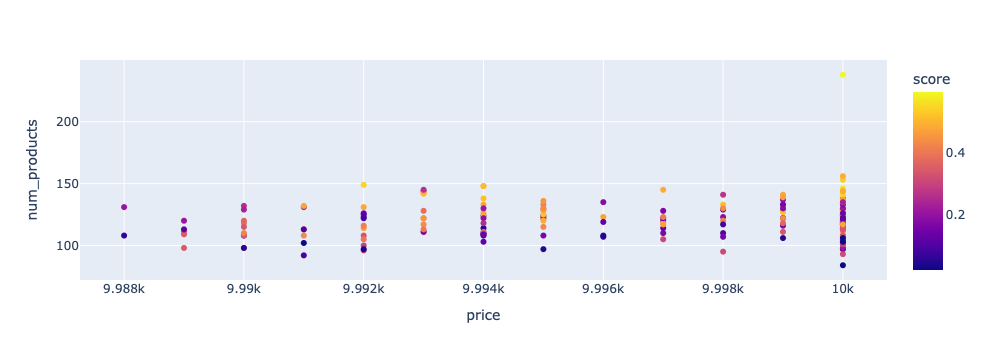

In [39]:
%%time
# scorer._data["score"] = None
scorer.summary()
scorer.plot(["price", "num_products"])

DEBUG: Querying database for routes

DEBUG: Assembling route dictionary

DEBUG: Checking availability

Output()

 Warning  No routes to scaffold=C653!

 Warning  No routes to scaffold=C1012!

 Warning  No routes to scaffold=C1192!

 Warning  No routes to scaffold=C2188!

 Warning  No routes to scaffold=C2919!

 Warning  No routes to scaffold=C2924!

 Warning  No routes to scaffold=C2944!

 Warning  No routes to scaffold=C3611!

 Warning  No routes to scaffold=C3627!

 DISK  Writing 1GJWBFH_chemistry.csv...

Output()

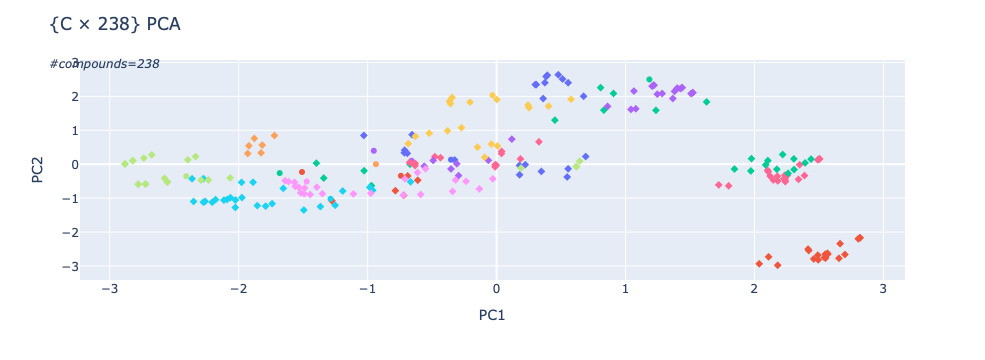

In [40]:
proposal = scorer.recipes["1GJWBFH"]
from hippo.plotting import plot_compound_tsnee
proposal.write_chemistry_csv("1GJWBFH_chemistry.csv")
plot_compound_tsnee(proposal.products.compounds)

In [43]:
print(animal.C86255.bases.ids)
print(animal.C86812.bases.ids)

[2924]
[2924]


## Pose scoring performance hack

In [6]:
rgen = hippo.RandomRecipeGenerator.from_json(animal.db, "CHIKV_prod8b_rgen.json")

session = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod10b.sqlite
in file = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod8b.sqlite
 Warning  Database path mismatch
Recipe was generated at: 2024-10-11 17:39:46.757934
reactants = {I x 32}
intermediates = {I x 0}
products = {I x 20}
reactions = {R x 20}
database = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod8b.sqlite
max_lead_time = None
suppliers = ['Stock', 'Enamine']


100%|██████████| 15435/15435 [00:34<00:00, 441.65it/s]


In [7]:
poses = rgen.route_pool.products.poses.get_by_tag('deprecated', inverse=True)
print(poses)

animal.db.execute("DROP TABLE pose_subset")
sql = f"""
CREATE TABLE pose_subset AS 
SELECT * FROM pose 
WHERE pose_id IN {poses.str_ids}
"""
animal.db.execute(sql)

{P x 19882}


In [8]:
%%time
for key, recipe in tqdm(scorer.recipes._recipes.items()):
    if recipe._product_poses is not None:
        continue

    str_ids = recipe.product_compounds.str_ids

    sql = f"""
    SELECT DISTINCT pose_id FROM pose_subset
    WHERE pose_compound IN {str_ids}
    """
    ids = animal.db.execute(sql).fetchall()

    ids = [i for i, in ids]

    recipe._product_poses = hippo.pset.PoseSet(animal.db, ids)


100%|██████████| 896/896 [08:34<00:00,  1.74it/s]

CPU times: user 7.89 s, sys: 32.7 s, total: 40.6 s
Wall time: 8min 34s


In [10]:
%%time
scorer.summary()

Scorer(#recipes=896)
Attribute("num_products", weight=0.08, inverse=False) min=98, mean=164, std=30.4, max=265
CustomAttribute("num_bases", weight=0.08, inverse=False) min=68, mean=68, std=0, max=68
CustomAttribute("num_bases_elaborated", weight=0.08, inverse=False) min=15, mean=18.9, std=1.55, max=26
DEBUG: CustomAttribute(key=elaboration_balance).value_dict


100%|██████████| 896/896 [00:11<00:00, 80.41it/s]

CustomAttribute("elaboration_balance", weight=0.08, inverse=False) min=-23.4, mean=-8.49, std=3.19, max=-2.99
DEBUG: CustomAttribute(key=num_inspirations).value_dict



100%|██████████| 896/896 [05:15<00:00,  2.84it/s]

CustomAttribute("num_inspirations", weight=0.08, inverse=False) min=16, mean=23, std=2.23, max=31
DEBUG: CustomAttribute(key=num_inspiration_sets).value_dict



100%|██████████| 896/896 [05:01<00:00,  2.97it/s]

CustomAttribute("num_inspiration_sets", weight=0.08, inverse=False) min=13, mean=17.9, std=1.88, max=26
DEBUG: CustomAttribute(key=risk_diversity).value_dict



100%|██████████| 896/896 [04:44<00:00,  3.15it/s]

CustomAttribute("risk_diversity", weight=0.08, inverse=False) min=0.649, mean=1.55, std=0.371, max=3.7
DEBUG: CustomAttribute(key=interaction_count).value_dict



  2%|▏         | 18/896 [01:14<1:00:39,  4.15s/it]


KeyboardInterrupt: 

In [ ]:
%%time
scorer.plot(["num_products","score"])

DEBUG: Updating scorer JSON cache
 DISK  Writing CHIKV_prod10b_scorer.json


NotImplementedError: 

In [14]:
scorer.recipes._recipes

{'1GCWBDO': Recipe_1GCWBDO({I x 109} --> {I x 3} --> {I x 137} via {R x 140}),
 '1GCWDYO': Recipe_1GCWDYO({I x 134} --> {I x 4} --> {I x 167} via {R x 171}),
 '1GCWGJ2': Recipe_1GCWGJ2({I x 108} --> {I x 2} --> {I x 112} via {R x 114}),
 '1GCWJ7N': Recipe_1GCWJ7N({I x 121} --> {I x 5} --> {I x 151} via {R x 156}),
 '1GCWM2N': Recipe_1GCWM2N({I x 128} --> {I x 4} --> {I x 149} via {R x 153}),
 '1GCWOQU': Recipe_1GCWOQU({I x 136} --> {I x 1} --> {I x 175} via {R x 176}),
 '1GCWRJU': Recipe_1GCWRJU({I x 122} --> {I x 3} --> {I x 169} via {R x 172}),
 '1GCWU0D': Recipe_1GCWU0D({I x 126} --> {I x 146} via {R x 146}),
 '1GCWWQY': Recipe_1GCWWQY({I x 114} --> {I x 2} --> {I x 127} via {R x 129}),
 '1GCWZBX': Recipe_1GCWZBX({I x 123} --> {I x 2} --> {I x 165} via {R x 167}),
 '1GCX238': Recipe_1GCX238({I x 126} --> {I x 2} --> {I x 144} via {R x 146}),
 '1GCX4XH': Recipe_1GCX4XH({I x 120} --> {I x 2} --> {I x 140} via {R x 142}),
 '1GCX7SX': Recipe_1GCX7SX({I x 124} --> {I x 4} --> {I x 160} v

In [65]:
print(scorer.top(1, budget=10500))
print(scorer.top(1, budget=11500))
print(scorer.top(1, budget=12500))

Recipe_1GCZ1X3(score=0.697)
Recipe_1GCZ1X3(score=0.697)
Recipe_1GCZ1X3(score=0.697)


In [76]:
for path in Path("CHIKV_prod11b_recipes").glob("Recipe*.json"):
    scorer.add_recipe(path)

 DISK  Reading CHIKV_prod11b_recipes/Recipe_1GER2HZ.json
session = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod10b.sqlite
in file = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod11b.sqlite
 Warning  Database path mismatch
Recipe was generated at: 2024-10-15 08:41:57.730111
reactants = {I x 129}
intermediates = {I x 2}
products = {I x 201}
reactions = {R x 207}
 DISK  Reading CHIKV_prod11b_recipes/Recipe_1GERJCJ.json
session = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod10b.sqlite
in file = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod11b.sqlite
 Warning  Database path mismatch
Recipe was generated at: 2024-10-15 09:18:06.948189
reactants = {I x 136}
intermediates = {I x 6}
products = {I x 383}
reactions = {R x 400}


TypeError: 'NoneType' object does not support item assignment

In [232]:
scorer.recipes

{Recipes x 513}

In [277]:
scorer.best.price

€29990.00 EUR

In [269]:
scorer.top(3, 12000)

DEBUG: Scorer.get_df()
DEBUG: Scorer.recipes.get_df()
DEBUG: Getting attribute.key='num_products' values
DEBUG: Getting attribute.key='num_bases' values
DEBUG: Getting attribute.key='num_bases_elaborated' values
DEBUG: Getting attribute.key='elaboration_balance' values
DEBUG: Getting attribute.key='num_inspirations' values
DEBUG: Getting attribute.key='num_inspiration_sets' values
DEBUG: Getting attribute.key='risk_diversity' values
DEBUG: Getting attribute.key='interaction_count' values
DEBUG: Getting attribute.key='interaction_balance' values
DEBUG: Getting attribute.key='num_subsites' values
DEBUG: Getting attribute.key='subsite_balance' values
DEBUG: Sorting DataFrame...


[Recipe_1G8PPKY({I x 126} --> {I x 425} via {R x 430}, score=0.687),
 Recipe_1G8PUMF({I x 163} --> {I x 485} via {R x 490}, score=0.673),
 Recipe_1G8PF8X({I x 163} --> {I x 485} via {R x 490}, score=0.673)]

In [268]:
scorer._df = None
scorer._sorted_df = None

In [280]:
scorer.get_sorted_df(budget=12000).head()

price reactant_supplier  \
512  10008.0  [Stock, Enamine]   
513  11005.0  [Stock, Enamine]   
510  11005.0  [Stock, Enamine]   
511  11005.0  [Stock, Enamine]   
323   9990.0  [Stock, Enamine]   

                                             reactants  \
512  {'compound_id': [85, 4554, 4466, 4467, 4440, 4...   
513  {'compound_id': [85, 4554, 4466, 4467, 4440, 4...   
510  {'compound_id': [85, 4554, 4466, 4467, 4440, 4...   
511  {'compound_id': [85, 4554, 4466, 4467, 4440, 4...   
323  {'compound_id': [85, 4554, 4466, 4467, 4440, 4...   

                                         intermediates  \
512  {'compound_id': [], 'amount': [], 'quote_id': ...   
513  {'compound_id': [], 'amount': [], 'quote_id': ...   
510  {'compound_id': [], 'amount': [], 'quote_id': ...   
511  {'compound_id': [], 'amount': [], 'quote_id': ...   
323  {'compound_id': [], 'amount': [], 'quote_id': ...   

                                              products  \
512  {'compound_id': [93, 95, 104, 796, 1001, 1128,...   
513  {'compound_id': [93, 95, 104, 796, 1001, 1128,...   
510  {'compound_id': [93, 95, 104, 796, 1001, 1128,...   
511  {'compound_id': [93, 95, 104, 796, 1001, 1128,...   
323  {'compound_id': [93, 95, 104, 796, 1001, 1128,...   

                                          reaction_ids     hash     score  \
512  [12290, 12292, 12297, 12298, 14, 17, 18, 69657...  1G8PPKY  0.686579   
513  [14, 17, 18, 29, 33, 35, 37, 43, 8235, 30768, ...  1G8PUMF  0.672862   
510  [14, 17, 18, 29, 33, 35, 37, 43, 8235, 30768, ...  1G8PF8X  0.672862   
511  [14, 17, 18, 29, 33, 35, 37, 43, 8235, 30768, ...  1G8PJKZ  0.672862   
323  [31233, 32259, 70669, 14, 32272, 42513, 18, 10...  1G87NWP  0.628076   

     num_products  num_bases  num_bases_elaborated  elaboration_balance  \
512           425         68                    13           -41.303753   
513           485         68                    13           -50.885299   
510           485         68                    13           -50.885299   
511           485         68                    13           -50.885299   
323           234         68                    13           -19.850924   

     num_inspirations  num_inspiration_sets  risk_diversity  \
512                20                    14        3.465345   
513                20                    14        3.446035   
510                20                    14        3.446035   
511                20                    14        3.446035   
323                19                    13        3.416050   

     interaction_count  interaction_balance  num_subsites  subsite_balance  
512                101           -60.285957             5        -0.545808  
513                101           -68.358769             5        -0.521701  
510                101           -68.358769             5        -0.521701  
511                101           -68.358769             5        -0.521701  
323                 86           -32.905095             5        -0.458635

In [79]:
# proposal = scorer.top(1, 12000)
proposal = scorer.recipes['1GERJCJ']

In [80]:
proposal.product_poses

{P x 469}

In [83]:
proposal.product_poses.to_fragalysis(
    "CHIKV_prod11b_recipes/Recipe_1GERJCJ_poses.sdf", 
    method="HIPPO 1GERJCJ", 
    submitter_name="Max Winokan", 
    submitter_email="max.winokan@diamond.ac.uk",
    submitter_institution="DLS"
)

100%|██████████| 469/469 [10:51<00:00,  1.39s/it]

 DISK  Writing CHIKV_prod11_recipes/Recipe_1GERJCJ_poses.sdf



[09:58:40] Molecule does not have explicit Hs. Consider calling AddHs()


HIPPO ID                     inchikey alias                        _Name  \
0        6251  QQERROZMPKKQER-UHFFFAOYSA-N  None  QQERROZMPKKQER-UHFFFAOYSA-N   
1        6276  MMXSHBZOILNLPJ-UHFFFAOYSA-N  None  MMXSHBZOILNLPJ-UHFFFAOYSA-N   
2        6278  DGASNXVGKHJXGC-UHFFFAOYSA-N  None  DGASNXVGKHJXGC-UHFFFAOYSA-N   
3        6297  WXVLITNXXROEMR-UHFFFAOYSA-N  None  WXVLITNXXROEMR-UHFFFAOYSA-N   
4        6309  VKQOZCFNDXYBME-SSDOTTSWSA-N  None  VKQOZCFNDXYBME-SSDOTTSWSA-N   
..        ...                          ...   ...                          ...   
464    117190  DQQBLQFWBKXEGA-JTQLQIEISA-N  None  DQQBLQFWBKXEGA-JTQLQIEISA-N   
465    117191  DQQBLQFWBKXEGA-SNVBAGLBSA-N  None  DQQBLQFWBKXEGA-SNVBAGLBSA-N   
466    117295  ATVJRENHXVTGIM-SECBINFHSA-N  None  ATVJRENHXVTGIM-SECBINFHSA-N   
467    117296  HWSNKHLLEGQQFC-VIFPVBQESA-N  None  HWSNKHLLEGQQFC-VIFPVBQESA-N   
468    117297  HWSNKHLLEGQQFC-VIFPVBQESA-N  None  HWSNKHLLEGQQFC-VIFPVBQESA-N   

                                       original SMILES  \
0                           CCc1nc(Cn2ccc(Br)cc2=O)no1   
1                               CC(C)(C)c1cnc2ccccc2n1   
2                         Cn1c(N)nc2cccc(NCc3cccs3)c21   
3                 CCc1nc(NC(=O)c2ccnc(NC3CC=CC3)c2)no1   
4      NC(=O)c1cc(Cl)c(C(=O)N[C@@H]2CCC(=O)NC2)c(Cl)c1   
..                                                 ...   
464  O=Cc1n[nH]cc1C(=O)N1C(=O)CC[C@H](NC(=O)c2cccc(...   
465  O=Cc1n[nH]cc1C(=O)N1C(=O)CC[C@@H](NC(=O)c2cccc...   
466  Cc1n[nH]c(N)c1C(=O)N1C(=O)CC[C@@H](NC(=O)c2ccc...   
467  Cc1n[nH]c(N)c1C(=O)N(C(=O)c1cccc(=O)[nH]1)[C@H...   
468  Cc1n[nH]c(N)c1C(=O)N(C(=O)c1cccc(=O)[nH]1)[C@H...   

                     original ID  \
0    QQERROZMPKKQER-UHFFFAOYSA-N   
1    MMXSHBZOILNLPJ-UHFFFAOYSA-N   
2    DGASNXVGKHJXGC-UHFFFAOYSA-N   
3    WXVLITNXXROEMR-UHFFFAOYSA-N   
4    VKQOZCFNDXYBME-SSDOTTSWSA-N   
..                           ...   
464  DQQBLQFWBKXEGA-JTQLQIEISA-N   
465  DQQBLQFWBKXEGA-SNVBAGLBSA-N   
466  ATVJRENHXVTGIM-SECBINFHSA-N   
467  HWSNKHLLEGQQFC-VIFPVBQESA-N   
468  HWSNKHLLEGQQFC-VIFPVBQESA-N   

                                                ROMol               tags  \
0    <rdkit.Chem.rdchem.Mol object at 0x7f6c468ebba0>  (Syndirella base)   
1    <rdkit.Chem.rdchem.Mol object at 0x7f6bc090c680>  (Syndirella base)   
2    <rdkit.Chem.rdchem.Mol object at 0x7f6bc090d350>  (Syndirella base)   
3    <rdkit.Chem.rdchem.Mol object at 0x7f6bc090b3d0>  (Syndirella base)   
4    <rdkit.Chem.rdchem.Mol object at 0x7f6c468eabb0>                 ()   
..                                                ...                ...   
464  <rdkit.Chem.rdchem.Mol object at 0x7f6c45639c60>                 ()   
465  <rdkit.Chem.rdchem.Mol object at 0x7f6c45691f80>                 ()   
466  <rdkit.Chem.rdchem.Mol object at 0x7f6bcc3b2160>                 ()   
467  <rdkit.Chem.rdchem.Mol object at 0x7f6c456aa340>                 ()   
468  <rdkit.Chem.rdchem.Mol object at 0x7f6c456aa6b0>                 ()   

          ref_mols ref_pdb                                            exports  \
0    c0316a,c1091a  c0300a  [/opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hi...   
1    c0839a,c1299a  c0300a  [/opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hi...   
2    c0892a,c1203a  c1454a  [/opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hi...   
3    c0316a,c0441a  c0300a  [/opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hi...   
4    c0300a,c1371a  c0300a                                                NaN   
..             ...     ...                                                ...   
464  c0732a,c1135a  c0300a                                                NaN   
465  c0732a,c1135a  c0300a                                                NaN   
466  c0732a,c1135a  c0300a                                                NaN   
467  c0732a,c1135a  c0300a                                                NaN   
468  c0732a,c1135a  c0300a                                                NaN   

    generation_d

In [290]:
pset = proposal.product_poses

In [504]:
proposal

Recipe_1G8PPKY({I x 126} --> {I x 425} via {R x 430}, score=0.687)

## HTML Output

In [54]:
# proposal.product_poses.to_fragalysis(
#     f"CHIKV_prod11b_recipes/Recipe_{proposal.hash}_poses.sdf", 
#     method=f"HIPPO {proposal.hash}", 
#     submitter_name="Max Winokan", 
#     submitter_email="max.winokan@diamond.ac.uk",
#     submitter_institution="DLS"
# )

In [55]:
recipe = hippo.Recipe.from_json(animal.db, path='CHIKV_starting_recipe_yields.json', allow_db_mismatch=True)

 DISK  Reading CHIKV_starting_recipe_yields.json...

session = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod10b.sqlite

in file = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod6.sqlite

 Warning  Database path mismatch!

Recipe was generated at: 2024-10-01 14:12:30.704341

reactants = {Ingredient × 32}

intermediates = {Ingredient × 0}

products = {Ingredient × 20}

reactions = {R × 20}

In [56]:
rgen = hippo.RandomRecipeGenerator.from_json(animal.db, 'CHIKV_prod13_rgen.json')

session = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod10b.sqlite

in file = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod13.sqlite

 Warning  Database path mismatch!

Recipe was generated at: 2024-10-24 08:35:18.970411

reactants = {Ingredient × 32}

intermediates = {Ingredient × 0}

products = {Ingredient × 20}

reactions = {R × 20}

database = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod13.sqlite

max_lead_time = None

suppliers =
['Stock', 'Enamine']

Output()

In [67]:
%%time
page = hippo.ProjectPage(
    output_dir = '../web3',
    animal=animal,
    scaffolds=rgen.route_pool.products.bases,
    rgen=rgen,
    scorer=scorer,
    proposals=[proposal],
    scaffold_tag="Syndirella base",
    extra_recipe_dir="CHIKV_prod11c_recipes",
)

 DISK  Writing ../web3...

 DISK  Writing ../web3/web_resources...

 DISK  Writing ../web3/web_resources/mol_images...

 DISK  Writing ../web3/web_resources/pose_sdfs...

DEBUG: len(self.all_scaffolds)=68

 DISK  Writing ../web3/web_resources/project_funnel.html
 DISK  Writing ../web3/web_resources/hit_tags.html


Output()

 DISK  Writing ../web3/web_resources/hit_poses.sdf...

Output()

 DISK  Writing ../web3/web_resources/mol_images/C93.png...

 DISK  Writing ../web3/web_resources/mol_images/C95.png...

 DISK  Writing ../web3/web_resources/mol_images/C104.png...

 DISK  Writing ../web3/web_resources/mol_images/C555.png...

 DISK  Writing ../web3/web_resources/mol_images/C627.png...

 DISK  Writing ../web3/web_resources/mol_images/C653.png...

 DISK  Writing ../web3/web_resources/mol_images/C796.png...

 DISK  Writing ../web3/web_resources/mol_images/C1012.png...

 DISK  Writing ../web3/web_resources/mol_images/C1029.png...

 DISK  Writing ../web3/web_resources/mol_images/C1128.png...

 DISK  Writing ../web3/web_resources/mol_images/C1192.png...

 DISK  Writing ../web3/web_resources/mol_images/C1316.png...

 DISK  Writing ../web3/web_resources/mol_images/C1473.png...

 DISK  Writing ../web3/web_resources/mol_images/C1917.png...

 DISK  Writing ../web3/web_resources/mol_images/C1965.png...

 DISK  Writing ../web3/web_resources/mol_images/C2188.png...

 DISK  Writing ../web3/web_resources/mol_images/C2916.png...

 DISK  Writing ../web3/web_resources/mol_images/C2919.png...

 DISK  Writing ../web3/web_resources/mol_images/C2924.png...

 DISK  Writing ../web3/web_resources/mol_images/C2925.png...

 DISK  Writing ../web3/web_resources/mol_images/C2944.png...

 DISK  Writing ../web3/web_resources/mol_images/C3611.png...

 DISK  Writing ../web3/web_resources/mol_images/C3624.png...

 DISK  Writing ../web3/web_resources/mol_images/C3625.png...

 DISK  Writing ../web3/web_resources/mol_images/C3627.png...

 DISK  Writing ../web3/web_resources/mol_images/C3628.png...

 DISK  Writing ../web3/web_resources/mol_images/C3632.png...

 DISK  Writing ../web3/web_resources/all_scaffold_smiles.csv...

 DISK  Writing ../web3/web_resources/selected_scaffold_smiles.csv...

 DISK  Writing ../web3/web_resources/reaction_funnel.html


Output()

DEBUG: Using slower Reaction.dict rather than direct SQL query...

Output()

 DISK  Writing ../web3/web_resources/scorer_scatter.html
 DISK  Writing ../web3/web_resources/attribute_num_products_hist.html
 DISK  Writing ../web3/web_resources/attribute_num_bases_hist.html
 DISK  Writing ../web3/web_resources/attribute_num_bases_elaborated_hist.html
 DISK  Writing ../web3/web_resources/attribute_elaboration_balance_hist.html
 DISK  Writing ../web3/web_resources/attribute_num_inspirations_hist.html
 DISK  Writing ../web3/web_resources/attribute_num_inspiration_sets_hist.html
 DISK  Writing ../web3/web_resources/attribute_risk_diversity_hist.html
 DISK  Writing ../web3/web_resources/attribute_interaction_count_hist.html
 DISK  Writing ../web3/web_resources/attribute_interaction_balance_hist.html
 DISK  Writing ../web3/web_resources/attribute_num_subsites_hist.html
 DISK  Writing ../web3/web_resources/attribute_subsite_balance_hist.html
 DISK  Writing ../web3/web_resources/attribute_avg_distance_score_hist.html
 DISK  Writing ../web3/web_resources/attribute_avg_energ

Output()

 DISK  Writing ../web3/web_resources/proposal_1GJWBFH.html


Output()

Output()

DEBUG: Using slower Reaction.dict rather than direct SQL query...

Output()

 ERROR  Could not find pose SDF: CHIKV_prod11c_recipes/Recipe_1GJWBFH_poses.sdf!

DEBUG: Querying database for routes

DEBUG: Assembling route dictionary

DEBUG: Checking availability

Output()

 DISK  Writing /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/web3/web_resources/Recipe_1GJWBFH_CAR_1steps.csv...

 DISK  Writing /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/web3/web_resources/Recipe_1GJWBFH_CAR_2steps.csv...

 DISK  Writing /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/web3/web_resources/Recipe_1GJWBFH_CAR.csv...

DEBUG: Querying database for routes

DEBUG: Assembling route dictionary

DEBUG: Checking availability

Output()

Output()

 DISK  Writing ../web3/web_resources/Recipe_1GJWBFH_reactants.csv...

DEBUG: Querying database for routes

DEBUG: Assembling route dictionary

DEBUG: Checking availability

Output()

Output()

 DISK  Writing ../web3/web_resources/Recipe_1GJWBFH_products.csv...

DEBUG: Querying database for routes

DEBUG: Assembling route dictionary

DEBUG: Checking availability

Output()

 Warning  No routes to scaffold=C653!

 Warning  No routes to scaffold=C1012!

 Warning  No routes to scaffold=C1192!

 Warning  No routes to scaffold=C2188!

 Warning  No routes to scaffold=C2919!

 Warning  No routes to scaffold=C2924!

 Warning  No routes to scaffold=C2944!

 Warning  No routes to scaffold=C3611!

 Warning  No routes to scaffold=C3627!

 DISK  Writing ../web3/web_resources/Recipe_1GJWBFH_chemistry.csv...

 DISK  Writing ../web3/index.html...

CPU times: user 18.8 s, sys: 20.4 s, total: 39.2 s
Wall time: 5min 23s


In [45]:
from hirsch import hirsch

In [46]:
new = [5,5,5,3,0,23,12,18,11,9,8,0,6,4,4,6,3,20,12,9,10,20,12,19]
prev = [5,5,0,0,0,33,9,22,0,11,5,0,0,3,16,4,1,20,4,1,40,6,8,231]

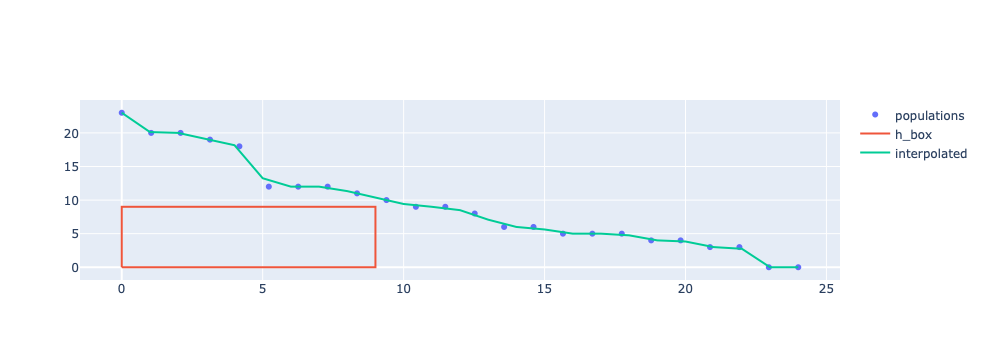

In [51]:
fig, h = hirsch(new, plot=True)
fig

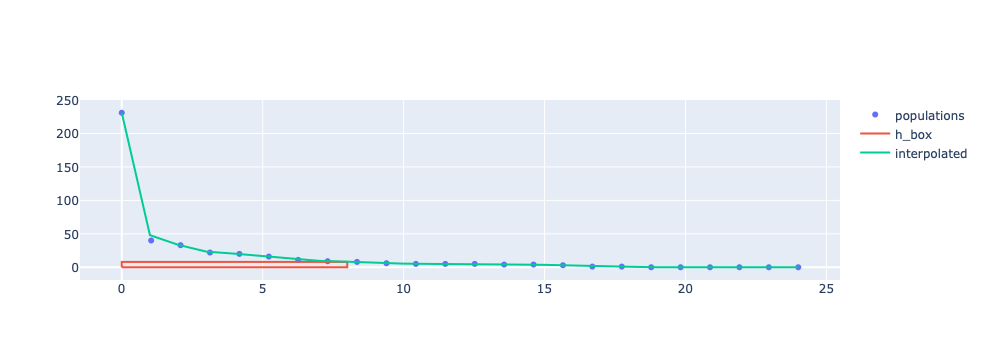

In [53]:
fig, h = hirsch(prev, plot=True)
fig